In [1]:
#path="/data/GitHubAPI/"
path="/lfs1/GitHubAPI/"

In [5]:
import platform
print(platform.python_version())

3.7.7


In [3]:
from library import *

In [4]:
from constant import *

## TOC:
* [Get event Data](#event_data)
* [Event](#event)
* [Repo](#repo)
* [User](#user)


AI related key-words are stored in AI_keywords.txt

In [5]:
file=open('AI_keywords.txt','r')
AI_keywords=set(file.read().split('\n'))
print ('number of AI words: ', len(AI_keywords))

number of AI words:  40


### 1) get repos with ai words in descriptopn

save ids for repo with createEvents/repository type and ai in their description

In [11]:
#no need for creat_at constraints since creation events happened in either 2017, 2018, 2019
# tried line['org']['login'] and the same as owner_name (owner_name/repo_name) if type of owner is organization
#line['org']['login']

def extract_repo(f):
    output=[]
    ct=0
    for line in (gzip.open(f, 'r')):
        try:
            line=json.loads(line)
            if line['type']=='CreateEvent' and line['payload']['ref_type']=='repository' and len(set(line['payload']['description'].lower().split()).intersection(AI_keywords))>0:
                output.append([line['repo']['id'], line['actor']['url'], line['repo']['name'], line['payload']['description']])
        except:
            ct+=1
    return output

#### output in repo_pandas file

In [16]:
# repo_pd=pd.read_pickle('repo_pandas.pickle')
# len(set(repo_pd['repo_id']))

238544

save id of ai-related repos in 'ai_repo_ids.data'

In [18]:
# with open('ai_repo_ids.data', 'wb') as filehandle:
#     # store the data as binary data stream
#     pickle.dump(list(repo_pd['repo_id']), filehandle)
# filehandle.close()

#### repo ids used to extract events

In [16]:
repo_ids=set(pd.read_pickle('ai_repo_ids.data'))

In [17]:
def process_event (f):
    output=[]
    for line in (gzip.open(f, 'r')):
        line=json.loads(line)
        if (line['repo']['id']) in repo_ids:
            output.append([line['id'], line['repo']['id'], line['repo']['name'], line['type'], line['actor']['id'], line['actor']['url'], line['payload']])
    return output

#### output in event_pandas file

In [28]:
event_pd=pd.read_pickle('event_pandas.pickle')
len(event_pd)

4316204

extract users info

In [5]:
def process_user(f):
    output, ct=[], 0
    try:
        with open (f) as json_file:
                user_info=json.load(json_file)
                output.append([user_info['id'], user_info['login'], user_info['name'],  user_info['type'],
                               user_info['company'], user_info['email'], user_info['location'], user_info['blog'],
                               user_info['created_at']])
    except:
        ct+=1
        
    return output

#### output in user_pandas file

In [33]:
user_pd=pd.read_pickle('user_pandas.pickle')

take all files in a directory via glob

In [6]:
event_profiles=glob.glob("/lfs1/GitHubAPI/events/*.json.gz")
user_profiles_1=glob.glob("user_profiles/*.txt")
user_profiles_2=glob.glob("user_profiles_new/*.txt")

In [7]:
user_profiles=user_profiles_1+user_profiles_2
print ('number of user profiles: ', len(user_profiles))

number of user profiles:  299031


In [378]:
# ct=0
# for i, line in enumerate(gzip.open(event_profiles[1], 'r')):
#     line=json.loads(line)
#     #print (line)
# #     for att in line:
# #         print (att)
#     #print (line['actor'])
    
#     if i < 100:
#         try:
#             print (line['org']['login'])
#             print (line['repo']['name'])
#             print (line['actor']['login'])
#             print (line['type'])
# #             print (line['actor']['login'])
#             print ('\n')
#         except:
#             ct+=1
#     else:
#         break

In [13]:
event_profiles[:1]

['/lfs1/GitHubAPI/events/2017-09-16-7.json.gz']

Constants

In [18]:
# files=user_profiles
# process=process_user

files=event_profiles
process=process_event

# files=event_profiles
# process=extract_repo

extract information from files using multiprocessing 

In [19]:
pbar = tqdm(total=len([1 for _ in files]))
def update(*a): pbar.update()
with Pool(processes=multiprocessing.cpu_count()) as p:
    data_ = []

    for f in files:
        data_.append(p.apply_async(process, [f], callback=update))


    p.close()
    p.join() # Wait for all child processes 
    data = [r.get() for r in data_]




  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

The repository name has to be unique to your account. That means that someone else can have a repository on GitHub named my-awesome-repo, and you can have one as well.


Since you can use Git outside of GitHub, those two usernames do not have to be the same. Also, the GitHub username must be unique, but nothing forces uniqueness of Git usernames.

### Repo

In [12]:
#result_repo=(list(itertools.chain.from_iterable(data)))

In [192]:
#z=Counter(result_event)

In [14]:
#good_columns=['repo_id','actor_url', 'repo_name', 'description']

In [15]:
#repo_pd=pd.DataFrame(result_repo, columns=good_columns)

In [37]:
#print (len(repo_pd))

In [196]:
#repo_pd=repo_pd.drop_duplicates()

In [197]:
#print (len(repo_pd))

In [198]:
#repo_pd.to_pickle('repo_pandas.pickle')

In [4]:
repo_pd=pd.read_pickle('repo_pandas.pickle')

In [6]:
repo_pd.head()

repo_id                                   actor_url  \
0  103732974     https://api.github.com/users/HaojieYuan   
1  103733128  https://api.github.com/users/AssKicker0214   
2  103733469       https://api.github.com/users/yowenter   
3  103733627     https://api.github.com/users/desire2020   
4  103733988       https://api.github.com/users/olokshyn   

                           repo_name  \
0  HaojieYuan/Caffe_network_training   
1             AssKicker0214/WeiboLab   
2               yowenter/ilovemuseum   
3          desire2020/SRU-tensorflow   
4                    olokshyn/optics   

                                         description  
0  This python script allows you to train your ne...  
1        NLP for short textual data in social media.  
2  museum search, museum recommendation and mesum...  
3  Training RNNs as fast as CNNs. An unofficial t...  
4                        OPTICS clustering algorithm

### User 

In [10]:
#result_user=(list(itertools.chain.from_iterable(data)))

100%|██████████| 299031/299031 [00:50<00:00, 9571.30it/s]

In [11]:
#len(result_user)

284427

In [12]:
# good_columns=['user_id', 'user_login', 'user_name', 'user_type', 'user_company', 'user_email', 'user_location',
#              'user_blog', 'user_created_at']

In [13]:
#user_pd=pd.DataFrame(result_user, columns=good_columns)

In [16]:
#user_pd.to_pickle('user_pandas.pickle')

In [20]:
user_pd=pd.read_pickle('user_pandas.pickle')

In [28]:
user_pd.columns 

Index(['user_id', 'user_login', 'user_name', 'user_type', 'user_company',
       'user_email', 'user_location', 'user_blog', 'user_created_at'],
      dtype='object')

In [22]:
user_pd.head(5)

user_id     user_login         user_name user_type user_company  \
0  38789239     YCYchunyan              None      User         None   
1  34797853    spachava753  Shashank Pachava      User         None   
2  31099775        ygs0087              None      User         None   
3   7780134  stevelarrison              None      User         None   
4  46271902         wdd233               WDD      User          SCU   

              user_email user_location                  user_blog  \
0                   None          None                              
1  spachava753@gmail.com          None              thespblog.net   
2                   None          None                              
3                   None          None                              
4                   None           CDC  https://wdd233.github.io/   

        user_created_at  
0  2018-04-27T14:15:25Z  
1  2017-12-23T18:35:51Z  
2  2017-08-17T12:06:40Z  
3  2014-06-03T11:38:31Z  
4  2018-12-31T01:19:34Z

some stat about users

In [29]:
len(user_pd[user_pd.user_location.notnull()]), len(user_pd[user_pd.user_company.notnull()] ), len(user_pd)

(107716, 62438, 284427)

users vs company 

In [37]:
unique_loc=user_pd.user_location.value_counts()

### Events

In [22]:
#result_event=(list(itertools.chain.from_iterable(data)))

In [23]:
#good_columns=['event_id', 'repo_id', 'repo_name', 'event_type', 'actor_id', 'actor_url', 'event_payload']

In [24]:
#event_pd=pd.DataFrame(result_event, columns=good_columns)

In [ ]:
#len(event_pd['event_type'].value_counts())

In [ ]:
#event_pd.to_pickle('event_pandas.pickle')

In [47]:
event_pd=pd.read_pickle('event_pandas.pickle')

In [48]:
len(set(event_pd['repo_id']))

238543

In [49]:
#event_pd.head(5)

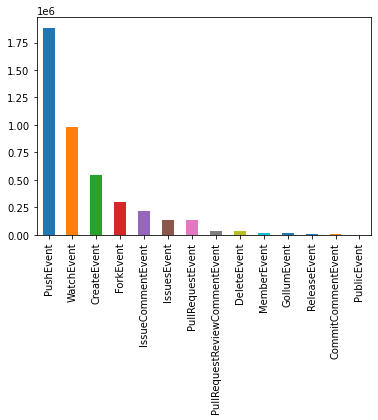

In [51]:
fig = event_pd['event_type'].value_counts().plot(kind="bar")

In [19]:
#plt.show()

In [53]:
#event_pd['event_type'].value_counts()

In [55]:
#event_pd['repo_id'].value_counts()

In [111]:
#event_pd['repo_id'].value_counts()
#event_pd.groupby('repo_id').size()

### repo frequency

In [125]:
repo_w_n_events_id=event_pd.repo_id.value_counts()

#### Convert pandas Series to DataFrame

In [126]:
repo_w_n_events_id=pd.DataFrame({'repo_id':repo_w_n_events_id.index, 'num_events':repo_w_n_events_id.values})

#### filter repos with n> events

In [127]:
repo_w_n_events_id=repo_w_n_events_id[repo_w_n_events_id['num_events']>49]

In [130]:
len(repo_w_n_events_id)
repo_w_n_events_id.head(5)

num_events    repo_id
0       28138  102692863
1       17546  138331573
2       17179  175276495
3       16743  136914524
4       15146  106024057

get the name of repo with at least n events

In [129]:
repo_pd_n_events=repo_pd[repo_pd['repo_id'].isin(list(repo_w_n_events_id['repo_id']))]

### collect user profiles

#### In script: user_info_collector.py

### collect repo profiles

In [52]:
for row in tqdm(repo_pd_n_events[:10].iterrows()):
#for repo_id in tqdm(not_exist):
    url= 'https://api.github.com/repos/'+ row[1]['repo_name']
    #url='https://api.github.com/repositories/'+ str(repo_id)
    filename=str(row[1]['repo_id'])+'.txt'
    #filename=str(repo_id)+'.txt'
    #!curl -u  Iv127f23c7e00f9fc06:0e2b6e185c62ce9c6dbda43fd4f87200c2707074 $url
    !curl -u 42261d9a908c778989b3:bcb278145fba3ea9fe7b1d2bfe76ca9960d9c798 $url  > "$filename"



  0%|          | 0/3279 [00:00<?, ?it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    148      0 --:--:-- --:--:-- --:--:--   148




  0%|          | 1/3279 [00:00<47:33,  1.15it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6491  100  6491    0     0  11393      0 --:--:-- --:--:-- --:--:-- 11407




  0%|          | 2/3279 [00:01<46:05,  1.18it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5540  100  5540    0     0   9689      0 --:--:-- --:--:-- --:--:--  9702




  0%|          | 3/3279 [00:02<45:07,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




  0%|          | 4/3279 [00:03<43:24,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6774  100  6774    0     0  11344      0 --:--:-- --:--:-- --:--:-- 11346




  0%|          | 5/3279 [00:03<43:37,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   175




  0%|          | 6/3279 [00:04<43:06,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




  0%|          | 7/3279 [00:05<41:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   194




  0%|          | 8/3279 [00:06<40:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6300  100  6300    0     0  11520      0 --:--:-- --:--:-- --:--:--     0 --:--:-- --:--:-- 11517




  0%|          | 9/3279 [00:06<41:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5755  100  5755    0     0  10404      0 --:--:-- --:--:-- --:--:-- 10425




  0%|          | 10/3279 [00:07<41:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5608  100  5608    0     0   9450      0 --:--:-- --:--:-- --:--:--  9456




  0%|          | 11/3279 [00:08<42:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




  0%|          | 12/3279 [00:09<41:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    174      0 --:--:-- --:--:-- --:--:--   175




  0%|          | 13/3279 [00:10<41:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    174      0 --:--:-- --:--:-- --:--:--   174




  0%|          | 14/3279 [00:10<41:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9049  100  9049    0     0  16866      0 --:--:-- --:--:-- --:--:-- 16882




  0%|          | 15/3279 [00:11<41:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




  0%|          | 16/3279 [00:12<40:54,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




  1%|          | 17/3279 [00:13<40:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5845  100  5845    0     0   9901      0 --:--:-- --:--:-- --:--:--  9890




  1%|          | 18/3279 [00:13<41:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




  1%|          | 19/3279 [00:14<40:57,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




  1%|          | 20/3279 [00:15<40:10,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5347  100  5347    0     0   8709      0 --:--:-- --:--:-- --:--:--  8708




  1%|          | 21/3279 [00:16<41:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5659  100  5659    0     0  10673      0 --:--:-- --:--:-- --:--:-- 10677




  1%|          | 22/3279 [00:16<41:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5845  100  5845    0     0  10855      0 --:--:-- --:--:-- --:--:-- 10864




  1%|          | 23/3279 [00:17<41:06,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6518  100  6518    0     0  11805      0 --:--:-- --:--:-- --:--:-- 11829




  1%|          | 24/3279 [00:18<41:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6065  100  6065    0     0  11462      0 --:--:-- --:--:-- --:--:-- 11465




  1%|          | 25/3279 [00:19<41:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5901  100  5901    0     0  10498      0 --:--:-- --:--:-- --:--:-- 10500




  1%|          | 26/3279 [00:19<41:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   193




  1%|          | 27/3279 [00:20<40:50,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5348  100  5348    0     0   9865      0 --:--:-- --:--:-- --:--:--  9885




  1%|          | 28/3279 [00:21<40:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6711  100  6711    0     0  12040      0 --:--:-- --:--:-- --:--:-- 12026




  1%|          | 29/3279 [00:22<41:09,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5681  100  5681    0     0  10830      0 --:--:-- --:--:-- --:--:-- 10820      0      0 --:--:-- --:--:-- --:--:--     0




  1%|          | 30/3279 [00:22<40:47,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5605  100  5605    0     0   9809      0 --:--:-- --:--:-- --:--:--  9816




  1%|          | 31/3279 [00:23<41:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6087  100  6087    0     0  11646      0 --:--:-- --:--:-- --:--:-- 11660




  1%|          | 32/3279 [00:24<40:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5295  100  5295    0     0  10008      0 --:--:-- --:--:-- --:--:-- 10009




  1%|          | 33/3279 [00:25<40:39,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5407  100  5407    0     0   8932      0 --:--:-- --:--:-- --:--:--  8922




  1%|          | 34/3279 [00:25<41:43,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7541  100  7541    0     0  13853      0 --:--:-- --:--:-- --:--:-- 13862




  1%|          | 35/3279 [00:26<41:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




  1%|          | 36/3279 [00:27<40:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6726  100  6726    0     0  11945      0 --:--:-- --:--:-- --:--:-- 11946




  1%|          | 37/3279 [00:28<41:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5272  100  5272    0     0   9683      0 --:--:-- --:--:-- --:--:--  9673




  1%|          | 38/3279 [00:28<40:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7395  100  7395    0     0  13550      0 --:--:-- --:--:-- --:--:-- 13543




  1%|          | 39/3279 [00:29<41:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6150  100  6150    0     0  11059      0 --:--:-- --:--:-- --:--:-- 11081




  1%|          | 40/3279 [00:30<41:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6201  100  6201    0     0  11097      0 --:--:-- --:--:-- --:--:-- 11093




  1%|▏         | 41/3279 [00:31<41:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6540  100  6540    0     0  11918      0 --:--:-- --:--:-- --:--:-- 11912




  1%|▏         | 42/3279 [00:32<41:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5700  100  5700    0     0  10063      0 --:--:-- --:--:-- --:--:-- 10052




  1%|▏         | 43/3279 [00:32<41:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5622  100  5622    0     0  10228      0 --:--:-- --:--:-- --:--:-- 10240




  1%|▏         | 44/3279 [00:33<41:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5153  100  5153    0     0   9344      0 --:--:-- --:--:-- --:--:--  9352




  1%|▏         | 45/3279 [00:34<41:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5916  100  5916    0     0  10181      0 --:--:-- --:--:-- --:--:-- 10182




  1%|▏         | 46/3279 [00:35<41:37,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5398  100  5398    0     0   9941      0 --:--:-- --:--:-- --:--:--  9941




  1%|▏         | 47/3279 [00:35<41:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    201      0 --:--:-- --:--:-- --:--:--   202




  1%|▏         | 48/3279 [00:36<40:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5820  100  5820    0     0  11060      0 --:--:-- --:--:-- --:--:-- 11085




  1%|▏         | 49/3279 [00:37<40:04,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6698  100  6698    0     0  12851      0 --:--:-- --:--:-- --:--:-- 12856




  2%|▏         | 50/3279 [00:38<39:58,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




  2%|▏         | 51/3279 [00:38<39:42,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6074  100  6074    0     0  10616      0 --:--:-- --:--:-- --:--:-- 10637




  2%|▏         | 52/3279 [00:39<40:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5830  100  5830    0     0      0      0 --:--:-- --:--:-- --:--:--     0 0     0  10647      0 --:--:-- --:--:-- --:--:-- 10658




  2%|▏         | 53/3279 [00:40<40:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5629  100  5629    0     0  10150      0 --:--:-- --:--:-- --:--:-- 10142




  2%|▏         | 54/3279 [00:41<40:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5573  100  5573    0     0  10702      0 --:--:-- --:--:-- --:--:-- 10696




  2%|▏         | 55/3279 [00:41<40:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6379  100  6379    0     0  11341      0 --:--:-- --:--:-- --:--:-- 11350




  2%|▏         | 56/3279 [00:42<40:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5731  100  5731    0     0  10723      0 --:--:-- --:--:-- --:--:-- 10732




  2%|▏         | 57/3279 [00:43<40:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   192




  2%|▏         | 58/3279 [00:44<40:03,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




  2%|▏         | 59/3279 [00:44<39:59,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5859  100  5859    0     0   9869      0 --:--:-- --:--:-- --:--:--  9880




  2%|▏         | 60/3279 [00:45<40:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5059  100  5059    0     0   9465      0 --:--:-- --:--:-- --:--:--  9473




  2%|▏         | 61/3279 [00:46<40:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5773  100  5773    0     0  10489      0 --:--:-- --:--:-- --:--:-- 10477




  2%|▏         | 62/3279 [00:47<40:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6441  100  6441    0     0  12000      0 --:--:-- --:--:-- --:--:-- 11994




  2%|▏         | 63/3279 [00:47<40:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5421  100  5421    0     0   9611      0 --:--:-- --:--:-- --:--:--  9628




  2%|▏         | 64/3279 [00:48<40:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6286  100  6286    0     0  11371      0 --:--:-- --:--:-- --:--:-- 11387




  2%|▏         | 65/3279 [00:49<40:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6426  100  6426    0     0  11743      0 --:--:-- --:--:-- --:--:-- 11747




  2%|▏         | 66/3279 [00:50<40:54,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6242  100  6242    0     0  11286      0 --:--:-- --:--:-- --:--:-- 11287




  2%|▏         | 67/3279 [00:50<40:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




  2%|▏         | 68/3279 [00:51<40:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5911  100  5911    0     0  10222      0 --:--:-- --:--:-- --:--:-- 10244




  2%|▏         | 69/3279 [00:52<40:48,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5885  100  5885    0     0  10774      0 --:--:-- --:--:-- --:--:-- 10778




  2%|▏         | 70/3279 [00:53<40:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6666  100  6666    0     0  12250      0 --:--:-- --:--:-- --:--:-- 12253




  2%|▏         | 71/3279 [00:53<40:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6380    4   268    0     0    491      0  0:00:12 --:--:--  0:00:12   490380  100  6380    0     0  11671      0 --:--:-- --:--:-- --:--:-- 11663




  2%|▏         | 72/3279 [00:54<40:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5357  100  5357    0     0   9625      0 --:--:-- --:--:-- --:--:--  9634




  2%|▏         | 73/3279 [00:55<40:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5385  100  5385    0     0   9965      0 --:--:-- --:--:-- --:--:--  9972




  2%|▏         | 74/3279 [00:56<40:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6866  100  6866    0     0  13325      0 --:--:-- --:--:-- --:--:-- 13332




  2%|▏         | 75/3279 [00:57<40:06,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9130  100  9130    0     0  16930      0 --:--:-- --:--:-- --:--:-- 16907




  2%|▏         | 76/3279 [00:57<40:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5211  100  5211    0     0   9475      0 --:--:-- --:--:-- --:--:--  9491




  2%|▏         | 77/3279 [00:58<40:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5467  100  5467    0     0  10218      0 --:--:-- --:--:-- --:--:-- 10237




  2%|▏         | 78/3279 [00:59<40:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5381  100  5381    0     0   9580      0 --:--:-- --:--:-- --:--:--  9574




  2%|▏         | 79/3279 [01:00<40:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6560  100  6560    0     0   9705      0 --:--:-- --:--:-- --:--:--  9704




  2%|▏         | 80/3279 [01:00<42:31,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    177      0 --:--:-- --:--:-- --:--:--   177




  2%|▏         | 81/3279 [01:01<41:38,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5326  100  5326    0     0   9499      0 --:--:-- --:--:-- --:--:--  9510




  3%|▎         | 82/3279 [01:02<41:33,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5087  100  5087    0     0   8975      0 --:--:-- --:--:-- --:--:--  8971




  3%|▎         | 83/3279 [01:03<41:32,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5485  100  5485    0     0   9395      0 --:--:-- --:--:-- --:--:--  9392




  3%|▎         | 84/3279 [01:04<41:48,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6519  100  6519    0     0  11640      0 --:--:-- --:--:-- --:--:-- 11641




  3%|▎         | 85/3279 [01:04<41:29,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6546  100  6546    0     0  11690      0 --:--:-- --:--:-- --:--:-- 11710




  3%|▎         | 86/3279 [01:05<41:22,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




  3%|▎         | 87/3279 [01:06<40:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5546  100  5546    0     0  10340      0 --:--:-- --:--:-- --:--:-- 10327




  3%|▎         | 88/3279 [01:07<40:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6845  100  6845    0     0  12007      0 --:--:-- --:--:-- --:--:-- 12008




  3%|▎         | 89/3279 [01:07<40:45,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7484  100  7484    0     0  13855      0 --:--:-- --:--:-- --:--:-- 13884




  3%|▎         | 90/3279 [01:08<40:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6387  100  6387    0     0  12306      0 --:--:-- --:--:-- --:--:-- 12330




  3%|▎         | 91/3279 [01:09<40:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5797  100  5797    0     0   9748      0 --:--:-- --:--:-- --:--:--  9742




  3%|▎         | 92/3279 [01:10<40:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




  3%|▎         | 93/3279 [01:10<40:06,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5919  100  5919    0     0  10821      0 --:--:-- --:--:-- --:--:-- 10840




  3%|▎         | 94/3279 [01:11<40:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5800  100  5800    0     0   9954      0 --:--:-- --:--:-- --:--:--  9965




  3%|▎         | 95/3279 [01:12<40:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




  3%|▎         | 96/3279 [01:13<40:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5491  100  5491    0     0   9670      0 --:--:-- --:--:-- --:--:--  9667




  3%|▎         | 97/3279 [01:13<40:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5746  100  5746    0     0  10106      0 --:--:-- --:--:-- --:--:-- 10098




  3%|▎         | 98/3279 [01:14<41:02,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5656  100  5656    0     0  10030      0 --:--:-- --:--:-- --:--:-- 10046




  3%|▎         | 99/3279 [01:15<41:04,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




  3%|▎         | 100/3279 [01:16<40:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5603  100  5603    0     0   9742      0 --:--:-- --:--:-- --:--:--  9744




  3%|▎         | 101/3279 [01:17<40:59,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4995  100  4995    0     0   9071      0 --:--:-- --:--:-- --:--:--  9065




  3%|▎         | 102/3279 [01:17<40:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




  3%|▎         | 103/3279 [01:18<40:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6239  100  6239    0     0  10926      0 --:--:-- --:--:-- --:--:-- 10945




  3%|▎         | 104/3279 [01:19<40:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6110  100  6110    0     0  10501      0 --:--:-- --:--:-- --:--:-- 10498




  3%|▎         | 105/3279 [01:20<41:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6061  100  6061    0     0   9915      0 --:--:-- --:--:-- --:--:--  9903




  3%|▎         | 106/3279 [01:20<41:50,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5904  100  5904    0     0   9151      0 --:--:-- --:--:-- --:--:--  9153




  3%|▎         | 107/3279 [01:21<42:54,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7340  100  7340    0     0  12975      0 --:--:-- --:--:-- --:--:-- 12991




  3%|▎         | 108/3279 [01:22<42:22,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5051  100  5051    0     0   8484      0 --:--:-- --:--:-- --:--:--  8489




  3%|▎         | 109/3279 [01:23<42:28,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6185  100  6185    0     0  11201      0 --:--:-- --:--:-- --:--:-- 11204




  3%|▎         | 110/3279 [01:24<41:52,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5395  100  5395    0     0  10098      0 --:--:-- --:--:-- --:--:-- 10102




  3%|▎         | 111/3279 [01:24<41:11,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6197  100  6197    0     0  10551      0 --:--:-- --:--:-- --:--:-- 10539




  3%|▎         | 112/3279 [01:25<41:29,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6206  100  6206    0     0  11291      0 --:--:-- --:--:-- --:--:-- 11304




  3%|▎         | 113/3279 [01:26<41:05,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6562  100  6562    0     0  11121      0 --:--:-- --:--:-- --:--:-- 11122




  3%|▎         | 114/3279 [01:27<41:28,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




  4%|▎         | 115/3279 [01:28<41:03,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6261  100  6261    0     0  10694      0 --:--:-- --:--:-- --:--:-- 10684




  4%|▎         | 116/3279 [01:28<41:21,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




  4%|▎         | 117/3279 [01:29<40:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5683  100  5683    0     0  10058      0 --:--:-- --:--:-- --:--:-- 10076




  4%|▎         | 118/3279 [01:30<40:30,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5328  100  5328    0     0   9842      0 --:--:-- --:--:-- --:--:--  9830




  4%|▎         | 119/3279 [01:31<40:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5563  100  5563    0     0   9982      0 --:--:-- --:--:-- --:--:--  9969




  4%|▎         | 120/3279 [01:31<40:20,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5079  100  5079    0     0   9197      0 --:--:-- --:--:-- --:--:--  9217




  4%|▎         | 121/3279 [01:32<40:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




  4%|▎         | 122/3279 [01:33<39:46,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6003  100  6003    0     0  10688      0 --:--:-- --:--:-- --:--:-- 10681




  4%|▍         | 123/3279 [01:34<40:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7695  100  7695    0     0  14431      0 --:--:-- --:--:-- --:--:-- 14437




  4%|▍         | 124/3279 [01:34<39:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6066  100  6066    0     0  10450      0 --:--:-- --:--:-- --:--:-- 10458




  4%|▍         | 125/3279 [01:35<40:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5209  100  5209    0     0   9222      0 --:--:-- --:--:-- --:--:--  9235




  4%|▍         | 126/3279 [01:36<40:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5392  100  5392    0     0   9883      0 --:--:-- --:--:-- --:--:--  9875




  4%|▍         | 127/3279 [01:37<40:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6764  100  6764    0     0  12264      0 --:--:-- --:--:-- --:--:-- 12253




  4%|▍         | 128/3279 [01:38<40:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




  4%|▍         | 129/3279 [01:38<39:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6656  100  6656    0     0  11666      0 --:--:-- --:--:-- --:--:-- 11677




  4%|▍         | 130/3279 [01:39<40:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6361  100  6361    0     0  11381      0 --:--:-- --:--:-- --:--:-- 11399




  4%|▍         | 131/3279 [01:40<40:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5205  100  5205    0     0   9237      0 --:--:-- --:--:-- --:--:--  9228




  4%|▍         | 132/3279 [01:41<40:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7493  100  7493    0     0  14112      0 --:--:-- --:--:-- --:--:-- 14111




  4%|▍         | 133/3279 [01:41<40:02,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7426  100  7426    0     0  13122      0 --:--:-- --:--:-- --:--:-- 13143




  4%|▍         | 134/3279 [01:42<40:16,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




  4%|▍         | 135/3279 [01:43<39:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   187




  4%|▍         | 136/3279 [01:44<39:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5471  100  5471    0     0   9538      0 --:--:-- --:--:-- --:--:--  9531




  4%|▍         | 137/3279 [01:44<40:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7092  100  7092    0     0  12797      0 --:--:-- --:--:-- --:--:-- 12824




  4%|▍         | 138/3279 [01:45<40:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5534  100  5534    0     0  10130      0 --:--:-- --:--:-- --:--:-- 10135




  4%|▍         | 139/3279 [01:46<39:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5705  100  5705    0     0   7848      0 --:--:-- --:--:-- --:--:--  7847




  4%|▍         | 140/3279 [01:47<42:45,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6668  100  6668    0     0  11960      0 --:--:-- --:--:-- --:--:-- 11949




  4%|▍         | 141/3279 [01:48<42:00,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




  4%|▍         | 142/3279 [01:48<40:27,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5910  100  5910    0     0  10224      0 --:--:-- --:--:-- --:--:-- 10242




  4%|▍         | 143/3279 [01:49<40:44,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6383  100  6383    0     0  12095      0 --:--:-- --:--:-- --:--:-- 12111




  4%|▍         | 144/3279 [01:50<40:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5748  100  5748    0     0  10045      0 --:--:-- --:--:-- --:--:-- 10048




  4%|▍         | 145/3279 [01:51<40:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




  4%|▍         | 146/3279 [01:51<39:09,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




  4%|▍         | 147/3279 [01:52<38:59,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6442  100  6442    0     0  11820      0 --:--:-- --:--:-- --:--:--     0--:--:-- 11841




  5%|▍         | 148/3279 [01:53<39:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5320  100  5320    0     0   9764      0 --:--:-- --:--:-- --:--:--     0 9761




  5%|▍         | 149/3279 [01:54<39:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6618  100  6618    0     0  11272      0 --:--:-- --:--:-- --:--:-- 11274




  5%|▍         | 150/3279 [01:54<40:01,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5973  100  5973    0     0  10153      0 --:--:-- --:--:-- --:--:-- 10158




  5%|▍         | 151/3279 [01:55<40:37,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6836  100  6836    0     0  12508      0 --:--:-- --:--:-- --:--:-- 12520




  5%|▍         | 152/3279 [01:56<40:19,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




  5%|▍         | 153/3279 [01:57<39:51,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




  5%|▍         | 154/3279 [01:57<39:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6500  100  6500    0     0  12192      0 --:--:-- --:--:-- --:--:-- 12218




  5%|▍         | 155/3279 [01:58<39:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6211  100  6211    0     0  10704      0 --:--:-- --:--:-- --:--:-- 10708




  5%|▍         | 156/3279 [01:59<39:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5297  100  5297    0     0   7683      0 --:--:-- --:--:-- --:--:--  7676




  5%|▍         | 157/3279 [02:00<41:57,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




  5%|▍         | 158/3279 [02:01<41:07,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6858  100  6858    0     0  12630      0 --:--:-- --:--:-- --:--:-- 12629




  5%|▍         | 159/3279 [02:01<40:19,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




  5%|▍         | 160/3279 [02:02<39:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5494  100  5494    0     0   9659      0 --:--:-- --:--:-- --:--:--  9672




  5%|▍         | 161/3279 [02:03<40:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6688  100  6688    0     0  11918      0 --:--:-- --:--:-- --:--:-- 11921




  5%|▍         | 162/3279 [02:04<40:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




  5%|▍         | 163/3279 [02:04<39:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5240  100  5240    0     0   9594      0 --:--:-- --:--:-- --:--:--     09614




  5%|▌         | 164/3279 [02:05<39:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6239  100  6239    0     0  11402      0 --:--:-- --:--:-- --:--:-- 11426




  5%|▌         | 165/3279 [02:06<39:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5110  100  5110    0     0   9415      0 --:--:-- --:--:-- --:--:--  9410




  5%|▌         | 166/3279 [02:07<39:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6214  100  6214    0     0  10555      0 --:--:-- --:--:-- --:--:-- 10550




  5%|▌         | 167/3279 [02:07<39:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6779  100  6779    0     0  12378      0 --:--:-- --:--:-- --:--:-- 12370  6779    3   269    0     0    492      0  0:00:13 --:--:--  0:00:13   491




  5%|▌         | 168/3279 [02:08<39:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5389  100  5389    0     0  10146      0 --:--:-- --:--:-- --:--:-- 10167




  5%|▌         | 169/3279 [02:09<39:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5961  100  5961    0     0  10751      0 --:--:-- --:--:-- --:--:-- 10740




  5%|▌         | 170/3279 [02:10<39:33,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   175




  5%|▌         | 171/3279 [02:11<39:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5628  100  5628    0     0  10630      0 --:--:-- --:--:-- --:--:-- 10618




  5%|▌         | 172/3279 [02:11<39:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5776  100  5776    0     0  10243      0 --:--:-- --:--:-- --:--:-- 10259




  5%|▌         | 173/3279 [02:12<39:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6590  100  6590    0     0  12113      0 --:--:-- --:--:-- --:--:-- 12136




  5%|▌         | 174/3279 [02:13<39:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5577  100  5577    0     0   9532      0 --:--:-- --:--:-- --:--:--  9533




  5%|▌         | 175/3279 [02:14<39:59,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6698  100  6698    0     0  11900      0 --:--:-- --:--:-- --:--:-- 11896




  5%|▌         | 176/3279 [02:14<40:02,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   193




  5%|▌         | 177/3279 [02:15<39:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6557  100  6557    0     0  11238      0 --:--:-- --:--:-- --:--:-- 11246




  5%|▌         | 178/3279 [02:16<39:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6358  100  6358    0     0  11694      0 --:--:-- --:--:-- --:--:-- 11687




  5%|▌         | 179/3279 [02:17<39:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   175




  5%|▌         | 180/3279 [02:17<39:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6615  100  6615    0     0  11883      0 --:--:-- --:--:-- --:--:-- 11897




  6%|▌         | 181/3279 [02:18<39:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




  6%|▌         | 182/3279 [02:19<39:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6293  100  6293    0     0  11117      0 --:--:-- --:--:-- --:--:-- 11118




  6%|▌         | 183/3279 [02:20<39:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




  6%|▌         | 184/3279 [02:20<38:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7289  100  7289    0     0  13403      0 --:--:-- --:--:-- --:--:-- 13423




  6%|▌         | 185/3279 [02:21<38:55,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6469  100  6469    0     0  11702      0 --:--:-- --:--:-- --:--:-- 11719




  6%|▌         | 186/3279 [02:22<39:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6677  100  6677    0     0  11961      0 --:--:-- --:--:-- --:--:-- 11965




  6%|▌         | 187/3279 [02:23<39:15,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7120  100  7120    0     0  12317      0 --:--:-- --:--:-- --:--:-- 12318




  6%|▌         | 188/3279 [02:24<39:57,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




  6%|▌         | 189/3279 [02:24<38:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7278  100  7278    0     0  12439      0 --:--:-- --:--:-- --:--:-- 12462




  6%|▌         | 190/3279 [02:25<39:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7329  100  7329    0     0  12753      0 --:--:-- --:--:-- --:--:-- 12768




  6%|▌         | 191/3279 [02:26<39:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6522  100  6522    0     0  11626      0 --:--:-- --:--:-- --:--:-- 11625




  6%|▌         | 192/3279 [02:27<39:50,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5390  100  5390    0     0  10184      0 --:--:-- --:--:-- --:--:-- 10189




  6%|▌         | 193/3279 [02:27<39:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7470  100  7470    0     0  12806      0 --:--:-- --:--:-- --:--:-- 12813




  6%|▌         | 194/3279 [02:28<39:47,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7036  100  7036    0     0  12859      0 --:--:-- --:--:-- --:--:-- 12886




  6%|▌         | 195/3279 [02:29<39:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




  6%|▌         | 196/3279 [02:30<38:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




  6%|▌         | 197/3279 [02:30<38:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




  6%|▌         | 198/3279 [02:31<38:04,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




  6%|▌         | 199/3279 [02:32<37:30,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5748  100  5748    0     0  10752      0 --:--:-- --:--:-- --:--:-- 10743




  6%|▌         | 200/3279 [02:33<37:53,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




  6%|▌         | 201/3279 [02:33<38:00,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5586  100  5586    0     0   9986      0 --:--:-- --:--:-- --:--:--  9992




  6%|▌         | 202/3279 [02:34<38:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




  6%|▌         | 203/3279 [02:35<38:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




  6%|▌         | 204/3279 [02:36<38:04,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5741  100  5741    0     0  10400      0 --:--:-- --:--:-- --:--:-- 10400




  6%|▋         | 205/3279 [02:36<38:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5329  100  5329    0     0   9619      0 --:--:-- --:--:-- --:--:--  9636




  6%|▋         | 206/3279 [02:37<38:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5724  100  5724    0     0  10053      0 --:--:-- --:--:-- --:--:-- 10059




  6%|▋         | 207/3279 [02:38<39:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




  6%|▋         | 208/3279 [02:39<38:15,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6397  100  6397    0     0   7286      0 --:--:-- --:--:-- --:--:--  7285




  6%|▋         | 209/3279 [02:40<43:31,  1.18it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6925  100  6925    0     0  12334      0 --:--:-- --:--:-- --:--:-- 12322




  6%|▋         | 210/3279 [02:40<42:21,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   197




  6%|▋         | 211/3279 [02:41<40:36,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   193




  6%|▋         | 212/3279 [02:42<39:33,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    90    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     08  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




  6%|▋         | 213/3279 [02:43<38:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5819  100  5819    0     0  10558      0 --:--:-- --:--:-- --:--:-- 10560




  7%|▋         | 214/3279 [02:43<38:41,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5453  100  5453    0     0  10034      0 --:--:-- --:--:-- --:--:-- 10042




  7%|▋         | 215/3279 [02:44<38:39,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--     0-:--:--   179




  7%|▋         | 216/3279 [02:45<38:42,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6323  100  6323    0     0  12689      0 --:--:-- --:--:-- --:--:-- 12671




  7%|▋         | 217/3279 [02:46<37:57,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6240  100  6240    0     0  10718      0 --:--:-- --:--:-- --:--:-- 10703




  7%|▋         | 218/3279 [02:46<38:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




  7%|▋         | 219/3279 [02:47<38:04,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6633  100  6633    0     0  12391      0 --:--:-- --:--:-- --:--:-- 12398




  7%|▋         | 220/3279 [02:48<38:06,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6881  100  6881    0     0  12827      0 --:--:-- --:--:-- --:--:-- 12813




  7%|▋         | 221/3279 [02:49<38:09,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7037  100  7037    0     0  13045      0 --:--:-- --:--:-- --:--:-- 13031




  7%|▋         | 222/3279 [02:49<38:13,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5150  100  5150    0     0   9173      0 --:--:-- --:--:-- --:--:--  9180




  7%|▋         | 223/3279 [02:50<38:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5503  100  5503    0     0   9846      0 --:--:-- --:--:-- --:--:--  9862




  7%|▋         | 224/3279 [02:51<38:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5054  100  5054    0     0   9475      0 --:--:-- --:--:-- --:--:--  9464




  7%|▋         | 225/3279 [02:52<38:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5583  100  5583    0     0  10490      0 --:--:-- --:--:-- --:--:-- 10494




  7%|▋         | 226/3279 [02:52<38:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6033  100  6033    0     0  10776      0 --:--:-- --:--:-- --:--:-- 10792




  7%|▋         | 227/3279 [02:53<38:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5942  100  5942    0     0  10684      0 --:--:-- --:--:-- --:--:-- 10706




  7%|▋         | 228/3279 [02:54<38:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7786  100  7786    0     0  13802      0 --:--:-- --:--:-- --:--:-- 13804




  7%|▋         | 229/3279 [02:55<39:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5582  100  5582    0     0  10459      0 --:--:-- --:--:-- --:--:-- 10453




  7%|▋         | 230/3279 [02:55<38:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




  7%|▋         | 231/3279 [02:56<37:42,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5832  100  5832    0     0  11060      0 --:--:-- --:--:-- --:--:-- 11066




  7%|▋         | 232/3279 [02:57<37:44,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




  7%|▋         | 233/3279 [02:58<37:45,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6850  100  6850    0     0  12790      0 --:--:-- --:--:-- --:--:-- 12779




  7%|▋         | 234/3279 [02:58<37:56,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7248  100  7248    0     0  12957      0 --:--:-- --:--:-- --:--:-- 12966




  7%|▋         | 235/3279 [02:59<38:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    151      0 --:--:-- --:--:-- --:--:--   151




  7%|▋         | 236/3279 [03:00<39:47,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




  7%|▋         | 237/3279 [03:01<39:23,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5245  100  5245    0     0   9837      0 --:--:-- --:--:-- --:--:--  9840




  7%|▋         | 238/3279 [03:02<38:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




  7%|▋         | 239/3279 [03:02<38:23,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5292  100  5292    0     0   9110      0 --:--:-- --:--:-- --:--:--  9124




  7%|▋         | 240/3279 [03:03<38:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5754  100  5754    0     0  10577      0 --:--:-- --:--:-- --:--:-- 10596




  7%|▋         | 241/3279 [03:04<38:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6564  100  6564    0     0  11958      0 --:--:-- --:--:-- --:--:-- 11956




  7%|▋         | 242/3279 [03:05<38:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5353  100  5353    0     0   9685      0 --:--:-- --:--:-- --:--:--  9679




  7%|▋         | 243/3279 [03:05<38:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6824  100  6824    0     0  12277      0 --:--:-- --:--:-- --:--:-- 12295




  7%|▋         | 244/3279 [03:06<38:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6201  100  6201    0     0  11353      0 --:--:-- --:--:-- --:--:-- 11377




  7%|▋         | 245/3279 [03:07<38:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




  8%|▊         | 246/3279 [03:08<38:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6827  100  6827    0     0  12033      0 --:--:-- --:--:-- --:--:-- 12019




  8%|▊         | 247/3279 [03:08<38:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




  8%|▊         | 248/3279 [03:09<37:45,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6210  100  6210    0     0  11399      0 --:--:-- --:--:-- --:--:-- 11415




  8%|▊         | 249/3279 [03:10<38:02,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6303  100  6303    0     0  11370      0 --:--:-- --:--:-- --:--:-- 11356




  8%|▊         | 250/3279 [03:11<38:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




  8%|▊         | 251/3279 [03:11<37:50,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7247  100  7247    0     0  13018      0 --:--:-- --:--:-- --:--:-- 13034




  8%|▊         | 252/3279 [03:12<38:09,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7683  100  7683    0     0  14292      0 --:--:-- --:--:-- --:--:-- 14307




  8%|▊         | 253/3279 [03:13<38:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6768  100  6768    0     0  12641      0 --:--:-- --:--:-- --:--:-- 12626




  8%|▊         | 254/3279 [03:14<37:59,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5808  100  5808    0     0  10541      0 --:--:-- --:--:-- --:--:-- 10540




  8%|▊         | 255/3279 [03:14<38:08,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5737  100  5737    0     0  10212      0 --:--:-- --:--:-- --:--:-- 10226




  8%|▊         | 256/3279 [03:15<38:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6572  100  6572    0     0  11731      0 --:--:-- --:--:-- --:--:-- 11756




  8%|▊         | 257/3279 [03:16<38:33,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5988  100  5988    0     0  10792      0 --:--:-- --:--:-- --:--:-- 10789




  8%|▊         | 258/3279 [03:17<38:33,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5798  100  5798    0     0  10436      0 --:--:-- --:--:-- --:--:-- 10428




  8%|▊         | 259/3279 [03:17<38:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




  8%|▊         | 260/3279 [03:18<37:48,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5073  100  5073    0     0   9192      0 --:--:-- --:--:-- --:--:--  9206




  8%|▊         | 261/3279 [03:19<38:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




  8%|▊         | 262/3279 [03:20<37:17,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5692  100  5692    0     0  10614      0 --:--:-- --:--:-- --:--:-- 10599




  8%|▊         | 263/3279 [03:20<37:23,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5782  100  5782    0     0  10245      0 --:--:-- --:--:-- --:--:-- 10251




  8%|▊         | 264/3279 [03:21<37:55,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7005  100  7005    0     0      0      0 --:--:-- --:--:-- --:--:--     0    0  11737      0 --:--:-- --:--:-- --:--:-- 11753




  8%|▊         | 265/3279 [03:22<38:51,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




  8%|▊         | 266/3279 [03:23<37:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5570  100  5570    0     0  10196      0 --:--:-- --:--:-- --:--:--     0--:-- --:--:-- 10182




  8%|▊         | 267/3279 [03:23<38:06,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7514  100  7514    0     0  13682      0 --:--:-- --:--:-- --:--:-- 13686




  8%|▊         | 268/3279 [03:24<38:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5726  100  5726    0     0  10454      0 --:--:-- --:--:-- --:--:-- 10468




  8%|▊         | 269/3279 [03:25<38:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5698  100  5698    0     0   9893      0 --:--:-- --:--:-- --:--:--  9909




  8%|▊         | 270/3279 [03:26<38:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




  8%|▊         | 271/3279 [03:27<38:06,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   189




  8%|▊         | 272/3279 [03:27<37:41,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6041  100  6041    0     0  10612      0 --:--:-- --:--:-- --:--:-- 10616




  8%|▊         | 273/3279 [03:28<38:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5770  100  5770    0     0  10306      0 --:--:-- --:--:-- --:--:-- 10322




  8%|▊         | 274/3279 [03:29<38:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5451  100  5451    0     0   9810      0 --:--:-- --:--:-- --:--:--  9803




  8%|▊         | 275/3279 [03:30<38:23,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5416  100  5416    0     0   9603      0 --:--:-- --:--:-- --:--:--  9602




  8%|▊         | 276/3279 [03:30<38:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




  8%|▊         | 277/3279 [03:31<37:27,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5691  100  5691    0     0  10144      0 --:--:-- --:--:-- --:--:-- 10162




  8%|▊         | 278/3279 [03:32<37:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6530  100  6530    0     0  11857      0 --:--:-- --:--:-- --:--:-- 11851




  9%|▊         | 279/3279 [03:33<37:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5723  100  5723    0     0   9385      0 --:--:-- --:--:-- --:--:--  9381




  9%|▊         | 280/3279 [03:33<38:56,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5574  100  5574    0     0  10335      0 --:--:-- --:--:-- --:--:-- 10341




  9%|▊         | 281/3279 [03:34<38:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6493  100  6493    0     0  11530      0 --:--:-- --:--:-- --:--:-- 11553




  9%|▊         | 282/3279 [03:35<38:37,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6267  100  6267    0     0  11315      0 --:--:-- --:--:-- --:--:-- 11312




  9%|▊         | 283/3279 [03:36<38:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5421  100  5421    0     0   9854      0 --:--:-- --:--:-- --:--:--  9856




  9%|▊         | 284/3279 [03:37<38:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6161  100  6161    0     0  10913      0 --:--:-- --:--:-- --:--:-- 10904




  9%|▊         | 285/3279 [03:37<38:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5494  100  5494    0     0   9352      0 --:--:-- --:--:-- --:--:--  9359




  9%|▊         | 286/3279 [03:38<38:56,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5805  100  5805    0     0  10912      0 --:--:-- --:--:-- --:--:-- 10932




  9%|▉         | 287/3279 [03:39<38:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5851  100  5851    0     0  10147      0 --:--:-- --:--:-- --:--:-- 10140




  9%|▉         | 288/3279 [03:40<38:39,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5866  100  5866    0     0  10168      0 --:--:-- --:--:-- --:--:-- 10166




  9%|▉         | 289/3279 [03:40<38:51,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5682  100  5682    0     0  10746      0 --:--:-- --:--:-- --:--:-- 10761




  9%|▉         | 290/3279 [03:41<38:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6199  100  6199    0     0  10200      0 --:--:-- --:--:-- --:--:-- 10212




  9%|▉         | 291/3279 [03:42<39:03,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6643  100  6643    0     0  12044      0 --:--:-- --:--:-- --:--:-- 12034




  9%|▉         | 292/3279 [03:43<38:45,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




  9%|▉         | 293/3279 [03:43<37:58,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6896  100  6896    0     0  12008      0 --:--:-- --:--:-- --:--:-- 11993




  9%|▉         | 294/3279 [03:44<38:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5879  100  5879    0     0   9813      0 --:--:-- --:--:-- --:--:--  9831




  9%|▉         | 295/3279 [03:45<39:09,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




  9%|▉         | 296/3279 [03:46<38:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6751  100  6751    0     0  11340      0 --:--:-- --:--:-- --:--:-- 11327




  9%|▉         | 297/3279 [03:47<38:51,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6371  100  6371    0     0  11913      0 --:--:-- --:--:-- --:--:-- 11908




  9%|▉         | 298/3279 [03:47<38:22,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7482  100  7482    0     0  13770      0 --:--:-- --:--:-- --:--:-- 13779




  9%|▉         | 299/3279 [03:48<38:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5595  100  5595    0     0  10219      0 --:--:-- --:--:-- --:--:-- 10228




  9%|▉         | 300/3279 [03:49<38:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5184  100  5184    0     0   9551      0 --:--:-- --:--:-- --:--:--  9546




  9%|▉         | 301/3279 [03:50<37:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6370  100  6370    0     0  11167      0 --:--:-- --:--:-- --:--:-- 11155




  9%|▉         | 302/3279 [03:50<38:13,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6102  100  6102    0     0  10543      0 --:--:-- --:--:-- --:--:-- 10538




  9%|▉         | 303/3279 [03:51<38:30,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5747  100  5747    0     0  10470      0 --:--:-- --:--:-- --:--:-- 10487




  9%|▉         | 304/3279 [03:52<38:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6210  100  6210    0     0  12022      0 --:--:-- --:--:-- --:--:-- 12034




  9%|▉         | 305/3279 [03:53<37:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6577  100  6577    0     0  12241      0 --:--:-- --:--:-- --:--:-- 12224




  9%|▉         | 306/3279 [03:53<37:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4991  100  4991    0     0   9374      0 --:--:-- --:--:-- --:--:--  9363




  9%|▉         | 307/3279 [03:54<37:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7243  100  7243    0     0  13432      0 --:--:-- --:--:-- --:--:-- 13462




  9%|▉         | 308/3279 [03:55<37:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6037  100  6037    0     0  11031      0 --:--:-- --:--:-- --:--:--     0  0 --:--:-- --:--:-- --:--:-- 11036




  9%|▉         | 309/3279 [03:56<37:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5806  100  5806    0     0  10683      0 --:--:-- --:--:-- --:--:-- 10672




  9%|▉         | 310/3279 [03:56<37:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   197




  9%|▉         | 311/3279 [03:57<36:43,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5896  100  5896    0     0  10805      0 --:--:-- --:--:-- --:--:-- 10818




 10%|▉         | 312/3279 [03:58<36:45,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   178




 10%|▉         | 313/3279 [03:59<37:01,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5700  100  5700    0     0  10743      0 --:--:-- --:--:-- --:--:-- 10734




 10%|▉         | 314/3279 [03:59<36:56,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5457  100  5457    0     0   8198      0 --:--:-- --:--:-- --:--:--  8193




 10%|▉         | 315/3279 [04:00<38:47,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5552  100  5552    0     0  10076      0 --:--:-- --:--:-- --:--:-- 10094




 10%|▉         | 316/3279 [04:01<38:25,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7193  100  7193    0     0  12954      0 --:--:-- --:--:-- --:--:-- 12960




 10%|▉         | 317/3279 [04:02<38:14,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5896  100  5896    0     0  11741      0 --:--:-- --:--:-- --:--:-- 11745




 10%|▉         | 318/3279 [04:03<37:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6190  100  6190    0     0  11036      0 --:--:-- --:--:-- --:--:-- 11033




 10%|▉         | 319/3279 [04:03<37:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 10%|▉         | 320/3279 [04:04<37:12,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5684  100  5684    0     0  10158      0 --:--:-- --:--:-- --:--:-- 10168




 10%|▉         | 321/3279 [04:05<37:24,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5970  100  5970    0     0  11132      0 --:--:-- --:--:-- --:--:-- 11117




 10%|▉         | 322/3279 [04:06<37:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5811  100  5811    0     0   9936      0 --:--:-- --:--:-- --:--:--  9933




 10%|▉         | 323/3279 [04:06<37:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5919  100  5919    0     0  10795      0 --:--:-- --:--:-- --:--:-- 10801




 10%|▉         | 324/3279 [04:07<37:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5586  100  5586    0     0  10632      0 --:--:-- --:--:-- --:--:-- 10640




 10%|▉         | 325/3279 [04:08<37:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5962  100  5962    0     0  10900      0 --:--:-- --:--:-- --:--:-- 10899




 10%|▉         | 326/3279 [04:09<37:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6958  100  6958    0     0  12568      0 --:--:-- --:--:-- --:--:-- 12559




 10%|▉         | 327/3279 [04:09<37:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 10%|█         | 328/3279 [04:10<37:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5659  100  5659    0     0  10464      0 --:--:-- --:--:-- --:--:-- 10479




 10%|█         | 329/3279 [04:11<37:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6356  100  6356    0     0  12079      0 --:--:-- --:--:-- --:--:-- 12083




 10%|█         | 330/3279 [04:12<36:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 10%|█         | 331/3279 [04:12<36:57,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5136  100  5136    0     0   9207      0 --:--:-- --:--:-- --:--:--  9220




 10%|█         | 332/3279 [04:13<37:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   175




 10%|█         | 333/3279 [04:14<37:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6942  100  6942    0     0  12123      0 --:--:-- --:--:-- --:--:-- 12115




 10%|█         | 334/3279 [04:15<37:46,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5778  100  5778    0     0  10963      0 --:--:-- --:--:-- --:--:-- 10963




 10%|█         | 335/3279 [04:16<37:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 10%|█         | 336/3279 [04:16<36:35,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5584  100  5584    0     0  10330      0 --:--:-- --:--:-- --:--:-- 10340




 10%|█         | 337/3279 [04:17<36:45,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 10%|█         | 338/3279 [04:18<36:21,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6524  100  6524    0     0  11942      0 --:--:-- --:--:-- --:--:-- 11926




 10%|█         | 339/3279 [04:18<36:36,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 10%|█         | 340/3279 [04:19<36:01,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0   0 --:--:-- --:--:-- --:--:--   197




 10%|█         | 341/3279 [04:20<35:39,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 10%|█         | 342/3279 [04:21<35:37,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5505  100  5505    0     0   9831      0 --:--:-- --:--:-- --:--:--  9830




 10%|█         | 343/3279 [04:21<36:15,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5559  100  5559    0     0  10494      0 --:--:-- --:--:-- --:--:-- 10508




 10%|█         | 344/3279 [04:22<36:17,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 11%|█         | 345/3279 [04:23<36:09,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7215  100  7215    0     0  13965      0 --:--:-- --:--:-- --:--:-- 13955




 11%|█         | 346/3279 [04:24<36:01,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5958  100  5958    0     0  11039      0 --:--:-- --:--:-- --:--:-- 11033




 11%|█         | 347/3279 [04:24<36:15,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5555  100  5555    0     0  10059      0 --:--:-- --:--:-- --:--:-- 10081




 11%|█         | 348/3279 [04:25<36:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6081  100  6081    0     0  11285      0 --:--:-- --:--:-- --:--:-- 11302




 11%|█         | 349/3279 [04:26<36:38,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5340  100  5340    0     0   9962      0 --:--:-- --:--:-- --:--:--  9962




 11%|█         | 350/3279 [04:27<36:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5531  100  5531    0     0  10173      0 --:--:-- --:--:-- --:--:-- 10167




 11%|█         | 351/3279 [04:27<36:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5815  100  5815    0     0  11014      0 --:--:-- --:--:-- --:--:-- 11034




 11%|█         | 352/3279 [04:28<36:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5623  100  5623    0     0   9901      0 --:--:-- --:--:-- --:--:--  9917




 11%|█         | 353/3279 [04:29<37:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5295  100  5295    0     0   9573      0 --:--:-- --:--:-- --:--:--  9575




 11%|█         | 354/3279 [04:30<37:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 11%|█         | 355/3279 [04:30<36:25,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5335  100  5335    0     0   9784      0 --:--:-- --:--:-- --:--:--  9788




 11%|█         | 356/3279 [04:31<36:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5552  100  5552    0     0  10228      0 --:--:-- --:--:-- --:--:-- 10243




 11%|█         | 357/3279 [04:32<36:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   192




 11%|█         | 358/3279 [04:33<36:11,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5095  100  5095    0     0   9162      0 --:--:-- --:--:-- --:--:--  9163




 11%|█         | 359/3279 [04:33<36:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6315  100  6315    0     0  11321      0 --:--:-- --:--:-- --:--:-- 11337




 11%|█         | 360/3279 [04:34<36:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5670  100  5670    0     0  10629      0 --:--:-- --:--:-- --:--:-- 10637




 11%|█         | 361/3279 [04:35<36:42,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5550  100  5550    0     0   9721      0 --:--:-- --:--:-- --:--:--  9719




 11%|█         | 362/3279 [04:36<37:06,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7153  100  7153    0     0  12018      0 --:--:-- --:--:-- --:--:-- 1   02021




 11%|█         | 363/3279 [04:36<37:45,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5611  100  5611    0     0   9956      0 --:--:-- --:--:-- --:--:--  9948




 11%|█         | 364/3279 [04:37<37:44,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5442  100  5442    0     0  10232      0 --:--:-- --:--:-- --:--:-- 10248




 11%|█         | 365/3279 [04:38<37:16,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 11%|█         | 366/3279 [04:39<36:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7467  100  7467    0     0  13869      0 --:--:-- --:--:-- --:--:-- 13853




 11%|█         | 367/3279 [04:40<36:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5986  100  5986    0     0  11516      0 --:--:-- --:--:-- --:--:-- 11511




 11%|█         | 368/3279 [04:40<36:24,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5501  100  5501    0     0  10319      0 --:--:-- --:--:-- --:--:-- 10340




 11%|█▏        | 369/3279 [04:41<36:09,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7312  100  7312    0     0  13255      0 --:--:-- --:--:-- --:--:-- 13246




 11%|█▏        | 370/3279 [04:42<36:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5512  100  5512    0     0   9488      0 --:--:-- --:--:-- --:--:--  9487




 11%|█▏        | 371/3279 [04:43<37:15,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5423  100  5423    0     0    492      0  0:00:11 --:--:--  0:00:11   492    0   9906      0 --:--:-- --:--:-- --:--:--  9895




 11%|█▏        | 372/3279 [04:43<37:09,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6170  100  6170    0     0  11703      0 --:--:-- --:--:-- --:--:-- 11730




 11%|█▏        | 373/3279 [04:44<36:46,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5802  100  5802    0     0  10823      0 --:--:-- --:--:-- --:--:-- 10844




 11%|█▏        | 374/3279 [04:45<36:44,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5173  100  5173    0     0   9780      0 --:--:-- --:--:-- --:--:--  9778




 11%|█▏        | 375/3279 [04:46<36:28,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6735  100  6735    0     0  12724      0 --:--:-- --:--:-- --:--:-- 12707




 11%|█▏        | 376/3279 [04:46<36:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 11%|█▏        | 377/3279 [04:47<35:51,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 12%|█▏        | 378/3279 [04:48<35:32,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8037  100  8037    0     0  14151      0 --:--:-- --:--:-- --:--:-- 14149




 12%|█▏        | 379/3279 [04:49<36:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7149  100  7149    0     0  12957      0 --:--:-- --:--:-- --:--:-- 12951




 12%|█▏        | 380/3279 [04:49<36:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7294  100  7294    0     0  12991      0 --:--:-- --:--:-- --:--:-- 13001




 12%|█▏        | 381/3279 [04:50<36:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6679  100  6679    0     0  12629      0 --:--:-- --:--:-- --:--:-- 12649




 12%|█▏        | 382/3279 [04:51<36:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5813  100  5813    0     0   9823      0 --:--:-- --:--:-- --:--:--  9819




 12%|█▏        | 383/3279 [04:52<37:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5626  100  5626    0     0  10210      0 --:--:-- --:--:-- --:--:-- 10210




 12%|█▏        | 384/3279 [04:52<37:04,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7532  100  7532    0     0  12860      0 --:--:-- --:--:-- --:--:-- 12875




 12%|█▏        | 385/3279 [04:53<37:31,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5441  100  5441    0     0   9908      0 --:--:-- --:--:-- --:--:--  9928




 12%|█▏        | 386/3279 [04:54<37:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6379  100  6379    0     0  11811      0 --:--:-- --:--:-- --:--:-- 11812




 12%|█▏        | 387/3279 [04:55<37:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5689  100  5689    0     0  10586      0 --:--:-- --:--:-- --:--:-- 10574




 12%|█▏        | 388/3279 [04:55<36:45,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6731  100  6731    0     0  12156      0 --:--:-- --:--:-- --:--:-- 12171




 12%|█▏        | 389/3279 [04:56<36:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6621  100  6621    0     0  12002      0 --:--:-- --:--:-- --:--:-- 12016




 12%|█▏        | 390/3279 [04:57<36:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6596  100  6596    0     0  12188      0 --:--:-- --:--:-- --:--:-- 12192




 12%|█▏        | 391/3279 [04:58<36:39,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 12%|█▏        | 392/3279 [04:58<36:01,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5795  100  5795    0     0  10566      0 --:--:-- --:--:-- --:--:-- 10574




 12%|█▏        | 393/3279 [04:59<36:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6341  100  6341    0     0   9579      0 --:--:-- --:--:-- --:--:--  9593




 12%|█▏        | 394/3279 [05:00<37:50,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6119  100  6119    0     0  10416      0 --:--:-- --:--:-- --:--:-- 10424




 12%|█▏        | 395/3279 [05:01<38:01,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 12%|█▏        | 396/3279 [05:02<37:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5559  100  5559    0     0   9875      0 --:--:-- --:--:-- --:--:--  9873




 12%|█▏        | 397/3279 [05:02<37:13,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 12%|█▏        | 398/3279 [05:03<36:28,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5235  100  5235    0     0   9130      0 --:--:-- --:--:-- --:--:--  9136




 12%|█▏        | 399/3279 [05:04<36:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5615  100  5615    0     0  10289      0 --:--:-- --:--:-- --:--:-- 10283




 12%|█▏        | 400/3279 [05:05<36:46,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6695  100  6695    0     0  11908      0 --:--:-- --:--:-- --:--:-- 11912




 12%|█▏        | 401/3279 [05:05<36:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6288  100  6288    0     0  11616      0 --:--:-- --:--:-- --:--:-- 11622




 12%|█▏        | 402/3279 [05:06<36:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6299  100  6299    0     0  11151      0 --:--:-- --:--:-- --:--:-- 11168




 12%|█▏        | 403/3279 [05:07<36:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8230  100  8230    0     0  15059      0 --:--:-- --:--:-- --:--:--     0:--:-- 15045




 12%|█▏        | 404/3279 [05:08<36:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6361  100  6361    0     0  11190      0 --:--:-- --:--:-- --:--:-- 11179




 12%|█▏        | 405/3279 [05:08<36:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6443  100  6443    0     0   9780      0 --:--:-- --:--:-- --:--:--  9776




 12%|█▏        | 406/3279 [05:09<38:13,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5671  100  5671    0     0   9696      0 --:--:-- --:--:-- --:--:--  9710




 12%|█▏        | 407/3279 [05:10<38:13,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6412  100  6412    0     0  11082      0 --:--:-- --:--:-- --:--:-- 11093




 12%|█▏        | 408/3279 [05:11<38:05,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6333  100  6333    0     0  10867      0 --:--:-- --:--:-- --:--:-- 10862




 12%|█▏        | 409/3279 [05:12<38:05,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 13%|█▎        | 410/3279 [05:12<36:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5777  100  5777    0     0  10339      0 --:--:-- --:--:-- --:--:-- 10334




 13%|█▎        | 411/3279 [05:13<36:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6552  100  6552    0     0  11657      0 --:--:-- --:--:-- --:--:-- 11679




 13%|█▎        | 412/3279 [05:14<36:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5298  100  5298    0     0  10010      0 --:--:-- --:--:-- --:--:-- 10015




 13%|█▎        | 413/3279 [05:15<36:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 13%|█▎        | 414/3279 [05:15<36:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6402  100  6402    0     0  11536      0 --:--:-- --:--:-- --:--:-- 11535




 13%|█▎        | 415/3279 [05:16<36:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6414  100  6414    0     0  11582      0 --:--:-- --:--:-- --:--:-- 11598




 13%|█▎        | 416/3279 [05:17<36:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5178  100  5178    0     0   9416      0 --:--:-- --:--:-- --:--:--  9431




 13%|█▎        | 417/3279 [05:18<36:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 13%|█▎        | 418/3279 [05:19<35:47,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7171  100  7171    0     0  12928      0 --:--:-- --:--:-- --:--:-- 12920




 13%|█▎        | 419/3279 [05:19<36:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5661  100  5661    0     0  10184      0 --:--:-- --:--:-- --:--:-- 10200




 13%|█▎        | 420/3279 [05:20<36:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6033  100  6033    0     0  10075      0 --:--:-- --:--:-- --:--:-- 10088




 13%|█▎        | 421/3279 [05:21<36:57,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6215  100  6215    0     0  11678      0 --:--:-- --:--:-- --:--:-- 11682




 13%|█▎        | 422/3279 [05:22<36:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7779  100  7779    0     0  14064      0 --:--:-- --:--:-- --:--:-- 14066




 13%|█▎        | 423/3279 [05:22<36:28,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5744  100  5744    0     0  10471      0 --:--:-- --:--:-- --:--:-- 10481




 13%|█▎        | 424/3279 [05:23<36:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7191  100  7191    0     0  13277      0 --:--:-- --:--:-- --:--:-- 13292




 13%|█▎        | 425/3279 [05:24<36:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 13%|█▎        | 426/3279 [05:25<35:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5509  100  5509    0     0   9801      0 --:--:-- --:--:-- --:--:--  9802




 13%|█▎        | 427/3279 [05:25<36:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6902  100  6902    0     0  12525      0 --:--:-- --:--:-- --:--:-- 12549




 13%|█▎        | 428/3279 [05:26<36:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 13%|█▎        | 429/3279 [05:27<35:30,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6379  100  6379    0     0  11614      0 --:--:-- --:--:-- --:--:-- 11619




 13%|█▎        | 430/3279 [05:28<35:46,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5930  100  5930    0     0  11209      0 --:--:-- --:--:-- --:--:-- 11209




 13%|█▎        | 431/3279 [05:28<35:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 13%|█▎        | 432/3279 [05:29<35:22,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 13%|█▎        | 433/3279 [05:30<35:20,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   184




 13%|█▎        | 434/3279 [05:31<35:16,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 13%|█▎        | 435/3279 [05:31<35:12,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6446  100  6446    0     0  11585      0 --:--:-- --:--:-- --:--:-- 11593




 13%|█▎        | 436/3279 [05:32<35:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5564  100  5564    0     0   9440      0 --:--:-- --:--:-- --:--:--  9446




 13%|█▎        | 437/3279 [05:33<36:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6607  100  6607    0     0  10513      0 --:--:-- --:--:-- --:--:-- 10503




 13%|█▎        | 438/3279 [05:34<37:23,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6252  100  6252    0     0  11019      0 --:--:-- --:--:-- --:--:-- 11007




 13%|█▎        | 439/3279 [05:35<37:13,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 13%|█▎        | 440/3279 [05:35<36:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5431  100  5431    0     0   9730      0 --:--:-- --:--:-- --:--:--  9750




 13%|█▎        | 441/3279 [05:36<36:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5  0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0538  100  5538    0     0  10080      0 --:--:-- --:--:-- --:--:-- 10087




 13%|█▎        | 442/3279 [05:37<36:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 14%|█▎        | 443/3279 [05:38<35:58,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 14%|█▎        | 444/3279 [05:38<35:06,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    171      0 --:--:-- --:--:-- --:--:--   172




 14%|█▎        | 445/3279 [05:39<34:42,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6430  100  6430    0     0  11392      0 --:--:-- --:--:-- --:--:-- 11380




 14%|█▎        | 446/3279 [05:40<35:18,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8334  100  8334    0     0  15312      0 --:--:-- --:--:-- --:--:-- 15291




 14%|█▎        | 447/3279 [05:41<35:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6394  100  6394    0     0  11477      0 --:--:-- --:--:-- --:--:-- 11479




 14%|█▎        | 448/3279 [05:41<35:39,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5196  100  5196    0     0   9416      0 --:--:-- --:--:-- --:--:--  9430




 14%|█▎        | 449/3279 [05:42<35:46,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5892  100  5892    0     0  10950      0 --:--:-- --:--:-- --:--:-- 10972




 14%|█▎        | 450/3279 [05:43<35:39,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5123  100  5123    0     0   9549      0 --:--:-- --:--:-- --:--:--  9540




 14%|█▍        | 451/3279 [05:44<35:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5897  100  5897    0     0  10274      0 --:--:-- --:--:-- --:--:-- 10273




 14%|█▍        | 452/3279 [05:44<36:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5946  100  5946    0     0  10889      0 --:--:-- --:--:-- --:--:-- 10910




 14%|█▍        | 453/3279 [05:45<35:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5400  100  5400    0     0  10165      0 --:--:-- --:--:-- --:--:-- 10188




 14%|█▍        | 454/3279 [05:46<35:40,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5850  100  5850    0     0  10855      0 --:--:-- --:--:-- --:--:-- 10853




 14%|█▍        | 455/3279 [05:47<35:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5119  100  5119    0     0   9220      0 --:--:-- --:--:-- --:--:--  9223




 14%|█▍        | 456/3279 [05:47<35:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5534  100  5534    0     0  10394      0 --:--:-- --:--:-- --:--:-- 10402




 14%|█▍        | 457/3279 [05:48<35:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 14%|█▍        | 458/3279 [05:49<35:08,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8134  100  8134    0     0  14013      0 --:--:-- --:--:-- --:--:-- 14000




 14%|█▍        | 459/3279 [05:50<35:48,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5615  100  5615    0     0  10463      0 --:--:-- --:--:-- --:--:-- 10456




 14%|█▍        | 460/3279 [05:50<35:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5594  100  5594    0     0  10243      0 --:--:-- --:--:-- --:--:-- 10264




 14%|█▍        | 461/3279 [05:51<35:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   183




 14%|█▍        | 462/3279 [05:52<35:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7712  100  7712    0     0  10424      0 --:--:-- --:--:-- --:--:-- 10421




 14%|█▍        | 463/3279 [05:53<38:12,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 14%|█▍        | 464/3279 [05:54<36:37,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5660  100  5660    0     0   6070      0 --:--:-- --:--:-- --:--:--  6066




 14%|█▍        | 465/3279 [05:55<41:45,  1.12it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   185




 14%|█▍        | 466/3279 [05:55<39:38,  1.18it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 14%|█▍        | 467/3279 [05:56<37:50,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5888  100  5888    0     0  10700      0 --:--:-- --:--:-- --:--:-- 10705




 14%|█▍        | 468/3279 [05:57<37:13,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5895  100  5895    0     0  10502      0 --:--:-- --:--:-- --:--:-- 10489




 14%|█▍        | 469/3279 [05:58<36:56,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5015  100  5015    0     0   8700      0 --:--:-- --:--:-- --:--:--  8691




 14%|█▍        | 470/3279 [05:58<36:57,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5869  100  5869    0     0  10770      0 --:--:-- --:--:-- --:--:-- 10768




 14%|█▍        | 471/3279 [05:59<36:30,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    150      0 --:--:-- --:--:-- --:--:--   151




 14%|█▍        | 472/3279 [06:00<37:39,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6497  100  6497    0     0  12502      0 --:--:-- --:--:-- --:--:-- 12518




 14%|█▍        | 473/3279 [06:01<36:40,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8187  100  8187    0     0  14277      0 --:--:-- --:--:-- --:--:-- 14263




 14%|█▍        | 474/3279 [06:02<36:43,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6481  100  6481    0     0  10504      0 --:--:-- --:--:-- --:--:-- 10504




 14%|█▍        | 475/3279 [06:02<37:22,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5342  100  5342    0     0  10002      0 --:--:-- --:--:-- --:--:-- 10022




 15%|█▍        | 476/3279 [06:03<36:39,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6250  100  6250    0     0  11269      0 --:--:-- --:--:-- --:--:-- 11281




 15%|█▍        | 477/3279 [06:04<36:29,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5132  100  5132    0     0   9409      0 --:--:-- --:--:-- --:--:--  9399




 15%|█▍        | 478/3279 [06:05<36:12,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6062  100  6062    0     0  10988      0 --:--:-- --:--:-- --:--:-- 10981




 15%|█▍        | 479/3279 [06:06<36:18,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6247  100  6247    0     0  11382      0 --:--:-- --:--:-- --:--:-- 11378  6247    4   269    0     0    491      0  0:00:12 --:--:--  0:00:12   490




 15%|█▍        | 480/3279 [06:06<36:06,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5584  100  5584    0     0  10072      0 --:--:-- --:--:-- --:--:-- 10079




 15%|█▍        | 481/3279 [06:07<36:03,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5973  100  5973    0     0  11212      0 --:--:-- --:--:-- --:--:-- 11227




 15%|█▍        | 482/3279 [06:08<35:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6240  100  6240    0     0  11632      0 --:--:-- --:--:-- --:--:-- 11620




 15%|█▍        | 483/3279 [06:09<35:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5850  100  5850    0     0  10434      0 --:--:-- --:--:-- --:--:-- 10427




 15%|█▍        | 484/3279 [06:09<35:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5395  100  5395    0     0   9618      0 --:--:-- --:--:-- --:--:--  9633




 15%|█▍        | 485/3279 [06:10<35:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5544  100  5544    0     0  10137      0 --:--:-- --:--:-- --:--:-- 10153




 15%|█▍        | 486/3279 [06:11<35:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 15%|█▍        | 487/3279 [06:12<34:56,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5502  100  5502    0     0   9918      0 --:--:-- --:--:-- --:--:--  9913




 15%|█▍        | 488/3279 [06:12<35:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6610  100  6610    0     0  11381      0 --:--:-- --:--:-- --:--:-- 11396




 15%|█▍        | 489/3279 [06:13<35:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6815  100  6815    0     0  12432      0 --:--:-- --:--:-- --:--:-- 12458




 15%|█▍        | 490/3279 [06:14<35:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5089  100  5089    0     0   9175      0 --:--:-- --:--:-- --:--:--  9169




 15%|█▍        | 491/3279 [06:15<35:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6591  100  6591    0     0  12115      0 --:--:-- --:--:-- --:--:-- 12115




 15%|█▌        | 492/3279 [06:15<35:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5440  100  5440    0     0   9904      0 --:--:-- --:--:-- --:--:--  9908




 15%|█▌        | 493/3279 [06:16<35:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5369  100  5369    0     0   9482      0 --:--:-- --:--:-- --:--:--  9502




 15%|█▌        | 494/3279 [06:17<35:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6977  100  6977    0     0  11947      0 --:--:-- --:--:-- --:--:-- 11946




 15%|█▌        | 495/3279 [06:18<36:03,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6810  100  6810    0     0  12201      0 --:--:-- --:--:-- --:--:-- 12204




 15%|█▌        | 496/3279 [06:19<36:00,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6278  100  6278    0     0  11712      0 --:--:-- --:--:-- --:--:-- 11712




 15%|█▌        | 497/3279 [06:19<35:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5569  100  5569    0     0  10316      0 --:--:-- --:--:-- --:--:-- 10332




 15%|█▌        | 498/3279 [06:20<35:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6649  100  6649    0     0  11627      0 --:--:-- --:--:-- --:--:-- 11644




 15%|█▌        | 499/3279 [06:21<35:49,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5262  100  5262    0     0   9596      0 --:--:-- --:--:-- --:--:--  9584




 15%|█▌        | 500/3279 [06:22<35:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6160  100  6160    0     0  10928      0 --:--:-- --:--:-- --:--:-- 10921




 15%|█▌        | 501/3279 [06:22<35:41,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 15%|█▌        | 502/3279 [06:23<35:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6221  100  6221    0     0  10220      0 --:--:-- --:--:-- --:--:-- 10231




 15%|█▌        | 503/3279 [06:24<36:13,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6903  100  6903    0     0  12749      0 --:--:-- --:--:-- --:--:-- 12736




 15%|█▌        | 504/3279 [06:25<35:50,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6489  100  6489    0     0  11751      0 --:--:-- --:--:-- --:--:-- 11755




 15%|█▌        | 505/3279 [06:25<35:42,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5469  100  5469    0     0  10437      0 --:--:-- --:--:-- --:--:-- 10456




 15%|█▌        | 506/3279 [06:26<35:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6085  100  6085    0     0  11205      0 --:--:-- --:--:-- --:--:-- 11226




 15%|█▌        | 507/3279 [06:27<35:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6180  100  6180    0     0  11642      0 --:--:-- --:--:-- --:--:-- 11638




 15%|█▌        | 508/3279 [06:28<34:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6461  100  6461    0     0  11972      0 --:--:-- --:--:-- --:--:-- 11964




 16%|█▌        | 509/3279 [06:28<34:52,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5838  100  5838    0     0  10432      0 --:--:-- --:--:-- --:--:-- 10425




 16%|█▌        | 510/3279 [06:29<35:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5989  100  5989    0     0  10443      0 --:--:-- --:--:-- --:--:-- 10452




 16%|█▌        | 511/3279 [06:30<35:25,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 16%|█▌        | 512/3279 [06:31<34:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5367  100  5367    0     0   9340      0 --:--:-- --:--:-- --:--:--  9333




 16%|█▌        | 513/3279 [06:32<35:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    201      0 --:--:-- --:--:-- --:--:--   200




 16%|█▌        | 514/3279 [06:32<34:22,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 16%|█▌        | 515/3279 [06:33<34:29,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6153  100  6153    0     0  10785      0 --:--:-- --:--:-- --:--:-- 10775




 16%|█▌        | 516/3279 [06:34<34:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 16%|█▌        | 517/3279 [06:35<34:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5549  100  5549    0     0   8631      0 --:--:-- --:--:-- --:--:--  8629




 16%|█▌        | 518/3279 [06:35<36:08,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5779  100  5779    0     0  10471      0 --:--:-- --:--:-- --:--:-- 10488




 16%|█▌        | 519/3279 [06:36<35:52,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5960  100  5960    0     0  11325      0 --:--:-- --:--:-- --:--:-- 11330




 16%|█▌        | 520/3279 [06:37<35:20,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6095  100  6095    0     0  10378      0 --:--:-- --:--:-- --:--:-- 10365




 16%|█▌        | 521/3279 [06:38<35:47,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5275  100  5275    0     0   9341      0 --:--:-- --:--:-- --:--:--  9336




 16%|█▌        | 522/3279 [06:38<35:52,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 16%|█▌        | 523/3279 [06:39<35:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5643  100  5643    0     0  10250      0 --:--:-- --:--:-- --:--:-- 10260




 16%|█▌        | 524/3279 [06:40<35:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 16%|█▌        | 525/3279 [06:41<34:28,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7007  100  7007    0     0  11932      0 --:--:-- --:--:-- --:--:-- 11936




 16%|█▌        | 526/3279 [06:41<35:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5361  100  5361    0     0  10165      0 --:--:-- --:--:-- --:--:-- 10153




 16%|█▌        | 527/3279 [06:42<34:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    205      0 --:--:-- --:--:-- --:--:--   205




 16%|█▌        | 528/3279 [06:43<33:52,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5736  100  5736    0     0  10840      0 --:--:-- --:--:-- --:--:-- 10843




 16%|█▌        | 529/3279 [06:44<33:55,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6063  100  6063    0     0  10941      0 --:--:-- --:--:-- --:--:-- 10944




 16%|█▌        | 530/3279 [06:44<34:18,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6096  100  6096    0     0  11322      0 --:--:-- --:--:-- --:--:-- 11330




 16%|█▌        | 531/3279 [06:45<34:21,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6588  100  6588    0     0  11835      0 --:--:-- --:--:-- --:--:-- 11848




 16%|█▌        | 532/3279 [06:46<34:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5410  100  5410    0     0  10343      0 --:--:-- --:--:-- --:--:-- 10344




 16%|█▋        | 533/3279 [06:47<34:16,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6383  100  6383    0     0  10613      0 --:--:-- --:--:-- --:--:-- 10602




 16%|█▋        | 534/3279 [06:47<35:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6678  100  6678    0     0  12306      0 --:--:-- --:--:-- --:--:-- 12298




 16%|█▋        | 535/3279 [06:48<34:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6336  100  6336    0     0  11347      0 --:--:-- --:--:-- --:--:-- 11354




 16%|█▋        | 536/3279 [06:49<35:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7694  100  7694    0     0  12782      0 --:--:-- --:--:-- --:--:-- 12801




 16%|█▋        | 537/3279 [06:50<35:41,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5296  100  5296    0     0   9169      0 --:--:-- --:--:-- --:--:--  9162




 16%|█▋        | 538/3279 [06:51<35:32,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6075  100  6075    0     0  10612      0 --:--:-- --:--:-- --:--:-- 10602




 16%|█▋        | 539/3279 [06:51<35:40,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5291  100  5291    0     0   9432      0 --:--:-- --:--:-- --:--:--  9448




 16%|█▋        | 540/3279 [06:52<35:35,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5637  100  5637    0     0  10318      0 --:--:-- --:--:-- --:--:-- 10324




 16%|█▋        | 541/3279 [06:53<35:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  5946  100  5946    0     0  10865      0 --:--:-- --:--:-- --:--:-- 10870




 17%|█▋        | 542/3279 [06:54<35:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 17%|█▋        | 543/3279 [06:54<34:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5386  100  5386    0     0   9328      0 --:--:-- --:--:-- --:--:--  9334




 17%|█▋        | 544/3279 [06:55<34:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5680  100  5680    0     0  10304      0 --:--:-- --:--:-- --:--:-- 10327




 17%|█▋        | 545/3279 [06:56<34:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6433  100  6433    0     0  11111      0 --:--:-- --:--:-- --:--:-- 11110




 17%|█▋        | 546/3279 [06:57<35:12,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   192




 17%|█▋        | 547/3279 [06:57<34:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 17%|█▋        | 548/3279 [06:58<33:51,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6281  100  6281    0     0  11043      0 --:--:-- --:--:-- --:--:-- 11058




 17%|█▋        | 549/3279 [06:59<34:23,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    157      0 --:--:-- --:--:-- --:--:--   157




 17%|█▋        | 550/3279 [07:00<35:28,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    153      0 --:--:-- --:--:-- --:--:--   153




 17%|█▋        | 551/3279 [07:01<36:26,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6082  100  6082    0     0  11040      0 --:--:-- --:--:-- --:--:-- 11038




 17%|█▋        | 552/3279 [07:01<35:54,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5555  100  5555    0     0  10434      0 --:--:-- --:--:-- --:--:-- 10441




 17%|█▋        | 553/3279 [07:02<35:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5260  100  5260    0     0   9281      0 --:--:-- --:--:-- --:--:--  9293




 17%|█▋        | 554/3279 [07:03<35:18,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5919  100  5919    0     0  10424      0 --:--:-- --:--:-- --:--:-- 10420




 17%|█▋        | 555/3279 [07:04<35:23,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6369  100  6369    0     0  11106      0 --:--:-- --:--:-- --:--:-- 11095




 17%|█▋        | 556/3279 [07:05<35:29,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 17%|█▋        | 557/3279 [07:05<34:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5631  100  5631    0     0  10247      0 --:--:-- --:--:-- --:--:-- 10256




 17%|█▋        | 558/3279 [07:06<34:33,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6329  100  6329    0     0  10855      0 --:--:-- --:--:-- --:--:-- 10874




 17%|█▋        | 559/3279 [07:07<35:04,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5707  100  5707    0     0   9563      0 --:--:-- --:--:-- --:--:--  9559




 17%|█▋        | 560/3279 [07:08<35:34,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5479  100  5479    0     0   9638      0 --:--:-- --:--:-- --:--:--  9629




 17%|█▋        | 561/3279 [07:08<35:33,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5283  100  5283    0     0   9476      0 --:--:-- --:--:-- --:--:--  9484




 17%|█▋        | 562/3279 [07:09<35:22,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6483  100  6483    0     0  11191      0 --:--:-- --:--:-- --:--:-- 11196




 17%|█▋        | 563/3279 [07:10<35:33,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 17%|█▋        | 564/3279 [07:11<34:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6698  100  6698    0     0  12168      0 --:--:-- --:--:-- --:--:-- 12156




 17%|█▋        | 565/3279 [07:11<34:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6598  100  6598    0     0  12184      0 --:--:-- --:--:-- --:--:-- 12195




 17%|█▋        | 566/3279 [07:12<34:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 17%|█▋        | 567/3279 [07:13<33:42,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 17%|█▋        | 568/3279 [07:14<33:10,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6179  100  6179    0     0  11175      0 --:--:-- --:--:-- --:--:-- 11173




 17%|█▋        | 569/3279 [07:14<33:37,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5581  100  5581    0     0  10059      0 --:--:-- --:--:-- --:--:-- 10074




 17%|█▋        | 570/3279 [07:15<33:56,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    168      0 --:--:-- --:--:-- --:--:--   168




 17%|█▋        | 571/3279 [07:16<33:37,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6125  100  6125    0     0   9887      0 --:--:-- --:--:-- --:--:--  9879




 17%|█▋        | 572/3279 [07:17<34:46,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 17%|█▋        | 573/3279 [07:17<34:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   175




 18%|█▊        | 574/3279 [07:18<34:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 18%|█▊        | 575/3279 [07:19<33:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5707  100  5707    0     0   9866      0 --:--:-- --:--:-- --:--:--  9856




 18%|█▊        | 576/3279 [07:20<34:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 18%|█▊        | 577/3279 [07:20<33:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9359  100  9359    0     0  16864      0 --:--:-- --:--:-- --:--:-- 16893




 18%|█▊        | 578/3279 [07:21<33:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5744  100  5744    0     0  10621      0 --:--:-- --:--:-- --:--:-- 10637




 18%|█▊        | 579/3279 [07:22<33:54,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5091  100  5091    0     0   9631      0 --:--:-- --:--:-- --:--:--  9623




 18%|█▊        | 580/3279 [07:23<33:46,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6434  100  6434    0     0  12226      0 --:--:-- --:--:-- --:--:-- 12231




 18%|█▊        | 581/3279 [07:23<33:35,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5194  100  5194    0     0   9543      0 --:--:-- --:--:-- --:--:--  9565




 18%|█▊        | 582/3279 [07:24<33:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5496  100  5496    0     0  10136      0 --:--:-- --:--:-- --:--:-- 10158




 18%|█▊        | 583/3279 [07:25<33:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 18%|█▊        | 584/3279 [07:26<33:05,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5630  100  5630    0     0  10454      0 --:--:-- --:--:-- --:--:-- 10445




 18%|█▊        | 585/3279 [07:26<33:08,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6485  100  6485    0     0  12095      0 --:--:-- --:--:-- --:--:-- 12121




 18%|█▊        | 586/3279 [07:27<33:14,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8772  100  8772    0     0  16444      0 --:--:-- --:--:-- --:--:-- 16457




 18%|█▊        | 587/3279 [07:28<33:19,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5503  100  5503    0     0  10043      0 --:--:-- --:--:-- --:--:--     0--:--:-- 10041




 18%|█▊        | 588/3279 [07:29<33:34,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5791  100  5791    0     0  10133      0 --:--:-- --:--:-- --:--:-- 10124




 18%|█▊        | 589/3279 [07:29<34:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 18%|█▊        | 590/3279 [07:30<33:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8005  100  8005    0     0  13574      0 --:--:-- --:--:-- --:--:-- 13590




 18%|█▊        | 591/3279 [07:31<34:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5870  100  5870    0     0  11124      0 --:--:-- --:--:-- --:--:-- 11117




 18%|█▊        | 592/3279 [07:32<33:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 18%|█▊        | 593/3279 [07:32<33:16,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6801  100  6801    0     0  12387      0 --:--:-- --:--:-- --:--:-- 12410




 18%|█▊        | 594/3279 [07:33<33:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5545  100  5545    0     0   9971      0 --:--:-- --:--:-- --:--:--  9990




 18%|█▊        | 595/3279 [07:34<33:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6114  100  6114    0     0  10975      0 --:--:-- --:--:-- --:--:-- 10976




 18%|█▊        | 596/3279 [07:35<34:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5875  100  5875    0     0  10700      0 --:--:-- --:--:-- --:--:-- 10701




 18%|█▊        | 597/3279 [07:35<34:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5415  100  5415    0     0   9732      0 --:--:-- --:--:-- --:--:--  9721




 18%|█▊        | 598/3279 [07:36<34:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5075  100  5075    0     0   9343      0 --:--:-- --:--:-- --:--:--  9363




 18%|█▊        | 599/3279 [07:37<34:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 18%|█▊        | 600/3279 [07:38<33:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   185




 18%|█▊        | 601/3279 [07:38<33:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6172  100  6172    0     0  11114      0 --:--:-- --:--:-- --:--:-- 11100




 18%|█▊        | 602/3279 [07:39<33:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5908  100  5908    0     0  11695      0 --:--:-- --:--:-- --:--:-- 11722




 18%|█▊        | 603/3279 [07:40<33:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7269  100  7269    0     0  13878      0 --:--:-- --:--:-- --:--:-- 13872




 18%|█▊        | 604/3279 [07:41<33:04,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5824  100  5824    0     0  10954      0 --:--:-- --:--:-- --:--:-- 10947




 18%|█▊        | 605/3279 [07:41<33:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0    0 --:--:-- --:--:-- --:--:--   197




 18%|█▊        | 606/3279 [07:42<32:42,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5380  100  5380    0     0   9012      0 --:--:-- --:--:-- --:--:--  9026




 19%|█▊        | 607/3279 [07:43<33:42,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 19%|█▊        | 608/3279 [07:44<33:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6553  100  6553    0     0  12251      0 --:--:-- --:--:-- --:--:-- 12248




 19%|█▊        | 609/3279 [07:44<33:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6869  100  6869    0     0  12658      0 --:--:-- --:--:-- --:--:-- 12650




 19%|█▊        | 610/3279 [07:45<33:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5511  100  5511    0     0  10318      0 --:--:-- --:--:-- --:--:-- 10339




 19%|█▊        | 611/3279 [07:46<33:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 19%|█▊        | 612/3279 [07:47<33:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5461  100  5461    0     0  10148      0 --:--:-- --:--:-- --:--:-- 10150




 19%|█▊        | 613/3279 [07:47<33:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   203




 19%|█▊        | 614/3279 [07:48<32:30,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7216  100  7216    0     0  13024      0 --:--:-- --:--:-- --:--:-- 13048




 19%|█▉        | 615/3279 [07:49<32:59,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5724  100  5724    0     0   6661      0 --:--:-- --:--:-- --:--:--  6655




 19%|█▉        | 616/3279 [07:50<37:22,  1.19it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6353  100  6353    0     0  11293      0 --:--:-- --:--:-- --:--:-- 11284




 19%|█▉        | 617/3279 [07:51<36:29,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6337  100  6337    0     0  11819      0 --:--:-- --:--:-- --:--:-- 11822




 19%|█▉        | 618/3279 [07:52<35:30,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 19%|█▉        | 619/3279 [07:52<34:35,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5081  100  5081    0     0   9095      0 --:--:-- --:--:-- --:--:--  9105




 19%|█▉        | 620/3279 [07:53<34:30,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5579  100  5579    0     0  10311      0 --:--:-- --:--:-- --:--:-- 10331




 19%|█▉        | 621/3279 [07:54<34:58,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5753  100  5753    0     0  10108      0 --:--:-- --:--:-- --:--:-- 10110




 19%|█▉        | 622/3279 [07:55<34:52,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




 19%|█▉        | 623/3279 [07:55<34:30,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 19%|█▉        | 624/3279 [07:56<33:46,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0 0 --:--:-- --:--:-- --:--:--   197




 19%|█▉        | 625/3279 [07:57<33:05,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




 19%|█▉        | 626/3279 [07:58<32:31,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5575  100  5575    0     0   9581      0 --:--:-- --:--:-- --:--:--  9579




 19%|█▉        | 627/3279 [07:58<33:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5886  100  5886    0     0  10477      0 --:--:-- --:--:-- --:--:-- 10491




 19%|█▉        | 628/3279 [07:59<33:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6327  100  6327    0     0   9321      0 --:--:-- --:--:-- --:--:--  9331




 19%|█▉        | 629/3279 [08:00<35:18,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 19%|█▉        | 630/3279 [08:01<34:18,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6586  100  6586    0     0  10020      0 --:--:-- --:--:-- --:--:-- 10024




 19%|█▉        | 631/3279 [08:02<35:37,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5026  100  5026    0     0   9657      0 --:--:-- --:--:-- --:--:--  9646




 19%|█▉        | 632/3279 [08:02<34:37,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5898  100  5898    0     0  10620      0 --:--:-- --:--:-- --:--:-- 10627




 19%|█▉        | 633/3279 [08:03<34:23,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6189  100  6189    0     0  11217      0 --:--:-- --:--:-- --:--:--     0     0 --:--:-- --:--:-- --:--:-- 11232




 19%|█▉        | 634/3279 [08:04<34:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5273  100  5273    0     0   9900      0 --:--:-- --:--:-- --:--:--  9893




 19%|█▉        | 635/3279 [08:05<33:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5679  100  5679    0     0  10624      0 --:--:-- --:--:-- --:--:-- 10614




 19%|█▉        | 636/3279 [08:05<33:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 19%|█▉        | 637/3279 [08:06<32:49,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0  10103      0 --:--:-- --:--:-- --:--:-- 10110




 19%|█▉        | 638/3279 [08:07<33:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 19%|█▉        | 639/3279 [08:08<32:39,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 20%|█▉        | 640/3279 [08:08<32:38,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5416  100  5416    0     0   9919      0 --:--:-- --:--:-- --:--:--  9937




 20%|█▉        | 641/3279 [08:09<32:52,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6521  100  6521    0     0  12046      0 --:--:-- --:--:-- --:--:-- 12053




 20%|█▉        | 642/3279 [08:10<32:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5768  100  5768    0     0  10446      0 --:--:-- --:--:-- --:--:-- 10449




 20%|█▉        | 643/3279 [08:11<33:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5412  100  5412    0     0   9373      0 --:--:-- --:--:-- --:--:--  9363




 20%|█▉        | 644/3279 [08:11<33:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7259  100  7259    0     0  12779      0 --:--:-- --:--:-- --:--:-- 12802




 20%|█▉        | 645/3279 [08:12<33:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0   9192      0 --:--:-- --:--:-- --:--:--  9201




 20%|█▉        | 646/3279 [08:13<33:49,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5342  100  5342    0     0  10304      0 --:--:-- --:--:-- --:--:-- 10292




 20%|█▉        | 647/3279 [08:14<33:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5842  100  5842    0     0  10935      0 --:--:-- --:--:-- --:--:-- 10940




 20%|█▉        | 648/3279 [08:14<33:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6292  100  6292    0     0  11626      0 --:--:-- --:--:-- --:--:-- 11651




 20%|█▉        | 649/3279 [08:15<33:09,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5775  100  5775    0     0  10007      0 --:--:-- --:--:-- --:--:-- 10026




 20%|█▉        | 650/3279 [08:16<33:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5986  100  5986    0     0  10636      0 --:--:-- --:--:-- --:--:-- 10632




 20%|█▉        | 651/3279 [08:17<33:46,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6360  100  6360    0     0  11495      0 --:--:-- --:--:-- --:--:-- 11480




 20%|█▉        | 652/3279 [08:18<33:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 20%|█▉        | 653/3279 [08:18<33:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5951  100  5951    0     0  10598      0 --:--:-- --:--:-- --:--:-- 10607




 20%|█▉        | 654/3279 [08:19<33:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8447  100  8447    0     0  14757      0 --:--:-- --:--:-- --:--:-- 14767




 20%|█▉        | 655/3279 [08:20<33:50,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6455  100  6455    0     0  11916      0 --:--:-- --:--:-- --:--:-- 11909




 20%|██        | 656/3279 [08:21<33:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5329  100  5329    0     0   8585      0 --:--:-- --:--:-- --:--:--  8581




 20%|██        | 657/3279 [08:21<34:23,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 20%|██        | 658/3279 [08:22<33:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6657  100  6657    0     0  12275      0 --:--:-- --:--:-- --:--:-- 12282




 20%|██        | 659/3279 [08:23<33:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 20%|██        | 660/3279 [08:24<32:36,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5491  100  5491    0     0   9722      0 --:--:-- --:--:-- --:--:--  9718




 20%|██        | 661/3279 [08:24<33:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5237  100  5237    0     0  10037      0 --:--:-- --:--:-- --:--:-- 10051




 20%|██        | 662/3279 [08:25<32:45,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 20%|██        | 663/3279 [08:26<32:26,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5426  100  5426    0     0   9842      0 --:--:-- --:--:-- --:--:--  9829




 20%|██        | 664/3279 [08:27<32:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4948  100  4948    0     0   9020      0 --:--:-- --:--:-- --:--:--  9012




 20%|██        | 665/3279 [08:27<32:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6139  100  6139    0     0  10831      0 --:--:-- --:--:-- --:--:-- 10846




 20%|██        | 666/3279 [08:28<33:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5941  100  5941    0     0  11077      0 --:--:-- --:--:-- --:--:-- 11083




 20%|██        | 667/3279 [08:29<33:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6459  100  6459    0     0  12082      0 --:--:-- --:--:-- --:--:-- 12072




 20%|██        | 668/3279 [08:30<32:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6428  100  6428    0     0  11510      0 --:--:-- --:--:-- --:--:-- 11499




 20%|██        | 669/3279 [08:30<33:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5637  100  5637    0     0  10198      0 --:--:-- --:--:-- --:--:-- 10211




 20%|██        | 670/3279 [08:31<33:06,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5486  100  5486    0     0   9671      0 --:--:-- --:--:-- --:--:--  9692




 20%|██        | 671/3279 [08:32<33:25,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 20%|██        | 672/3279 [08:33<32:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6298  100  6298    0     0  11106      0 --:--:-- --:--:-- --:--:-- 11107




 21%|██        | 673/3279 [08:33<32:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    169      0 --:--:-- --:--:-- --:--:--   168




 21%|██        | 674/3279 [08:34<33:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5070  100  5070    0     0   9036      0 --:--:-- --:--:-- --:--:--  9053




 21%|██        | 675/3279 [08:35<33:31,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5836  100  5836    0     0  10726      0 --:--:-- --:--:-- --:--:-- 10747




 21%|██        | 676/3279 [08:36<33:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5590  100  5590    0     0  10208      0 --:--:-- --:--:-- --:--:-- 10200




 21%|██        | 677/3279 [08:37<33:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5236  100  5236    0     0   8562      0 --:--:-- --:--:-- --:--:--  8555




 21%|██        | 678/3279 [08:37<33:44,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5926  100  5926    0     0  10939      0 --:--:-- --:--:-- --:--:-- 10953




 21%|██        | 679/3279 [08:38<33:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 21%|██        | 680/3279 [08:39<32:39,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6677  100  6677    0     0  11983      0 --:--:-- --:--:-- --:--:-- 11987




 21%|██        | 681/3279 [08:40<32:50,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5606  100  5606    0     0   9860      0 --:--:-- --:--:-- --:--:--  9852




 21%|██        | 682/3279 [08:40<33:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 21%|██        | 683/3279 [08:41<32:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6792  100  6792    0     0  12367      0 --:--:-- --:--:-- --:--:-- 12394




 21%|██        | 684/3279 [08:42<32:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6076  100  6076    0     0  11514      0 --:--:-- --:--:-- --:--:-- 11507




 21%|██        | 685/3279 [08:43<32:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6206  100  6206    0     0  11310      0 --:--:-- --:--:-- --:--:--     06      0 --:--:-- --:--:-- --:--:-- 11304




 21%|██        | 686/3279 [08:43<32:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6034  100  6034    0     0  11002      0 --:--:-- --:--:-- --:--:-- 11010




 21%|██        | 687/3279 [08:44<32:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 21%|██        | 688/3279 [08:45<32:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6284  100  6284    0     0  11424      0 --:--:-- --:--:-- --:--:-- 11425




 21%|██        | 689/3279 [08:46<32:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5896  100  5896    0     0  11103      0 --:--:-- --:--:-- --:--:-- 11103




 21%|██        | 690/3279 [08:46<32:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 21%|██        | 691/3279 [08:47<32:03,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 21%|██        | 692/3279 [08:48<31:57,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6049  100  6049    0     0  11428      0 --:--:-- --:--:-- --:--:-- 11413




 21%|██        | 693/3279 [08:49<31:58,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7229  100  7229    0     0  12969      0 --:--:-- --:--:-- --:--:-- 12955




 21%|██        | 694/3279 [08:49<32:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6606  100  6606    0     0   8372      0 --:--:-- --:--:-- --:--:--  8372




 21%|██        | 695/3279 [08:50<35:33,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5881  100  5881    0     0  11103      0 --:--:-- --:--:-- --:--:-- 11117




 21%|██        | 696/3279 [08:51<34:09,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0   9273      0 --:--:-- --:--:-- --:--:--  9284




 21%|██▏       | 697/3279 [08:52<33:41,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 21%|██▏       | 698/3279 [08:53<32:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    176      0 --:--:-- --:--:-- --:--:--   176




 21%|██▏       | 699/3279 [08:53<34:15,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0   0 --:--:-- --:--:-- --:--:--   197




 21%|██▏       | 700/3279 [08:54<33:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4737  100  4737    0     0   7956      0 --:--:-- --:--:-- --:--:--  7961




 21%|██▏       | 701/3279 [08:55<33:38,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   189




 21%|██▏       | 702/3279 [08:56<32:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5718  100  5718    0     0  10064      0 --:--:-- --:--:-- --:--:-- 10066




 21%|██▏       | 703/3279 [08:56<33:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6524  100  6524    0     0  11736      0 --:--:-- --:--:-- --:--:-- 11733




 21%|██▏       | 704/3279 [08:57<33:15,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 22%|██▏       | 705/3279 [08:58<32:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 22%|██▏       | 706/3279 [08:59<32:09,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5964  100  5964    0     0  11358      0 --:--:-- --:--:-- --:--:-- 11360




 22%|██▏       | 707/3279 [08:59<31:58,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6621  100  6621    0     0   9222      0 --:--:-- --:--:-- --:--:--  9221




 22%|██▏       | 708/3279 [09:00<34:18,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6273  100  6273    0     0  11341      0 --:--:-- --:--:-- --:--:-- 11364




 22%|██▏       | 709/3279 [09:01<33:49,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5584  100  5584    0     0  10164      0 --:--:-- --:--:-- --:--:-- 10171




 22%|██▏       | 710/3279 [09:02<33:26,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    209      0 --:--:-- --:--:-- --:--:--   208




 22%|██▏       | 711/3279 [09:03<32:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   192




 22%|██▏       | 712/3279 [09:03<31:46,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5272  100  5272    0     0  10108      0 --:--:-- --:--:-- --:--:-- 10119




 22%|██▏       | 713/3279 [09:04<31:38,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5842  100  5842    0     0  10446      0 --:--:-- --:--:-- --:--:-- 10469




 22%|██▏       | 714/3279 [09:05<31:58,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6035  100  6035    0     0  10756      0 --:--:-- --:--:-- --:--:-- 10757




 22%|██▏       | 715/3279 [09:06<32:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5509  100  5509    0     0  10256      0 --:--:-- --:--:-- --:--:-- 10258




 22%|██▏       | 716/3279 [09:06<32:13,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 22%|██▏       | 717/3279 [09:07<31:44,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5651  100  5651    0     0  10435      0 --:--:-- --:--:-- --:--:-- 10445




 22%|██▏       | 718/3279 [09:08<31:53,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 22%|██▏       | 719/3279 [09:09<31:45,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 22%|██▏       | 720/3279 [09:09<31:26,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6871  100  6871    0     0  12327      0 --:--:-- --:--:-- --:--:-- 12335




 22%|██▏       | 721/3279 [09:10<32:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5967  100  5967    0     0  10019      0 --:--:-- --:--:-- --:--:-- 10028




 22%|██▏       | 722/3279 [09:11<32:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6036  100  6036    0     0  11102      0 --:--:-- --:--:-- --:--:-- 11095




 22%|██▏       | 723/3279 [09:12<32:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196 98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 22%|██▏       | 724/3279 [09:12<31:48,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6542  100  6542    0     0  11511      0 --:--:-- --:--:-- --:--:-- 11517




 22%|██▏       | 725/3279 [09:13<32:13,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   176




 22%|██▏       | 726/3279 [09:14<32:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6396  100  6396    0     0  11845      0 --:--:-- --:--:-- --:--:-- 11844




 22%|██▏       | 727/3279 [09:15<32:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6171  100  6171    0     0  11381      0 --:--:-- --:--:-- --:--:-- 11385




 22%|██▏       | 728/3279 [09:15<32:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5885  100  5885    0     0  10888      0 --:--:-- --:--:-- --:--:-- 10898




 22%|██▏       | 729/3279 [09:16<32:09,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6912  100  6912    0     0  12398      0 --:--:-- --:--:-- --:--:-- 12409




 22%|██▏       | 730/3279 [09:17<32:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5423  100  5423    0     0   9734      0 --:--:-- --:--:-- --:--:--  9736




 22%|██▏       | 731/3279 [09:18<32:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5353  100  5353    0     0   9297      0 --:--:-- --:--:-- --:--:--  9293




 22%|██▏       | 732/3279 [09:18<32:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6174  100  6174    0     0  10371      0 --:--:-- --:--:-- --:--:-- 10359




 22%|██▏       | 733/3279 [09:19<33:04,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 22%|██▏       | 734/3279 [09:20<32:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5856  100  5856    0     0  10658      0 --:--:-- --:--:-- --:--:-- 10647




 22%|██▏       | 735/3279 [09:21<32:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 22%|██▏       | 736/3279 [09:21<31:30,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6367  100  6367    0     0  11416      0 --:--:-- --:--:-- --:--:-- 11430




 22%|██▏       | 737/3279 [09:22<31:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7281  100  7281    0     0  13779      0 --:--:-- --:--:-- --:--:-- 13789




 23%|██▎       | 738/3279 [09:23<31:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6717  100  6717    0     0  11421      0 --:--:-- --:--:-- --:--:-- 11423




 23%|██▎       | 739/3279 [09:24<32:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5969  100  5969    0     0    604      0  0:00:09  0:00:09 --:--:--  1338




 23%|██▎       | 740/3279 [09:34<2:30:39,  3.56s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5646  100  5646    0     0   9330      0 --:--:-- --:--:-- --:--:--  9332




 23%|██▎       | 741/3279 [09:35<1:56:29,  2.75s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6054  100  6054    0     0  11166      0 --:--:-- --:--:-- --:--:-- 11169




 23%|██▎       | 742/3279 [09:35<1:31:07,  2.16s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5696  100  5696    0     0   9901      0 --:--:-- --:--:-- --:--:--  9888




 23%|██▎       | 743/3279 [09:36<1:13:47,  1.75s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5658  100  5658    0     0   9469      0 --:--:-- --:--:-- --:--:--  9477




 23%|██▎       | 744/3279 [09:37<1:01:55,  1.47s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 23%|██▎       | 745/3279 [09:38<52:23,  1.24s/it]  

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6892  100  6892    0     0  12407      0 --:--:-- --:--:-- --:--:-- 12395




 23%|██▎       | 746/3279 [09:39<46:25,  1.10s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5174  100  5174    0     0   8355      0 --:--:-- --:--:-- --:--:--  8358




 23%|██▎       | 747/3279 [09:39<43:01,  1.02s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5590  100  5590    0     0  10747      0 --:--:-- --:--:-- --:--:-- 10770




 23%|██▎       | 748/3279 [09:40<39:24,  1.07it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5429  100  5429    0     0  10144      0 --:--:-- --:--:-- --:--:-- 10166




 23%|██▎       | 749/3279 [09:41<36:58,  1.14it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6611  100  6611    0     0  11666      0 --:--:-- --:--:-- --:--:-- 11659




 23%|██▎       | 750/3279 [09:42<35:44,  1.18it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6607  100  6607    0     0  11633      0 --:--:-- --:--:-- --:--:-- 11632




 23%|██▎       | 751/3279 [09:42<34:48,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 23%|██▎       | 752/3279 [09:43<33:12,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6933  100  6933    0     0  12573      0 --:--:-- --:--:-- --:--:-- 12582




 23%|██▎       | 753/3279 [09:44<32:53,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6392  100  6392    0     0  11642      0 --:--:-- --:--:-- --:--:-- 11642




 23%|██▎       | 754/3279 [09:45<32:39,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6180  100  6180    0     0  11421      0 --:--:-- --:--:-- --:--:-- 11423




 23%|██▎       | 755/3279 [09:45<32:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6994  100  6994    0     0  11890      0 --:--:-- --:--:-- --:--:-- 11914




 23%|██▎       | 756/3279 [09:46<32:46,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   187




 23%|██▎       | 757/3279 [09:47<32:13,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5203  100  5203    0     0   9527      0 --:--:-- --:--:-- --:--:--  9529




 23%|██▎       | 758/3279 [09:48<32:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6006  100  6006    0     0  11101      0 --:--:-- --:--:-- --:--:-- 11101




 23%|██▎       | 759/3279 [09:48<32:12,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5864  100  5864    0     0  10678      0 --:--:-- --:--:-- --:--:-- 10700




 23%|██▎       | 760/3279 [09:49<32:11,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5912  100  5912    0     0  11211      0 --:--:-- --:--:-- --:--:-- 11218




 23%|██▎       | 761/3279 [09:50<32:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 23%|██▎       | 762/3279 [09:51<31:19,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5519  100  5519    0     0   9911      0 --:--:-- --:--:-- --:--:--  9908




 23%|██▎       | 763/3279 [09:51<31:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5619  100  5619    0     0   9019      0 --:--:-- --:--:-- --:--:--  9019




 23%|██▎       | 764/3279 [09:52<32:42,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 23%|██▎       | 765/3279 [09:53<32:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   188




 23%|██▎       | 766/3279 [09:54<31:41,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0 6575  100  6575    0     0  12002      0 --:--:-- --:--:-- --:--:-- 11998




 23%|██▎       | 767/3279 [09:55<31:42,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 23%|██▎       | 768/3279 [09:55<31:16,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5860  100  5860    0     0  10893      0 --:--:-- --:--:-- --:--:-- 10912




 23%|██▎       | 769/3279 [09:56<31:17,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6067  100  6067    0     0  11115      0 --:--:-- --:--:-- --:--:--     0:--:-- --:--:-- 11111




 23%|██▎       | 770/3279 [09:57<31:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5894  100  5894    0     0  11118      0 --:--:-- --:--:-- --:--:-- 11120




 24%|██▎       | 771/3279 [09:57<31:18,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5377  100  5377    0     0   9770      0 --:--:-- --:--:-- --:--:--  9758




 24%|██▎       | 772/3279 [09:58<31:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5783  100  5783    0     0  10698      0 --:--:-- --:--:-- --:--:-- 10709




 24%|██▎       | 773/3279 [09:59<31:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5428  100  5428    0     0   7989      0 --:--:-- --:--:-- --:--:--  7994




 24%|██▎       | 774/3279 [10:00<33:10,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6269  100  6269    0     0  10564      0 --:--:-- --:--:-- --:--:-- 10553




 24%|██▎       | 775/3279 [10:01<33:18,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6486  100  6486    0     0  11631      0 --:--:-- --:--:-- --:--:-- 11623




 24%|██▎       | 776/3279 [10:01<32:56,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6315  100  6315    0     0  11642      0 --:--:-- --:--:-- --:--:-- 11629




 24%|██▎       | 777/3279 [10:02<32:26,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 24%|██▎       | 778/3279 [10:03<32:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5574  100  5574    0     0   9884      0 --:--:-- --:--:-- --:--:--  9882




 24%|██▍       | 779/3279 [10:04<32:09,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5440  100  5440    0     0   9236      0 --:--:-- --:--:-- --:--:--  9235




 24%|██▍       | 780/3279 [10:05<32:45,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6746  100  6746    0     0  11662      0 --:--:-- --:--:-- --:--:-- 11651




 24%|██▍       | 781/3279 [10:05<32:48,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6359  100  6359    0     0  12014      0 --:--:-- --:--:-- --:--:-- 12020




 24%|██▍       | 782/3279 [10:06<32:12,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5547  100  5547    0     0   9639      0 --:--:-- --:--:-- --:--:--  9646




 24%|██▍       | 783/3279 [10:07<32:24,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 24%|██▍       | 784/3279 [10:08<31:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5160  100  5160    0     0   8992      0 --:--:-- --:--:-- --:--:--  8989




 24%|██▍       | 785/3279 [10:08<31:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6044  100  6044    0     0  11044      0 --:--:-- --:--:-- --:--:-- 11069




 24%|██▍       | 786/3279 [10:09<32:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6647  100  6647    0     0  12251      0 --:--:-- --:--:-- --:--:-- 12263




 24%|██▍       | 787/3279 [10:10<31:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 24%|██▍       | 788/3279 [10:11<31:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6528  100  6528    0     0  12208      0 --:--:-- --:--:-- --:--:-- 12201




 24%|██▍       | 789/3279 [10:11<31:03,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 24%|██▍       | 790/3279 [10:12<30:25,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 24%|██▍       | 791/3279 [10:13<30:22,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5159  100  5159    0     0   9579      0 --:--:-- --:--:-- --:--:--  9571




 24%|██▍       | 792/3279 [10:14<30:36,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 24%|██▍       | 793/3279 [10:14<30:27,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




 24%|██▍       | 794/3279 [10:15<30:04,  1.38it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5316  100  5316    0     0   9668      0 --:--:-- --:--:-- --:--:--  9683




 24%|██▍       | 795/3279 [10:16<30:31,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5768  100  5768    0     0  10709      0 --:--:-- --:--:-- --:--:-- 10701




 24%|██▍       | 796/3279 [10:17<30:42,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197 197      0 --:--:-- --:--:-- --:--:--   197




 24%|██▍       | 797/3279 [10:17<30:17,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0   9831      0 --:--:-- --:--:-- --:--:--  9838




 24%|██▍       | 798/3279 [10:18<30:43,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6528  100  6528    0     0  11939      0 --:--:-- --:--:-- --:--:--     0--:-- --:--:-- 11934




 24%|██▍       | 799/3279 [10:19<30:41,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6750  100  6750    0     0  11927      0 --:--:-- --:--:-- --:--:-- 11925




 24%|██▍       | 800/3279 [10:20<31:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6468  100  6468    0     0  10787      0 --:--:-- --:--:-- --:--:-- 10780




 24%|██▍       | 801/3279 [10:20<31:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5357  100  5357    0     0   9638      0 --:--:-- --:--:-- --:--:--  9652




 24%|██▍       | 802/3279 [10:21<31:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5920  100  5920    0     0  10034      0 --:--:-- --:--:-- --:--:-- 10050




 24%|██▍       | 803/3279 [10:22<32:12,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6104  100  6104    0     0  11727      0 --:--:-- --:--:-- --:--:-- 11715




 25%|██▍       | 804/3279 [10:23<31:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 25%|██▍       | 805/3279 [10:23<31:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5419  100  5419    0     0  10257      0 --:--:-- --:--:-- --:--:-- 10263




 25%|██▍       | 806/3279 [10:24<31:08,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5570  100  5570    0     0   9425      0 --:--:-- --:--:-- --:--:--  9440




 25%|██▍       | 807/3279 [10:25<31:45,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 25%|██▍       | 808/3279 [10:26<30:57,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 25%|██▍       | 809/3279 [10:26<30:23,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7033  100  7033    0     0  12863      0 --:--:-- --:--:-- --:--:-- 12880




 25%|██▍       | 810/3279 [10:27<30:33,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7621  100  7621    0     0  13332      0 --:--:-- --:--:-- --:--:-- 13346




 25%|██▍       | 811/3279 [10:28<31:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5518  100  5518    0     0  10507      0 --:--:-- --:--:-- --:--:-- 10510




 25%|██▍       | 812/3279 [10:29<31:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5917  100  5917    0     0  10628      0 --:--:-- --:--:-- --:--:-- 10622




 25%|██▍       | 813/3279 [10:29<31:15,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 25%|██▍       | 814/3279 [10:30<30:41,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5498  100  5498    0     0   9449      0 --:--:-- --:--:-- --:--:--  9462




 25%|██▍       | 815/3279 [10:31<31:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 25%|██▍       | 816/3279 [10:32<30:48,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     06596  100  6596    0     0  12043      0 --:--:-- --:--:-- --:--:-- 12036




 25%|██▍       | 817/3279 [10:32<30:56,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7140  100  7140    0     0  12489      0 --:--:-- --:--:-- --:--:-- 12504




 25%|██▍       | 818/3279 [10:33<31:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5464  100  5464    0     0  10078      0 --:--:-- --:--:-- --:--:-- 10099




 25%|██▍       | 819/3279 [10:34<31:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5891  100  5891    0     0  10713      0 --:--:-- --:--:-- --:--:-- 10710




 25%|██▌       | 820/3279 [10:35<31:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5548  100  5548    0     0  10026      0 --:--:-- --:--:-- --:--:-- 10014




 25%|██▌       | 821/3279 [10:35<31:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   189




 25%|██▌       | 822/3279 [10:36<30:55,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5640  100  5640    0     0  10155      0 --:--:-- --:--:-- --:--:-- 10162




 25%|██▌       | 823/3279 [10:37<31:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5496  100  5496    0     0  10375      0 --:--:-- --:--:-- --:--:-- 10369




 25%|██▌       | 824/3279 [10:38<30:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5732  100  5732    0     0   9578      0 --:--:-- --:--:-- --:--:--  9569




 25%|██▌       | 825/3279 [10:39<31:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6467  100  6467    0     0  11579      0 --:--:-- --:--:-- --:--:-- 11568




 25%|██▌       | 826/3279 [10:39<31:35,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5432  100  5432    0     0   9823      0 --:--:-- --:--:-- --:--:--  9840




 25%|██▌       | 827/3279 [10:40<31:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    158      0 --:--:-- --:--:-- --:--:--   158




 25%|██▌       | 828/3279 [10:41<32:13,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5394  100  5394    0     0   9541      0 --:--:-- --:--:-- --:--:--  9530




 25%|██▌       | 829/3279 [10:42<32:04,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5654  100  5654    0     0  10239      0 --:--:-- --:--:-- --:--:-- 10242




 25%|██▌       | 830/3279 [10:42<31:58,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5316  100  5316    0     0    494      0  0:00:10 --:--:--  0:00:10   494  0     0   9716      0 --:--:-- --:--:-- --:--:--  9718




 25%|██▌       | 831/3279 [10:43<31:39,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5070  100  5070    0     0   9486      0 --:--:-- --:--:-- --:--:--  9494




 25%|██▌       | 832/3279 [10:44<31:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5936  100  5936    0     0   9764      0 --:--:-- --:--:-- --:--:--  9763




 25%|██▌       | 833/3279 [10:45<31:55,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6227  100  6227    0     0  11798      0 --:--:-- --:--:-- --:--:-- 11793




 25%|██▌       | 834/3279 [10:46<31:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   192




 25%|██▌       | 835/3279 [10:46<30:46,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 25%|██▌       | 836/3279 [10:47<30:07,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5664  100  5664    0     0   9796      0 --:--:-- --:--:-- --:--:--  9799




 26%|██▌       | 837/3279 [10:48<30:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   198




 26%|██▌       | 838/3279 [10:48<30:13,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5711  100  5711    0     0  10370      0 --:--:-- --:--:-- --:--:-- 10364




 26%|██▌       | 839/3279 [10:49<30:33,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 26%|██▌       | 840/3279 [10:50<30:13,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7011  100  7011    0     0  12909      0 --:--:-- --:--:-- --:--:-- 12911




 26%|██▌       | 841/3279 [10:51<30:20,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5189  100  5189    0     0   9370      0 --:--:-- --:--:-- --:--:--  9366




 26%|██▌       | 842/3279 [10:51<30:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 26%|██▌       | 843/3279 [10:52<30:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5620  100  5620    0     0  10615      0 --:--:-- --:--:-- --:--:-- 10623




 26%|██▌       | 844/3279 [10:53<30:23,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5915  100  5915    0     0  10887      0 --:--:-- --:--:-- --:--:-- 10873




 26%|██▌       | 845/3279 [10:54<30:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7273  100  7273    0     0  13319      0 --:--:-- --:--:-- --:--:-- 13320




 26%|██▌       | 846/3279 [10:54<30:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 26%|██▌       | 847/3279 [10:55<30:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 26%|██▌       | 848/3279 [10:56<29:59,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 26%|██▌       | 849/3279 [10:57<29:46,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5129  100  5129    0     0   9054      0 --:--:-- --:--:-- --:--:--  9045




 26%|██▌       | 850/3279 [10:57<30:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 26%|██▌       | 851/3279 [10:58<29:58,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6037  100  6037    0     0  10734      0 --:--:-- --:--:-- --:--:-- 10741




 26%|██▌       | 852/3279 [10:59<30:24,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5562  100  5562    0     0   7865      0 --:--:-- --:--:-- --:--:--  7867




 26%|██▌       | 853/3279 [11:00<32:28,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8107  100  8107    0     0  14119      0 --:--:-- --:--:-- --:--:-- 14123




 26%|██▌       | 854/3279 [11:01<32:16,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6829  100  6829    0     0  11711      0 --:--:-- --:--:-- --:--:-- 11713




 26%|██▌       | 855/3279 [11:01<32:16,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5698  100  5698    0     0  10118      0 --:--:-- --:--:-- --:--:-- 10120




 26%|██▌       | 856/3279 [11:02<32:01,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4901  100  4901    0     0   8985      0 --:--:-- --:--:-- --:--:--  8992




 26%|██▌       | 857/3279 [11:03<31:39,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 26%|██▌       | 858/3279 [11:04<31:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5630  100  5630    0     0  10613      0 --:--:-- --:--:-- --:--:-- 10602




 26%|██▌       | 859/3279 [11:04<30:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7081  100  7081    0     0  12731      0 --:--:-- --:--:-- --:--:-- 12735




 26%|██▌       | 860/3279 [11:05<30:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   187




 26%|██▋       | 861/3279 [11:06<30:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 26%|██▋       | 862/3279 [11:07<29:57,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6254  100  6254    0     0  11615      0 --:--:-- --:--:-- --:--:-- 11602




 26%|██▋       | 863/3279 [11:07<30:00,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5627  100  5627    0     0  10088      0 --:--:-- --:--:-- --:--:-- 10084




 26%|██▋       | 864/3279 [11:08<31:11,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 26%|██▋       | 865/3279 [11:09<30:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 26%|██▋       | 866/3279 [11:10<29:43,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7149  100  7149    0     0  12089      0 --:--:-- --:--:-- --:--:-- 12076




 26%|██▋       | 867/3279 [11:11<30:28,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0   9170      0 --:--:-- --:--:-- --:--:--  91664  5500    4   269    0     0    449      0  0:00:12 --:--:--  0:00:12   449




 26%|██▋       | 868/3279 [11:11<31:07,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5977  100  5977    0     0  10637      0 --:--:-- --:--:-- --:--:-- 10654




 27%|██▋       | 869/3279 [11:12<31:07,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5275  100  5275    0     0   9627      0 --:--:-- --:--:-- --:--:--  9643




 27%|██▋       | 870/3279 [11:13<30:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5796  100  5796    0     0   9998      0 --:--:-- --:--:-- --:--:--  9993




 27%|██▋       | 871/3279 [11:14<31:10,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 27%|██▋       | 872/3279 [11:14<30:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6774  100  6774    0     0  13045      0 --:--:-- --:--:-- --:--:-- 13052




 27%|██▋       | 873/3279 [11:15<30:01,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6800  100  6800    0     0  12269      0 --:--:-- --:--:-- --:--:-- 12296




 27%|██▋       | 874/3279 [11:16<30:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 27%|██▋       | 875/3279 [11:17<30:11,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5530  100  5530    0     0  10503      0 --:--:-- --:--:-- --:--:-- 10493




 27%|██▋       | 876/3279 [11:17<30:11,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 27%|██▋       | 877/3279 [11:18<29:45,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6259  100  6259    0     0  11819      0 --:--:-- --:--:-- --:--:-- 11831




 27%|██▋       | 878/3279 [11:19<29:43,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5694  100  5694    0     0   9968      0 --:--:-- --:--:-- --:--:--  9971




 27%|██▋       | 879/3279 [11:20<30:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6280  100  6280    0     0  10638      0 --:--:-- --:--:-- --:--:-- 106260     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0




 27%|██▋       | 880/3279 [11:20<30:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6989  100  6989    0     0  12653      0 --:--:-- --:--:-- --:--:-- 12661




 27%|██▋       | 881/3279 [11:21<30:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5815  100  5815    0     0  10109      0 --:--:-- --:--:-- --:--:-- 10130




 27%|██▋       | 882/3279 [11:22<30:56,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   191




 27%|██▋       | 883/3279 [11:23<30:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5525  100  5525    0     0   9740      0 --:--:-- --:--:-- --:--:--  9744




 27%|██▋       | 884/3279 [11:23<30:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 27%|██▋       | 885/3279 [11:24<30:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 27%|██▋       | 886/3279 [11:25<30:06,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5413  100  5413    0     0  10183      0 --:--:-- --:--:-- --:--:-- 10174




 27%|██▋       | 887/3279 [11:26<29:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 27%|██▋       | 888/3279 [11:26<30:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5592  100  5592    0     0   8958      0 --:--:-- --:--:-- --:--:--  8961




 27%|██▋       | 889/3279 [11:27<31:00,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 27%|██▋       | 890/3279 [11:28<30:13,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 27%|██▋       | 891/3279 [11:29<30:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7808  100  7808    0     0  14730      0 --:--:-- --:--:-- --:--:-- 14732




 27%|██▋       | 892/3279 [11:30<29:54,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6784  100  6784    0     0   7450      0 --:--:-- --:--:-- --:--:--  7446




 27%|██▋       | 893/3279 [11:31<34:19,  1.16it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5918  100  5918    0     0  11026      0 --:--:-- --:--:-- --:--:-- 11020




 27%|██▋       | 894/3279 [11:31<32:57,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6499  100  6499    0     0  11211      0 --:--:-- --:--:-- --:--:-- 11224




 27%|██▋       | 895/3279 [11:32<32:30,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6317  100  6317    0     0   8736      0 --:--:-- --:--:-- --:--:--  8749




 27%|██▋       | 896/3279 [11:33<33:54,  1.17it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5495  100  5495    0     0   9631      0 --:--:-- --:--:-- --:--:--  9640




 27%|██▋       | 897/3279 [11:34<33:03,  1.20it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5134  100  5134    0     0   8752      0 --:--:-- --:--:-- --:--:--  8746




 27%|██▋       | 898/3279 [11:35<32:39,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6520  100  6520    0     0  10854      0 --:--:-- --:--:-- --:--:-- 10848




 27%|██▋       | 899/3279 [11:36<32:31,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6562  100  6562    0     0  12038      0 --:--:-- --:--:-- --:--:-- 12040




 27%|██▋       | 900/3279 [11:36<31:48,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 27%|██▋       | 901/3279 [11:37<30:45,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5291  100  5291    0     0   8855      0 --:--:-- --:--:-- --:--:--  8847




 28%|██▊       | 902/3279 [11:38<31:09,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 28%|██▊       | 903/3279 [11:39<30:30,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5485  100  5485    0     0   9795      0 --:--:-- --:--:-- --:--:--  9794




 28%|██▊       | 904/3279 [11:39<30:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 28%|██▊       | 905/3279 [11:40<30:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 28%|██▊       | 906/3279 [11:41<29:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5599  100  5599    0     0  10309      0 --:--:-- --:--:-- --:--:-- 10311




 28%|██▊       | 907/3279 [11:42<29:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6577  100  6577    0     0  12134      0 --:--:-- --:--:-- --:--:-- 12134




 28%|██▊       | 908/3279 [11:42<29:55,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7411  100  7411    0     0  12718      0 --:--:-- --:--:-- --:--:-- 12733




 28%|██▊       | 909/3279 [11:43<30:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6080  100  6080    0     0  10170      0 --:--:-- --:--:-- --:--:-- 101 084




 28%|██▊       | 910/3279 [11:44<30:54,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   198




 28%|██▊       | 911/3279 [11:45<29:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8239  100  8239    0     0  15139      0 --:--:-- --:--:-- --:--:-- 15145




 28%|██▊       | 912/3279 [11:45<29:57,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5944  100  5944    0     0  11143      0 --:--:-- --:--:-- --:--:-- 11151




 28%|██▊       | 913/3279 [11:46<29:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6144  100  6144    0     0  10950      0 --:--:-- --:--:-- --:--:-- 10971




 28%|██▊       | 914/3279 [11:47<29:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6614  100  6614    0     0  12446      0 --:--:-- --:--:-- --:--:-- 12432




 28%|██▊       | 915/3279 [11:48<29:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 28%|██▊       | 916/3279 [11:48<29:07,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5721  100  5721    0     0      0      0 --:--:-- --:--:-- --:--:--     00     0  10460      0 --:--:-- --:--:-- --:--:-- 10478




 28%|██▊       | 917/3279 [11:49<29:18,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 28%|██▊       | 918/3279 [11:50<29:16,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5637  100  5637    0     0   9969      0 --:--:-- --:--:-- --:--:--  9959




 28%|██▊       | 919/3279 [11:51<29:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7470  100  7470    0     0  13595      0 --:--:-- --:--:-- --:--:-- 13581




 28%|██▊       | 920/3279 [11:51<29:44,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5462  100  5462    0     0  10122      0 --:--:-- --:--:-- --:--:-- 10133




 28%|██▊       | 921/3279 [11:52<29:40,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8499  100  8499    0     0  15401      0 --:--:-- --:--:-- --:--:-- 15424




 28%|██▊       | 922/3279 [11:53<29:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6649  100  6649    0     0  12017      0 --:--:-- --:--:-- --:--:-- 12001




 28%|██▊       | 923/3279 [11:54<29:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5416  100  5416    0     0   9601      0 --:--:-- --:--:-- --:--:--  9602




 28%|██▊       | 924/3279 [11:54<30:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6439  100  6439    0     0  11942      0 --:--:-- --:--:-- --:--:-- 11968




 28%|██▊       | 925/3279 [11:55<29:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




 28%|██▊       | 926/3279 [11:56<29:53,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5353  100  5353    0     0  10164      0 --:--:-- --:--:-- --:--:-- 10157




 28%|██▊       | 927/3279 [11:57<29:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5559  100  5559    0     0   9925      0 --:--:-- --:--:-- --:--:--  9926




 28%|██▊       | 928/3279 [11:57<29:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 28%|██▊       | 929/3279 [11:58<29:46,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   180




 28%|██▊       | 930/3279 [11:59<29:44,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    149      0 --:--:-- --:--:-- --:--:--   149




 28%|██▊       | 931/3279 [12:00<30:57,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5644  100  5644    0     0  10143      0 --:--:-- --:--:-- --:--:-- 10132




 28%|██▊       | 932/3279 [12:01<30:42,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   189




 28%|██▊       | 933/3279 [12:01<30:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6270  100  6270    0     0  11181      0 --:--:-- --:--:-- --:--:-- 11196




 28%|██▊       | 934/3279 [12:02<30:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5116  100  5116    0     0   9109      0 --:--:-- --:--:-- --:--:--  9119




 29%|██▊       | 935/3279 [12:03<30:06,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6206  100  6206    0     0  11434      0 --:--:-- --:--:-- --:--:-- 11429




 29%|██▊       | 936/3279 [12:04<29:56,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    205      0 --:--:-- --:--:-- --:--:--   205




 29%|██▊       | 937/3279 [12:04<28:59,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5640  100  5640    0     0  10604      0 --:--:-- --:--:-- --:--:-- 10621




 29%|██▊       | 938/3279 [12:05<29:02,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6473  100  6473    0     0  11136      0 --:--:-- --:--:-- --:--:-- 11160




 29%|██▊       | 939/3279 [12:06<29:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 29%|██▊       | 940/3279 [12:07<29:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5217  100  5217    0     0   9862      0 --:--:-- --:--:-- --:--:--  9862




 29%|██▊       | 941/3279 [12:07<29:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6377  100  6377    0     0  10550      0 --:--:-- --:--:-- --:--:-- 10557




 29%|██▊       | 942/3279 [12:08<30:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   190




 29%|██▉       | 943/3279 [12:09<29:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7400  100  7400    0     0  13264      0 --:--:-- --:--:-- --:--:-- 13261




 29%|██▉       | 944/3279 [12:10<29:39,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 29%|██▉       | 945/3279 [12:10<29:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5972  100  5972    0     0  10212      0 --:--:-- --:--:-- --:--:-- 10208




 29%|██▉       | 946/3279 [12:11<29:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5792  100  5792    0     0  10307      0 --:--:-- --:--:-- --:--:-- 10324




 29%|██▉       | 947/3279 [12:12<30:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7483  100  7483    0     0  13326      0 --:--:-- --:--:-- --:--:-- 13314




 29%|██▉       | 948/3279 [12:13<29:49,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6045  100  6045    0     0  11004      0 --:--:-- --:--:-- --:--:-- 10990




 29%|██▉       | 949/3279 [12:14<29:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6150  100  6150    0     0  11420      0 --:--:-- --:--:-- --:--:-- 11410




 29%|██▉       | 950/3279 [12:14<29:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6291  100  6291    0     0  11774      0 --:--:-- --:--:-- --:--:-- 11780




 29%|██▉       | 951/3279 [12:15<29:24,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 29%|██▉       | 952/3279 [12:16<29:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6603  100  6603    0     0  12178      0 --:--:-- --:--:-- --:--:-- 12182




 29%|██▉       | 953/3279 [12:17<29:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6003  100  6003    0     0  10349      0 --:--:-- --:--:-- --:--:-- 10350




 29%|██▉       | 954/3279 [12:17<29:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5985  100  5985    0     0  10703      0 --:--:-- --:--:-- --:--:-- 10725




 29%|██▉       | 955/3279 [12:18<29:46,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5661  100  5661    0     0  10143      0 --:--:-- --:--:-- --:--:-- 10163




 29%|██▉       | 956/3279 [12:19<29:56,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5656  100  5656    0     0  10055      0 --:--:-- --:--:-- --:--:-- 10046




 29%|██▉       | 957/3279 [12:20<29:57,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5258  100  5258    0     0   9608      0 --:--:-- --:--:-- --:--:--  9612




 29%|██▉       | 958/3279 [12:20<29:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6154  100  6154    0     0  11296      0 --:--:-- --:--:-- --:--:-- 11312




 29%|██▉       | 959/3279 [12:21<29:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5782  100  5782    0     0  10255      0 --:--:-- --:--:-- --:--:-- 10269




 29%|██▉       | 960/3279 [12:22<29:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5896  100  5896    0     0  10654      0 --:--:-- --:--:-- --:--:-- 10642




 29%|██▉       | 961/3279 [12:23<29:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5750  100  5750    0     0      0      0 --:--:-- --:--:-- --:--:--     0  0  10470      0 --:--:-- --:--:-- --:--:-- 10473




 29%|██▉       | 962/3279 [12:23<29:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5944  100  5944    0     0  11127      0 --:--:-- --:--:-- --:--:-- 11131




 29%|██▉       | 963/3279 [12:24<29:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5829  100  5829    0     0  10696      0 --:--:-- --:--:-- --:--:-- 10715




 29%|██▉       | 964/3279 [12:25<29:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7452  100  7452    0     0  13150      0 --:--:-- --:--:-- --:--:-- 13142




 29%|██▉       | 965/3279 [12:26<29:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7143  100  7143    0     0  12225      0 --:--:-- --:--:-- --:--:-- 12210




 29%|██▉       | 966/3279 [12:27<30:05,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5707  100  5707    0     0  10801      0 --:--:-- --:--:-- --:--:-- 10788




 29%|██▉       | 967/3279 [12:27<29:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    204      0 --:--:-- --:--:-- --:--:--   205




 30%|██▉       | 968/3279 [12:28<28:46,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6907  100  6907    0     0  12139      0 --:--:-- --:--:-- --:--:-- 12160




 30%|██▉       | 969/3279 [12:29<29:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 30%|██▉       | 970/3279 [12:30<28:56,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6042  100  6042    0     0  10828      0 --:--:-- --:--:-- --:--:-- 10827




 30%|██▉       | 971/3279 [12:30<29:09,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5701  100  5701    0     0   9469      0 --:--:-- --:--:-- --:--:--  9485




 30%|██▉       | 972/3279 [12:31<29:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5739  100  5739    0     0   9661      0 --:--:-- --:--:-- --:--:--  9677




 30%|██▉       | 973/3279 [12:32<30:13,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7207  100  7207    0     0  12525      0 --:--:-- --:--:-- --:--:-- 12512




 30%|██▉       | 974/3279 [12:33<30:13,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5543  100  5543    0     0  10068      0 --:--:-- --:--:-- --:--:-- 10059




 30%|██▉       | 975/3279 [12:34<30:00,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6686  100  6686    0     0  11326      0 --:--:-- --:--:-- --:--:-- 11313




 30%|██▉       | 976/3279 [12:34<30:31,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5091  100  5091    0     0   8742      0 --:--:-- --:--:-- --:--:--  8747




 30%|██▉       | 977/3279 [12:35<30:33,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5597  100  5597    0     0   9836      0 --:--:-- --:--:-- --:--:--  9853




 30%|██▉       | 978/3279 [12:36<30:22,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5527  100  5527    0     0  10340      0 --:--:-- --:--:-- --:--:-- 10330




 30%|██▉       | 979/3279 [12:37<29:51,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6397  100  6397    0     0  10887      0 --:--:-- --:--:-- --:--:-- 10879




 30%|██▉       | 980/3279 [12:37<30:05,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6000  100  6000    0     0  10211      0 --:--:-- --:--:-- --:--:-- 10204




 30%|██▉       | 981/3279 [12:38<30:15,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6755  100  6755    0     0  12895      0 --:--:-- --:--:-- --:--:-- 12915




 30%|██▉       | 982/3279 [12:39<29:39,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6098  100  6098    0     0  11291      0 --:--:-- --:--:-- --:--:-- 11313




 30%|██▉       | 983/3279 [12:40<29:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5512  100  5512    0     0  10306      0 --:--:-- --:--:-- --:--:-- 10302




 30%|███       | 984/3279 [12:41<29:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5486  100  5486    0     0   9677      0 --:--:-- --:--:-- --:--:--  9675




 30%|███       | 985/3279 [12:41<29:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6347  100  6347    0     0  11464      0 --:--:-- --:--:-- --:--:-- 11477




 30%|███       | 986/3279 [12:42<29:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 30%|███       | 987/3279 [12:43<28:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 30%|███       | 988/3279 [12:43<28:20,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5657  100  5657    0     0   9492      0 --:--:-- --:--:-- --:--:--  9491




 30%|███       | 989/3279 [12:44<29:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5501  100  5501    0     0   9540      0 --:--:-- --:--:-- --:--:--  9550




 30%|███       | 990/3279 [12:45<29:49,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5470  100  5470    0     0   9850      0 --:--:-- --:--:-- --:--:--  9855




 30%|███       | 991/3279 [12:46<29:37,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 30%|███       | 992/3279 [12:47<29:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6305  100  6305    0     0  11251      0 --:--:-- --:--:-- --:--:-- 11238




 30%|███       | 993/3279 [12:47<29:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5521  100  5521    0     0   9912      0 --:--:-- --:--:-- --:--:--  9929




 30%|███       | 994/3279 [12:48<29:13,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 30%|███       | 995/3279 [12:49<28:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6095  100  6095    0     0  11556      0 --:--:-- --:--:-- --:--:-- 11543




 30%|███       | 996/3279 [12:50<28:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5589  100  5589    0     0   9724      0 --:--:-- --:--:-- --:--:--  9720




 30%|███       | 997/3279 [12:50<28:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6301  100  6301    0     0  11568      0 --:--:-- --:--:-- --:--:-- 11582




 30%|███       | 998/3279 [12:51<28:50,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6015  100  6015    0     0      0      0 --:--:-- --:--:-- --:--:--     0   0     0  11002      0 --:--:-- --:--:-- --:--:-- 11016




 30%|███       | 999/3279 [12:52<28:50,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 30%|███       | 1000/3279 [12:53<28:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 31%|███       | 1001/3279 [12:53<28:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5771  100  5771    0     0  10576      0 --:--:-- --:--:-- --:--:-- 10588




 31%|███       | 1002/3279 [12:54<28:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 31%|███       | 1003/3279 [12:55<28:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5330  100  5330    0     0   9963      0 --:--:-- --:--:-- --:--:--  9962




 31%|███       | 1004/3279 [12:56<28:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 31%|███       | 1005/3279 [12:56<28:01,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5934  100  5934    0     0   9558      0 --:--:-- --:--:-- --:--:--  9555




 31%|███       | 1006/3279 [12:57<29:04,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5612  100  5612    0     0  10217      0 --:--:-- --:--:-- --:--:-- 10240




 31%|███       | 1007/3279 [12:58<28:58,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 31%|███       | 1008/3279 [12:59<28:19,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5591  100  5591    0     0  10598      0 --:--:-- --:--:-- --:--:-- 10589




 31%|███       | 1009/3279 [12:59<28:15,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5857  100  5857    0     0   8693      0 --:--:-- --:--:-- --:--:--  8689




 31%|███       | 1010/3279 [13:00<29:50,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6223  100  6223    0     0  10868      0 --:--:-- --:--:-- --:--:-- 10879




 31%|███       | 1011/3279 [13:01<29:48,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 31%|███       | 1012/3279 [13:02<28:46,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 31%|███       | 1013/3279 [13:03<28:12,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 31%|███       | 1014/3279 [13:03<28:40,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7452  100  7452    0     0  13157      0 --:--:-- --:--:-- --:--:-- 13166




 31%|███       | 1015/3279 [13:04<28:51,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5903  100  5903    0     0  10482      0 --:--:-- --:--:-- --:--:-- 10503




 31%|███       | 1016/3279 [13:05<28:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5173  100  5173    0     0   9370      0 --:--:-- --:--:-- --:--:--  9388




 31%|███       | 1017/3279 [13:06<31:41,  1.19it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5636  100  5636    0     0   8998      0 --:--:-- --:--:-- --:--:--  8988




 31%|███       | 1018/3279 [13:07<31:40,  1.19it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6508  100  6508    0     0  11605      0 --:--:-- --:--:-- --:--:-- 11600




 31%|███       | 1019/3279 [13:08<30:55,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7227  100  7227    0     0  13370      0 --:--:-- --:--:-- --:--:-- 13358




 31%|███       | 1020/3279 [13:08<30:08,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7910  100  7910    0     0  14617      0 --:--:-- --:--:-- --:--:-- 14648




 31%|███       | 1021/3279 [13:09<29:37,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5542  100  5542    0     0   9637      0 --:--:-- --:--:-- --:--:--  9655




 31%|███       | 1022/3279 [13:10<29:34,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    203      0 --:--:-- --:--:-- --:--:--   203




 31%|███       | 1023/3279 [13:10<28:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6211  100  6211    0     0  10794      0 --:--:-- --:--:-- --:--:-- 10782




 31%|███       | 1024/3279 [13:11<28:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6088  100  6088    0     0  11288      0 --:--:-- --:--:-- --:--:-- 11294




 31%|███▏      | 1025/3279 [13:12<28:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    169      0 --:--:-- --:--:-- --:--:--   169




 31%|███▏      | 1026/3279 [13:13<28:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5599  100  5599    0     0  10097      0 --:--:-- --:--:-- --:--:-- 10088




 31%|███▏      | 1027/3279 [13:14<28:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 31%|███▏      | 1028/3279 [13:14<28:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6428  100  6428    0     0  12060      0 --:--:-- --:--:-- --:--:-- 12082




 31%|███▏      | 1029/3279 [13:15<28:23,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5798  100  5798    0     0  10010      0 --:--:-- --:--:-- --:--:-- 10031




 31%|███▏      | 1030/3279 [13:16<28:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5828  100  5828    0     0  10908      0 --:--:-- --:--:-- --:--:-- 10893




 31%|███▏      | 1031/3279 [13:17<28:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6305  100  6305    0     0  10935      0 --:--:-- --:--:-- --:--:-- 10927




 31%|███▏      | 1032/3279 [13:17<28:49,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5918  100  5918    0     0  11160      0 --:--:-- --:--:-- --:--:-- 11166




 32%|███▏      | 1033/3279 [13:18<28:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5524  100  5524    0     0   9911      0 --:--:-- --:--:-- --:--:--  9917




 32%|███▏      | 1034/3279 [13:19<28:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7725  100  7725    0     0  13732      0 --:--:-- --:--:-- --:--:-- 13721




 32%|███▏      | 1035/3279 [13:20<28:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0197




 32%|███▏      | 1036/3279 [13:20<28:02,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 32%|███▏      | 1037/3279 [13:21<27:37,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7378  100  7378    0     0  13021      0 --:--:-- --:--:-- --:--:-- 13035




 32%|███▏      | 1038/3279 [13:22<28:02,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5607  100  5607    0     0   9858      0 --:--:-- --:--:-- --:--:--  9854




 32%|███▏      | 1039/3279 [13:23<28:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5859  100  5859    0     0   9911      0 --:--:-- --:--:-- --:--:--  9913




 32%|███▏      | 1040/3279 [13:23<28:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 32%|███▏      | 1041/3279 [13:24<28:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6637  100  6637    0     0  12189      0 --:--:-- --:--:-- --:--:-- 12200




 32%|███▏      | 1042/3279 [13:25<28:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    207      0 --:--:-- --:--:-- --:--:--   207




 32%|███▏      | 1043/3279 [13:26<27:28,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 32%|███▏      | 1044/3279 [13:26<27:20,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5311  100  5311    0     0   9920      0 --:--:-- --:--:-- --:--:--  9927




 32%|███▏      | 1045/3279 [13:27<27:28,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5494  100  5494    0     0  10487      0 --:--:-- --:--:-- --:--:-- 10504




 32%|███▏      | 1046/3279 [13:28<27:25,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5966  100  5966    0     0  10584      0 --:--:-- --:--:-- --:--:-- 10578    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0




 32%|███▏      | 1047/3279 [13:29<27:51,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5803  100  5803    0     0  10524      0 --:--:-- --:--:-- --:--:-- 10512




 32%|███▏      | 1048/3279 [13:29<28:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5635  100  5635    0     0  10442      0 --:--:-- --:--:-- --:--:-- 10454




 32%|███▏      | 1049/3279 [13:30<28:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5135  100  5135    0     0   9676      0 --:--:-- --:--:-- --:--:--  9688




 32%|███▏      | 1050/3279 [13:31<27:56,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6476  100  6476    0     0  11907      0 --:--:-- --:--:-- --:--:-- 11904




 32%|███▏      | 1051/3279 [13:32<28:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 32%|███▏      | 1052/3279 [13:32<27:41,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 32%|███▏      | 1053/3279 [13:33<27:19,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5514  100  5514    0     0   8103      0 --:--:-- --:--:-- --:--:--  8108




 32%|███▏      | 1054/3279 [13:34<29:05,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6224  100  6224    0     0  11804      0 --:--:-- --:--:-- --:--:-- 11810




 32%|███▏      | 1055/3279 [13:35<28:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 32%|███▏      | 1056/3279 [13:35<28:07,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6189  100  6189    0     0  10764      0 --:--:-- --:--:-- --:--:-- 10763




 32%|███▏      | 1057/3279 [13:36<28:27,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 32%|███▏      | 1058/3279 [13:37<27:48,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6479  100  6479    0     0  11300      0 --:--:-- --:--:-- --:--:-- 11287




 32%|███▏      | 1059/3279 [13:38<28:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6914  100  6914    0     0  12008      0 --:--:-- --:--:-- --:--:-- 12003




 32%|███▏      | 1060/3279 [13:39<28:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6047  100  6047    0     0    491      0  0:00:12 --:--:--  0:00:12   4910  11069      0 --:--:-- --:--:-- --:--:-- 11054




 32%|███▏      | 1061/3279 [13:39<28:23,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6769  100  6769    0     0  11860      0 --:--:-- --:--:-- --:--:-- 11875




 32%|███▏      | 1062/3279 [13:40<28:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    203      0 --:--:-- --:--:-- --:--:--   203




 32%|███▏      | 1063/3279 [13:41<27:31,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5394  100  5394    0     0   9684      0 --:--:-- --:--:-- --:--:--  9684




 32%|███▏      | 1064/3279 [13:42<27:47,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6294  100  6294    0     0  10781      0 --:--:-- --:--:-- --:--:-- 10777




 32%|███▏      | 1065/3279 [13:42<28:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7644  100  7644    0     0  13416      0 --:--:-- --:--:-- --:--:-- 13434




 33%|███▎      | 1066/3279 [13:43<28:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6564  100  6564    0     0  12584      0 --:--:-- --:--:-- --:--:-- 12598




 33%|███▎      | 1067/3279 [13:44<28:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 33%|███▎      | 1068/3279 [13:45<27:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   182




 33%|███▎      | 1069/3279 [13:45<27:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7272  100  7272    0     0  11809      0 --:--:-- --:--:-- --:--:-- 11824




 33%|███▎      | 1070/3279 [13:46<28:30,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5535  100  5535    0     0  10443      0 --:--:-- --:--:-- --:--:-- 10463




 33%|███▎      | 1071/3279 [13:47<27:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 33%|███▎      | 1072/3279 [13:48<27:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7761  100  7761    0     0  13946      0 --:--:-- --:--:-- --:--:-- 13933




 33%|███▎      | 1073/3279 [13:48<27:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6226  100  6226    0     0  11797      0 --:--:-- --:--:-- --:--:-- 11814




 33%|███▎      | 1074/3279 [13:49<27:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5414  100  5414    0     0  10169      0 --:--:-- --:--:-- --:--:-- 10176




 33%|███▎      | 1075/3279 [13:50<27:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 33%|███▎      | 1076/3279 [13:51<27:14,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5917  100  5917    0     0  10524      0 --:--:-- --:--:-- --:--:-- 10528




 33%|███▎      | 1077/3279 [13:51<27:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6542  100  6542    0     0  11972      0 --:--:-- --:--:-- --:--:-- 11981




 33%|███▎      | 1078/3279 [13:52<27:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5011  100  5011    0     0   8571      0 --:--:-- --:--:-- --:--:--  8580




 33%|███▎      | 1079/3279 [13:53<28:19,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 33%|███▎      | 1080/3279 [13:54<27:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5483  100  5483    0     0   9564      0 --:--:-- --:--:-- --:--:--  9568




 33%|███▎      | 1081/3279 [13:54<28:09,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 33%|███▎      | 1082/3279 [13:55<27:42,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 33%|███▎      | 1083/3279 [13:56<27:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5859  100  5859    0     0  11256      0 --:--:-- --:--:-- --:--:-- 11245




 33%|███▎      | 1084/3279 [13:57<27:06,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6766  100  6766    0     0  11824      0 --:--:-- --:--:-- --:--:-- 11828




 33%|███▎      | 1085/3279 [13:57<27:44,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 33%|███▎      | 1086/3279 [13:58<27:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 33%|███▎      | 1087/3279 [13:59<27:12,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7090  100  7090    0     0  13205      0 --:--:-- --:--:-- --:--:-- 13202




 33%|███▎      | 1088/3279 [14:00<27:15,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5427  100  5427    0     0   7954      0 --:--:-- --:--:-- --:--:--  7945




 33%|███▎      | 1089/3279 [14:01<28:53,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7248  100  7248    0     0  13308      0 --:--:-- --:--:-- --:--:-- 13299




 33%|███▎      | 1090/3279 [14:01<28:27,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5136  100  5136    0     0   9909      0 --:--:-- --:--:-- --:--:--  9915




 33%|███▎      | 1091/3279 [14:02<27:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5931  100  5931    0     0  10759      0 --:--:-- --:--:-- --:--:-- 10783




 33%|███▎      | 1092/3279 [14:03<27:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5424  100  5424    0     0   9754      0 --:--:-- --:--:-- --:--:--  9755




 33%|███▎      | 1093/3279 [14:04<27:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 33%|███▎      | 1094/3279 [14:04<27:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6148  100  6148    0     0  11248      0 --:--:-- --:--:-- --:--:-- 11260




 33%|███▎      | 1095/3279 [14:05<27:24,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5800  100  5800    0     0  10984      0 --:--:-- --:--:-- --:--:-- 11005




 33%|███▎      | 1096/3279 [14:06<27:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5203  100  5203    0     0   9274      0 --:--:-- --:--:-- --:--:--  9274




 33%|███▎      | 1097/3279 [14:07<27:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 33%|███▎      | 1098/3279 [14:07<27:09,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5322  100  5322    0     0      0      0 --:--:-- --:--:-- --:--:--     0    0     0   9821      0 --:--:-- --:--:-- --:--:--  9837




 34%|███▎      | 1099/3279 [14:08<27:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6058  100  6058    0     0  10676      0 --:--:-- --:--:-- --:--:-- 10684




 34%|███▎      | 1100/3279 [14:09<27:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5550  100  5550    0     0   9844      0 --:--:-- --:--:-- --:--:--  9840




 34%|███▎      | 1101/3279 [14:10<27:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5883  100  5883    0     0  10782      0 --:--:-- --:--:-- --:--:-- 10774




 34%|███▎      | 1102/3279 [14:10<27:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6294  100  6294    0     0  11854      0 --:--:-- --:--:-- --:--:-- 11875




 34%|███▎      | 1103/3279 [14:11<27:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5340  100  5340    0     0   9163      0 --:--:-- --:--:-- --:--:--  9175




 34%|███▎      | 1104/3279 [14:12<27:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5601  100  5601    0     0   9980      0 --:--:-- --:--:-- --:--:--  9983




 34%|███▎      | 1105/3279 [14:13<27:56,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5277  100  5277    0     0   9772      0 --:--:-- --:--:-- --:--:--  9772




 34%|███▎      | 1106/3279 [14:13<27:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5655  100  5655    0     0  10482      0 --:--:-- --:--:-- --:--:-- 10472




 34%|███▍      | 1107/3279 [14:14<27:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6356  100  6356    0     0  11593      0 --:--:-- --:--:-- --:--:-- 11598




 34%|███▍      | 1108/3279 [14:15<27:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5009  100  5009    0     0   9374      0 --:--:-- --:--:-- --:--:--  9362




 34%|███▍      | 1109/3279 [14:16<27:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5268  100  5268    0     0   9807      0 --:--:-- --:--:-- --:--:--  9810




 34%|███▍      | 1110/3279 [14:16<27:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




 34%|███▍      | 1111/3279 [14:17<26:45,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6505  100  6505    0     0  11259      0 --:--:-- --:--:-- --:--:-- 11273




 34%|███▍      | 1112/3279 [14:18<27:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5321  100  5321    0     0  10122      0 --:--:-- --:--:-- --:--:-- 10115




 34%|███▍      | 1113/3279 [14:19<27:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5532  100  5532    0     0  10293      0 --:--:-- --:--:-- --:--:-- 10282




 34%|███▍      | 1114/3279 [14:19<27:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6027  100  6027    0     0  10870      0 --:--:-- --:--:-- --:--:-- 10859




 34%|███▍      | 1115/3279 [14:20<27:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 34%|███▍      | 1116/3279 [14:21<26:44,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5093  100  5093    0     0   9428      0 --:--:-- --:--:-- --:--:--  9431




 34%|███▍      | 1117/3279 [14:22<26:50,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5720  100  5720    0     0  10918      0 --:--:-- --:--:-- --:--:-- 10916




 34%|███▍      | 1118/3279 [14:22<26:37,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5168  100  5168    0     0   9259      0 --:--:-- --:--:-- --:--:--  9278




 34%|███▍      | 1119/3279 [14:23<27:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5373  100  5373    0     0  10062      0 --:--:-- --:--:-- --:--:-- 10080




 34%|███▍      | 1120/3279 [14:24<26:57,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5574  100  5574    0     0  10614      0 --:--:-- --:--:-- --:--:-- 10617




 34%|███▍      | 1121/3279 [14:25<26:50,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 34%|███▍      | 1122/3279 [14:25<26:21,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6741  100  6741    0     0  12883      0 --:--:-- --:--:-- --:--:-- 12889




 34%|███▍      | 1123/3279 [14:26<26:16,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6268  100  6268    0     0  11420      0 --:--:-- --:--:-- --:--:-- 11437




 34%|███▍      | 1124/3279 [14:27<26:34,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5727  100  5727    0     0   9916      0 --:--:-- --:--:-- --:--:--  9908




 34%|███▍      | 1125/3279 [14:28<27:08,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6301  100  6301    0     0  11375      0 --:--:-- --:--:-- --:--:-- 11373




 34%|███▍      | 1126/3279 [14:28<27:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6723  100  6723    0     0  12662      0 --:--:-- --:--:-- --:--:-- 12684




 34%|███▍      | 1127/3279 [14:29<27:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6581  100  6581    0     0  11760      0 --:--:-- --:--:-- --:--:-- 11772




 34%|███▍      | 1128/3279 [14:30<27:13,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5415  100  5415    0     0   9972      0 --:--:-- --:--:-- --:--:--  9972




 34%|███▍      | 1129/3279 [14:31<27:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6389  100  6389    0     0  11108      0 --:--:-- --:--:-- --:--:-- 11111




 34%|███▍      | 1130/3279 [14:32<27:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5118  100  5118    0     0   9484      0 --:--:-- --:--:-- --:--:--  9477




 34%|███▍      | 1131/3279 [14:32<27:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




 35%|███▍      | 1132/3279 [14:33<27:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5381  100  5381    0     0   9775      0 --:--:-- --:--:-- --:--:--  9783




 35%|███▍      | 1133/3279 [14:34<27:15,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6478  100  6478    0     0  11570      0 --:--:-- --:--:-- --:--:-- 11567




 35%|███▍      | 1134/3279 [14:35<27:27,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6443  100  6443    0     0  10782      0 --:--:-- --:--:-- --:-0:14   453-:-- 10774




 35%|███▍      | 1135/3279 [14:35<27:54,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




 35%|███▍      | 1136/3279 [14:36<27:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5931  100  5931    0     0  10991      0 --:--:-- --:--:-- --:--:-- 11003




 35%|███▍      | 1137/3279 [14:37<27:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5420  100  5420    0     0   9833      0 --:--:-- --:--:-- --:--:--  9836




 35%|███▍      | 1138/3279 [14:38<27:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5663  100  5663    0     0   9694      0 --:--:-- --:--:-- --:--:--  9696




 35%|███▍      | 1139/3279 [14:38<27:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5978  100  5978    0     0  10960      0 --:--:-- --:--:-- --:--:-- 10968




 35%|███▍      | 1140/3279 [14:39<27:20,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 35%|███▍      | 1141/3279 [14:40<26:47,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 35%|███▍      | 1142/3279 [14:41<26:34,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6100  100  6100    0     0  10826      0 --:--:-- --:--:-- --:--:-- 10815




 35%|███▍      | 1143/3279 [14:41<26:52,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5770  100  5770    0     0  10854      0 --:--:-- --:--:-- --:--:-- 10866




 35%|███▍      | 1144/3279 [14:42<26:45,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 35%|███▍      | 1145/3279 [14:43<26:35,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 35%|███▍      | 1146/3279 [14:44<26:30,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6767  100  6767    0     0  12467      0 --:--:-- --:--:-- --:--:-- 12462




 35%|███▍      | 1147/3279 [14:44<26:36,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6829  100  6829    0     0  12896      0 --:--:-- --:--:-- --:--:-- 12909




 35%|███▌      | 1148/3279 [14:45<26:31,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6465  100  6465    0     0  12021      0 --:--:-- --:--:-- --:--:-- 12039




 35%|███▌      | 1149/3279 [14:46<26:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 35%|███▌      | 1150/3279 [14:47<26:26,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5620  100  5620    0     0  10046      0 --:--:-- --:--:-- --:--:-- 10035




 35%|███▌      | 1151/3279 [14:47<26:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 35%|███▌      | 1152/3279 [14:48<26:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6353  100  6353    0     0  12208      0 --:--:-- --:--:-- --:--:-- 12217




 35%|███▌      | 1153/3279 [14:49<26:28,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5928  100  5928    0     0  10157      0 --:--:-- --:--:-- --:--:-- 10150




 35%|███▌      | 1154/3279 [14:50<26:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6837  100  6837    0     0  12440      0 --:--:-- --:--:-- --:--:-- 12430




 35%|███▌      | 1155/3279 [14:50<26:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5734  100  5734    0     0  10086      0 --:--:-- --:--:-- --:--:-- 10095




 35%|███▌      | 1156/3279 [14:51<27:11,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6631  100  6631    0     0  12225      0 --:--:-- --:--:-- --:--:-- 12234




 35%|███▌      | 1157/3279 [14:52<27:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 35%|███▌      | 1158/3279 [14:53<26:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5853  100  5853    0     0  10797      0 --:--:-- --:--:-- --:--:-- 10798




 35%|███▌      | 1159/3279 [14:53<26:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5426  100  5426    0     0   9718      0 --:--:-- --:--:-- --:--:--  9724




 35%|███▌      | 1160/3279 [14:54<26:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  5561  100  5561    0     0  10165      0 --:--:-- --:--:-- --:--:-- 10184




 35%|███▌      | 1161/3279 [14:55<26:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5050  100  5050    0     0   9529      0 --:--:-- --:--:-- --:--:--  9528




 35%|███▌      | 1162/3279 [14:56<26:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6883  100  6883    0     0  13111      0 --:--:-- --:--:-- --:--:-- 13110




 35%|███▌      | 1163/3279 [14:56<26:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5408  100  5408    0     0   9926      0 --:--:-- --:--:-- --:--:--  9941




 35%|███▌      | 1164/3279 [14:57<26:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5875  100  5875    0     0  11184      0 --:--:-- --:--:-- --:--:-- 11190




 36%|███▌      | 1165/3279 [14:58<26:20,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 36%|███▌      | 1166/3279 [14:59<25:51,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6861  100  6861    0     0  12254      0 --:--:-- --:--:-- --:--:-- 12251




 36%|███▌      | 1167/3279 [14:59<26:22,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    156      0 --:--:-- --:--:-- --:--:--   156




 36%|███▌      | 1168/3279 [15:00<27:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5451  100  5451    0     0   9679      0 --:--:-- --:--:-- --:--:--  9699




 36%|███▌      | 1169/3279 [15:01<27:18,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8185  100  8185    0     0  15281      0 --:--:-- --:--:-- --:--:-- 15299




 36%|███▌      | 1170/3279 [15:02<27:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 36%|███▌      | 1171/3279 [15:03<26:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5636  100  5636    0     0  10653      0 --:--:-- --:--:-- --:--:-- 10654




 36%|███▌      | 1172/3279 [15:03<26:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   183




 36%|███▌      | 1173/3279 [15:04<26:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5643  100  5643    0     0  10067      0 --:--:-- --:--:-- --:--:-- 10076




 36%|███▌      | 1174/3279 [15:05<26:39,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6308  100  6308    0     0  10368      0 --:--:-- --:--:-- --:--:-- 10357




 36%|███▌      | 1175/3279 [15:06<27:18,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 36%|███▌      | 1176/3279 [15:06<26:56,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 36%|███▌      | 1177/3279 [15:07<26:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6545  100  6545    0     0  11901      0 --:--:-- --:--:-- --:--:-- 11921




 36%|███▌      | 1178/3279 [15:08<26:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6542  100  6542    0     0  12022      0 --:--:-- --:--:-- --:--:-- 12025




 36%|███▌      | 1179/3279 [15:09<26:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6670  100  6670    0     0  12342      0 --:--:-- --:--:-- --:--:-- 12329




 36%|███▌      | 1180/3279 [15:09<26:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6631  100  6631    0     0  11669      0 --:--:-- --:--:-- --:--:-- 11694




 36%|███▌      | 1181/3279 [15:10<26:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 36%|███▌      | 1182/3279 [15:11<26:05,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6487  100  6487    0     0  11694      0 --:--:-- --:--:-- --:--:-- 11688




 36%|███▌      | 1183/3279 [15:12<26:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6080  100  6080    0     0  11190      0 --:--:-- --:--:-- --:--:-- 11176




 36%|███▌      | 1184/3279 [15:12<26:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6340  100  6340    0     0  11294      0 --:--:-- --:--:-- --:--:-- 11301




 36%|███▌      | 1185/3279 [15:13<26:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6519  100  6519    0     0  11081      0 --:--:-- --:--:-- --:--:-- 11086




 36%|███▌      | 1186/3279 [15:14<26:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6793  100  6793    0     0  12181      0 --:--:-- --:--:-- --:--:-- 12173




 36%|███▌      | 1187/3279 [15:15<26:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 36%|███▌      | 1188/3279 [15:15<26:24,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5745  100  5745    0     0  10224      0 --:--:-- --:--:-- --:--:-- 10222




 36%|███▋      | 1189/3279 [15:16<26:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6832  100  6832    0     0  12239      0 --:--:-- --:--:-- --:--:-- 12265




 36%|███▋      | 1190/3279 [15:17<26:41,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5635  100  5635    0     0  10029      0 --:--:-- --:--:-- --:--:-- 10044




 36%|███▋      | 1191/3279 [15:18<26:46,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 36%|███▋      | 1192/3279 [15:18<26:11,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




 36%|███▋      | 1193/3279 [15:19<26:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6255  100  6255    0     0  11574      0 --:--:-- --:--:-- --:--:-- 11583




 36%|███▋      | 1194/3279 [15:20<26:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5567  100  5567    0     0   8739      0 --:--:-- --:--:-- --:--:--  8753




 36%|███▋      | 1195/3279 [15:21<27:12,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 36%|███▋      | 1196/3279 [15:22<27:22,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 37%|███▋      | 1197/3279 [15:22<26:41,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5490  100  5490    0     0  10014      0 --:--:-- --:--:-- --:--:-- 10036




 37%|███▋      | 1198/3279 [15:23<26:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 37%|███▋      | 1199/3279 [15:24<26:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5313  100  5313    0     0   9080      0 --:--:-- --:--:-- --:--:--  9082




 37%|███▋      | 1200/3279 [15:25<26:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5329  100  5329    0     0   9661      0 --:--:-- --:--:-- --:--:--  9653:--     0




 37%|███▋      | 1201/3279 [15:25<26:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 37%|███▋      | 1202/3279 [15:26<25:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5791  100  5791    0     0  10435      0 --:--:-- --:--:-- --:--:-- 10453




 37%|███▋      | 1203/3279 [15:27<26:09,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6256  100  6256    0     0  11487      0 --:--:-- --:--:-- --:--:-- 11478




 37%|███▋      | 1204/3279 [15:28<26:02,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5724  100  5724    0     0  10431      0 --:--:-- --:--:-- --:--:-- 10426




 37%|███▋      | 1205/3279 [15:28<26:07,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6289  100  6289    0     0  10999      0 --:--:-- --:--:-- --:--:-- 11014




 37%|███▋      | 1206/3279 [15:29<26:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6023  100  6023    0     0  11340      0 --:--:-- --:--:-- --:--:-- 11364




 37%|███▋      | 1207/3279 [15:30<26:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5860  100  5860    0     0  11024      0 --:--:-- --:--:-- --:--:-- 11015




 37%|███▋      | 1208/3279 [15:31<25:59,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5629  100  5629    0     0  10279      0 --:--:-- --:--:-- --:--:--     0-:--:-- --:--:-- --:--:-- 10271




 37%|███▋      | 1209/3279 [15:31<26:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 37%|███▋      | 1210/3279 [15:32<25:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 37%|███▋      | 1211/3279 [15:33<25:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 37%|███▋      | 1212/3279 [15:34<25:26,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6081  100  6081    0     0  10366      0 --:--:-- --:--:-- --:--:-- 10359




 37%|███▋      | 1213/3279 [15:34<26:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5491  100  5491    0     0   9999      0 --:--:-- --:--:-- --:--:-- 10020




 37%|███▋      | 1214/3279 [15:35<25:55,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5766  100  5766    0     0  10151      0 --:--:-- --:--:-- --:--:-- 10169




 37%|███▋      | 1215/3279 [15:36<26:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5814  100  5814    0     0  10552      0 --:--:-- --:--:-- --:--:-- 10551




 37%|███▋      | 1216/3279 [15:37<26:12,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5515  100  5515    0     0  10304      0 --:--:-- --:--:-- --:--:-- 10308




 37%|███▋      | 1217/3279 [15:37<26:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5557  100  5557    0     0   9662      0 --:--:-- --:--:-- --:--:--  9664




 37%|███▋      | 1218/3279 [15:38<26:20,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 37%|███▋      | 1219/3279 [15:39<25:57,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5848  100  5848    0     0  10557      0 --:--:-- --:--:-- --:--:-- 10555




 37%|███▋      | 1220/3279 [15:40<26:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5590  100  5590    0     0  10555      0 --:--:-- --:--:-- --:--:-- 10547




 37%|███▋      | 1221/3279 [15:41<25:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5273  100  5273    0     0   9963      0 --:--:-- --:--:-- --:--:--  9967




 37%|███▋      | 1222/3279 [15:41<25:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 37%|███▋      | 1223/3279 [15:42<25:28,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5895  100  5895    0     0  11320      0 --:--:-- --:--:-- --:--:-- 11314




 37%|███▋      | 1224/3279 [15:43<25:20,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5377  100  5377    0     0   9310      0 --:--:-- --:--:-- --:--:--  9302




 37%|███▋      | 1225/3279 [15:43<25:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 37%|███▋      | 1226/3279 [15:44<25:31,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5855  100  5855    0     0  10562      0 --:--:-- --:--:-- --:--:-- 10568




 37%|███▋      | 1227/3279 [15:45<25:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6485  100  6485    0     0  12138      0 --:--:-- --:--:-- --:--:-- 12121




 37%|███▋      | 1228/3279 [15:46<25:38,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6403  100  6403    0     0  11826      0 --:--:-- --:--:-- --:--:-- 11813




 37%|███▋      | 1229/3279 [15:46<25:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8751  100  8751    0     0  15578      0 --:--:-- --:--:-- --:--:-- 15571




 38%|███▊      | 1230/3279 [15:47<25:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5869  100  5869    0     0  10216      0 --:--:-- --:--:-- --:--:-- 10224




 38%|███▊      | 1231/3279 [15:48<26:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5726  100  5726    0     0  10152      0 --:--:-- --:--:-- --:--:-- 10170




 38%|███▊      | 1232/3279 [15:49<26:21,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5517  100  5517    0     0  10503      0 --:--:-- --:--:-- --:--:-- 10488




 38%|███▊      | 1233/3279 [15:50<25:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6499  100  6499    0     0  12238      0 --:--:-- --:--:-- --:--:-- 12239




 38%|███▊      | 1234/3279 [15:50<25:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6836  100  6836    0     0  11906      0 --:--:-- --:--:-- --:--:-- 11930




 38%|███▊      | 1235/3279 [15:51<26:06,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5563  100  5563    0     0   7386      0 --:--:-- --:--:-- --:--:--  7397




 38%|███▊      | 1236/3279 [15:52<28:08,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 38%|███▊      | 1237/3279 [15:53<27:07,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6429  100  6429    0     0  12037      0 --:--:-- --:--:-- --:--:-- 12039




 38%|███▊      | 1238/3279 [15:54<26:37,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6904  100  6904    0     0  12661      0 --:--:-- --:--:-- --:--:-- 12644




 38%|███▊      | 1239/3279 [15:54<26:21,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 38%|███▊      | 1240/3279 [15:55<26:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 38%|███▊      | 1241/3279 [15:56<25:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7001  100  7001    0     0  13114      0 --:--:-- --:--:-- --:--:-- 13110




 38%|███▊      | 1242/3279 [15:57<25:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7080  100  7080    0     0  12321      0 --:--:-- --:--:-- --:--:-- 12313




 38%|███▊      | 1243/3279 [15:57<25:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6128  100  6128    0     0  11191      0 --:--:-- --:--:-- --:--:-- 11202




 38%|███▊      | 1244/3279 [15:58<25:54,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5559  100  5559    0     0  10241      0 --:--:-- --:--:-- --:--:-- 10256




 38%|███▊      | 1245/3279 [15:59<25:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6518  100  6518    0     0   9680      0 --:--:-- --:--:-- --:--:--  9670




 38%|███▊      | 1246/3279 [16:00<27:02,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7065  100  7065    0     0  12094      0 --:--:-- --:--:-- --:--:-- 12097




 38%|███▊      | 1247/3279 [16:01<26:57,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6571  100  6571    0     0  10103      0 --:--:-- --:--:-- --:--:-- 10093




 38%|███▊      | 1248/3279 [16:01<27:38,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 38%|███▊      | 1249/3279 [16:02<26:38,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 38%|███▊      | 1250/3279 [16:03<25:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 38%|███▊      | 1251/3279 [16:04<25:16,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6135  100  6135    0     0  10835      0 --:--:-- --:--:-- --:--:-- 10820




 38%|███▊      | 1252/3279 [16:04<25:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5651  100  5651    0     0  10818      0 --:--:-- --:--:-- --:--:-- 10825




 38%|███▊      | 1253/3279 [16:05<25:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6223  100  6223    0     0  11571      0 --:--:-- --:--:-- --:--:-- 11588




 38%|███▊      | 1254/3279 [16:06<25:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5370  100  5370    0     0   9386      0 --:--:-- --:--:-- --:--:--  9388




 38%|███▊      | 1255/3279 [16:07<25:45,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 38%|███▊      | 1256/3279 [16:07<25:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6383  100  6383    0     0  11524      0 --:--:-- --:--:-- --:--:-- 11542




 38%|███▊      | 1257/3279 [16:08<25:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5366  100  5366    0     0  10123      0 --:--:-- --:--:-- --:--:-- 10143




 38%|███▊      | 1258/3279 [16:09<25:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6268  100  6268    0     0  11780      0 --:--:-- --:--:-- --:--:-- 11781




 38%|███▊      | 1259/3279 [16:10<25:10,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7423  100  7423    0     0  13121      0 --:--:-- --:--:-- --:--:-- 13114




 38%|███▊      | 1260/3279 [16:10<25:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6956  100  6956    0     0  12238      0 --:--:-- --:--:-- --:--:-- 12246




 38%|███▊      | 1261/3279 [16:11<26:15,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5863  100  5863    0     0  11204      0 --:--:-- --:--:-- --:--:-- 11210




 38%|███▊      | 1262/3279 [16:12<25:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5916  100  5916    0     0  10458      0 --:--:-- --:--:-- --:--:-- 10452




 39%|███▊      | 1263/3279 [16:13<25:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5673  100  5673    0     0  10207      0 --:--:-- --:--:-- --:--:-- 10203




 39%|███▊      | 1264/3279 [16:13<25:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 39%|███▊      | 1265/3279 [16:14<25:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7234  100  7234    0     0  13110      0 --:--:-- --:--:-- --:--:-- 13128




 39%|███▊      | 1266/3279 [16:15<25:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 39%|███▊      | 1267/3279 [16:16<25:00,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6095  100  6095    0     0  10999      0 --:--:-- --:--:-- --:--:-- 11001




 39%|███▊      | 1268/3279 [16:16<25:11,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 39%|███▊      | 1269/3279 [16:17<24:58,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   184




 39%|███▊      | 1270/3279 [16:18<24:59,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5202  100  5202    0     0   8478      0 --:--:-- --:--:-- --:--:--  8472




 39%|███▉      | 1271/3279 [16:19<25:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5516  100  5516    0     0   9597      0 --:--:-- --:--:-- --:--:--  9593




 39%|███▉      | 1272/3279 [16:20<25:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5320  100  5320    0     0  10081      0 --:--:-- --:--:-- --:--:-- 10075




 39%|███▉      | 1273/3279 [16:20<25:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6179  100  6179    0     0  11358      0 --:--:-- --:--:-- --:--:-- 11379




 39%|███▉      | 1274/3279 [16:21<25:22,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5810  100  5810    0     0  10453      0 --:--:-- --:--:-- --:--:-- 10449




 39%|███▉      | 1275/3279 [16:22<25:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5430  100  5430    0     0   9850      0 --:--:-- --:--:-- --:--:--  9854




 39%|███▉      | 1276/3279 [16:23<25:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6715  100  6715    0     0  12764      0 --:--:-- --:--:-- --:--:-- 12766




 39%|███▉      | 1277/3279 [16:23<25:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5090  100  5090    0     0   8880      0 --:--:-- --:--:-- --:--:--  8898




 39%|███▉      | 1278/3279 [16:24<25:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7894  100  7894    0     0  14471      0 --:--:-- --:--:-- --:--:-- 14484




 39%|███▉      | 1279/3279 [16:25<25:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 39%|███▉      | 1280/3279 [16:26<24:52,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5563  100  5563    0     0   9940      0 --:--:-- --:--:-- --:--:--  9933




 39%|███▉      | 1281/3279 [16:26<25:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8400  100  8400    0     0  15667      0 --:--:-- --:--:-- --:--:-- 15700




 39%|███▉      | 1282/3279 [16:27<24:53,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 39%|███▉      | 1283/3279 [16:28<24:28,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6049  100  6049    0     0  10602      0 --:--:-- --:--:-- --:--:-- 10593




 39%|███▉      | 1284/3279 [16:29<24:49,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5803  100  5803    0     0  10231      0 --:--:-- --:--:-- --:--:-- 10234




 39%|███▉      | 1285/3279 [16:29<25:08,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6025  100  6025    0     0  10365      0 --:--:-- --:--:-- --:--:-- 10370




 39%|███▉      | 1286/3279 [16:30<25:30,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6340  100  6340    0     0  11345      0 --:--:-- --:--:-- --:--:-- 11362




 39%|███▉      | 1287/3279 [16:31<25:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    201      0 --:--:-- --:--:-- --:--:--   201




 39%|███▉      | 1288/3279 [16:32<24:47,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   194




 39%|███▉      | 1289/3279 [16:32<24:26,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6463  100  6463    0     0  11320      0 --:--:-- --:--:-- --:--:-- 11338




 39%|███▉      | 1290/3279 [16:33<24:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 39%|███▉      | 1291/3279 [16:34<24:31,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6416  100  6416    0     0  12188      0 --:--:-- --:--:-- --:--:-- 12174




 39%|███▉      | 1292/3279 [16:35<24:30,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197 98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 39%|███▉      | 1293/3279 [16:35<24:11,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5472  100  5472    0     0  10157      0 --:--:-- --:--:-- --:--:-- 10171




 39%|███▉      | 1294/3279 [16:36<24:23,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 39%|███▉      | 1295/3279 [16:37<24:12,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5772  100  5772    0     0  10351      0 --:--:-- --:--:-- --:--:-- 10344




 40%|███▉      | 1296/3279 [16:37<24:35,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6148  100  6148    0     0  11113      0 --:--:-- --:--:-- --:--:-- 11117




 40%|███▉      | 1297/3279 [16:38<24:47,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6584  100  6584    0     0  11753      0 --:--:-- --:--:-- --:--:-- 11778




 40%|███▉      | 1298/3279 [16:39<25:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7151  100  7151    0     0  12419      0 --:--:-- --:--:-- --:--:-- 12436




 40%|███▉      | 1299/3279 [16:40<25:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6931  100  6931    0     0  13164      0 --:--:-- --:--:-- --:--:-- 13151




 40%|███▉      | 1300/3279 [16:41<25:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5467  100  5467    0     0   9787      0 --:--:-- --:--:-- --:--:--  9779




 40%|███▉      | 1301/3279 [16:41<25:01,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 40%|███▉      | 1302/3279 [16:42<24:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   190




 40%|███▉      | 1303/3279 [16:43<24:37,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5597  100  5597    0     0  10043      0 --:--:-- --:--:-- --:--:-- 10030




 40%|███▉      | 1304/3279 [16:44<24:49,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 40%|███▉      | 1305/3279 [16:44<24:24,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5532  100  5532    0     0   9967      0 --:--:-- --:--:-- --:--:--  9985




 40%|███▉      | 1306/3279 [16:45<24:39,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5494  100  5494    0     0  10114      0 --:--:-- --:--:-- --:--:-- 10136




 40%|███▉      | 1307/3279 [16:46<24:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6284  100  6284    0     0  11128      0 --:--:-- --:--:-- --:--:-- 11122




 40%|███▉      | 1308/3279 [16:47<24:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6770  100  6770    0     0  11882      0 --:--:-- --:--:-- --:--:-- 11877




 40%|███▉      | 1309/3279 [16:47<25:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




 40%|███▉      | 1310/3279 [16:48<24:32,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6394  100  6394    0     0  11561      0 --:--:-- --:--:-- --:--:-- 11583




 40%|███▉      | 1311/3279 [16:49<24:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 40%|████      | 1312/3279 [16:50<24:20,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6011  100  6011    0     0  11526      0 --:--:-- --:--:-- --:--:-- 11515




 40%|████      | 1313/3279 [16:50<24:15,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5674  100  5674    0     0  10637      0 --:--:-- --:--:-- --:--:-- 10645




 40%|████      | 1314/3279 [16:51<24:18,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 40%|████      | 1315/3279 [16:52<24:04,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6154  100  6154    0     0  11793      0 --:--:-- --:--:-- --:--:-- 11789




 40%|████      | 1316/3279 [16:52<24:03,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 40%|████      | 1317/3279 [16:53<24:02,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5661  100  5661    0     0  10898      0 --:--:-- --:--:-- --:--:-- 10907




 40%|████      | 1318/3279 [16:54<24:02,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5934  100  5934    0     0  10529      0 --:--:-- --:--:-- --:--:-- 10521




 40%|████      | 1319/3279 [16:55<24:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6004  100  6004    0     0  11232      0 --:--:-- --:--:-- --:--:-- 11222




 40%|████      | 1320/3279 [16:55<24:28,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 40%|████      | 1321/3279 [16:56<24:04,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6054  100  6054    0     0  11123      0 --:--:-- --:--:-- --:--:-- 11128




 40%|████      | 1322/3279 [16:57<24:15,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 40%|████      | 1323/3279 [16:58<23:51,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5968  100  5968    0     0  11037      0 --:--:-- --:--:-- --:--:-- 11031




 40%|████      | 1324/3279 [16:58<24:03,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




 40%|████      | 1325/3279 [16:59<23:43,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5581  100  5581    0     0  10179      0 --:--:-- --:--:-- --:--:-- 10184




 40%|████      | 1326/3279 [17:00<24:00,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    152      0 --:--:-- --:--:-- --:--:--   152




 40%|████      | 1327/3279 [17:01<25:10,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6411  100  6411    0     0  12133      0 --:--:-- --:--:-- --:--:-- 12119




 41%|████      | 1328/3279 [17:01<24:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5320  100  5320    0     0   7774      0 --:--:-- --:--:-- --:--:--  7766




 41%|████      | 1329/3279 [17:02<26:08,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5678  100  5678    0     0   9636      0 --:--:-- --:--:-- --:--:--  9656




 41%|████      | 1330/3279 [17:03<26:05,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5849  100  5849    0     0  10420      0 --:--:-- --:--:-- --:--:-- 10426




 41%|████      | 1331/3279 [17:04<25:49,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6716  100  6716    0     0  12321      0 --:--:-- --:--:-- --:--:-- 12322




 41%|████      | 1332/3279 [17:05<25:27,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    158      0 --:--:-- --:--:-- --:--:--   158




 41%|████      | 1333/3279 [17:06<25:51,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   192




 41%|████      | 1334/3279 [17:06<25:06,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6157  100  6157    0     0  10599      0 --:--:-- --:--:-- --:--:-- 10615




 41%|████      | 1335/3279 [17:07<25:16,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 41%|████      | 1336/3279 [17:08<24:46,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5806  100  5806    0     0  10573      0 --:--:-- --:--:-- --:--:-- 10575




 41%|████      | 1337/3279 [17:09<24:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5747  100  5747    0     0  10681      0 --:--:-- --:--:-- --:--:-- 10682




 41%|████      | 1338/3279 [17:09<24:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 41%|████      | 1339/3279 [17:10<24:02,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5490  100  5490    0     0   9830      0 --:--:-- --:--:-- --:--:--  9821




 41%|████      | 1340/3279 [17:11<24:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5490  100  5490    0     0   9751      0 --:--:-- --:--:-- --:--:--  9751




 41%|████      | 1341/3279 [17:12<24:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 41%|████      | 1342/3279 [17:12<24:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5821  100  5821    0     0  10733      0 --:--:-- --:--:-- --:--:-- 10739




 41%|████      | 1343/3279 [17:13<24:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5645  100  5645    0     0   9992      0 --:--:-- --:--:-- --:--:-- 10008




 41%|████      | 1344/3279 [17:14<24:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 41%|████      | 1345/3279 [17:15<24:09,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5445  100  5445    0     0  10114      0 --:--:-- --:--:-- --:--:-- 10102




 41%|████      | 1346/3279 [17:15<24:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5500  100  5500    0     0   9951      0 --:--:-- --:--:-- --:--:--  9963




 41%|████      | 1347/3279 [17:16<24:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5408  100  5408    0     0   9926      0 --:--:-- --:--:-- --:--:--  9941




 41%|████      | 1348/3279 [17:17<24:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5710  100  5710    0     0  10188      0 --:--:-- --:--:-- --:--:-- 10178




 41%|████      | 1349/3279 [17:18<24:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5242  100  5242    0     0   9234      0 --:--:-- --:--:-- --:--:--  9228




 41%|████      | 1350/3279 [17:18<24:39,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
1 0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     000  5147  100  5147    0     0   9412      0 --:--:-- --:--:-- --:--:--  9426




 41%|████      | 1351/3279 [17:19<24:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5651  100  5651    0     0  10324      0 --:--:-- --:--:-- --:--:--     0:-- --:--:-- --:--:-- 10330




 41%|████      | 1352/3279 [17:20<24:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6654  100  6654    0     0  12114      0 --:--:-- --:--:-- --:--:-- 12120




 41%|████▏     | 1353/3279 [17:21<24:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6246  100  6246    0     0  11137      0 --:--:-- --:--:-- --:--:-- 11133




 41%|████▏     | 1354/3279 [17:21<24:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5659  100  5659    0     0   9839      0 --:--:-- --:--:-- --:--:--  9858




 41%|████▏     | 1355/3279 [17:22<24:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5511  100  5511    0     0  10363      0 --:--:-- --:--:-- --:--:-- 10378




 41%|████▏     | 1356/3279 [17:23<24:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 41%|████▏     | 1357/3279 [17:24<24:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6643  100  6643    0     0  11645      0 --:--:-- --:--:-- --:--:-- 11633




 41%|████▏     | 1358/3279 [17:24<24:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5710  100  5710    0     0  10087      0 --:--:-- --:--:-- --:--:-- 10088




 41%|████▏     | 1359/3279 [17:25<24:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8085  100  8085    0     0  14726      0 --:--:-- --:--:-- --:--:-- 14753




 41%|████▏     | 1360/3279 [17:26<24:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 42%|████▏     | 1361/3279 [17:27<24:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 42%|████▏     | 1362/3279 [17:27<24:02,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5389  100  5389    0     0   9550      0 --:--:-- --:--:-- --:--:--  9538




 42%|████▏     | 1363/3279 [17:28<24:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6797  100  6797    0     0  11888      0 --:--:-- --:--:-- --:--:-- 11903




 42%|████▏     | 1364/3279 [17:29<24:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5522  100  5522    0     0  10038      0 --:--:-- --:--:-- --:--:-- 10058




 42%|████▏     | 1365/3279 [17:30<24:13,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6934  100  6934    0     0  12697      0 --:--:-- --:--:-- --:--:-- 12699




 42%|████▏     | 1366/3279 [17:31<24:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5903  100  5903    0     0  10536      0 --:--:-- --:--:-- --:--:-- 10522




 42%|████▏     | 1367/3279 [17:31<24:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5954  100  5954    0     0  10514      0 --:--:-- --:--:-- --:--:-- 10519




 42%|████▏     | 1368/3279 [17:32<24:28,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5479  100  5479    0     0   9881      0 --:--:-- --:--:-- --:--:--  9889




 42%|████▏     | 1369/3279 [17:33<24:27,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6583  100  6583    0     0  12264      0 --:--:-- --:--:-- --:--:-- 12258




 42%|████▏     | 1370/3279 [17:34<24:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 42%|████▏     | 1371/3279 [17:34<23:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 42%|████▏     | 1372/3279 [17:35<23:25,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7944  100  7944    0     0  13659      0 --:--:-- --:--:-- --:--:-- 13672




 42%|████▏     | 1373/3279 [17:36<23:57,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5640  100  5640    0     0  10328      0 --:--:-- --:--:-- --:--:-- 10329




 42%|████▏     | 1374/3279 [17:37<23:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 42%|████▏     | 1375/3279 [17:37<23:33,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 42%|████▏     | 1376/3279 [17:38<23:37,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6376  100  6376    0     0  10939      0 --:--:-- --:--:-- --:--:-- 10955




 42%|████▏     | 1377/3279 [17:39<24:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5337  100  5337    0     0  10257      0 --:--:-- --:--:-- --:--:-- 10243




 42%|████▏     | 1378/3279 [17:40<23:42,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6445  100  6445    0     0   7885      0 --:--:-- --:--:-- --:--:--  7878




 42%|████▏     | 1379/3279 [17:41<26:22,  1.20it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5765  100  5765    0     0   9344      0 --:--:-- --:--:-- --:--:--  9343




 42%|████▏     | 1380/3279 [17:41<26:20,  1.20it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5926  100  5926    0     0  11137      0 --:--:-- --:--:-- --:--:-- 11160




 42%|████▏     | 1381/3279 [17:42<25:29,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5436  100  5436    0     0   9827      0 --:--:-- --:--:-- --:--:--  9847




 42%|████▏     | 1382/3279 [17:43<25:06,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6349  100  6349    0     0  11467      0 --:--:-- --:--:-- --:--:-- 11460




 42%|████▏     | 1383/3279 [17:44<24:50,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5658  100  5658    0     0  10288      0 --:--:-- --:--:-- --:--:-- 10287




 42%|████▏     | 1384/3279 [17:44<24:34,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6025  100  6025    0     0  10697      0 --:--:-- --:--:-- --:--:-- 10682




 42%|████▏     | 1385/3279 [17:45<24:32,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5174  100  5174    0     0   9497      0 --:--:-- --:--:-- --:--:--  9511




 42%|████▏     | 1386/3279 [17:46<24:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 42%|████▏     | 1387/3279 [17:47<23:50,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6083  100  6083    0     0  11367      0 --:--:-- --:--:-- --:--:-- 11370




 42%|████▏     | 1388/3279 [17:47<23:45,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   189




 42%|████▏     | 1389/3279 [17:48<23:32,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4987  100  4987    0     0   8736      0 --:--:-- --:--:-- --:--:--  8749




 42%|████▏     | 1390/3279 [17:49<23:52,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8437  100  8437    0     0  14664      0 --:--:-- --:--:-- --:--:-- 14647




 42%|████▏     | 1391/3279 [17:50<24:06,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5757  100  5757    0     0  10596      0 --:--:-- --:--:-- --:--:-- 10582




 42%|████▏     | 1392/3279 [17:51<24:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6005  100  6005    0     0  10349      0 --:--:-- --:--:-- --:--:-- 10353




 42%|████▏     | 1393/3279 [17:51<24:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 43%|████▎     | 1394/3279 [17:52<24:04,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5738  100  5738    0     0   9484      0 --:--:-- --:--:-- --:--:--  9500




 43%|████▎     | 1395/3279 [17:53<24:33,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5980  100  5980    0     0   9769      0 --:--:-- --:--:-- --:--:--  9771




 43%|████▎     | 1396/3279 [17:54<24:56,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6927  100  6927    0     0  12869      0 --:--:-- --:--:-- --:--:-- 12851




 43%|████▎     | 1397/3279 [17:54<24:31,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5469  100  5469    0     0  10469      0 --:--:-- --:--:-- --:--:-- 10477




 43%|████▎     | 1398/3279 [17:55<24:04,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6357  100  6357    0     0  11217      0 --:--:-- --:--:-- --:--:-- 11231




 43%|████▎     | 1399/3279 [17:56<24:10,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5679  100  5679    0     0  10299      0 --:--:-- --:--:-- --:--:-- 10288




 43%|████▎     | 1400/3279 [17:57<24:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0 5733  100  5733    0     0  10464      0 --:--:-- --:--:-- --:--:-- 10461




 43%|████▎     | 1401/3279 [17:58<23:58,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   194




 43%|████▎     | 1402/3279 [17:58<23:28,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 43%|████▎     | 1403/3279 [17:59<23:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6117  100  6117    0     0  10556      0 --:--:-- --:--:-- --:--:-- 10546




 43%|████▎     | 1404/3279 [18:00<23:42,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5834  100  5834    0     0  10042      0 --:--:-- --:--:-- --:--:-- 10041




 43%|████▎     | 1405/3279 [18:01<23:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 43%|████▎     | 1406/3279 [18:01<23:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6644  100  6644    0     0  10039      0 --:--:-- --:--:-- --:--:-- 10051




 43%|████▎     | 1407/3279 [18:02<24:42,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5226  100  5226    0     0   9944      0 --:--:-- --:--:-- --:--:--  9954




 43%|████▎     | 1408/3279 [18:03<24:13,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6151  100  6151    0     0   9208      0 --:--:-- --:--:-- --:--:--  9208




 43%|████▎     | 1409/3279 [18:04<25:12,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8303  100  8303    0     0  15222      0 --:--:-- --:--:-- --:--:-- 15206




 43%|████▎     | 1410/3279 [18:05<24:44,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 43%|████▎     | 1411/3279 [18:05<23:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 43%|████▎     | 1412/3279 [18:06<23:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5362  100  5362    0     0  10023      0 --:--:-- --:--:-- --:--:-- 10022




 43%|████▎     | 1413/3279 [18:07<23:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5642  100  5642    0     0   9702      0 --:--:-- --:--:-- --:--:--  9694




 43%|████▎     | 1414/3279 [18:08<23:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6714  100  6714    0     0  12887      0 --:--:-- --:--:-- --:--:-- 12886




 43%|████▎     | 1415/3279 [18:08<23:33,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5577  100  5577    0     0   9751      0 --:--:-- --:--:-- --:--:--  9767




 43%|████▎     | 1416/3279 [18:09<23:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   201




 43%|████▎     | 1417/3279 [18:10<23:10,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5059  100  5059    0     0   9135      0 --:--:-- --:--:-- --:--:--  9131




 43%|████▎     | 1418/3279 [18:11<23:21,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5826  100  5826    0     0  10049      0 --:--:-- --:--:-- --:--:-- 10044




 43%|████▎     | 1419/3279 [18:11<23:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5389  100  5389    0     0  10275      0 --:--:-- --:--:-- --:--:-- 10284




 43%|████▎     | 1420/3279 [18:12<23:28,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 43%|████▎     | 1421/3279 [18:13<23:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5693  100  5693    0     0  10107      0 --:--:-- --:--:-- --:--:-- 10093




 43%|████▎     | 1422/3279 [18:14<23:28,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6009  100  6009    0     0  10750      0 --:--:-- --:--:-- --:--:-- 10749




 43%|████▎     | 1423/3279 [18:14<23:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5793  100  5793    0     0  10889      0 --:--:-- --:--:-- --:--:-- 10909




 43%|████▎     | 1424/3279 [18:15<23:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 43%|████▎     | 1425/3279 [18:16<23:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 43%|████▎     | 1426/3279 [18:16<22:41,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5284  100  5284    0     0   8996      0 --:--:-- --:--:-- --:--:--  8986




 44%|████▎     | 1427/3279 [18:17<23:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6720  100  6720    0     0  11805      0 --:--:-- --:--:-- --:--:-- 11830




 44%|████▎     | 1428/3279 [18:18<23:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5250  100  5250    0     0   9989      0 --:--:-- --:--:-- --:--:-- 10000




 44%|████▎     | 1429/3279 [18:19<23:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5894  100  5894    0     0  10716      0 --:--:-- --:--:-- --:--:-- 10716




 44%|████▎     | 1430/3279 [18:20<23:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5264  100  5264    0     0   9726      0 --:--:-- --:--:-- --:--:--  9730




 44%|████▎     | 1431/3279 [18:20<23:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6059  100  6059    0     0  11147      0 --:--:-- --:--:-- --:--:-- 11158




 44%|████▎     | 1432/3279 [18:21<23:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5404  100  5404    0     0   9311      0 --:--:-- --:--:-- --:--:--  9317




 44%|████▎     | 1433/3279 [18:22<23:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 44%|████▎     | 1434/3279 [18:23<23:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5669  100  5669    0     0   9791      0 --:--:-- --:--:-- --:--:--  9791




 44%|████▍     | 1435/3279 [18:23<23:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5724  100  5724    0     0   9978      0 --:--:-- --:--:-- --:--:--  9989




 44%|████▍     | 1436/3279 [18:24<23:46,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5606  100  5606    0     0  10234      0 --:--:-- --:--:-- --:--:-- 10248




 44%|████▍     | 1437/3279 [18:25<23:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    133      0 --:--:-- --:--:-- --:--:--   133




 44%|████▍     | 1438/3279 [18:26<25:15,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5513  100  5513    0     0   9779      0 --:--:-- --:--:-- --:--:--  9774




 44%|████▍     | 1439/3279 [18:27<24:49,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7031  100  7031    0     0  12285      0 --:--:-- --:--:-- --:--:-- 12270




 44%|████▍     | 1440/3279 [18:27<24:34,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 44%|████▍     | 1441/3279 [18:28<23:50,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5337  100  5337    0     0   9214      0 --:--:-- --:--:-- --:--:--  9233




 44%|████▍     | 1442/3279 [18:29<23:55,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5332  100  5332    0     0   9382      0 --:--:-- --:--:-- --:--:--  9370




 44%|████▍     | 1443/3279 [18:30<23:55,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 44%|████▍     | 1444/3279 [18:30<23:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6867  100  6867    0     0  11630      0 --:--:-- --:--:-- --:--:-- 11619




 44%|████▍     | 1445/3279 [18:31<23:36,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6941  100  6941    0     0  12736      0 --:--:-- --:--:-- --:--:--     0- 12759




 44%|████▍     | 1446/3279 [18:32<23:28,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6006  100  6006    0     0  10828      0 --:--:-- --:--:-- --:--:-- 10841




 44%|████▍     | 1447/3279 [18:33<23:28,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6514  100  6514    0     0  11545      0 --:--:-- --:--:-- --:--:-- 11549




 44%|████▍     | 1448/3279 [18:34<23:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7309  100  7309    0     0  13339      0 --:--:-- --:--:-- --:--:-- 13337




 44%|████▍     | 1449/3279 [18:34<23:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6054  100  6054    0     0  11381      0 --:--:-- --:--:-- --:--:-- 11401




 44%|████▍     | 1450/3279 [18:35<23:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6425  100  6425    0     0  11568      0 --:--:-- --:--:-- --:--:-- 11576




 44%|████▍     | 1451/3279 [18:36<23:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5256  100  5256    0     0   9849      0 --:--:-- --:--:-- --:--:--  9842




 44%|████▍     | 1452/3279 [18:37<23:06,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5863  100  5863    0     0  10825      0 --:--:-- --:--:-- --:--:-- 10817




 44%|████▍     | 1453/3279 [18:37<23:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6344  100  6344    0     0  11466      0 --:--:-- --:--:-- --:--:-- 11471




 44%|████▍     | 1454/3279 [18:38<23:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6269  100  6269    0     0  11939      0 --:--:-- --:--:-- --:--:-- 11963




 44%|████▍     | 1455/3279 [18:39<22:55,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 44%|████▍     | 1456/3279 [18:40<22:49,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5878  100  5878    0     0  10344      0 --:--:-- --:--:-- --:--:-- 10330




 44%|████▍     | 1457/3279 [18:40<23:05,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6111  100  6111    0     0  11152      0 --:--:-- --:--:-- --:--:-- 11171




 44%|████▍     | 1458/3279 [18:41<23:05,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6326  100  6326    0     0  11504      0 --:--:-- --:--:-- --:--:-- 11522




 44%|████▍     | 1459/3279 [18:42<23:05,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5638  100  5638    0     0   9840      0 --:--:-- --:--:-- --:--:--  9839




 45%|████▍     | 1460/3279 [18:43<23:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 45%|████▍     | 1461/3279 [18:43<22:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5760  100  5760    0     0  10098      0 --:--:-- --:--:-- --:--:-- 10105




 45%|████▍     | 1462/3279 [18:44<23:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6450  100  6450    0     0  10962      0 --:--:-- --:--:-- --:--:-- 10969




 45%|████▍     | 1463/3279 [18:45<23:27,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6248  100  6248    0     0  11514      0 --:--:-- --:--:-- --:--:-- 11527




 45%|████▍     | 1464/3279 [18:46<23:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5889  100  5889    0     0  11009      0 --:--:-- --:--:-- --:--:-- 11007




 45%|████▍     | 1465/3279 [18:47<23:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7241  100  7241    0     0  12733      0 --:--:-- --:--:-- --:--:-- 12725




 45%|████▍     | 1466/3279 [18:47<23:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6223  100  6223    0     0  11421      0 --:--:-- --:--:-- --:--:-- 11439




 45%|████▍     | 1467/3279 [18:48<23:10,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 45%|████▍     | 1468/3279 [18:49<22:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 45%|████▍     | 1469/3279 [18:50<22:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7587  100  7587    0     0  13368      0 --:--:-- --:--:-- --:--:-- 13357




 45%|████▍     | 1470/3279 [18:50<23:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5799  100  5799    0     0   9984      0 --:--:-- --:--:-- --:--:--  9998




 45%|████▍     | 1471/3279 [18:51<23:16,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7153  100  7153    0     0  13239      0 --:--:-- --:--:-- --:--:-- 13246




 45%|████▍     | 1472/3279 [18:52<23:06,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6023  100  6023    0     0  11330      0 --:--:-- --:--:-- --:--:-- 11321




 45%|████▍     | 1473/3279 [18:53<22:53,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5932  100  5932    0     0  10253      0 --:--:-- --:--:-- --:--:-- 10245




 45%|████▍     | 1474/3279 [18:53<23:10,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7610  100  7610    0     0  14325      0 --:--:-- --:--:-- --:--:-- 14358




 45%|████▍     | 1475/3279 [18:54<22:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 45%|████▌     | 1476/3279 [18:55<22:25,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5690  100  5690    0     0  10281      0 --:--:-- --:--:-- --:--:-- 10270




 45%|████▌     | 1477/3279 [18:56<22:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5878  100  5878    0     0  10810      0 --:--:-- --:--:-- --:--:--     06      0 --:--:-- --:--:-- --:--:-- 10805




 45%|████▌     | 1478/3279 [18:56<22:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5794  100  5794    0     0      0      0 --:--:-- --:--:-- --:--:--     0 0     0  10614      0 --:--:-- --:--:-- --:--:-- 10631




 45%|████▌     | 1479/3279 [18:57<22:39,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5779  100  5779    0     0  10956      0 --:--:-- --:--:-- --:--:-- 10965




 45%|████▌     | 1480/3279 [18:58<22:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 45%|████▌     | 1481/3279 [18:59<22:15,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5632  100  5632    0     0  10631      0 --:--:-- --:--:-- --:--:-- 10626




 45%|████▌     | 1482/3279 [18:59<22:22,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 45%|████▌     | 1483/3279 [19:00<22:01,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5976  100  5976    0     0  10891      0 --:--:-- --:--:-- --:--:-- 10905




 45%|████▌     | 1484/3279 [19:01<22:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5710  100  5710    0     0   8370      0 --:--:-- --:--:-- --:--:--  8372




 45%|████▌     | 1485/3279 [19:02<23:36,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5648  100  5648    0     0   8473      0 --:--:-- --:--:-- --:--:--  8467




 45%|████▌     | 1486/3279 [19:03<24:24,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5904  100  5904    0     0  10987      0 --:--:-- --:--:-- --:--:-- 10973




 45%|████▌     | 1487/3279 [19:03<23:48,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 45%|████▌     | 1488/3279 [19:04<23:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5799  100  5799    0     0  10382      0 --:--:-- --:--:-- --:--:-- 10392




 45%|████▌     | 1489/3279 [19:05<23:06,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0 6496  100  6496    0     0  11849      0 --:--:-- --:--:-- --:--:-- 11854




 45%|████▌     | 1490/3279 [19:06<22:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7717  100  7717    0     0  13288      0 --:--:-- --:--:-- --:--:-- 13282




 45%|████▌     | 1491/3279 [19:06<23:10,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6134  100  6134    0     0  11126      0 --:--:-- --:--:-- --:--:-- 11132




 46%|████▌     | 1492/3279 [19:07<23:02,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 46%|████▌     | 1493/3279 [19:08<22:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5968  100  5968    0     0  10033      0 --:--:-- --:--:-- --:--:-- 10030




 46%|████▌     | 1494/3279 [19:09<23:12,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5414  100  5414    0     0   9793      0 --:--:-- --:--:-- --:--:--  9790




 46%|████▌     | 1495/3279 [19:10<23:05,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6228  100  6228    0     0  11463      0 --:--:-- --:--:-- --:--:-- 11448




 46%|████▌     | 1496/3279 [19:10<22:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5653  100  5653    0     0  10712      0 --:--:-- --:--:-- --:--:-- 10726




 46%|████▌     | 1497/3279 [19:11<22:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5712  100  5712    0     0  10596      0 --:--:-- --:--:-- --:--:-- 10617




 46%|████▌     | 1498/3279 [19:12<22:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6595  100  6595    0     0  12114      0 --:--:-- --:--:-- --:--:-- 12100




 46%|████▌     | 1499/3279 [19:13<22:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5729  100  5729    0     0  10452      0 --:--:-- --:--:-- --:--:-- 10454




 46%|████▌     | 1500/3279 [19:13<22:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6459  100  6459    0     0  12208      0 --:--:-- --:--:-- --:--:-- 12232




 46%|████▌     | 1501/3279 [19:14<22:24,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7355  100  7355    0     0  13760      0 --:--:-- --:--:-- --:--:-- 13773




 46%|████▌     | 1502/3279 [19:15<22:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6386  100  6386    0     0  11806      0 --:--:-- --:--:-- --:--:--     0     0 --:--:-- --:--:-- --:--:-- 11804




 46%|████▌     | 1503/3279 [19:16<22:22,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5735  100  5735    0     0   9490      0 --:--:-- --:--:-- --:--:--  9479




 46%|████▌     | 1504/3279 [19:16<22:55,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5689  100  5689    0     0   9851      0 --:--:-- --:--:-- --:--:--  9859




 46%|████▌     | 1505/3279 [19:17<23:03,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   193




 46%|████▌     | 1506/3279 [19:18<22:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 46%|████▌     | 1507/3279 [19:19<22:12,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 46%|████▌     | 1508/3279 [19:19<22:05,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5226  100  5226    0     0   9266      0 --:--:-- --:--:-- --:--:--  9282




 46%|████▌     | 1509/3279 [19:20<22:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6064  100  6064    0     0  10540      0 --:--:-- --:--:-- --:--:-- 10546




 46%|████▌     | 1510/3279 [19:21<22:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5753  100  5753    0     0  10575      0 --:--:-- --:--:-- --:--:-- 10575




 46%|████▌     | 1511/3279 [19:22<22:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7081  100  7081    0     0  13551      0 --:--:-- --:--:-- --:--:-- 13539




 46%|████▌     | 1512/3279 [19:22<22:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5475  100  5475    0     0  10534      0 --:--:-- --:--:-- --:--:-- 10549




 46%|████▌     | 1513/3279 [19:23<22:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 46%|████▌     | 1514/3279 [19:24<21:54,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5932  100  5932    0     0  11014      0 --:--:-- --:--:-- --:--:-- 11005




 46%|████▌     | 1515/3279 [19:25<21:57,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0




 46%|████▌     | 1516/3279 [19:25<21:48,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5647  100  5647    0     0  10308      0 --:--:-- --:--:-- --:--:--     0-:-- --:--:-- --:--:-- 10323




 46%|████▋     | 1517/3279 [19:26<21:58,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 46%|████▋     | 1518/3279 [19:27<21:39,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6947  100  6947    0     0  12801      0 --:--:-- --:--:-- --:--:-- 12793




 46%|████▋     | 1519/3279 [19:28<21:48,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7213  100  7213    0     0  12937      0 --:--:-- --:--:-- --:--:-- 12926




 46%|████▋     | 1520/3279 [19:28<22:02,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6137  100  6137    0     0  10787      0 --:--:-- --:--:-- --:--:-- 10804




 46%|████▋     | 1521/3279 [19:29<22:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   187




 46%|████▋     | 1522/3279 [19:30<22:05,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 46%|████▋     | 1523/3279 [19:31<21:47,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7171  100  7171    0     0  13116      0 --:--:-- --:--:-- --:--:-- 13109




 46%|████▋     | 1524/3279 [19:31<21:54,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5255  100  5255    0     0   9808      0 --:--:-- --:--:-- --:--:--  9822




 47%|████▋     | 1525/3279 [19:32<21:53,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5659  100  5659    0     0   9645      0 --:--:-- --:--:-- --:--:--  9656




 47%|████▋     | 1526/3279 [19:33<22:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 47%|████▋     | 1527/3279 [19:34<22:07,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 47%|████▋     | 1528/3279 [19:34<21:44,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5073  100  5073    0     0   8515      0 --:--:-- --:--:-- --:--:--  8526




 47%|████▋     | 1529/3279 [19:35<22:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5258  100  5258    0     0   9146      0 --:--:-- --:--:-- --:--:--  9160




 47%|████▋     | 1530/3279 [19:36<22:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5412  100  5412    0     0  10050      0 --:--:-- --:--:-- --:--:-- 10040




 47%|████▋     | 1531/3279 [19:37<22:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6646  100  6646    0     0  12033      0 --:--:-- --:--:-- --:--:-- 12018




 47%|████▋     | 1532/3279 [19:37<22:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6274  100  6274    0     0  11631      0 --:--:-- --:--:-- --:--:-- 11618




 47%|████▋     | 1533/3279 [19:38<22:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5099  100  5099    0     0   9351      0 --:--:-- --:--:-- --:--:--  9373




 47%|████▋     | 1534/3279 [19:39<22:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5165  100  5165    0     0   9343      0 --:--:-- --:--:-- --:--:--  9356




 47%|████▋     | 1535/3279 [19:40<22:16,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    168      0 --:--:-- --:--:-- --:--:--   168




 47%|████▋     | 1536/3279 [19:41<21:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 47%|████▋     | 1537/3279 [19:41<21:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5818  100  5818    0     0  10421      0 --:--:-- --:--:-- --:--:-- 10426




 47%|████▋     | 1538/3279 [19:42<21:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5170  100  5170    0     0   9171      0 --:--:-- --:--:-- --:--:--  9182




 47%|████▋     | 1539/3279 [19:43<22:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




 47%|████▋     | 1540/3279 [19:43<21:31,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6670  100  6670    0     0  11662      0 --:--:-- --:--:-- --:--:-- 11660




 47%|████▋     | 1541/3279 [19:44<21:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5148  100  5148    0     0   9705      0 --:--:-- --:--:-- --:--:--  9713




 47%|████▋     | 1542/3279 [19:45<21:45,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5845  100  5845    0     0  10205      0 --:--:-- --:--:-- --:--:-- 10218




 47%|████▋     | 1543/3279 [19:46<22:02,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 47%|████▋     | 1544/3279 [19:47<21:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6913  100  6913    0     0  12863      0 --:--:-- --:--:-- --:--:-- 12849




 47%|████▋     | 1545/3279 [19:47<21:41,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5303  100  5303    0     0   9583      0 --:--:-- --:--:-- --:--:--  9589




 47%|████▋     | 1546/3279 [19:48<21:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6148  100  6148    0     0   7512      0 --:--:-- --:--:-- --:--:--  7515




 47%|████▋     | 1547/3279 [19:49<24:10,  1.19it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5406  100  5406    0     0   9659      0 --:--:-- --:--:-- --:--:--  9670




 47%|████▋     | 1548/3279 [19:50<23:42,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7106  100  7106    0     0  13055      0 --:--:-- --:--:-- --:--:-- 13038




 47%|████▋     | 1549/3279 [19:51<23:07,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5955  100  5955    0     0  11384      0 --:--:-- --:--:-- --:--:-- 11386




 47%|████▋     | 1550/3279 [19:51<22:32,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 47%|████▋     | 1551/3279 [19:52<22:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5727  100  5727    0     0   9595      0 --:--:-- --:--:-- --:--:--     0--:--:-- --:--:--  9609




 47%|████▋     | 1552/3279 [19:53<22:26,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5291  100  5291    0     0   9457      0 --:--:-- --:--:-- --:--:--  9448




 47%|████▋     | 1553/3279 [19:54<22:22,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6964  100  6964    0     0  11581      0 --:--:-- --:--:-- --:--:-- 11568




 47%|████▋     | 1554/3279 [19:54<22:41,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6602  100  6602    0     0  11944      0 --:--:-- --:--:-- --:--:-- 11938




 47%|████▋     | 1555/3279 [19:55<22:28,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5847  100  5847    0     0  10489      0 --:--:-- --:--:-- --:--:-- 10497




 47%|████▋     | 1556/3279 [19:56<22:21,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6780  100  6780    0     0  12180      0 --:--:-- --:--:-- --:--:-- 12194




 47%|████▋     | 1557/3279 [19:57<22:16,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5405  100  5405    0     0   9970      0 --:--:-- --:--:-- --:--:--  9972




 48%|████▊     | 1558/3279 [19:58<22:04,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6320  100  6320    0     0  11505      0 --:--:-- --:--:-- --:--:-- 11490




 48%|████▊     | 1559/3279 [19:58<21:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7022  100  7022    0     0  12327      0 --:--:-- --:--:-- --:--:-- 12340




 48%|████▊     | 1560/3279 [19:59<22:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5514  100  5514    0     0  10099      0 --:--:-- --:--:-- --:--:-- 10117




 48%|████▊     | 1561/3279 [20:00<21:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5564  100  5564    0     0  10132      0 --:--:-- --:--:-- --:--:-- 10134




 48%|████▊     | 1562/3279 [20:01<21:54,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5254  100  5254    0     0   9216      0 --:--:-- --:--:-- --:--:--  9217




 48%|████▊     | 1563/3279 [20:01<22:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 48%|████▊     | 1564/3279 [20:02<21:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6533  100  6533    0     0   9674      0 --:--:-- --:--:-- --:--:--  9678




 48%|████▊     | 1565/3279 [20:03<22:37,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6495  100  6495    0     0  11905      0 --:--:-- --:--:-- --:--:-- 11895




 48%|████▊     | 1566/3279 [20:04<22:18,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5499  100  5499    0     0  10032      0 --:--:-- --:--:-- --:--:-- 10034




 48%|████▊     | 1567/3279 [20:04<22:07,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5494  100  5494    0     0  10329      0 --:--:-- --:--:-- --:--:-- 10327




 48%|████▊     | 1568/3279 [20:05<21:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6178  100  6178    0     0  11122      0 --:--:-- --:--:-- --:--:-- 11131




 48%|████▊     | 1569/3279 [20:06<21:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5507  100  5507    0     0   9727      0 --:--:-- --:--:-- --:--:--  9746




 48%|████▊     | 1570/3279 [20:07<22:01,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6248  100  6248    0     0  11398      0 --:--:-- --:--:-- --:--:-- 11401




 48%|████▊     | 1571/3279 [20:08<21:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5210  100  5210    0     0   9801      0 --:--:-- --:--:-- --:--:--  9793




 48%|████▊     | 1572/3279 [20:08<21:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7005  100  7005    0     0  13264      0 --:--:-- --:--:-- --:--:-- 13292




 48%|████▊     | 1573/3279 [20:09<21:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6468  100  6468    0     0  11021      0 --:--:-- --:--:-- --:--:-- 11037




 48%|████▊     | 1574/3279 [20:10<21:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5574  100  5574    0     0  10405      0 --:--:-- --:--:-- --:--:-- 10399




 48%|████▊     | 1575/3279 [20:11<21:39,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 48%|████▊     | 1576/3279 [20:11<21:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   193




 48%|████▊     | 1577/3279 [20:12<21:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5188  100  5188    0     0   9368      0 --:--:-- --:--:-- --:--:--  9381




 48%|████▊     | 1578/3279 [20:13<21:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5689  100  5689    0     0   9280      0 --:--:-- --:--:-- --:--:--  9280




 48%|████▊     | 1579/3279 [20:14<21:56,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6672  100  6672    0     0  11664      0 --:--:-- --:--:-- --:--:-- 11664




 48%|████▊     | 1580/3279 [20:14<22:01,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   188




 48%|████▊     | 1581/3279 [20:15<21:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7513  100  7513    0     0  13251      0 --:--:-- --:--:-- --:--:-- 13273




 48%|████▊     | 1582/3279 [20:16<21:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5890  100  5890    0     0  10403      0 --:--:-- --:--:-- --:--:-- 10406




 48%|████▊     | 1583/3279 [20:17<21:49,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6020  100  6020    0     0  11539      0 --:--:-- --:--:-- --:--:-- 11532




 48%|████▊     | 1584/3279 [20:17<21:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 48%|████▊     | 1585/3279 [20:18<21:04,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 48%|████▊     | 1586/3279 [20:19<20:53,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 48%|████▊     | 1587/3279 [20:20<20:37,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5687  100  5687    0     0  10462      0 --:--:-- --:--:-- --:--:-- 10454




 48%|████▊     | 1588/3279 [20:20<20:49,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5513  100  5513    0     0  10573      0 --:--:-- --:--:-- --:--:-- 10581




 48%|████▊     | 1589/3279 [20:21<20:47,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7728  100  7728    0     0  13769      0 --:--:-- --:--:-- --:--:-- 13775




 48%|████▊     | 1590/3279 [20:22<21:05,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5432  100  5432    0     0  10067      0 --:--:-- --:--:-- --:--:-- 10059




 49%|████▊     | 1591/3279 [20:23<21:06,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5616  100  5616    0     0  10266      0 --:--:-- --:--:-- --:--:-- 10266




 49%|████▊     | 1592/3279 [20:23<21:11,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6380  100  6380    0     0  11967      0 --:--:-- --:--:-- --:--:-- 11992




 49%|████▊     | 1593/3279 [20:24<21:11,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5832  100  5832    0     0   9114      0 --:--:-- --:--:-- --:--:--  9126




 49%|████▊     | 1594/3279 [20:25<22:00,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7311  100  7311    0     0  12361      0 --:--:-- --:--:-- --:--:-- 12349




 49%|████▊     | 1595/3279 [20:26<22:08,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 49%|████▊     | 1596/3279 [20:27<21:46,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6557  100  6557    0     0  10535      0 --:--:-- --:--:-- --:--:-- 10524




 49%|████▊     | 1597/3279 [20:27<22:15,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6458  100  6458    0     0   8524      0 --:--:-- --:--:-- --:--:--  8519




 49%|████▊     | 1598/3279 [20:28<23:44,  1.18it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 49%|████▉     | 1599/3279 [20:29<22:40,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 49%|████▉     | 1600/3279 [20:30<21:45,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5531  100  5531    0     0  10246      0 --:--:-- --:--:-- --:--:-- 10242




 49%|████▉     | 1601/3279 [20:31<21:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6687  100  6687    0     0  12286      0 --:--:-- --:--:-- --:--:-- 12292




 49%|████▉     | 1602/3279 [20:31<21:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0-- --:--:-- --:--:--   197




 49%|████▉     | 1603/3279 [20:32<20:54,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5599  100  5599    0     0  10373      0 --:--:-- --:--:-- --:--:-- 10368




 49%|████▉     | 1604/3279 [20:33<20:52,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5445  100  5445    0     0   9261      0 --:--:-- --:--:-- --:--:--  9260




 49%|████▉     | 1605/3279 [20:34<21:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6735  100  6735    0     0  11689      0 --:--:-- --:--:-- --:--:-- 11692




 49%|████▉     | 1606/3279 [20:34<21:28,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6331  100  6331    0     0  11520      0 --:--:-- --:--:-- --:--:-- 11531




 49%|████▉     | 1607/3279 [20:35<21:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5540  100  5540    0     0   9502      0 --:--:-- --:--:-- --:--:--  9518




 49%|████▉     | 1608/3279 [20:36<21:37,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6331  100  6331    0     0  11220      0 --:--:-- --:--:-- --:--:-- 11225




 49%|████▉     | 1609/3279 [20:37<21:36,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5423  100  5423    0     0  10291      0 --:--:-- --:--:-- --:--:-- 10290




 49%|████▉     | 1610/3279 [20:37<21:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5931  100  5931    0     0  10488      0 --:--:-- --:--:-- --:--:-- 10497




 49%|████▉     | 1611/3279 [20:38<21:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6129  100  6129    0     0  11263      0 --:--:-- --:--:-- --:--:-- 11287




 49%|████▉     | 1612/3279 [20:39<21:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7065  100  7065    0     0  11632      0 --:--:-- --:--:-- --:--:-- 11620




 49%|████▉     | 1613/3279 [20:40<21:44,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 49%|████▉     | 1614/3279 [20:40<21:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5385  100  5385    0     0   9088      0 --:--:-- --:--:-- --:--:--  9080




 49%|████▉     | 1615/3279 [20:41<21:38,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5787  100  5787    0     0  10423      0 --:--:-- --:--:-- --:--:-- 10445




 49%|████▉     | 1616/3279 [20:42<21:30,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 49%|████▉     | 1617/3279 [20:43<21:13,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5569  100  5569    0     0  10392      0 --:--:-- --:--:-- --:--:-- 10389




 49%|████▉     | 1618/3279 [20:44<21:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7124  100  7124    0     0  12311      0 --:--:-- --:--:-- --:--:-- 12303




 49%|████▉     | 1619/3279 [20:44<21:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6539  100  6539    0     0  12100      0 --:--:-- --:--:-- --:--:-- 12109




 49%|████▉     | 1620/3279 [20:45<21:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7516  100  7516    0     0  14028      0 --:--:-- --:--:-- --:--:-- 14048




 49%|████▉     | 1621/3279 [20:46<21:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5366  100  5366    0     0   9725      0 --:--:-- --:--:-- --:--:--  9721




 49%|████▉     | 1622/3279 [20:47<21:02,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    90    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     08  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   182




 49%|████▉     | 1623/3279 [20:47<20:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   189




 50%|████▉     | 1624/3279 [20:48<20:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5254  100  5254    0     0   9255      0 --:--:-- --:--:-- --:--:--  9266




 50%|████▉     | 1625/3279 [20:49<20:47,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5187  100  5187    0     0   9321      0 --:--:-- --:--:-- --:--:--  9312




 50%|████▉     | 1626/3279 [20:50<20:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6420  100  6420    0     0  11625      0 --:--:-- --:--:-- --:--:-- 11609




 50%|████▉     | 1627/3279 [20:50<20:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5254  100  5254    0     0   9475      0 --:--:-- --:--:-- --:--:--  9483




 50%|████▉     | 1628/3279 [20:51<21:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6496  100  6496    0     0  11771      0 --:--:-- --:--:-- --:--:-- 11789




 50%|████▉     | 1629/3279 [20:52<21:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7403  100  7403    0     0  13597      0 --:--:-- --:--:-- --:--:-- 13583




 50%|████▉     | 1630/3279 [20:53<20:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5486  100  5486    0     0  10125      0 --:--:-- --:--:-- --:--:-- 10121




 50%|████▉     | 1631/3279 [20:53<20:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 50%|████▉     | 1632/3279 [20:54<20:32,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5559  100  5559    0     0  10042      0 --:--:-- --:--:-- --:--:-- 10052




 50%|████▉     | 1633/3279 [20:55<20:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6231  100  6231    0     0   9816      0 --:--:-- --:--:-- --:--:--  9812




 50%|████▉     | 1634/3279 [20:56<21:30,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6396  100  6396    0     0  11692      0 --:--:-- --:--:-- --:--:--     0    0 --:--:-- --:--:-- --:--:-- 11692




 50%|████▉     | 1635/3279 [20:57<21:18,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 50%|████▉     | 1636/3279 [20:57<21:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5701  100  5701    0     0   9549      0 --:--:-- --:--:-- --:--:--  9565




 50%|████▉     | 1637/3279 [20:58<21:23,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5794  100  5794    0     0  10989      0 --:--:-- --:--:-- --:--:-- 11015




 50%|████▉     | 1638/3279 [20:59<21:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 50%|████▉     | 1639/3279 [21:00<20:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5913  100  5913    0     0  10915      0 --:--:-- --:--:-- --:--:-- 10909




 50%|█████     | 1640/3279 [21:00<20:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5906  100  5906    0     0  10526      0 --:--:-- --:--:-- --:--:-- 10546




 50%|█████     | 1641/3279 [21:01<20:44,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5126  100  5126    0     0   7574      0 --:--:-- --:--:-- --:--:--  7582




 50%|█████     | 1642/3279 [21:02<21:46,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5715  100  5715    0     0   8589      0 --:--:-- --:--:-- --:--:--  8581




 50%|█████     | 1643/3279 [21:03<22:25,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5276  100  5276    0     0   9526      0 --:--:-- --:--:-- --:--:--  9523




 50%|█████     | 1644/3279 [21:04<21:56,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 50%|█████     | 1645/3279 [21:04<21:16,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6138  100  6138    0     0  11261      0 --:--:-- --:--:-- --:--:-- 11283




 50%|█████     | 1646/3279 [21:05<21:01,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6122  100  6122    0     0  11293      0 --:--:-- --:--:-- --:--:-- 11316




 50%|█████     | 1647/3279 [21:06<20:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6759  100  6759    0     0  12199      0 --:--:-- --:--:-- --:--:-- 12200




 50%|█████     | 1648/3279 [21:07<20:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5263  100  5263    0     0   9636      0 --:--:-- --:--:-- --:--:--  9639




 50%|█████     | 1649/3279 [21:07<20:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6522  100  6522    0     0  11644      0 --:--:-- --:--:-- --:--:-- 11667




 50%|█████     | 1650/3279 [21:08<20:49,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5787  100  5787    0     0   9652      0 --:--:-- --:--:-- --:--:--  9661




 50%|█████     | 1651/3279 [21:09<21:10,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6042  100  6042    0     0  11292      0 --:--:-- --:--:-- --:--:-- 11293




 50%|█████     | 1652/3279 [21:10<20:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6277  100  6277    0     0  11492      0 --:--:-- --:--:-- --:--:-- 11496




 50%|█████     | 1653/3279 [21:10<20:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6188  100  6188    0     0  10991      0 --:--:-- --:--:-- --:--:-- 10991




 50%|█████     | 1654/3279 [21:11<20:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5754  100  5754    0     0  10529      0 --:--:-- --:--:-- --:--:--     0-:--:-- --:--:-- 10538




 50%|█████     | 1655/3279 [21:12<20:45,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5661  100  5661    0     0   9836      0 --:--:-- --:--:-- --:--:--  9845




 51%|█████     | 1656/3279 [21:13<20:56,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 51%|█████     | 1657/3279 [21:14<20:21,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6175  100  6175    0     0  11012      0 --:--:-- --:--:-- --:--:-- 11007




 51%|█████     | 1658/3279 [21:14<20:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7312  100  7312    0     0  12871      0 --:--:-- --:--:-- --:--:-- 12895




 51%|█████     | 1659/3279 [21:15<20:39,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5923  100  5923    0     0  10383      0 --:--:-- --:--:-- --:--:-- 10391




 51%|█████     | 1660/3279 [21:16<20:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5268  100  5268    0     0  10011      0 --:--:-- --:--:-- --:--:-- 10015




 51%|█████     | 1661/3279 [21:17<20:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5288  100  5288    0     0   8942      0 --:--:-- --:--:-- --:--:--  8932




 51%|█████     | 1662/3279 [21:17<20:54,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5487  100  5487    0     0  10436      0 --:--:-- --:--:-- --:--:-- 10451




 51%|█████     | 1663/3279 [21:18<20:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7000  100  7000    0     0  13140      0 --:--:-- --:--:-- --:--:-- 13157




 51%|█████     | 1664/3279 [21:19<20:27,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 51%|█████     | 1665/3279 [21:20<20:11,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7188  100  7188    0     0  12938      0 --:--:-- --:--:-- --:--:-- 12928




 51%|█████     | 1666/3279 [21:20<20:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5527  100  5527    0     0   9900      0 --:--:-- --:--:-- --:--:--  9922




 51%|█████     | 1667/3279 [21:21<20:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 51%|█████     | 1668/3279 [21:22<20:09,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5670  100  5670    0     0   9720      0 --:--:-- --:--:-- --:--:--  9708




 51%|█████     | 1669/3279 [21:23<20:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5749  100  5749    0     0  10736      0 --:--:-- --:--:-- --:--:-- 10725




 51%|█████     | 1670/3279 [21:23<20:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5677  100  5677    0     0   9530      0 --:--:-- --:--:-- --:--:--  9525




 51%|█████     | 1671/3279 [21:24<20:46,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5812  100  5812    0     0  10899      0 --:--:-- --:--:-- --:--:-- 10904




 51%|█████     | 1672/3279 [21:25<20:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7081  100  7081    0     0  13208      0 --:--:-- --:--:-- --:--:-- 13210




 51%|█████     | 1673/3279 [21:26<20:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5857  100  5857    0     0  10207      0 --:--:-- --:--:-- --:--:-- 10203




 51%|█████     | 1674/3279 [21:27<20:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7578  100  7578    0     0  14208      0 --:--:-- --:--:-- --:--:-- 14191




 51%|█████     | 1675/3279 [21:27<20:21,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6262  100  6262    0     0  11434      0 --:--:-- --:--:-- --:--:-- 11447




 51%|█████     | 1676/3279 [21:28<20:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6943  100  6943    0     0  12859      0 --:--:-- --:--:-- --:--:-- 12881




 51%|█████     | 1677/3279 [21:29<20:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 51%|█████     | 1678/3279 [21:30<20:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6851  100  6851    0     0   3289      0  0:00:02  0:00:02 --:--:--  3290




 51%|█████     | 1679/3279 [21:32<32:26,  1.22s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6201  100  6201    0     0  11690      0 --:--:-- --:--:-- --:--:-- 11677




 51%|█████     | 1680/3279 [21:33<28:40,  1.08s/it]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5196  100  5196    0     0   9035      0 --:--:-- --:--:-- --:--:--  9036




 51%|█████▏    | 1681/3279 [21:33<26:22,  1.01it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    144      0 --:--:-- --:--:-- --:--:--   144




 51%|█████▏    | 1682/3279 [21:34<25:27,  1.05it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5481  100  5481    0     0   9227      0 --:--:-- --:--:-- --:--:--  9242




 51%|█████▏    | 1683/3279 [21:35<24:10,  1.10it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5215  100  5215    0     0   8265      0 --:--:-- --:--:-- --:--:--  8277




 51%|█████▏    | 1684/3279 [21:36<23:38,  1.12it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5713  100  5713    0     0  10180      0 --:--:-- --:--:-- --:--:-- 10183




 51%|█████▏    | 1685/3279 [21:37<22:40,  1.17it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5405  100  5405    0     0   9936      0 --:--:-- --:--:-- --:--:--  9935




 51%|█████▏    | 1686/3279 [21:37<21:53,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6007  100  6007    0     0  11051      0 --:--:-- --:--:-- --:--:-- 11062




 51%|█████▏    | 1687/3279 [21:38<21:17,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 51%|█████▏    | 1688/3279 [21:39<20:31,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




 52%|█████▏    | 1689/3279 [21:40<20:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5484  100  5484    0     0  10065      0 --:--:-- --:--:-- --:--:-- 10062




 52%|█████▏    | 1690/3279 [21:40<20:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5664  100  5664    0     0  10408      0 --:--:-- --:--:-- --:--:-- 10430




 52%|█████▏    | 1691/3279 [21:41<20:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5304  100  5304    0     0   9009      0 --:--:-- --:--:-- --:--:--  9020




 52%|█████▏    | 1692/3279 [21:42<20:30,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 52%|█████▏    | 1693/3279 [21:43<19:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5911  100  5911    0     0  10839      0 --:--:-- --:--:-- --:--:-- 10826




 52%|█████▏    | 1694/3279 [21:43<19:49,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   190




 52%|█████▏    | 1695/3279 [21:44<19:38,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7865  100  7865    0     0  12935      0 --:--:-- --:--:-- --:--:-- 12957




 52%|█████▏    | 1696/3279 [21:45<20:14,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6419  100  6419    0     0  11511      0 --:--:-- --:--:-- --:--:-- 11503




 52%|█████▏    | 1697/3279 [21:46<20:15,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5614  100  5614    0     0   9683      0 --:--:-- --:--:-- --:--:--  9679




 52%|█████▏    | 1698/3279 [21:47<20:26,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6048  100  6048    0     0  10891      0 --:--:-- --:--:-- --:--:-- 10877




 52%|█████▏    | 1699/3279 [21:47<20:22,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7634  100  7634    0     0  13985      0 --:--:-- --:--:-- --:--:-- 14007




 52%|█████▏    | 1700/3279 [21:48<20:15,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5292  100  5292    0     0   7029      0 --:--:-- --:--:-- --:--:--  7037




 52%|█████▏    | 1701/3279 [21:49<21:48,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 52%|█████▏    | 1702/3279 [21:50<21:02,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 52%|█████▏    | 1703/3279 [21:50<20:38,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 52%|█████▏    | 1704/3279 [21:51<20:05,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6542  100  6542    0     0  11697      0 --:--:-- --:--:-- --:--:-- 11703




 52%|█████▏    | 1705/3279 [21:52<20:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6411  100  6411    0     0  12030      0 --:--:-- --:--:-- --:--:-- 12028




 52%|█████▏    | 1706/3279 [21:53<19:55,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5207  100  5207    0     0   9179      0 --:--:-- --:--:-- --:--:--  9183




 52%|█████▏    | 1707/3279 [21:54<20:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    173      0 --:--:-- --:--:-- --:--:--   173




 52%|█████▏    | 1708/3279 [21:54<19:39,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7315  100  7315    0     0  13415      0 --:--:-- --:--:-- --:--:--     0 0 --:--:-- --:--:-- --:--:-- 13422




 52%|█████▏    | 1709/3279 [21:55<19:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5736  100  5736    0     0  10688      0 --:--:-- --:--:-- --:--:-- 10681




 52%|█████▏    | 1710/3279 [21:56<19:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5530  100  5530    0     0   9710      0 --:--:-- --:--:-- --:--:--  9701




 52%|█████▏    | 1711/3279 [21:57<19:53,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5682  100  5682    0     0  10326      0 --:--:-- --:--:-- --:--:-- 10330




 52%|█████▏    | 1712/3279 [21:57<19:53,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6845  100  6845    0     0  11647      0 --:--:-- --:--:-- --:--:-- 11660




 52%|█████▏    | 1713/3279 [21:58<20:11,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7470  100  7470    0     0  13406      0 --:--:-- --:--:-- --:--:-- 13435




 52%|█████▏    | 1714/3279 [21:59<20:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5800  100  5800    0     0  10362      0 --:--:-- --:--:-- --:--:-- 10357




 52%|█████▏    | 1715/3279 [22:00<20:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 52%|█████▏    | 1716/3279 [22:00<19:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6292  100  6292    0     0  11260      0 --:--:-- --:--:-- --:--:-- 11275




 52%|█████▏    | 1717/3279 [22:01<19:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 52%|█████▏    | 1718/3279 [22:02<19:25,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5348  100  5348    0     0   9703      0 --:--:-- --:--:-- --:--:--  9705




 52%|█████▏    | 1719/3279 [22:03<19:33,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5715  100  5715    0     0   8408      0 --:--:-- --:--:-- --:--:--  8404




 52%|█████▏    | 1720/3279 [22:03<20:38,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6112  100  6112    0     0  11108      0 --:--:-- --:--:-- --:--:-- 11112




 52%|█████▏    | 1721/3279 [22:04<20:27,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6125  100  6125    0     0  10801      0 --:--:-- --:--:-- --:--:-- 10821




 53%|█████▎    | 1722/3279 [22:05<20:24,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 53%|█████▎    | 1723/3279 [22:06<19:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 53%|█████▎    | 1724/3279 [22:06<19:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 53%|█████▎    | 1725/3279 [22:07<19:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7363  100  7363    0     0  13198      0 --:--:-- --:--:-- --:--:-- 13219




 53%|█████▎    | 1726/3279 [22:08<19:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 53%|█████▎    | 1727/3279 [22:09<19:19,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5863  100  5863    0     0  10665      0 --:--:-- --:--:-- --:--:-- 10660




 53%|█████▎    | 1728/3279 [22:10<19:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5447  100  5447    0     0   9466      0 --:--:-- --:--:-- --:--:--  9456




 53%|█████▎    | 1729/3279 [22:10<19:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    176      0 --:--:-- --:--:-- --:--:--   176




 53%|█████▎    | 1730/3279 [22:11<19:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7038  100  7038    0     0  13058      0 --:--:-- --:--:-- --:--:-- 13081




 53%|█████▎    | 1731/3279 [22:12<19:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5659  100  5659    0     0  10416      0 --:--:-- --:--:-- --:--:-- 10402




 53%|█████▎    | 1732/3279 [22:13<19:33,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6107  100  6107    0     0  11153      0 --:--:-- --:--:-- --:--:-- 11144  0    492      0  0:00:12 --:--:--  0:00:12   491




 53%|█████▎    | 1733/3279 [22:13<19:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 53%|█████▎    | 1734/3279 [22:14<19:15,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6212  100  6212    0     0  10467      0 --:--:-- --:--:-- --:--:-- 10475




 53%|█████▎    | 1735/3279 [22:15<19:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 53%|█████▎    | 1736/3279 [22:16<19:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5150  100  5150    0     0   9616      0 --:--:-- --:--:-- --:--:--  9608




 53%|█████▎    | 1737/3279 [22:16<19:22,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5241  100  5241    0     0   9984      0 --:--:-- --:--:-- --:--:-- 10001




 53%|█████▎    | 1738/3279 [22:17<19:12,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   197




 53%|█████▎    | 1739/3279 [22:18<18:54,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5451  100  5451    0     0   9186      0 --:--:-- --:--:-- --:--:--  9176




 53%|█████▎    | 1740/3279 [22:19<19:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5579  100  5579    0     0  10865      0 --:--:-- --:--:-- --:--:-- 10854




 53%|█████▎    | 1741/3279 [22:19<19:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7036  100  7036    0     0  12533      0 --:--:-- --:--:-- --:--:-- 12541




 53%|█████▎    | 1742/3279 [22:20<19:22,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 53%|█████▎    | 1743/3279 [22:21<19:10,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6310  100  6310    0     0  11483      0 --:--:-- --:--:-- --:--:-- 11472




 53%|█████▎    | 1744/3279 [22:22<19:15,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5684  100  5684    0     0  10369      0 --:--:-- --:--:-- --:--:-- 10372




 53%|█████▎    | 1745/3279 [22:22<19:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6610  100  6610    0     0  12507      0 --:--:-- --:--:-- --:--:-- 12518




 53%|█████▎    | 1746/3279 [22:23<19:12,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5687  100  5687    0     0  10237      0 --:--:-- --:--:-- --:--:-- 10246




 53%|█████▎    | 1747/3279 [22:24<19:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 53%|█████▎    | 1748/3279 [22:25<19:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5632  100  5632    0     0   9828      0 --:--:-- --:--:-- --:--:--  9828




 53%|█████▎    | 1749/3279 [22:25<19:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5685  100  5685    0     0  10290      0 --:--:-- --:--:-- --:--:-- 10298




 53%|█████▎    | 1750/3279 [22:26<19:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6328  100  6328    0     0  10677      0 --:--:-- --:--:-- --:--:-- 10689




 53%|█████▎    | 1751/3279 [22:27<19:46,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6230  100  6230    0     0  10508      0 --:--:-- --:--:-- --:--:-- 10505




 53%|█████▎    | 1752/3279 [22:28<19:58,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 53%|█████▎    | 1753/3279 [22:28<19:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5261  100  5261    0     0   9252      0 --:--:-- --:--:-- --:--:--  9246




 53%|█████▎    | 1754/3279 [22:29<19:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5378  100  5378    0     0   9715      0 --:--:-- --:--:-- --:--:--  9725




 54%|█████▎    | 1755/3279 [22:30<19:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5743  100  5743    0     0  10874      0 --:--:-- --:--:-- --:--:-- 10897




 54%|█████▎    | 1756/3279 [22:31<19:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 54%|█████▎    | 1757/3279 [22:32<19:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5227  100  5227    0     0   9241      0 --:--:-- --:--:-- --:--:--  9234




 54%|█████▎    | 1758/3279 [22:32<19:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   197




 54%|█████▎    | 1759/3279 [22:33<18:52,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6496  100  6496    0     0  10907      0 --:--:-- --:--:-- --:--:-- 10917




 54%|█████▎    | 1760/3279 [22:34<19:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6068  100  6068    0     0  10556      0 --:--:-- --:--:-- --:--:-- 10553




 54%|█████▎    | 1761/3279 [22:35<19:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 54%|█████▎    | 1762/3279 [22:35<19:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5472  100  5472    0     0   9356      0 --:--:-- --:--:-- --:--:--  9369




 54%|█████▍    | 1763/3279 [22:36<19:30,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7040  100  7040    0     0  11926      0 --:--:-- --:--:-- --:--:-- 11932




 54%|█████▍    | 1764/3279 [22:37<19:44,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7038  100  7038    0     0  10645      0 --:--:-- --:--:-- --:--:-- 10647




 54%|█████▍    | 1765/3279 [22:38<20:24,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 54%|█████▍    | 1766/3279 [22:39<19:44,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5799  100  5799    0     0  10025      0 --:--:-- --:--:-- --:--:-- 10015




 54%|█████▍    | 1767/3279 [22:39<19:48,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 54%|█████▍    | 1768/3279 [22:40<19:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6119  100  6119    0     0  11089      0 --:--:-- --:--:-- --:--:-- 11105




 54%|█████▍    | 1769/3279 [22:41<19:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6160  100  6160    0     0  11541      0 --:--:-- --:--:-- --:--:-- 11535




 54%|█████▍    | 1770/3279 [22:42<19:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5903  100  5903    0     0  10161      0 --:--:-- --:--:-- --:--:-- 10160




 54%|█████▍    | 1771/3279 [22:42<19:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7018  100  7018    0     0  11821      0 --:--:-- --:--:-- --:--:-- 11834




 54%|█████▍    | 1772/3279 [22:43<19:37,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6651  100  6651    0     0  11295      0 --:--:-- --:--:-- --:--:-- 11311




 54%|█████▍    | 1773/3279 [22:44<19:46,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5574  100  5574    0     0   8927      0 --:--:-- --:--:-- --:--:--  8918




 54%|█████▍    | 1774/3279 [22:45<20:08,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 54%|█████▍    | 1775/3279 [22:46<19:31,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6643  100  6643    0     0  11259      0 --:--:-- --:--:-- --:--:-- 11259




 54%|█████▍    | 1776/3279 [22:46<19:41,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5576  100  5576    0     0  10184      0 --:--:-- --:--:-- --:--:--     0--:--:-- 10193




 54%|█████▍    | 1777/3279 [22:47<19:29,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6522  100  6522    0     0  12355      0 --:--:-- --:--:-- --:--:-- 12375




 54%|█████▍    | 1778/3279 [22:48<19:11,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7262  100  7262    0     0  12619      0 --:--:-- --:--:-- --:--:-- 12607




 54%|█████▍    | 1779/3279 [22:49<19:20,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5701  100  5701    0     0  10694      0 --:--:-- --:--:-- --:--:-- 10696




 54%|█████▍    | 1780/3279 [22:49<19:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 54%|█████▍    | 1781/3279 [22:50<18:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5525  100  5525    0     0   9866      0 --:--:-- --:--:-- --:--:--  9883




 54%|█████▍    | 1782/3279 [22:51<19:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 54%|█████▍    | 1783/3279 [22:52<18:35,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6111  100  6111    0     0  11192      0 --:--:-- --:--:-- --:--:-- 11192




 54%|█████▍    | 1784/3279 [22:52<18:40,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6787  100  6787    0     0  12977      0 --:--:-- --:--:-- --:--:-- 13001




 54%|█████▍    | 1785/3279 [22:53<18:38,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5201  100  5201    0     0   7988      0 --:--:-- --:--:-- --:--:--  8001




 54%|█████▍    | 1786/3279 [22:54<19:29,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 54%|█████▍    | 1787/3279 [22:55<18:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 55%|█████▍    | 1788/3279 [22:55<18:29,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6452  100  6452    0     0  12120      0 --:--:-- --:--:-- --:--:-- 12127




 55%|█████▍    | 1789/3279 [22:56<18:29,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7458  100  7458    0     0  13018      0 --:--:-- --:--:-- --:--:-- 13038




 55%|█████▍    | 1790/3279 [22:57<18:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 55%|█████▍    | 1791/3279 [22:58<18:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6236  100  6236    0     0  11314      0 --:--:-- --:--:-- --:--:-- 11317




 55%|█████▍    | 1792/3279 [22:58<18:41,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6610  100  6610    0     0  12876      0 --:--:-- --:--:-- --:--:-- 12884




 55%|█████▍    | 1793/3279 [22:59<18:27,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8615  100  8615    0     0  16741      0 --:--:-- --:--:-- --:--:-- 16760




 55%|█████▍    | 1794/3279 [23:00<18:18,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 55%|█████▍    | 1795/3279 [23:01<18:12,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 55%|█████▍    | 1796/3279 [23:01<18:07,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5367  100  5367    0     0   9781      0 --:--:-- --:--:-- --:--:--  9793




 55%|█████▍    | 1797/3279 [23:02<18:19,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6289  100  6289    0     0   9065      0 --:--:-- --:--:-- --:--:--  9075




 55%|█████▍    | 1798/3279 [23:03<19:32,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 55%|█████▍    | 1799/3279 [23:04<19:01,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7104  100  7104    0     0  12854      0 --:--:-- --:--:-- --:--:-- 12846




 55%|█████▍    | 1800/3279 [23:04<18:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5402  100  5402    0     0  10276      0 --:--:-- --:--:-- --:--:-- 10269




 55%|█████▍    | 1801/3279 [23:05<19:15,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5746  100  5746    0     0  10317      0 --:--:-- --:--:-- --:--:-- 10334




 55%|█████▍    | 1802/3279 [23:06<19:09,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7058  100  7058    0     0  13148      0 --:--:-- --:--:-- --:--:-- 13167




 55%|█████▍    | 1803/3279 [23:07<18:56,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 55%|█████▌    | 1804/3279 [23:08<18:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5845  100  5845    0     0  10641      0 --:--:-- --:--:-- --:--:-- 10627  0    489      0  0:00:11 --:--:--  0:00:11   489




 55%|█████▌    | 1805/3279 [23:08<18:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5820  100  5820    0     0  10682      0 --:--:-- --:--:-- --:--:-- 10698




 55%|█████▌    | 1806/3279 [23:09<18:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5235  100  5235    0     0   9588      0 --:--:-- --:--:-- --:--:--  9605




 55%|█████▌    | 1807/3279 [23:10<18:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6705  100  6705    0     0  11589      0 --:--:-- --:--:-- --:--:-- 11580




 55%|█████▌    | 1808/3279 [23:11<18:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 55%|█████▌    | 1809/3279 [23:11<18:22,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6202  100  6202    0     0  11145      0 --:--:-- --:--:-- --:--:-- 11154




 55%|█████▌    | 1810/3279 [23:12<18:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5553  100  5553    0     0   9720      0 --:--:-- --:--:-- --:--:--  9725




 55%|█████▌    | 1811/3279 [23:13<19:01,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6352  100  6352    0     0  11850      0 --:--:-- --:--:-- --:--:-- 11850




 55%|█████▌    | 1812/3279 [23:14<18:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6912  100  6912    0     0  13190      0 --:--:-- --:--:-- --:--:-- 13190




 55%|█████▌    | 1813/3279 [23:14<18:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5077  100  5077    0     0   9252      0 --:--:-- --:--:-- --:--:--  9264




 55%|█████▌    | 1814/3279 [23:15<18:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   198




 55%|█████▌    | 1815/3279 [23:16<18:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 55%|█████▌    | 1816/3279 [23:17<17:51,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5136  100  5136    0     0   9652      0 --:--:-- --:--:-- --:--:--  9654




 55%|█████▌    | 1817/3279 [23:17<17:56,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6159  100  6159    0     0  11181      0 --:--:-- --:--:-- --:--:-- 11198




 55%|█████▌    | 1818/3279 [23:18<18:08,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5785  100  5785    0     0  10704      0 --:--:-- --:--:-- --:--:-- 10712




 55%|█████▌    | 1819/3279 [23:19<18:12,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   188




 56%|█████▌    | 1820/3279 [23:20<18:04,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5876  100  5876    0     0  10698      0 --:--:-- --:--:-- --:--:-- 10683




 56%|█████▌    | 1821/3279 [23:20<18:13,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5216  100  5216    0     0   9292      0 --:--:-- --:--:-- --:--:--  9297




 56%|█████▌    | 1822/3279 [23:21<18:22,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6315  100  6315    0     0  11175      0 --:--:-- --:--:-- --:--:-- 11196




 56%|█████▌    | 1823/3279 [23:22<18:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7870  100  7870    0     0  14359      0 --:--:-- --:--:-- --:--:-- 14361




 56%|█████▌    | 1824/3279 [23:23<18:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6026  100  6026    0     0  10475      0 --:--:-- --:--:-- --:--:-- 10461




 56%|█████▌    | 1825/3279 [23:23<18:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5466  100  5466    0     0   9545      0 --:--:-- --:--:-- --:--:--  9539




 56%|█████▌    | 1826/3279 [23:24<18:45,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6901  100  6901    0     0  12518      0 --:--:-- --:--:-- --:--:-- 12524




 56%|█████▌    | 1827/3279 [23:25<18:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5800  100  5800    0     0  10566      0 --:--:-- --:--:-- --:--:-- 10564




 56%|█████▌    | 1828/3279 [23:26<18:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5763  100  5763    0     0  10412      0 --:--:-- --:--:-- --:--:-- 10402




 56%|█████▌    | 1829/3279 [23:27<18:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5909  100  5909    0     0  10231      0 --:--:-- --:--:-- --:--:-- 10223




 56%|█████▌    | 1830/3279 [23:27<18:42,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 56%|█████▌    | 1831/3279 [23:28<18:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5428  100  5428    0     0   9957      0 --:--:-- --:--:-- --:--:--  9977




 56%|█████▌    | 1832/3279 [23:29<18:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 56%|█████▌    | 1833/3279 [23:30<17:56,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   183




 56%|█████▌    | 1834/3279 [23:30<17:56,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5918  100  5918    0     0  10309      0 --:--:-- --:--:-- --:--:-- 10328




 56%|█████▌    | 1835/3279 [23:31<18:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5512  100  5512    0     0   9956      0 --:--:-- --:--:-- --:--:--  9967




 56%|█████▌    | 1836/3279 [23:32<18:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5198  100  5198    0     0   9706      0 --:--:-- --:--:-- --:--:--  9697




 56%|█████▌    | 1837/3279 [23:33<18:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




 56%|█████▌    | 1838/3279 [23:33<17:45,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5575  100  5575    0     0   9667      0 --:--:-- --:--:-- --:--:--  9678




 56%|█████▌    | 1839/3279 [23:34<18:07,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6342  100  6342    0     0  11792      0 --:--:-- --:--:-- --:--:-- 11810




 56%|█████▌    | 1840/3279 [23:35<18:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7113  100  7113    0     0  12838      0 --:--:-- --:--:-- --:--:-- 12839




 56%|█████▌    | 1841/3279 [23:36<18:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 56%|█████▌    | 1842/3279 [23:36<17:59,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 56%|█████▌    | 1843/3279 [23:37<17:41,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 56%|█████▌    | 1844/3279 [23:38<17:34,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 56%|█████▋    | 1845/3279 [23:38<17:34,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7045  100  7045    0     0  12719      0 --:--:-- --:--:-- --:--:-- 12716




 56%|█████▋    | 1846/3279 [23:39<17:47,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5063  100  5063    0     0   9523      0 --:--:-- --:--:-- --:--:--  9534




 56%|█████▋    | 1847/3279 [23:40<17:47,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5510  100  5510    0     0  10372      0 --:--:-- --:--:-- --:--:-- 10376




 56%|█████▋    | 1848/3279 [23:41<17:46,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5608  100  5608    0     0   9638      0 --:--:-- --:--:-- --:--:--  9635




 56%|█████▋    | 1849/3279 [23:42<18:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7719  100  7719    0     0  13665      0 --:--:-- --:--:-- --:--:-- 13661




 56%|█████▋    | 1850/3279 [23:42<18:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5229  100  5229    0     0   9460      0 --:--:-- --:--:-- --:--:--  9472




 56%|█████▋    | 1851/3279 [23:43<18:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   188




 56%|█████▋    | 1852/3279 [23:44<17:54,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 57%|█████▋    | 1853/3279 [23:44<17:33,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5698  100  5698    0     0  10236      0 --:--:-- --:--:-- --:--:-- 10229




 57%|█████▋    | 1854/3279 [23:45<17:42,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6927  100  6927    0     0  12875      0 --:--:-- --:--:-- --:--:-- 12899




 57%|█████▋    | 1855/3279 [23:46<17:44,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10389  100 10389    0     0  17880      0 --:--:-- --:--:-- --:--:-- 17912




 57%|█████▋    | 1856/3279 [23:47<18:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5337  100  5337    0     0   9954      0 --:--:-- --:--:-- --:--:--  9957




 57%|█████▋    | 1857/3279 [23:48<17:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6700  100  6700    0     0  12013      0 --:--:-- --:--:-- --:--:-- 12007




 57%|█████▋    | 1858/3279 [23:48<18:02,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6441  100  6441    0     0  11672      0 --:--:-- --:--:-- --:--:-- 11689




 57%|█████▋    | 1859/3279 [23:49<18:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6080  100  6080    0     0  10436      0 --:--:-- --:--:-- --:--:-- 10446




 57%|█████▋    | 1860/3279 [23:50<18:15,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5954  100  5954    0     0  11323      0 --:--:-- --:--:-- --:--:-- 11319




 57%|█████▋    | 1861/3279 [23:51<18:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6215  100  6215    0     0  10945      0 --:--:-- --:--:-- --:--:-- 10941




 57%|█████▋    | 1862/3279 [23:51<18:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5943  100  5943    0     0  10725      0 --:--:-- --:--:-- --:--:-- 10746




 57%|█████▋    | 1863/3279 [23:52<18:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6279  100  6279    0     0  11325      0 --:--:-- --:--:-- --:--:-- 11333




 57%|█████▋    | 1864/3279 [23:53<18:06,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5945  100  5945    0     0  11106      0 --:--:-- --:--:-- --:--:-- 11091




 57%|█████▋    | 1865/3279 [23:54<17:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 57%|█████▋    | 1866/3279 [23:54<17:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5652  100  5652    0     0  10498      0 --:--:-- --:--:-- --:--:-- 10505




 57%|█████▋    | 1867/3279 [23:55<17:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 57%|█████▋    | 1868/3279 [23:56<17:35,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--     0    0 --:--:-- --:--:-- --:--:--   196




 57%|█████▋    | 1869/3279 [23:57<17:17,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5357  100  5357    0     0   9883      0 --:--:-- --:--:-- --:--:--  9883




 57%|█████▋    | 1870/3279 [23:57<17:25,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5894  100  5894    0     0  10616      0 --:--:-- --:--:-- --:--:-- 10638




 57%|█████▋    | 1871/3279 [23:58<17:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7189  100  7189    0     0  12529      0 --:--:-- --:--:-- --:--:-- 12546




 57%|█████▋    | 1872/3279 [23:59<17:51,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5774  100  5774    0     0  10352      0 --:--:-- --:--:-- --:--:-- 10347




 57%|█████▋    | 1873/3279 [24:00<17:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7304  100  7304    0     0  13205      0 --:--:-- --:--:-- --:--:-- 13207




 57%|█████▋    | 1874/3279 [24:00<17:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5364  100  5364    0     0  10237      0 --:--:-- --:--:-- --:--:-- 10256




 57%|█████▋    | 1875/3279 [24:01<17:42,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6550  100  6550    0     0  11484      0 --:--:-- --:--:-- --:--:-- 11491




 57%|█████▋    | 1876/3279 [24:02<17:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5595  100  5595    0     0   7956      0 --:--:-- --:--:-- --:--:--  7958




 57%|█████▋    | 1877/3279 [24:03<18:57,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6272  100  6272    0     0  11527      0 --:--:-- --:--:-- --:--:-- 11529




 57%|█████▋    | 1878/3279 [24:04<18:32,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 57%|█████▋    | 1879/3279 [24:04<17:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6324  100  6324    0     0  11503      0 --:--:-- --:--:-- --:--:-- 11519




 57%|█████▋    | 1880/3279 [24:05<17:48,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5666  100  5666    0     0  10213      0 --:--:-- --:--:-- --:--:-- 10227




 57%|█████▋    | 1881/3279 [24:06<17:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7077  100  7077    0     0  12669      0 --:--:-- --:--:-- --:--:-- 12660




 57%|█████▋    | 1882/3279 [24:07<17:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6384  100  6384    0     0  11523      0 --:--:-- --:--:-- --:--:-- 11523




 57%|█████▋    | 1883/3279 [24:07<17:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7572  100  7572    0     0  13121      0 --:--:-- --:--:-- --:--:-- 13145




 57%|█████▋    | 1884/3279 [24:08<18:00,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6837  100  6837    0     0  11944      0 --:--:-- --:--:-- --:--:-- 11952




 57%|█████▋    | 1885/3279 [24:09<18:05,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5620  100  5620    0     0   9853      0 --:--:-- --:--:-- --:--:--  9859




 58%|█████▊    | 1886/3279 [24:10<18:06,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 58%|█████▊    | 1887/3279 [24:11<17:56,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5618  100  5618    0     0  10186      0 --:--:-- --:--:-- --:--:-- 10177




 58%|█████▊    | 1888/3279 [24:11<17:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 58%|█████▊    | 1889/3279 [24:12<17:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5579  100  5579    0     0  10474      0 --:--:-- --:--:-- --:--:-- 10486




 58%|█████▊    | 1890/3279 [24:13<17:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6880  100  6880    0     0  11712      0 --:--:-- --:--:-- --:--:-- 11700




 58%|█████▊    | 1891/3279 [24:14<17:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7769  100  7769    0     0  13425      0 --:--:-- --:--:-- --:--:-- 13417




 58%|█████▊    | 1892/3279 [24:14<17:55,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    176      0 --:--:-- --:--:-- --:--:--   176




 58%|█████▊    | 1893/3279 [24:15<17:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 58%|█████▊    | 1894/3279 [24:16<17:16,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5730  100  5730    0     0  10676      0 --:--:-- --:--:-- --:--:-- 10670




 58%|█████▊    | 1895/3279 [24:17<17:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 58%|█████▊    | 1896/3279 [24:17<17:07,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5901  100  5901    0     0  10730      0 --:--:-- --:--:-- --:--:-- 10748




 58%|█████▊    | 1897/3279 [24:18<17:15,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6333  100  6333    0     0  10995      0 --:--:-- --:--:-- --:--:-- 11013




 58%|█████▊    | 1898/3279 [24:19<17:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 58%|█████▊    | 1899/3279 [24:20<17:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7092  100  7092    0     0  13096      0 --:--:-- --:--:-- --:--:-- 13084




 58%|█████▊    | 1900/3279 [24:20<17:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5827  100  5827    0     0  10607      0 --:--:-- --:--:-- --:--:-- 10613




 58%|█████▊    | 1901/3279 [24:21<17:16,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7795  100  7795    0     0  14808      0 --:--:-- --:--:-- --:--:-- 14819




 58%|█████▊    | 1902/3279 [24:22<17:06,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 58%|█████▊    | 1903/3279 [24:23<17:03,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5168  100  5168    0     0   8794      0 --:--:-- --:--:-- --:--:--  8789




 58%|█████▊    | 1904/3279 [24:23<17:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6280  100  6280    0     0  11386      0 --:--:-- --:--:-- --:--:-- 11397




 58%|█████▊    | 1905/3279 [24:24<17:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6304  100  6304    0     0  11499      0 --:--:-- --:--:-- --:--:-- 11524




 58%|█████▊    | 1906/3279 [24:25<17:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6863  100  6863    0     0  12061      0 --:--:-- --:--:-- --:--:-- 12061




 58%|█████▊    | 1907/3279 [24:26<17:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7213  100  7213    0     0  13233      0 --:--:-- --:--:-- --:--:-- 13234




 58%|█████▊    | 1908/3279 [24:26<17:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5170  100  5170    0     0   9368      0 --:--:-- --:--:-- --:--:--  9382




 58%|█████▊    | 1909/3279 [24:27<17:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6015  100  6015    0     0  10520      0 --:--:-- --:--:-- --:--:-- 10534




 58%|█████▊    | 1910/3279 [24:28<17:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 58%|█████▊    | 1911/3279 [24:29<17:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5681  100  5681    0     0   9785      0 --:--:-- --:--:-- --:--:--  9777




 58%|█████▊    | 1912/3279 [24:30<17:38,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5478  100  5478    0     0   9975      0 --:--:-- --:--:-- --:--:--  9978




 58%|█████▊    | 1913/3279 [24:30<17:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6609  100  6609    0     0  11859      0 --:--:-- --:--:-- --:--:-- 11865




 58%|█████▊    | 1914/3279 [24:31<17:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 58%|█████▊    | 1915/3279 [24:32<17:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5836  100  5836    0     0  10856      0 --:--:-- --:--:-- --:--:-- 10847




 58%|█████▊    | 1916/3279 [24:33<17:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 58%|█████▊    | 1917/3279 [24:33<17:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5506  100  5506    0     0   9388      0 --:--:-- --:--:-- --:--:--  9395




 58%|█████▊    | 1918/3279 [24:34<17:21,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5184  100  5184    0     0   9089      0 --:--:-- --:--:-- --:--:--  9094




 59%|█████▊    | 1919/3279 [24:35<17:27,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6348  100  6348    0     0  10937      0 --:--:-- --:--:-- --:--:-- 10925




 59%|█████▊    | 1920/3279 [24:36<17:36,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7568  100  7568    0     0  13804      0 --:--:-- --:--:-- --:--:-- 13810     0 --:--:-- --:--:-- --:--:--     0




 59%|█████▊    | 1921/3279 [24:36<17:30,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5635  100  5635    0     0  10234      0 --:--:-- --:--:-- --:--:-- 10245




 59%|█████▊    | 1922/3279 [24:37<17:25,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5747  100  5747    0     0   9638      0 --:--:-- --:--:-- --:--:--  9658




 59%|█████▊    | 1923/3279 [24:38<17:40,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 59%|█████▊    | 1924/3279 [24:39<17:26,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6948  100  6948    0     0  13141      0 --:--:-- --:--:-- --:--:-- 13134




 59%|█████▊    | 1925/3279 [24:39<17:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   183




 59%|█████▊    | 1926/3279 [24:40<17:07,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   197




 59%|█████▉    | 1927/3279 [24:41<16:45,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6526  100  6526    0     0  11492      0 --:--:-- --:--:-- --:--:-- 11489




 59%|█████▉    | 1928/3279 [24:42<16:59,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 59%|█████▉    | 1929/3279 [24:42<16:46,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5556  100  5556    0     0  10276      0 --:--:-- --:--:-- --:--:-- 10288




 59%|█████▉    | 1930/3279 [24:43<16:49,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 59%|█████▉    | 1931/3279 [24:44<16:32,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6029  100  6029    0     0  11002      0 --:--:-- --:--:-- --:--:-- 11001




 59%|█████▉    | 1932/3279 [24:45<16:42,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6667  100  6667    0     0  11924      0 --:--:-- --:--:-- --:--:-- 11926




 59%|█████▉    | 1933/3279 [24:45<16:54,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7050  100  7050    0     0  12427      0 --:--:-- --:--:-- --:--:-- 12433




 59%|█████▉    | 1934/3279 [24:46<17:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7154  100  7154    0     0  13013      0 --:--:-- --:--:-- --:--:-- 13030




 59%|█████▉    | 1935/3279 [24:47<17:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 59%|█████▉    | 1936/3279 [24:48<16:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6492  100  6492    0     0  11223      0 --:--:-- --:--:-- --:--:-- 11212




 59%|█████▉    | 1937/3279 [24:48<16:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5672  100  5672    0     0  10874      0 --:--:-- --:--:-- --:--:-- 10886




 59%|█████▉    | 1938/3279 [24:49<16:48,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 59%|█████▉    | 1939/3279 [24:50<16:35,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6040  100  6040    0     0  11574      0 --:--:-- --:--:-- --:--:-- 11570




 59%|█████▉    | 1940/3279 [24:51<16:32,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185    0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0




 59%|█████▉    | 1941/3279 [24:51<16:31,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6066  100  6066    0     0  10847      0 --:--:-- --:--:-- --:--:-- 10870




 59%|█████▉    | 1942/3279 [24:52<16:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 59%|█████▉    | 1943/3279 [24:53<16:33,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6845  100  6845    0     0  12068      0 --:--:-- --:--:-- --:--:-- 12072




 59%|█████▉    | 1944/3279 [24:54<16:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6031  100  6031    0     0  10530      0 --:--:-- --:--:-- --:--:-- 10525




 59%|█████▉    | 1945/3279 [24:54<17:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5328  100  5328    0     0   9745      0 --:--:-- --:--:-- --:--:--  9740  0:00:10 --:--:--  0:00:10   492




 59%|█████▉    | 1946/3279 [24:55<16:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5911  100  5911    0     0  10980      0 --:--:-- --:--:-- --:--:-- 10986




 59%|█████▉    | 1947/3279 [24:56<16:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5857  100  5857    0     0   9863      0 --:--:-- --:--:-- --:--:--  9860




 59%|█████▉    | 1948/3279 [24:57<17:12,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 59%|█████▉    | 1949/3279 [24:58<16:53,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6401  100  6401    0     0  10946      0 --:--:-- --:--:-- --:--:-- 10941




 59%|█████▉    | 1950/3279 [24:58<17:07,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 59%|█████▉    | 1951/3279 [24:59<16:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5552  100  5552    0     0   9636      0 --:--:-- --:--:-- --:--:--  9655




 60%|█████▉    | 1952/3279 [25:00<16:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5660  100  5660    0     0   9722      0 --:--:-- --:--:-- --:--:--  9725




 60%|█████▉    | 1953/3279 [25:01<17:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5030  100  5030    0     0   9338      0 --:--:-- --:--:-- --:--:--  9332




 60%|█████▉    | 1954/3279 [25:01<16:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5824  100  5824    0     0  10317      0 --:--:-- --:--:-- --:--:-- 10326




 60%|█████▉    | 1955/3279 [25:02<17:02,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7447  100  7447    0     0  10970      0 --:--:-- --:--:-- --:--:-- 10983




 60%|█████▉    | 1956/3279 [25:03<17:49,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5242  100  5242    0     0   9884      0 --:--:-- --:--:-- --:--:--  9890




 60%|█████▉    | 1957/3279 [25:04<17:23,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 60%|█████▉    | 1958/3279 [25:05<17:02,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5844  100  5844    0     0  10653      0 --:--:-- --:--:-- --:--:-- 10644




 60%|█████▉    | 1959/3279 [25:05<16:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5169  100  5169    0     0   9875      0 --:--:-- --:--:-- --:--:--  9883




 60%|█████▉    | 1960/3279 [25:06<16:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5716  100  5716    0     0   9938      0 --:--:-- --:--:-- --:--:--  9958




 60%|█████▉    | 1961/3279 [25:07<16:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6596  100  6596    0     0  12719      0 --:--:-- --:--:-- --:--:-- 12709




 60%|█████▉    | 1962/3279 [25:08<16:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6606  100  6606    0     0  11470      0 --:--:-- --:--:-- --:--:-- 11468




 60%|█████▉    | 1963/3279 [25:08<16:50,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 60%|█████▉    | 1964/3279 [25:09<16:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8490  100  8490    0     0  15921      0 --:--:-- --:--:-- --:--:-- 15928




 60%|█████▉    | 1965/3279 [25:10<16:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 60%|█████▉    | 1966/3279 [25:11<16:22,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7071  100  7269    0     0    492      0  0:00:14 --:--:--  0:00:14   492071    0     0  12918      0 --:--:-- --:--:-- --:--:-- 12903




 60%|█████▉    | 1967/3279 [25:11<16:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5810  100  5810    0     0  10389      0 --:--:-- --:--:-- --:--:-- 10412




 60%|██████    | 1968/3279 [25:12<16:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 60%|██████    | 1969/3279 [25:13<16:09,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5633  100  5633    0     0  10748      0 --:--:-- --:--:-- --:--:-- 10750




 60%|██████    | 1970/3279 [25:14<16:07,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 60%|██████    | 1971/3279 [25:14<15:58,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6163  100  6163    0     0  10840      0 --:--:-- --:--:-- --:--:-- 10850




 60%|██████    | 1972/3279 [25:15<16:17,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7700  100  7700    0     0  14775      0 --:--:-- --:--:-- --:--:-- 14807




 60%|██████    | 1973/3279 [25:16<16:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--     0--:--:--   179




 60%|██████    | 1974/3279 [25:17<16:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 60%|██████    | 1975/3279 [25:17<16:11,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5565  100  5565    0     0   8198      0 --:--:-- --:--:-- --:--:--  8207




 60%|██████    | 1976/3279 [25:18<17:08,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5313  100  5313    0     0   9744      0 --:--:-- --:--:-- --:--:--  9766




 60%|██████    | 1977/3279 [25:19<16:57,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5045  100  5045    0     0   8641      0 --:--:-- --:--:-- --:--:--  8638




 60%|██████    | 1978/3279 [25:20<17:03,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6030  100  6030    0     0  11154      0 --:--:-- --:--:-- --:--:-- 11146




 60%|██████    | 1979/3279 [25:20<16:50,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 60%|██████    | 1980/3279 [25:21<16:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6225  100  6225    0     0  10869      0 --:--:-- --:--:-- --:--:-- 10882




 60%|██████    | 1981/3279 [25:22<16:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6471  100  6471    0     0  11927      0 --:--:-- --:--:-- --:--:-- 11917




 60%|██████    | 1982/3279 [25:23<16:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5328  100  5328    0     0   9669      0 --:--:-- --:--:-- --:--:--  9669




 60%|██████    | 1983/3279 [25:23<16:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5676  100  5676    0     0   9747      0 --:--:-- --:--:-- --:--:--  9735




 61%|██████    | 1984/3279 [25:24<16:42,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5107  100  5107    0     0   9238      0 --:--:-- --:--:-- --:--:--  9251




 61%|██████    | 1985/3279 [25:25<16:39,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7224  100  7224    0     0  13119      0 --:--:-- --:--:-- --:--:-- 13134




 61%|██████    | 1986/3279 [25:26<16:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5747  100  5747    0     0   9767      0 --:--:-- --:--:-- --:--:--  9757




 61%|██████    | 1987/3279 [25:27<16:46,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 61%|██████    | 1988/3279 [25:27<16:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5325  100  5325    0     0   9477      0 --:--:-- --:--:-- --:--:--  9491




 61%|██████    | 1989/3279 [25:28<16:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5756  100  5756    0     0  10491      0 --:--:-- --:--:-- --:--:-- 10503




 61%|██████    | 1990/3279 [25:29<16:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5675  100  5675    0     0   6266      0 --:--:-- --:--:-- --:--:--  6263




 61%|██████    | 1991/3279 [25:30<18:45,  1.14it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5609  100  5609    0     0      0      0 --:--:-- --:--:-- --:--:--     0 10264      0 --:--:-- --:--:-- --:--:-- 10272




 61%|██████    | 1992/3279 [25:31<18:02,  1.19it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 61%|██████    | 1993/3279 [25:32<17:20,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5457  100  5457    0     0   9669      0 --:--:-- --:--:-- --:--:--  9658




 61%|██████    | 1994/3279 [25:32<17:07,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6070  100  6070    0     0  10566      0 --:--:-- --:--:-- --:--:-- 10574




 61%|██████    | 1995/3279 [25:33<17:02,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 61%|██████    | 1996/3279 [25:34<16:27,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5312  100  5312    0     0   9355      0 --:--:-- --:--:-- --:--:--  9352




 61%|██████    | 1997/3279 [25:35<16:31,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6804  100  6804    0     0  11204      0 --:--:-- --:--:-- --:--:-- 11209




 61%|██████    | 1998/3279 [25:35<16:48,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5611  100  5611    0     0  10413      0 --:--:-- --:--:-- --:--:-- 10429




 61%|██████    | 1999/3279 [25:36<16:34,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6291  100  6291    0     0  11854      0 --:--:-- --:--:-- --:--:-- 11869




 61%|██████    | 2000/3279 [25:37<16:21,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7103  100  7103    0     0  13385      0 --:--:-- --:--:-- --:--:-- 13376




 61%|██████    | 2001/3279 [25:38<16:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6542  100  6542    0     0  11328      0 --:--:-- --:--:-- --:--:-- 11318




 61%|██████    | 2002/3279 [25:38<16:23,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 61%|██████    | 2003/3279 [25:39<16:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 61%|██████    | 2004/3279 [25:40<15:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8496  100  8496    0     0  14359      0 --:--:-- --:--:-- --:--:-- 14351




 61%|██████    | 2005/3279 [25:41<16:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5954  100  5954    0     0   9865      0 --:--:-- --:--:-- --:--:--  9857




 61%|██████    | 2006/3279 [25:42<16:37,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6037  100  6037    0     0  11038      0 --:--:-- --:--:-- --:--:-- 11036




 61%|██████    | 2007/3279 [25:42<16:25,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5433  100  5433    0     0   9544      0 --:--:-- --:--:-- --:--:--  9548




 61%|██████    | 2008/3279 [25:43<16:28,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 61%|██████▏   | 2009/3279 [25:44<16:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4917  100  4917    0     0   9056      0 --:--:-- --:--:-- --:--:--  9055




 61%|██████▏   | 2010/3279 [25:45<16:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  12268      0 --:--:-- --:--:-- --:--:-- 12270




 61%|██████▏   | 2011/3279 [25:45<16:25,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6823  100  6823    0     0  12446      0 --:--:-- --:--:-- --:--:--     0  0 --:--:-- --:--:-- --:--:-- 12450




 61%|██████▏   | 2012/3279 [25:46<16:18,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 61%|██████▏   | 2013/3279 [25:47<15:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6236  100  6236    0     0  11818      0 --:--:-- --:--:-- --:--:-- 11810




 61%|██████▏   | 2014/3279 [25:48<15:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6905  100  6905    0     0  12782      0 --:--:-- --:--:-- --:--:-- 12787




 61%|██████▏   | 2015/3279 [25:48<15:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6627  100  6627    0     0  11928      0 --:--:-- --:--:-- --:--:-- 11940




 61%|██████▏   | 2016/3279 [25:49<15:57,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6294  100  6294    0     0  11634      0 --:--:-- --:--:-- --:--:-- 11655




 62%|██████▏   | 2017/3279 [25:50<15:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7120  100  7120    0     0   9381      0 --:--:-- --:--:-- --:--:--  9380




 62%|██████▏   | 2018/3279 [25:51<17:16,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0    0 --:--:-- --:--:-- --:--:--   197




 62%|██████▏   | 2019/3279 [25:52<16:34,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5271  100  5271    0     0   9701      0 --:--:-- --:--:-- --:--:--  9689




 62%|██████▏   | 2020/3279 [25:52<16:21,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 62%|██████▏   | 2021/3279 [25:53<15:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5587  100  5587    0     0  10261      0 --:--:-- --:--:-- --:--:--     0:--:-- --:--:-- --:--:-- 10270




 62%|██████▏   | 2022/3279 [25:54<15:50,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 62%|██████▏   | 2023/3279 [25:54<15:35,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5990  100  5990    0     0  10611      0 --:--:-- --:--:-- --:--:-- 10601




 62%|██████▏   | 2024/3279 [25:55<15:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6537  100  6537    0     0  11709      0 --:--:-- --:--:-- --:--:-- 11715




 62%|██████▏   | 2025/3279 [25:56<15:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7226  100  7226    0     0  13712      0 --:--:-- --:--:-- --:--:-- 13737




 62%|██████▏   | 2026/3279 [25:57<15:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6376  100  6376    0     0  10979      0 --:--:-- --:--:-- --:--:-- 10974




 62%|██████▏   | 2027/3279 [25:58<16:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6531  100  6531    0     0  12425      0 --:--:-- --:--:-- --:--:-- 12416




 62%|██████▏   | 2028/3279 [25:58<15:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8162  100  8162    0     0  14247      0 --:--:-- --:--:-- --:--:-- 14269




 62%|██████▏   | 2029/3279 [25:59<15:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 62%|██████▏   | 2030/3279 [26:00<15:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6805  100  6805    0     0  12889      0 --:--:-- --:--:-- --:--:-- 12888




 62%|██████▏   | 2031/3279 [26:01<15:41,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 62%|██████▏   | 2032/3279 [26:01<15:25,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5710  100  5710    0     0  10269      0 --:--:-- --:--:-- --:--:-- 10288




 62%|██████▏   | 2033/3279 [26:02<15:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6426  100  6426    0     0   9507      0 --:--:-- --:--:-- --:--:--  9520




 62%|██████▏   | 2034/3279 [26:03<16:27,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5490  100  5490    0     0   9893      0 --:--:-- --:--:-- --:--:--  9891




 62%|██████▏   | 2035/3279 [26:04<16:18,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6689  100  6689    0     0  12601      0 --:--:-- --:--:-- --:--:-- 12596




 62%|██████▏   | 2036/3279 [26:04<15:56,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7477  100  7477    0     0  13062      0 --:--:-- --:--:-- --:--:-- 13048




 62%|██████▏   | 2037/3279 [26:05<16:01,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5094  100  5094    0     0   9412      0 --:--:-- --:--:-- --:--:--  9433




 62%|██████▏   | 2038/3279 [26:06<15:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4981  100  4981    0     0   9151      0 --:--:-- --:--:-- --:--:--  9139




 62%|██████▏   | 2039/3279 [26:07<15:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   183




 62%|██████▏   | 2040/3279 [26:07<15:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5352  100  5352    0     0   9273      0 --:--:-- --:--:-- --:--:--  9275




 62%|██████▏   | 2041/3279 [26:08<15:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6170  100  6170    0     0  11456      0 --:--:-- --:--:-- --:--:-- 11468




 62%|██████▏   | 2042/3279 [26:09<15:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6025  100  6025    0     0  10485      0 --:--:-- --:--:-- --:--:-- 10496




 62%|██████▏   | 2043/3279 [26:10<15:51,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6467  100  6467    0     0  11470      0 --:--:-- --:--:-- --:--:-- 11466




 62%|██████▏   | 2044/3279 [26:11<15:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5823  100  5823    0     0  11293      0 --:--:-- --:--:-- --:--:-- 11284




 62%|██████▏   | 2045/3279 [26:11<15:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5570  100  5570    0     0   9902      0 --:--:-- --:--:-- --:--:--  9911




 62%|██████▏   | 2046/3279 [26:12<15:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5241  100  5241    0     0   9654      0 --:--:-- --:--:-- --:--:--  9669




 62%|██████▏   | 2047/3279 [26:13<15:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5994  100  5994    0     0  11279      0 --:--:-- --:--:-- --:--:-- 11266




 62%|██████▏   | 2048/3279 [26:14<15:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5808  100  5808    0     0  10450      0 --:--:-- --:--:-- --:--:-- 10446




 62%|██████▏   | 2049/3279 [26:14<15:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6504  100  6504    0     0  11400      0 --:--:-- --:--:-- --:--:-- 11410




 63%|██████▎   | 2050/3279 [26:15<15:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5425  100  5425    0     0   9453      0 --:--:-- --:--:-- --:--:--  9467




 63%|██████▎   | 2051/3279 [26:16<15:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6709  100  6709    0     0  11961      0 --:--:-- --:--:-- --:--:-- 11959




 63%|██████▎   | 2052/3279 [26:17<15:48,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 63%|██████▎   | 2053/3279 [26:17<15:24,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 63%|██████▎   | 2054/3279 [26:18<15:12,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 63%|██████▎   | 2055/3279 [26:19<15:01,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5357  100  5357    0     0   9567      0 --:--:-- --:--:-- --:--:--  9566




 63%|██████▎   | 2056/3279 [26:20<15:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 63%|██████▎   | 2057/3279 [26:20<15:16,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5594  100  5594    0     0   9970      0 --:--:-- --:--:-- --:--:--  9989




 63%|██████▎   | 2058/3279 [26:21<15:24,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5809  100  5809    0     0  10377      0 --:--:-- --:--:-- --:--:-- 10391




 63%|██████▎   | 2059/3279 [26:22<15:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5370  100  5370    0     0   9449      0 --:--:-- --:--:-- --:--:--  9437




 63%|██████▎   | 2060/3279 [26:23<15:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5600  100  5600    0     0  10671      0 --:--:-- --:--:-- --:--:-- 10666




 63%|██████▎   | 2061/3279 [26:23<15:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5686  100  5686    0     0   9852      0 --:--:-- --:--:-- --:--:--  9854




 63%|██████▎   | 2062/3279 [26:24<15:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7106  100  7106    0     0  12582      0 --:--:-- --:--:-- --:--:-- 12599




 63%|██████▎   | 2063/3279 [26:25<15:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5475  100  5475    0     0  10031      0 --:--:-- --:--:-- --:--:-- 10045




 63%|██████▎   | 2064/3279 [26:26<15:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6517  100  6517    0     0  12036      0 --:--:-- --:--:-- --:--:-- 12023




 63%|██████▎   | 2065/3279 [26:27<15:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 63%|██████▎   | 2066/3279 [26:27<15:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6818  100  6818    0     0  12268      0 --:--:-- --:--:-- --:--:-- 12284




 63%|██████▎   | 2067/3279 [26:28<15:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5939  100  5939    0     0  10326      0 --:--:-- --:--:-- --:--:-- 10346




 63%|██████▎   | 2068/3279 [26:29<15:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 63%|██████▎   | 2069/3279 [26:30<15:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 63%|██████▎   | 2070/3279 [26:30<15:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5443  100  5443    0     0   9824      0 --:--:-- --:--:-- --:--:--  9842




 63%|██████▎   | 2071/3279 [26:31<15:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6328  100  6328    0     0  11160      0 --:--:-- --:--:-- --:--:-- 11180




 63%|██████▎   | 2072/3279 [26:32<15:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 63%|██████▎   | 2073/3279 [26:33<15:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 63%|██████▎   | 2074/3279 [26:33<14:59,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6142  100  6142    0     0  10518      0 --:--:-- --:--:-- --:--:-- 10535




 63%|██████▎   | 2075/3279 [26:34<15:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6721  100  6721    0     0  11066      0 --:--:-- --:--:-- --:--:-- 11072




 63%|██████▎   | 2076/3279 [26:35<15:38,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5298  100  5298    0     0   9707      0 --:--:-- --:--:-- --:--:--  9703




 63%|██████▎   | 2077/3279 [26:36<15:29,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5966  100  5966    0     0   9893      0 --:--:-- --:--:-- --:--:--  9893




 63%|██████▎   | 2078/3279 [26:37<15:44,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5898  100  5898    0     0  11040      0 --:--:-- --:--:-- --:--:-- 11044




 63%|██████▎   | 2079/3279 [26:37<15:29,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 63%|██████▎   | 2080/3279 [26:38<15:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5933  100  5933    0     0  10490      0 --:--:-- --:--:-- --:--:-- 10482




 63%|██████▎   | 2081/3279 [26:39<15:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   183




 63%|██████▎   | 2082/3279 [26:40<15:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5397  100  5397    0     0   9701      0 --:--:-- --:--:-- --:--:--  9689




 64%|██████▎   | 2083/3279 [26:40<15:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5725  100  5725    0     0   9549      0 --:--:-- --:--:-- --:--:--  9557




 64%|██████▎   | 2084/3279 [26:41<15:30,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6358  100  6358    0     0  11871      0 --:--:-- --:--:-- --:--:-- 11884




 64%|██████▎   | 2085/3279 [26:42<15:19,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7119  100  7119    0     0  12295      0 --:--:-- --:--:-- --:--:-- 12295




 64%|██████▎   | 2086/3279 [26:43<15:25,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5867  100  5867    0     0  10768      0 --:--:-- --:--:-- --:--:-- 10765




 64%|██████▎   | 2087/3279 [26:43<15:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5752  100  5752    0     0  10048      0 --:--:-- --:--:-- --:--:-- 10055




 64%|██████▎   | 2088/3279 [26:44<15:24,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6537  100  6537    0     0  11217      0 --:--:-- --:--:-- --:--:-- 11231




 64%|██████▎   | 2089/3279 [26:45<15:31,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5314  100  5314    0     0   9367      0 --:--:-- --:--:-- --:--:--  9355




 64%|██████▎   | 2090/3279 [26:46<15:30,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 64%|██████▍   | 2091/3279 [26:47<15:13,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5535  100  5535    0     0  10043      0 --:--:-- --:--:-- --:--:-- 10045




 64%|██████▍   | 2092/3279 [26:47<15:10,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5574  100  5574    0     0  10330      0 --:--:-- --:--:-- --:--:-- 10341




 64%|██████▍   | 2093/3279 [26:48<15:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5856  100  5856    0     0  10229      0 --:--:-- --:--:-- --:--:-- 10237




 64%|██████▍   | 2094/3279 [26:49<15:11,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7093  100  7093    0     0  13567      0 --:--:-- --:--:-- --:--:-- 13562




 64%|██████▍   | 2095/3279 [26:50<14:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5346  100  5346    0     0  10328      0 --:--:-- --:--:-- --:--:-- 10320




 64%|██████▍   | 2096/3279 [26:50<14:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 64%|██████▍   | 2097/3279 [26:51<14:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5720  100  5720    0     0  10555      0 --:--:-- --:--:-- --:--:-- 10573




 64%|██████▍   | 2098/3279 [26:52<14:42,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7084  100  7084    0     0  13152      0 --:--:-- --:--:-- --:--:-- 13142




 64%|██████▍   | 2099/3279 [26:53<14:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5480  100  5480    0     0   9823      0 --:--:-- --:--:-- --:--:--  9820




 64%|██████▍   | 2100/3279 [26:53<14:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6475  100  6475    0     0  10662      0 --:--:-- --:--:-- --:--:-- 10667




 64%|██████▍   | 2101/3279 [26:54<15:14,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5534  100  5534    0     0   9952      0 --:--:-- --:--:-- --:--:--  9971




 64%|██████▍   | 2102/3279 [26:55<15:10,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6043  100  6043    0     0  10881      0 --:--:-- --:--:-- --:--:-- 10868




 64%|██████▍   | 2103/3279 [26:56<15:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 64%|██████▍   | 2104/3279 [26:56<15:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    137      0 --:--:-- --:--:-- --:--:--   137




 64%|██████▍   | 2105/3279 [26:57<15:56,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7427  100  7427    0     0  12862      0 --:--:-- --:--:-- --:--:-- 12871




 64%|██████▍   | 2106/3279 [26:58<15:46,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6719  100  6719    0     0  11302      0 --:--:-- --:--:-- --:--:-- 11311




 64%|██████▍   | 2107/3279 [26:59<15:45,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 64%|██████▍   | 2108/3279 [27:00<15:07,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6  0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0465  100  6465    0     0  11752      0 --:--:-- --:--:-- --:--:-- 11754




 64%|██████▍   | 2109/3279 [27:00<15:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6605  100  6605    0     0  11687      0 --:--:-- --:--:-- --:--:-- 11710




 64%|██████▍   | 2110/3279 [27:01<15:03,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5588  100  5588    0     0   9683      0 --:--:-- --:--:-- --:--:--  9701




 64%|██████▍   | 2111/3279 [27:02<15:09,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5938  100  5938    0     0   8197      0 --:--:-- --:--:-- --:--:--  8190




 64%|██████▍   | 2112/3279 [27:03<16:04,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 64%|██████▍   | 2113/3279 [27:04<15:32,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6335  100  6335    0     0  10990      0 --:--:-- --:--:-- --:--:-- 10979




 64%|██████▍   | 2114/3279 [27:04<15:28,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7135  100  7135    0     0  13186      0 --:--:-- --:--:-- --:--:-- 13212




 65%|██████▍   | 2115/3279 [27:05<15:13,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6327  100  6327    0     0  10902      0 --:--:-- --:--:-- --:--:-- 10908




 65%|██████▍   | 2116/3279 [27:06<15:15,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5449  100  5449    0     0   9881      0 --:--:-- --:--:-- --:--:--  9871




 65%|██████▍   | 2117/3279 [27:07<15:07,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6799  100  6799    0     0  12242      0 --:--:-- --:--:-- --:--:-- 12228




 65%|██████▍   | 2118/3279 [27:07<14:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4950  100  4950    0     0   9418      0 --:--:-- --:--:-- --:--:--  9410




 65%|██████▍   | 2119/3279 [27:08<14:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6971  100  6971    0     0  12483      0 --:--:-- --:--:-- --:--:-- 12492




 65%|██████▍   | 2120/3279 [27:09<14:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6228  100  6228    0     0  12055      0 --:--:-- --:--:-- --:--:-- 12069




 65%|██████▍   | 2121/3279 [27:10<14:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6142  100  6142    0     0  10846      0 --:--:-- --:--:-- --:--:-- 10832




 65%|██████▍   | 2122/3279 [27:11<14:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6848  100  6848    0     0  12635      0 --:--:-- --:--:-- --:--:-- 12634




 65%|██████▍   | 2123/3279 [27:11<14:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6320  100  6320    0     0   9834      0 --:--:-- --:--:-- --:--:--  9844




 65%|██████▍   | 2124/3279 [27:12<15:14,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 65%|██████▍   | 2125/3279 [27:13<14:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 65%|██████▍   | 2126/3279 [27:14<14:33,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5154  100  5154    0     0   8948      0 --:--:-- --:--:-- --:--:--  8947




 65%|██████▍   | 2127/3279 [27:14<14:43,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5549  100  5549    0     0  10058      0 --:--:-- --:--:-- --:--:-- 10070




 65%|██████▍   | 2128/3279 [27:15<14:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6935  100  6935    0     0  12169      0 --:--:-- --:--:-- --:--:-- 12188




 65%|██████▍   | 2129/3279 [27:16<14:48,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6112  100  6112    0     0  10904      0 --:--:-- --:--:-- --:--:-- 10894




 65%|██████▍   | 2130/3279 [27:17<14:48,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5877  100  5877    0     0  10941      0 --:--:-- --:--:-- --:--:-- 10944




 65%|██████▍   | 2131/3279 [27:17<14:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6296  100  6296    0     0  11346      0 --:--:-- --:--:-- --:--:-- 11344




 65%|██████▌   | 2132/3279 [27:18<14:41,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6904  100  6904    0     0  13187      0 --:--:-- --:--:-- --:--:-- 13200




 65%|██████▌   | 2133/3279 [27:19<14:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 65%|██████▌   | 2134/3279 [27:20<14:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6012  100  6012    0     0  11091      0 --:--:-- --:--:-- --:--:-- 11092




 65%|██████▌   | 2135/3279 [27:20<14:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 65%|██████▌   | 2136/3279 [27:21<14:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5669  100  5669    0     0   9822      0 --:--:-- --:--:-- --:--:--  9842




 65%|██████▌   | 2137/3279 [27:22<14:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5502  100  5502    0     0  10166      0 --:--:-- --:--:-- --:--:-- 10170




 65%|██████▌   | 2138/3279 [27:23<14:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 65%|██████▌   | 2139/3279 [27:23<14:15,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6163  100  6163    0     0  11020      0 --:--:-- --:--:-- --:--:-- 11005




 65%|██████▌   | 2140/3279 [27:24<14:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6833  100  6833    0     0  12570      0 --:--:-- --:--:-- --:--:-- 12583




 65%|██████▌   | 2141/3279 [27:25<14:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6344  100  6344    0     0  11521      0 --:--:-- --:--:-- --:--:-- 11534




 65%|██████▌   | 2142/3279 [27:26<14:23,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 65%|██████▌   | 2143/3279 [27:26<14:10,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   189




 65%|██████▌   | 2144/3279 [27:27<14:03,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 65%|██████▌   | 2145/3279 [27:28<13:52,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 65%|██████▌   | 2146/3279 [27:29<13:45,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 65%|██████▌   | 2147/3279 [27:29<13:40,  1.38it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5125  100  5125    0     0   8326      0 --:--:-- --:--:-- --:--:--  8333




 66%|██████▌   | 2148/3279 [27:30<14:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5640  100  5640    0     0  10125      0 --:--:-- --:--:-- --:--:-- 10143




 66%|██████▌   | 2149/3279 [27:31<14:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 66%|██████▌   | 2150/3279 [27:32<14:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6101  100  6101    0     0  10005      0 --:--:-- --:--:-- --:--:-- 10001




 66%|██████▌   | 2151/3279 [27:33<14:39,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5853  100  5853    0     0  10890      0 --:--:-- --:--:-- --:--:-- 10879




 66%|██████▌   | 2152/3279 [27:33<14:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 66%|██████▌   | 2153/3279 [27:34<14:09,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5266  100  5266    0     0   9571      0 --:--:-- --:--:-- --:--:--  9591




 66%|██████▌   | 2154/3279 [27:35<14:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6103  100  6103    0     0  11218      0 --:--:-- --:--:-- --:--:-- 11218




 66%|██████▌   | 2155/3279 [27:36<14:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6427  100  6427    0     0  10831      0 --:--:-- --:--:-- --:--:-- 10819




 66%|██████▌   | 2156/3279 [27:36<14:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5745  100  5745    0     0  10155      0 --:--:-- --:--:-- --:--:-- 10168




 66%|██████▌   | 2157/3279 [27:37<14:28,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6258  100  6258    0     0  11111      0 --:--:-- --:--:-- --:--:-- 11135




 66%|██████▌   | 2158/3279 [27:38<14:28,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5891  100  5891    0     0  10824      0 --:--:-- --:--:-- --:--:-- 10829




 66%|██████▌   | 2159/3279 [27:39<14:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5715  100  5715    0     0  10757      0 --:--:-- --:--:-- --:--:-- 10742




 66%|██████▌   | 2160/3279 [27:39<14:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5426  100  5426    0     0   9973      0 --:--:-- --:--:-- --:--:--  9992




 66%|██████▌   | 2161/3279 [27:40<14:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 66%|██████▌   | 2162/3279 [27:41<13:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6662  100  6662    0     0  12073      0 --:--:-- --:--:-- --:--:-- 12068




 66%|██████▌   | 2163/3279 [27:42<14:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5826  100  5826    0     0  10715      0 --:--:-- --:--:-- --:--:-- 10709




 66%|██████▌   | 2164/3279 [27:42<14:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5526  100  5526    0     0   9484      0 --:--:-- --:--:-- --:--:--  9478




 66%|██████▌   | 2165/3279 [27:43<14:16,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6381  100  6381    0     0  11955      0 --:--:-- --:--:-- --:--:-- 11971




 66%|██████▌   | 2166/3279 [27:44<14:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6310  100  6310    0     0  11618      0 --:--:-- --:--:-- --:--:-- 11620




 66%|██████▌   | 2167/3279 [27:45<14:06,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 66%|██████▌   | 2168/3279 [27:45<13:50,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5683  100  5683    0     0  10746      0 --:--:-- --:--:-- --:--:-- 10763




 66%|██████▌   | 2169/3279 [27:46<13:51,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5930  100  5930    0     0  10971      0 --:--:-- --:--:-- --:--:-- 10981




 66%|██████▌   | 2170/3279 [27:47<13:56,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6456  100  6456    0     0  11851      0 --:--:-- --:--:-- --:--:-- 11845




 66%|██████▌   | 2171/3279 [27:48<13:57,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 66%|██████▌   | 2172/3279 [27:48<13:44,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 66%|██████▋   | 2173/3279 [27:49<13:37,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7855  100  7855    0     0  13939      0 --:--:-- --:--:-- --:--:-- 13952




 66%|██████▋   | 2174/3279 [27:50<13:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   191




 66%|██████▋   | 2175/3279 [27:51<13:42,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5012  100  5012    0     0   9014      0 --:--:-- --:--:-- --:--:--  9014




 66%|██████▋   | 2176/3279 [27:51<13:50,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5698  100  5698    0     0   9685      0 --:--:-- --:--:-- --:--:--  9674




 66%|██████▋   | 2177/3279 [27:52<14:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6399  100  6399    0     0  10983      0 --:--:-- --:--:-- --:--:-- 10994




 66%|██████▋   | 2178/3279 [27:53<14:14,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5492  100  5492    0     0   9323      0 --:--:-- --:--:-- --:--:--  9340




 66%|██████▋   | 2179/3279 [27:54<14:22,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5317  100  5317    0     0   9101      0 --:--:-- --:--:-- --:--:--  9104




 66%|██████▋   | 2180/3279 [27:55<14:26,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5923  100  5923    0     0  10700      0 --:--:-- --:--:-- --:--:-- 10691




 67%|██████▋   | 2181/3279 [27:55<14:19,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6568  100  6568    0     0  12209      0 --:--:-- --:--:-- --:--:-- 12230




 67%|██████▋   | 2182/3279 [27:56<14:10,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5498  100  5498    0     0   9893      0 --:--:-- --:--:-- --:--:--  9906




 67%|██████▋   | 2183/3279 [27:57<14:07,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 67%|██████▋   | 2184/3279 [27:58<13:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7579  100  7579    0     0  14420      0 --:--:-- --:--:-- --:--:-- 14408




 67%|██████▋   | 2185/3279 [27:58<13:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5082  100  5082    0     0   9178      0 --:--:-- --:--:-- --:--:--  9189




 67%|██████▋   | 2186/3279 [27:59<13:46,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6172  100  6172    0     0  10897      0 --:--:-- --:--:-- --:--:-- 10904




 67%|██████▋   | 2187/3279 [28:00<13:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6814  100  6814    0     0  12308      0 --:--:-- --:--:-- --:--:-- 12299




 67%|██████▋   | 2188/3279 [28:01<13:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5880  100  5880    0     0  10706      0 --:--:-- --:--:-- --:--:-- 10710




 67%|██████▋   | 2189/3279 [28:01<13:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5678  100  5678    0     0   9973      0 --:--:-- --:--:-- --:--:--  9961




 67%|██████▋   | 2190/3279 [28:02<13:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5891  100  5891    0     0   8309      0 --:--:-- --:--:-- --:--:--  8320




 67%|██████▋   | 2191/3279 [28:03<14:46,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5374  100  5374    0     0   9305      0 --:--:-- --:--:-- --:--:--  9313




 67%|██████▋   | 2192/3279 [28:04<14:38,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6216  100  6216    0     0   9728      0 --:--:-- --:--:-- --:--:--  9727




 67%|██████▋   | 2193/3279 [28:05<14:51,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8204  100  8204    0     0  14098      0 --:--:-- --:--:-- --:--:-- 14096




 67%|██████▋   | 2194/3279 [28:06<14:42,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 67%|██████▋   | 2195/3279 [28:06<14:17,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6067  100  6067    0     0  10952      0 --:--:-- --:--:-- --:--:-- 10971




 67%|██████▋   | 2196/3279 [28:07<14:09,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6541  100  6541    0     0  11873      0 --:--:-- --:--:-- --:--:-- 11892




 67%|██████▋   | 2197/3279 [28:08<14:02,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6068  100  6068    0     0  11215      0 --:--:-- --:--:-- --:--:-- 11216




 67%|██████▋   | 2198/3279 [28:09<13:55,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5597  100  5597    0     0  10719      0 --:--:-- --:--:-- --:--:-- 10722




 67%|██████▋   | 2199/3279 [28:09<13:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5731  100  5731    0     0  10903      0 --:--:-- --:--:-- --:--:-- 10916




 67%|██████▋   | 2200/3279 [28:10<13:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5222  100  5222    0     0   9346      0 --:--:-- --:--:-- --:--:--  9358




 67%|██████▋   | 2201/3279 [28:11<13:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5504  100  5504    0     0   9971      0 --:--:-- --:--:-- --:--:--  9971




 67%|██████▋   | 2202/3279 [28:12<13:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5650  100  5650    0     0   9557      0 --:--:-- --:--:-- --:--:--  9560




 67%|██████▋   | 2203/3279 [28:12<13:53,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 67%|██████▋   | 2204/3279 [28:13<13:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7629  100  7629    0     0  12772      0 --:--:-- --:--:-- --:--:--     0     0 --:--:-- --:--:-- --:--:-- 12778




 67%|██████▋   | 2205/3279 [28:14<13:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6367  100  6367    0     0  11326      0 --:--:-- --:--:-- --:--:-- 11329




 67%|██████▋   | 2206/3279 [28:15<13:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 67%|██████▋   | 2207/3279 [28:16<13:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6093  100  6093    0     0  11229      0 --:--:-- --:--:-- --:--:-- 11220




 67%|██████▋   | 2208/3279 [28:16<13:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5418  100  5418    0     0   9968      0 --:--:-- --:--:-- --:--:--  9977




 67%|██████▋   | 2209/3279 [28:17<13:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7064  100  7064    0     0  13245      0 --:--:-- --:--:-- --:--:-- 13253




 67%|██████▋   | 2210/3279 [28:18<13:28,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5452  100  5452    0     0   9151      0 --:--:-- --:--:-- --:--:--  9147




 67%|██████▋   | 2211/3279 [28:19<13:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 67%|██████▋   | 2212/3279 [28:19<13:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5202  100  5202    0     0   9311      0 --:--:-- --:--:-- --:--:--  9322




 67%|██████▋   | 2213/3279 [28:20<13:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6660  100  6660    0     0  12234      0 --:--:-- --:--:-- --:--:-- 12242




 68%|██████▊   | 2214/3279 [28:21<13:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5954  100  5954    0     0   9159      0 --:--:-- --:--:-- --:--:--  9160




 68%|██████▊   | 2215/3279 [28:22<14:04,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6719  100  6719    0     0  11436      0 --:--:-- --:--:-- --:--:-- 11426




 68%|██████▊   | 2216/3279 [28:23<14:06,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 68%|██████▊   | 2217/3279 [28:23<13:46,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 68%|██████▊   | 2218/3279 [28:24<13:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5813  100  5813    0     0  10437      0 --:--:-- --:--:-- --:--:-- 10436




 68%|██████▊   | 2219/3279 [28:25<13:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 68%|██████▊   | 2220/3279 [28:25<13:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6184  100  6184    0     0  10756      0 --:--:-- --:--:-- --:--:-- 10754




 68%|██████▊   | 2221/3279 [28:26<13:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 68%|██████▊   | 2222/3279 [28:27<13:15,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--     0  0 --:--:-- --:--:-- --:--:--   198




 68%|██████▊   | 2223/3279 [28:28<13:02,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6126  100  6126    0     0  11414      0 --:--:-- --:--:-- --:--:-- 11407




 68%|██████▊   | 2224/3279 [28:28<13:00,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 68%|██████▊   | 2225/3279 [28:29<12:50,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8716  100  8716    0     0  14993      0 --:--:-- --:--:-- --:--:-- 15001




 68%|██████▊   | 2226/3279 [28:30<13:08,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6202  100  6202    0     0  11666      0 --:--:-- --:--:-- --:--:-- 11657




 68%|██████▊   | 2227/3279 [28:31<13:06,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5506  100  5506    0     0   9382      0 --:--:-- --:--:-- --:--:--  9379




 68%|██████▊   | 2228/3279 [28:31<13:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 68%|██████▊   | 2229/3279 [28:32<13:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5330  100  5330    0     0   9669      0 --:--:-- --:--:-- --:--:--  9673




 68%|██████▊   | 2230/3279 [28:33<13:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5574  100  5574    0     0   9762      0 --:--:-- --:--:-- --:--:--  9761




 68%|██████▊   | 2231/3279 [28:34<13:23,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5729  100  5729    0     0  10058      0 --:--:-- --:--:-- --:--:-- 10050




 68%|██████▊   | 2232/3279 [28:35<13:27,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   185




 68%|██████▊   | 2233/3279 [28:35<13:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 68%|██████▊   | 2234/3279 [28:36<12:59,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5682  100  5682    0     0  10118      0 --:--:-- --:--:-- --:--:-- 10128




 68%|██████▊   | 2235/3279 [28:37<13:06,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   185




 68%|██████▊   | 2236/3279 [28:38<13:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 68%|██████▊   | 2237/3279 [28:38<13:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5577  100  5577    0     0   7933      0 --:--:-- --:--:-- --:--:--  7944




 68%|██████▊   | 2238/3279 [28:39<13:54,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6312  100  6312    0     0  10975      0 --:--:-- --:--:-- --:--:-- 10996




 68%|██████▊   | 2239/3279 [28:40<13:50,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5824  100  5824    0     0  10744      0 --:--:-- --:--:-- --:--:-- 10745




 68%|██████▊   | 2240/3279 [28:41<13:36,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5606  100  5606    0     0  10411      0 --:--:-- --:--:-- --:--:-- 10400




 68%|██████▊   | 2241/3279 [28:42<13:26,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5505  100  5505    0     0   9463      0 --:--:-- --:--:-- --:--:--  9458




 68%|██████▊   | 2242/3279 [28:42<13:30,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5993  100  5993    0     0  10605      0 --:--:-- --:--:-- --:--:-- 10625




 68%|██████▊   | 2243/3279 [28:43<13:28,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5848  100  5848    0     0  10957      0 --:--:-- --:--:-- --:--:-- 10971




 68%|██████▊   | 2244/3279 [28:44<13:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5960  100  5960    0     0  10723      0 --:--:-- --:--:-- --:--:-- 10719




 68%|██████▊   | 2245/3279 [28:45<13:16,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5359  100  5359    0     0   9927      0 --:--:-- --:--:-- --:--:--  9924




 68%|██████▊   | 2246/3279 [28:45<13:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6072  100  6072    0     0  10665      0 --:--:-- --:--:-- --:--:-- 10671




 69%|██████▊   | 2247/3279 [28:46<13:14,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5431  100  5431    0     0   8953      0 --:--:-- --:--:-- --:--:--  8962




 69%|██████▊   | 2248/3279 [28:47<13:33,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6307  100  6307    0     0  11657      0 --:--:-- --:--:-- --:--:-- 11658




 69%|██████▊   | 2249/3279 [28:48<13:23,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   192




 69%|██████▊   | 2250/3279 [28:48<13:05,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 69%|██████▊   | 2251/3279 [28:49<12:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 69%|██████▊   | 2252/3279 [28:50<12:45,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5821  100  5821    0     0  10120      0 --:--:-- --:--:-- --:--:-- 10123




 69%|██████▊   | 2253/3279 [28:51<12:59,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6212  100  6212    0     0  10493      0 --:--:-- --:--:-- --:--:-- 10493




 69%|██████▊   | 2254/3279 [28:51<13:14,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6492  100  6492    0     0  11146      0 --:--:-- --:--:-- --:--:-- 11135




 69%|██████▉   | 2255/3279 [28:52<13:20,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5386  100  5386    0     0   9642      0 --:--:-- --:--:-- --:--:--  9652




 69%|██████▉   | 2256/3279 [28:53<13:16,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7387  100  7387    0     0  13110      0 --:--:-- --:--:-- --:--:-- 13120




 69%|██████▉   | 2257/3279 [28:54<13:15,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 69%|██████▉   | 2258/3279 [28:55<12:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5953  100  5953    0     0  10527      0 --:--:-- --:--:-- --:--:-- 10517




 69%|██████▉   | 2259/3279 [28:55<12:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6325  100  6325    0     0  11798      0 --:--:-- --:--:-- --:--:-- 11822




 69%|██████▉   | 2260/3279 [28:56<12:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6068  100  6068    0     0  10306      0 --:--:-- --:--:-- --:--:-- 10319




 69%|██████▉   | 2261/3279 [28:57<13:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5501  100  5501    0     0   9032      0 --:--:-- --:--:-- --:--:--  9032




 69%|██████▉   | 2262/3279 [28:58<13:17,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5848  100  5848    0     0  10051      0 --:--:-- --:--:-- --:--:-- 10048




 69%|██████▉   | 2263/3279 [28:58<13:19,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6303  100  6303    0     0  11062      0 --:--:-- --:--:-- --:--:-- 11057




 69%|██████▉   | 2264/3279 [28:59<13:18,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6919  100  6919    0     0  12715      0 --:--:-- --:--:-- --:--:-- 12742




 69%|██████▉   | 2265/3279 [29:00<13:09,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6074  100  6074    0     0  10772      0 --:--:-- --:--:-- --:--:-- 10788




 69%|██████▉   | 2266/3279 [29:01<13:09,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5576  100  5576    0     0  10126      0 --:--:-- --:--:-- --:--:-- 10119




 69%|██████▉   | 2267/3279 [29:02<13:03,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7586  100  7586    0     0  13787      0 --:--:-- --:--:-- --:--:-- 13792




 69%|██████▉   | 2268/3279 [29:02<12:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6078  100  6078    0     0   8872      0 --:--:-- --:--:-- --:--:--  8872




 69%|██████▉   | 2269/3279 [29:03<13:38,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6947  100  6947    0     0  13356      0 --:--:-- --:--:-- --:--:-- 13385




 69%|██████▉   | 2270/3279 [29:04<13:14,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6464  100  6464    0     0  11920      0 --:--:-- --:--:-- --:--:-- 11926




 69%|██████▉   | 2271/3279 [29:05<13:03,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 69%|██████▉   | 2272/3279 [29:05<12:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5350  100  5350    0     0   9565      0 --:--:-- --:--:-- --:--:--  9553




 69%|██████▉   | 2273/3279 [29:06<12:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5469  100  5469    0     0  10301      0 --:--:-- --:--:-- --:--:-- 10318




 69%|██████▉   | 2274/3279 [29:07<12:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6002  100  6002    0     0  10990      0 --:--:-- --:--:-- --:--:--     0-:-- 10992




 69%|██████▉   | 2275/3279 [29:08<12:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5285  100  5285    0     0   9648      0 --:--:-- --:--:-- --:--:--  9644




 69%|██████▉   | 2276/3279 [29:08<12:39,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6490  100  6490    0     0  12394      0 --:--:-- --:--:-- --:--:-- 12385




 69%|██████▉   | 2277/3279 [29:09<12:33,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6349  100  6349    0     0  12107      0 --:--:-- --:--:-- --:--:-- 12116




 69%|██████▉   | 2278/3279 [29:10<12:28,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7470  100  7470    0     0  13194      0 --:--:-- --:--:-- --:--:-- 13197




 70%|██████▉   | 2279/3279 [29:11<12:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6616  100  6616    0     0  12569      0 --:--:-- --:--:-- --:--:-- 12554




 70%|██████▉   | 2280/3279 [29:11<12:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   190




 70%|██████▉   | 2281/3279 [29:12<12:23,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00  5380  100  5380    0     0   9849      0 --:--:-- --:--:-- --:--:--  9871




 70%|██████▉   | 2282/3279 [29:13<12:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5626  100  5626    0     0  10218      0 --:--:-- --:--:-- --:--:-- 10210




 70%|██████▉   | 2283/3279 [29:14<12:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 70%|██████▉   | 2284/3279 [29:14<12:18,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5259  100  5259    0     0   9338      0 --:--:-- --:--:-- --:--:--  9341




 70%|██████▉   | 2285/3279 [29:15<12:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 70%|██████▉   | 2286/3279 [29:16<12:22,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5564  100  5564    0     0  10353      0 --:--:-- --:--:-- --:--:-- 10342




 70%|██████▉   | 2287/3279 [29:17<12:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6297  100  6297    0     0  11739      0 --:--:-- --:--:-- --:--:-- 11726




 70%|██████▉   | 2288/3279 [29:17<12:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6509  100  6509    0     0  12325      0 --:--:-- --:--:-- --:--:-- 12351




 70%|██████▉   | 2289/3279 [29:18<12:20,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 70%|██████▉   | 2290/3279 [29:19<12:12,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5376  100  5376    0     0  10218      0 --:--:-- --:--:-- --:--:-- 10220




 70%|██████▉   | 2291/3279 [29:20<12:11,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6053  100  6053    0     0  10953      0 --:--:-- --:--:-- --:--:-- 10945




 70%|██████▉   | 2292/3279 [29:20<12:18,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   180




 70%|██████▉   | 2293/3279 [29:21<12:21,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5703  100  5703    0     0  10558      0 --:--:-- --:--:-- --:--:-- 10580




 70%|██████▉   | 2294/3279 [29:22<12:17,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6129  100  6129    0     0   9412      0 --:--:-- --:--:-- --:--:--  9414




 70%|██████▉   | 2295/3279 [29:23<12:51,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 70%|███████   | 2296/3279 [29:24<12:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6721  100  6721    0     0  12091      0 --:--:-- --:--:-- --:--:-- 12088




 70%|███████   | 2297/3279 [29:24<12:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 70%|███████   | 2298/3279 [29:25<12:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 70%|███████   | 2299/3279 [29:26<12:09,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 70%|███████   | 2300/3279 [29:26<11:58,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6954  100  6954    0     0  11889      0 --:--:-- --:--:-- --:--:-- 11887




 70%|███████   | 2301/3279 [29:27<12:16,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5246  100  5246    0     0   9702      0 --:--:-- --:--:-- --:--:--  9714




 70%|███████   | 2302/3279 [29:28<12:16,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6147  100  6147    0     0  11261      0 --:--:-- --:--:-- --:--:-- 11278




 70%|███████   | 2303/3279 [29:29<12:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5987  100  5987    0     0  11422      0 --:--:-- --:--:-- --:--:-- 11425




 70%|███████   | 2304/3279 [29:30<12:12,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5946  100  5946    0     0  11385      0 --:--:-- --:--:-- --:--:-- 11369




 70%|███████   | 2305/3279 [29:30<12:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6125  100  6125    0     0  11000      0 --:--:-- --:--:-- --:--:-- 11016




 70%|███████   | 2306/3279 [29:31<12:12,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 70%|███████   | 2307/3279 [29:32<11:59,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6060  100  6060    0     0  10851      0 --:--:-- --:--:-- --:--:-- 10840




 70%|███████   | 2308/3279 [29:33<12:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6751  100  6751    0     0  11797      0 --:--:-- --:--:-- --:--:-- 11781




 70%|███████   | 2309/3279 [29:33<12:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 70%|███████   | 2310/3279 [29:34<12:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5380  100  5380    0     0  10146      0 --:--:-- --:--:-- --:--:-- 10170




 70%|███████   | 2311/3279 [29:35<12:05,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 71%|███████   | 2312/3279 [29:35<11:57,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5590  100  5590    0     0   8690      0 --:--:-- --:--:-- --:--:--  8693




 71%|███████   | 2313/3279 [29:36<12:30,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5558  100  5558    0     0  10182      0 --:--:-- --:--:-- --:--:-- 10198




 71%|███████   | 2314/3279 [29:37<12:24,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5374  100  5374    0     0   9113      0 --:--:-- --:--:-- --:--:--  9123




 71%|███████   | 2315/3279 [29:38<12:37,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 71%|███████   | 2316/3279 [29:39<12:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6145  100  6145    0     0  11262      0 --:--:-- --:--:-- --:--:-- 11254




 71%|███████   | 2317/3279 [29:39<12:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7719  100  7719    0     0  13503      0 --:--:-- --:--:-- --:--:-- 13518




 71%|███████   | 2318/3279 [29:40<12:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5494  100  5494    0     0   9668      0 --:--:-- --:--:-- --:--:--  9672




 71%|███████   | 2319/3279 [29:41<12:21,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5725  100  5725    0     0  10714      0 --:--:-- --:--:-- --:--:-- 10700




 71%|███████   | 2320/3279 [29:42<12:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5789  100  5789    0     0  10692      0 --:--:-- --:--:-- --:--:-- 10680




 71%|███████   | 2321/3279 [29:42<12:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6367  100  6367    0     0  11700      0 --:--:-- --:--:-- --:--:-- 11704




 71%|███████   | 2322/3279 [29:43<12:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 71%|███████   | 2323/3279 [29:44<11:52,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 71%|███████   | 2324/3279 [29:45<11:48,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5735  100  5735    0     0  10238      0 --:--:-- --:--:-- --:--:-- 10241




 71%|███████   | 2325/3279 [29:45<11:57,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 71%|███████   | 2326/3279 [29:46<11:43,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 71%|███████   | 2327/3279 [29:47<11:34,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6733  100  6733    0     0  11606      0 --:--:-- --:--:-- --:--:-- 11608




 71%|███████   | 2328/3279 [29:48<11:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5390  100  5390    0     0  10013      0 --:--:-- --:--:-- --:--:-- 10018




 71%|███████   | 2329/3279 [29:48<11:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5535  100  5535    0     0  10058      0 --:--:-- --:--:-- --:--:-- 10063




 71%|███████   | 2330/3279 [29:49<11:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 71%|███████   | 2331/3279 [29:50<11:44,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5886  100  5886    0     0  10326      0 --:--:-- --:--:-- --:--:-- 10326




 71%|███████   | 2332/3279 [29:51<11:55,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5827  100  5827    0     0  10587      0 --:--:-- --:--:-- --:--:-- 10575




 71%|███████   | 2333/3279 [29:51<11:57,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    204      0 --:--:-- --:--:-- --:--:--   205




 71%|███████   | 2334/3279 [29:52<11:38,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5433  100  5433    0     0   9691      0 --:--:-- --:--:-- --:--:--  9701




 71%|███████   | 2335/3279 [29:53<11:43,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5775  100  5775    0     0  10419      0 --:--:-- --:--:-- --:--:-- 10405




 71%|███████   | 2336/3279 [29:54<12:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5627  100  5627    0     0  10632      0 --:--:-- --:--:-- --:--:-- 10637




 71%|███████▏  | 2337/3279 [29:54<11:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5267  100  5267    0     0   9750      0 --:--:-- --:--:-- --:--:--  9771




 71%|███████▏  | 2338/3279 [29:55<11:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5223  100  5223    0     0   9202      0 --:--:-- --:--:-- --:--:--  9211




 71%|███████▏  | 2339/3279 [29:56<11:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 71%|███████▏  | 2340/3279 [29:57<11:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5154  100  5154    0     0   9311      0 --:--:-- --:--:-- --:--:--  9303




 71%|███████▏  | 2341/3279 [29:57<11:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5400  100  5400    0     0   9970      0 --:--:-- --:--:-- --:--:--  9963




 71%|███████▏  | 2342/3279 [29:58<11:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6276  100  6276    0     0  11648      0 --:--:-- --:--:-- --:--:-- 11665




 71%|███████▏  | 2343/3279 [29:59<11:46,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6464  100  6464    0     0  11709      0 --:--:-- --:--:-- --:--:-- 11710




 71%|███████▏  | 2344/3279 [30:00<11:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   1907




 72%|███████▏  | 2345/3279 [30:00<11:34,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 72%|███████▏  | 2346/3279 [30:01<11:29,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5171  100  5171    0     0   9172      0 --:--:-- --:--:-- --:--:--  9184




 72%|███████▏  | 2347/3279 [30:02<11:39,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    155      0 --:--:-- --:--:-- --:--:--   155




 72%|███████▏  | 2348/3279 [30:03<12:03,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6878  100  6878    0     0  10393      0 --:--:-- --:--:-- --:--:-- 10389




 72%|███████▏  | 2349/3279 [30:04<12:29,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5801  100  5801    0     0  10656      0 --:--:-- --:--:-- --:--:-- 10644




 72%|███████▏  | 2350/3279 [30:04<12:15,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5658  100  5658    0     0  10104      0 --:--:-- --:--:-- --:--:-- 10121




 72%|███████▏  | 2351/3279 [30:05<12:10,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6709  100  6709    0     0  12565      0 --:--:-- --:--:-- --:--:-- 12587




 72%|███████▏  | 2352/3279 [30:06<11:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 72%|███████▏  | 2353/3279 [30:07<11:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6046  100  6046    0     0  11489      0 --:--:-- --:--:-- --:--:-- 11494




 72%|███████▏  | 2354/3279 [30:07<11:37,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   197




 72%|███████▏  | 2355/3279 [30:08<11:25,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5506  100  5506    0     0  10187      0 --:--:-- --:--:-- --:--:-- 10196




 72%|███████▏  | 2356/3279 [30:09<11:28,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6097  100  6097    0     0  11237      0 --:--:-- --:--:-- --:--:-- 11228




 72%|███████▏  | 2357/3279 [30:10<11:30,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6018  100  6018    0     0  10912      0 --:--:-- --:--:-- --:--:-- 10902




 72%|███████▏  | 2358/3279 [30:10<11:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 72%|███████▏  | 2359/3279 [30:11<11:27,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5339  100  5339    0     0   9628      0 --:--:-- --:--:-- --:--:--  9637




 72%|███████▏  | 2360/3279 [30:12<11:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5682  100  5682    0     0   9867      0 --:--:-- --:--:-- --:--:--  9864




 72%|███████▏  | 2361/3279 [30:13<11:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6323  100  6323    0     0  11842      0 --:--:-- --:--:-- --:--:-- 11840




 72%|███████▏  | 2362/3279 [30:13<11:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6906  100  6906    0     0  12404      0 --:--:-- --:--:-- --:--:-- 12420




 72%|███████▏  | 2363/3279 [30:14<11:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5902  100  5902    0     0   9975      0 --:--:-- --:--:-- --:--:--  9986




 72%|███████▏  | 2364/3279 [30:15<11:49,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8217  100  8217    0     0  15559      0 --:--:-- --:--:-- --:--:-- 15592




 72%|███████▏  | 2365/3279 [30:16<11:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6561  100  6561    0     0  12379      0 --:--:-- --:--:-- --:--:-- 12379




 72%|███████▏  | 2366/3279 [30:17<11:32,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5822  100  5822    0     0  10424      0 --:--:-- --:--:-- --:--:-- 10415




 72%|███████▏  | 2367/3279 [30:17<11:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 72%|███████▏  | 2368/3279 [30:18<11:19,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5727  100  5727    0     0   9729      0 --:--:-- --:--:-- --:--:--  9723




 72%|███████▏  | 2369/3279 [30:19<11:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5642  100  5642    0     0  10282      0 --:--:-- --:--:-- --:--:-- 10276




 72%|███████▏  | 2370/3279 [30:20<11:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5495  100  5495    0     0   9671      0 --:--:-- --:--:-- --:--:--  9674




 72%|███████▏  | 2371/3279 [30:20<11:39,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7019  100  7019    0     0  13077      0 --:--:-- --:--:-- --:--:-- 13095




 72%|███████▏  | 2372/3279 [30:21<11:33,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 72%|███████▏  | 2373/3279 [30:22<11:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 72%|███████▏  | 2374/3279 [30:23<11:11,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6491  100  6491    0     0  11524      0 --:--:-- --:--:-- --:--:-- 11508




 72%|███████▏  | 2375/3279 [30:23<11:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 72%|███████▏  | 2376/3279 [30:24<11:06,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7682  100  7682    0     0  14619      0 --:--:-- --:--:-- --:--:-- 14632




 72%|███████▏  | 2377/3279 [30:25<11:06,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 73%|███████▎  | 2378/3279 [30:25<11:00,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 73%|███████▎  | 2379/3279 [30:26<10:58,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6091  100  6091    0     0  10945      0 --:--:-- --:--:-- --:--:-- 10955




 73%|███████▎  | 2380/3279 [30:27<11:05,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5746  100  5746    0     0  10456      0 --:--:-- --:--:-- --:--:-- 10447




 73%|███████▎  | 2381/3279 [30:28<11:10,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6017  100  6017    0     0  10175      0 --:--:-- --:--:-- --:--:-- 10163




 73%|███████▎  | 2382/3279 [30:29<11:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 73%|███████▎  | 2383/3279 [30:29<11:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 73%|███████▎  | 2384/3279 [30:30<11:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5885  100  5885    0     0  11006      0 --:--:-- --:--:-- --:--:-- 11020




 73%|███████▎  | 2385/3279 [30:31<11:13,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 73%|███████▎  | 2386/3279 [30:31<11:03,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 73%|███████▎  | 2387/3279 [30:32<10:53,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5289  100  5289    0     0   9209      0 --:--:-- --:--:-- --:--:--  9214




 73%|███████▎  | 2388/3279 [30:33<11:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 73%|███████▎  | 2389/3279 [30:34<10:59,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7012  100  7012    0     0  12564      0 --:--:-- --:--:-- --:--:-- 12566




 73%|███████▎  | 2390/3279 [30:34<11:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 73%|███████▎  | 2391/3279 [30:35<10:59,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5926  100  5926    0     0  11282      0 --:--:-- --:--:-- --:--:-- 11287




 73%|███████▎  | 2392/3279 [30:36<10:57,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7653  100  7653    0     0  14292      0 --:--:-- --:--:-- --:--:-- 14277




 73%|███████▎  | 2393/3279 [30:37<10:58,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--     0- --:--:--   179




 73%|███████▎  | 2394/3279 [30:37<11:02,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 73%|███████▎  | 2395/3279 [30:38<11:01,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5794  100  5794    0     0   8103      0 --:--:-- --:--:-- --:--:--  8114




 73%|███████▎  | 2396/3279 [30:39<11:48,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 73%|███████▎  | 2397/3279 [30:40<11:33,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 73%|███████▎  | 2398/3279 [30:41<11:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 73%|███████▎  | 2399/3279 [30:41<11:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5420  100  5420    0     0   9249      0 --:--:-- --:--:-- --:--:--  9264




 73%|███████▎  | 2400/3279 [30:42<11:14,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6252  100  6252    0     0  11209      0 --:--:-- --:--:-- --:--:-- 11224




 73%|███████▎  | 2401/3279 [30:43<11:15,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6124  100  6124    0     0  11322      0 --:--:-- --:--:-- --:--:-- 11319




 73%|███████▎  | 2402/3279 [30:44<11:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5427  100  5427    0     0  10104      0 --:--:-- --:--:-- --:--:-- 10106




 73%|███████▎  | 2403/3279 [30:44<11:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5132  100  5132    0     0   9761      0 --:--:-- --:--:-- --:--:--  9775




 73%|███████▎  | 2404/3279 [30:45<11:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6006  100  6006    0     0  10505      0 --:--:-- --:--:-- --:--:-- 10518




 73%|███████▎  | 2405/3279 [30:46<11:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5066  100  5066    0     0   9649      0 --:--:-- --:--:-- --:--:--  9649




 73%|███████▎  | 2406/3279 [30:47<11:01,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6119  100  6119    0     0  11508      0 --:--:-- --:--:-- --:--:-- 11501




 73%|███████▎  | 2407/3279 [30:47<10:57,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5567  100  5567    0     0   7829      0 --:--:-- --:--:-- --:--:--  7829




 73%|███████▎  | 2408/3279 [30:48<11:40,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6409  100  6409    0     0  12230      0 --:--:-- --:--:-- --:--:-- 12254




 73%|███████▎  | 2409/3279 [30:49<11:22,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5474  100  5474    0     0  10062      0 --:--:-- --:--:-- --:--:-- 10081




 73%|███████▎  | 2410/3279 [30:50<11:13,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5965  100  5965    0     0  10508      0 --:--:-- --:--:-- --:--:-- 10501




 74%|███████▎  | 2411/3279 [30:51<11:10,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5532  100  5532    0     0   9759      0 --:--:-- --:--:-- --:--:--  9756




 74%|███████▎  | 2412/3279 [30:51<11:11,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 74%|███████▎  | 2413/3279 [30:52<11:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6536  100  6536    0     0  12043      0 --:--:-- --:--:-- --:--:-- 12059




 74%|███████▎  | 2414/3279 [30:53<10:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5653  100  5653    0     0  10023      0 --:--:-- --:--:-- --:--:-- 10023




 74%|███████▎  | 2415/3279 [30:54<11:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6781  100  6781    0     0  12096      0 --:--:-- --:--:-- --:--:-- 12087




 74%|███████▎  | 2416/3279 [30:54<11:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 74%|███████▎  | 2417/3279 [30:55<10:48,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 74%|███████▎  | 2418/3279 [30:56<10:35,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7139  100  7139    0     0  12443      0 --:--:-- --:--:-- --:--:-- 12437




 74%|███████▍  | 2419/3279 [30:57<10:48,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6262  100  6262    0     0  10801      0 --:--:-- --:--:-- --:--:-- 10796




 74%|███████▍  | 2420/3279 [30:57<10:58,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 74%|███████▍  | 2421/3279 [30:58<10:45,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 74%|███████▍  | 2422/3279 [30:59<10:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 74%|███████▍  | 2423/3279 [31:00<10:28,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 74%|███████▍  | 2424/3279 [31:00<10:29,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5648  100  5648    0     0  10357      0 --:--:-- --:--:-- --:--:-- 10363




 74%|███████▍  | 2425/3279 [31:01<10:34,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5686  100  5686    0     0  10158      0 --:--:-- --:--:-- --:--:-- 10171




 74%|███████▍  | 2426/3279 [31:02<10:39,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6590  100  6590    0     0  10576      0 --:--:-- --:--:-- --:--:-- 10577




 74%|███████▍  | 2427/3279 [31:03<11:01,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5387  100  5387    0     0   9348      0 --:--:-- --:--:-- --:--:--  9336




 74%|███████▍  | 2428/3279 [31:03<11:04,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5400  100  5400    0     0   7904      0 --:--:-- --:--:-- --:--:--  7906




 74%|███████▍  | 2429/3279 [31:04<11:31,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6146  100  6146    0     0  11743      0 --:--:-- --:--:-- --:--:-- 11751




 74%|███████▍  | 2430/3279 [31:05<11:11,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5352  100  5352    0     0   9311      0 --:--:-- --:--:-- --:--:--  9324




 74%|███████▍  | 2431/3279 [31:06<11:11,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5290  100  5290    0     0   9714      0 --:--:-- --:--:-- --:--:--  9706




 74%|███████▍  | 2432/3279 [31:07<11:02,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5419  100  5419    0     0   9711      0 --:--:-- --:--:-- --:--:--  9711




 74%|███████▍  | 2433/3279 [31:07<10:58,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   200




 74%|███████▍  | 2434/3279 [31:08<10:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5798  100  5798    0     0   9970      0 --:--:-- --:--:-- --:--:--  9979




 74%|███████▍  | 2435/3279 [31:09<10:48,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6416  100  6416    0     0  11773      0 --:--:-- --:--:-- --:--:-- 11772




 74%|███████▍  | 2436/3279 [31:10<10:47,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 74%|███████▍  | 2437/3279 [31:10<10:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5785  100  5785    0     0   9775      0 --:--:-- --:--:-- --:--:--  9771




 74%|███████▍  | 2438/3279 [31:11<10:49,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5573  100  5573    0     0  10329      0 --:--:-- --:--:-- --:--:-- 10339




 74%|███████▍  | 2439/3279 [31:12<10:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 74%|███████▍  | 2440/3279 [31:13<10:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5906  100  5906    0     0  10025      0 --:--:-- --:--:-- --:--:-- 10027




 74%|███████▍  | 2441/3279 [31:14<10:43,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 74%|███████▍  | 2442/3279 [31:14<10:41,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5446  100  5446    0     0   9887      0 --:--:-- --:--:-- --:--:--  9901




 75%|███████▍  | 2443/3279 [31:15<10:40,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 75%|███████▍  | 2444/3279 [31:16<10:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5624  100  5624    0     0  10583      0 --:--:-- --:--:-- --:--:-- 10571




 75%|███████▍  | 2445/3279 [31:17<10:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5444  100  5444    0     0   9822      0 --:--:-- --:--:-- --:--:--  9809




 75%|███████▍  | 2446/3279 [31:17<10:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6407  100  6407    0     0  12001      0 --:--:-- --:--:-- --:--:-- 12020




 75%|███████▍  | 2447/3279 [31:18<10:26,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6692  100  6692    0     0  12022      0 --:--:-- --:--:-- --:--:-- 12035




 75%|███████▍  | 2448/3279 [31:19<10:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 75%|███████▍  | 2449/3279 [31:20<10:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 75%|███████▍  | 2450/3279 [31:20<10:12,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6134  100  6134    0     0  11679      0 --:--:-- --:--:-- --:--:-- 11706




 75%|███████▍  | 2451/3279 [31:21<10:11,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6048  100  6048    0     0  10789      0 --:--:-- --:--:-- --:--:-- 10780




 75%|███████▍  | 2452/3279 [31:22<10:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6758  100  6758    0     0  11601      0 --:--:-- --:--:-- --:--:-- 11591




 75%|███████▍  | 2453/3279 [31:23<10:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5863  100  5863    0     0  10688      0 --:--:-- --:--:-- --:--:-- 10679   0     0    491      0  0:00:11 --:--:--  0:00:11   491




 75%|███████▍  | 2454/3279 [31:23<10:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7043  100  7043    0     0  12698      0 --:--:-- --:--:-- --:--:-- 12712




 75%|███████▍  | 2455/3279 [31:24<10:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 75%|███████▍  | 2456/3279 [31:25<10:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6290  100  6290    0     0  11579      0 --:--:-- --:--:-- --:--:-- 11583




 75%|███████▍  | 2457/3279 [31:26<10:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 75%|███████▍  | 2458/3279 [31:26<10:16,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6070  100  6070    0     0  10833      0 --:--:-- --:--:-- --:--:-- 10839




 75%|███████▍  | 2459/3279 [31:27<10:52,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 75%|███████▌  | 2460/3279 [31:28<10:31,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7252  100  7252    0     0  12827      0 --:--:-- --:--:-- --:--:-- 12812




 75%|███████▌  | 2461/3279 [31:29<10:32,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5756  100  5756    0     0  10680      0 --:--:-- --:--:-- --:--:-- 10679




 75%|███████▌  | 2462/3279 [31:29<10:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6173  100  6173    0     0  10746      0 --:--:-- --:--:-- --:--:-- 10735




 75%|███████▌  | 2463/3279 [31:30<10:31,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5552  100  5552    0     0  10180      0 --:--:-- --:--:-- --:--:-- 10187




 75%|███████▌  | 2464/3279 [31:31<10:28,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 75%|███████▌  | 2465/3279 [31:32<10:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 75%|███████▌  | 2466/3279 [31:32<10:04,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5390  100  5390    0     0   8897      0 --:--:-- --:--:-- --:--:--  8894




 75%|███████▌  | 2467/3279 [31:33<10:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6873  100  6873    0     0  12368      0 --:--:-- --:--:-- --:--:-- 12383




 75%|███████▌  | 2468/3279 [31:34<10:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5104  100  5104    0     0   9066      0 --:--:-- --:--:-- --:--:--  9081




 75%|███████▌  | 2469/3279 [31:35<10:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7030  100  7030    0     0  12261      0 --:--:-- --:--:-- --:--:-- 12247




 75%|███████▌  | 2470/3279 [31:36<10:26,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 75%|███████▌  | 2471/3279 [31:36<10:13,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5282  100  5282    0     0   9049      0 --:--:-- --:--:-- --:--:--  9060




 75%|███████▌  | 2472/3279 [31:37<10:21,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 75%|███████▌  | 2473/3279 [31:38<10:06,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 75%|███████▌  | 2474/3279 [31:39<09:56,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5633  100  5633    0     0  10588      0 --:--:-- --:--:-- --:--:-- 10588




 75%|███████▌  | 2475/3279 [31:39<09:57,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5544  100  5544    0     0   9353      0 --:--:-- --:--:-- --:--:--  9364




 76%|███████▌  | 2476/3279 [31:40<10:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5565  100  5565    0     0  10389      0 --:--:-- --:--:-- --:--:-- 10401




 76%|███████▌  | 2477/3279 [31:41<10:07,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5798  100  5798    0     0  10726      0 --:--:-- --:--:-- --:--:-- 10717




 76%|███████▌  | 2478/3279 [31:42<10:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   175




 76%|███████▌  | 2479/3279 [31:42<10:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6174  100  6174    0     0  11262      0 --:--:-- --:--:-- --:--:--     0-:--:-- --:--:-- 11287




 76%|███████▌  | 2480/3279 [31:43<10:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 76%|███████▌  | 2481/3279 [31:44<09:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 76%|███████▌  | 2482/3279 [31:45<09:50,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




 76%|███████▌  | 2483/3279 [31:45<09:39,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6323  100  6323    0     0  11468      0 --:--:-- --:--:-- --:--:-- 11475




 76%|███████▌  | 2484/3279 [31:46<09:48,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 76%|███████▌  | 2485/3279 [31:47<09:42,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 76%|███████▌  | 2486/3279 [31:47<09:38,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7211  100  7211    0     0  13451      0 --:--:-- --:--:-- --:--:-- 13453




 76%|███████▌  | 2487/3279 [31:48<09:41,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5573  100  5573    0     0  10373      0 --:--:-- --:--:-- --:--:-- 10397




 76%|███████▌  | 2488/3279 [31:49<09:46,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5812  100  5812    0     0   9986      0 --:--:-- --:--:-- --:--:--  9986




 76%|███████▌  | 2489/3279 [31:50<09:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6553  100  6553    0     0  12198      0 --:--:-- --:--:-- --:--:-- 12202




 76%|███████▌  | 2490/3279 [31:51<09:55,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7056  100  7056    0     0  12783      0 --:--:-- --:--:-- --:--:-- 12782




 76%|███████▌  | 2491/3279 [31:51<09:57,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7352  100  7352    0     0  12969      0 --:--:-- --:--:-- --:--:-- 12989




 76%|███████▌  | 2492/3279 [31:52<10:02,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--     0     0 --:--:-- --:--:-- --:--:--   198




 76%|███████▌  | 2493/3279 [31:53<09:48,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8769  100  8769    0     0  15967      0 --:--:-- --:--:-- --:--:-- 15972




 76%|███████▌  | 2494/3279 [31:54<09:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6243  100  6243    0     0  11011      0 --:--:-- --:--:-- --:--:-- 11010




 76%|███████▌  | 2495/3279 [31:54<09:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6310  100  6310    0     0  11243      0 --:--:-- --:--:-- --:--:-- 11267




 76%|███████▌  | 2496/3279 [31:55<09:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6426  100  6426    0     0  12019      0 --:--:-- --:--:-- --:--:-- 12033




 76%|███████▌  | 2497/3279 [31:56<09:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5609  100  5609    0     0  10417      0 --:--:-- --:--:-- --:--:-- 10406




 76%|███████▌  | 2498/3279 [31:57<09:52,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6000  100  6000    0     0  10622      0 --:--:-- --:--:-- --:--:-- 10619




 76%|███████▌  | 2499/3279 [31:57<09:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5622  100  5622    0     0  10613      0 --:--:-- --:--:-- --:--:-- 10627




 76%|███████▌  | 2500/3279 [31:58<09:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8738  100  8738    0     0  15758      0 --:--:-- --:--:-- --:--:-- 15772




 76%|███████▋  | 2501/3279 [31:59<09:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5331  100  5331    0     0  10022      0 --:--:-- --:--:-- --:--:-- 10020




 76%|███████▋  | 2502/3279 [32:00<09:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6579  100  6579    0     0  12218      0 --:--:-- --:--:-- --:--:-- 12205




 76%|███████▋  | 2503/3279 [32:00<09:45,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6120  100  6120    0     0  11525      0 --:--:-- --:--:-- --:--:-- 11547




 76%|███████▋  | 2504/3279 [32:01<09:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5470  100  5470    0     0  10092      0 --:--:-- --:--:-- --:--:-- 10110




 76%|███████▋  | 2505/3279 [32:02<09:43,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5534  100  5534    0     0   9794      0 --:--:-- --:--:-- --:--:--  9794




 76%|███████▋  | 2506/3279 [32:03<09:48,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5614  100  5614    0     0  10370      0 --:--:-- --:--:-- --:--:-- 10357




 76%|███████▋  | 2507/3279 [32:03<09:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5026  100  5026    0     0   7664      0 --:--:-- --:--:-- --:--:--  7661




 76%|███████▋  | 2508/3279 [32:04<10:12,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5951  100  5951    0     0  10281      0 --:--:-- --:--:-- --:--:-- 10295




 77%|███████▋  | 2509/3279 [32:05<10:10,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5869  100  5869    0     0   9884      0 --:--:-- --:--:-- --:--:--  9897




 77%|███████▋  | 2510/3279 [32:06<10:13,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7490  100  7490    0     0  14235      0 --:--:-- --:--:-- --:--:-- 14239




 77%|███████▋  | 2511/3279 [32:07<09:59,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6358  100  6358    0     0  11784      0 --:--:-- --:--:-- --:--:-- 11774




 77%|███████▋  | 2512/3279 [32:07<09:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5410  100  5410    0     0  10101      0 --:--:-- --:--:-- --:--:-- 10112




 77%|███████▋  | 2513/3279 [32:08<09:46,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5594  100  5594    0     0  10094      0 --:--:-- --:--:-- --:--:-- 10115




 77%|███████▋  | 2514/3279 [32:09<09:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 77%|███████▋  | 2515/3279 [32:10<09:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 77%|███████▋  | 2516/3279 [32:10<09:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 77%|███████▋  | 2517/3279 [32:11<09:30,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5936  100  5936    0     0  10806      0 --:--:-- --:--:-- --:--:-- 10812




 77%|███████▋  | 2518/3279 [32:12<09:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 77%|███████▋  | 2519/3279 [32:13<09:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6118  100  6118    0     0  11757      0 --:--:-- --:--:-- --:--:-- 11742




 77%|███████▋  | 2520/3279 [32:13<09:24,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5721  100  5721    0     0  10179      0 --:--:-- --:--:-- --:--:-- 10197




 77%|███████▋  | 2521/3279 [32:14<09:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00  6712  100  6712    0     0  12287      0 --:--:-- --:--:-- --:--:-- 12315




 77%|███████▋  | 2522/3279 [32:15<09:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 77%|███████▋  | 2523/3279 [32:16<09:28,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6845  100  6845    0     0  12097      0 --:--:-- --:--:-- --:--:-- 12093




 77%|███████▋  | 2524/3279 [32:16<09:33,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6580  100  6580    0     0  11672      0 --:--:-- --:--:-- --:--:-- 11666




 77%|███████▋  | 2525/3279 [32:17<09:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 77%|███████▋  | 2526/3279 [32:18<09:25,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6804  100  6804    0     0  12395      0 --:--:-- --:--:-- --:--:-- 12393




 77%|███████▋  | 2527/3279 [32:19<09:27,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6087  100  6087    0     0  10837      0 --:--:-- --:--:-- --:--:-- 10830




 77%|███████▋  | 2528/3279 [32:19<09:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5456  100  5456    0     0  10026      0 --:--:-- --:--:-- --:--:-- 10029




 77%|███████▋  | 2529/3279 [32:20<09:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5322  100  5322    0     0   9801      0 --:--:-- --:--:-- --:--:--  9819




 77%|███████▋  | 2530/3279 [32:21<09:24,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6720  100  6720    0     0  12342      0 --:--:-- --:--:-- --:--:-- 12330




 77%|███████▋  | 2531/3279 [32:22<09:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6376  100  6376    0     0  11197      0 --:--:-- --:--:-- --:--:-- 11185




 77%|███████▋  | 2532/3279 [32:23<09:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    170      0 --:--:-- --:--:-- --:--:--   170




 77%|███████▋  | 2533/3279 [32:23<09:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6609  100  6609    0     0  11939      0 --:--:-- --:--:-- --:--:-- 11951




 77%|███████▋  | 2534/3279 [32:24<09:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 77%|███████▋  | 2535/3279 [32:25<09:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5962  100  5962    0     0  10997      0 --:--:-- --:--:-- --:--:-- 11000




 77%|███████▋  | 2536/3279 [32:26<09:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 77%|███████▋  | 2537/3279 [32:26<09:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 77%|███████▋  | 2538/3279 [32:27<09:05,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7180  100  7180    0     0  12770      0 --:--:-- --:--:-- --:--:-- 12753




 77%|███████▋  | 2539/3279 [32:28<09:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 77%|███████▋  | 2540/3279 [32:28<09:08,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5859  100  5859    0     0  10481      0 --:--:-- --:--:-- --:--:-- 10481




 77%|███████▋  | 2541/3279 [32:29<09:10,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 78%|███████▊  | 2542/3279 [32:30<09:05,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5839  100  5839    0     0  10922      0 --:--:-- --:--:-- --:--:-- 10914




 78%|███████▊  | 2543/3279 [32:31<09:06,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6118  100  6118    0     0  11389      0 --:--:-- --:--:-- --:--:-- 11392




 78%|███████▊  | 2544/3279 [32:31<09:08,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 78%|███████▊  | 2545/3279 [32:32<09:04,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5444  100  5444    0     0  10137      0 --:--:-- --:--:-- --:--:-- 10156




 78%|███████▊  | 2546/3279 [32:33<09:05,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 78%|███████▊  | 2547/3279 [32:34<09:03,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6099  100  6099    0     0  11002      0 --:--:-- --:--:-- --:--:-- 10989




 78%|███████▊  | 2548/3279 [32:34<09:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7262  100  7262    0     0  11796      0 --:--:-- --:--:-- --:--:-- 11788




 78%|███████▊  | 2549/3279 [32:35<09:25,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    164      0 --:--:-- --:--:-- --:--:--   164




 78%|███████▊  | 2550/3279 [32:36<09:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 78%|███████▊  | 2551/3279 [32:37<09:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5424  100  5424    0     0   9859      0 --:--:-- --:--:-- --:--:--  9861




 78%|███████▊  | 2552/3279 [32:38<09:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 78%|███████▊  | 2553/3279 [32:38<09:01,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 78%|███████▊  | 2554/3279 [32:39<08:59,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 78%|███████▊  | 2555/3279 [32:40<08:50,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7815  100  7815    0     0  14205      0 --:--:-- --:--:-- --:--:-- 14209




 78%|███████▊  | 2556/3279 [32:40<08:56,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6505  100  6505    0     0  12229      0 --:--:-- --:--:-- --:--:-- 12227




 78%|███████▊  | 2557/3279 [32:41<08:56,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7054  100  7054    0     0  12791      0 --:--:-- --:--:-- --:--:-- 12802




 78%|███████▊  | 2558/3279 [32:42<09:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5936  100  5936    0     0  10422      0 --:--:-- --:--:-- --:--:-- 10414




 78%|███████▊  | 2559/3279 [32:43<09:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6898  100  6898    0     0  12828      0 --:--:-- --:--:-- --:--:-- 12821




 78%|███████▊  | 2560/3279 [32:44<09:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5613  100  5613    0     0  10567      0 --:--:-- --:--:-- --:--:-- 10570




 78%|███████▊  | 2561/3279 [32:44<09:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5826  100  5826    0     0  10184      0 --:--:-- --:--:-- --:--:-- 10203




 78%|███████▊  | 2562/3279 [32:45<09:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6144  100  6144    0     0  10233      0 --:--:-- --:--:-- --:--:-- 10240




 78%|███████▊  | 2563/3279 [32:46<09:17,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 78%|███████▊  | 2564/3279 [32:47<09:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 78%|███████▊  | 2565/3279 [32:47<08:54,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 78%|███████▊  | 2566/3279 [32:48<08:47,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6660  100  6660    0     0  12198      0 --:--:-- --:--:-- --:--:-- 12220




 78%|███████▊  | 2567/3279 [32:49<08:50,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6486  100  6486    0     0  11833      0 --:--:-- --:--:-- --:--:-- 11835




 78%|███████▊  | 2568/3279 [32:50<08:50,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5831  100  5831    0     0  10845      0 --:--:-- --:--:-- --:--:-- 10838




 78%|███████▊  | 2569/3279 [32:50<08:48,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5353  100  5353    0     0   9614      0 --:--:-- --:--:-- --:--:--  9627




 78%|███████▊  | 2570/3279 [32:51<08:48,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9320  100  9320    0     0  16094      0 --:--:-- --:--:-- --:--:-- 16124




 78%|███████▊  | 2571/3279 [32:52<08:57,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 78%|███████▊  | 2572/3279 [32:53<08:46,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5458  100  5458    0     0   9952      0 --:--:-- --:--:-- --:--:--  9941   0     0    493      0  0:00:11 --:--:--  0:00:11   493




 78%|███████▊  | 2573/3279 [32:53<08:48,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0  6678  100  6678    0     0  12189      0 --:--:-- --:--:-- --:--:-- 12208




 78%|███████▊  | 2574/3279 [32:54<08:50,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7252  100  7252    0     0  12984      0 --:--:-- --:--:-- --:--:-- 12996




 79%|███████▊  | 2575/3279 [32:55<08:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5933  100  5933    0     0  10602      0 --:--:-- --:--:-- --:--:-- 10594




 79%|███████▊  | 2576/3279 [32:56<08:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6702  100  6702    0     0  12640      0 --:--:-- --:--:-- --:--:-- 12645




 79%|███████▊  | 2577/3279 [32:56<08:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5262  100  5262    0     0   9004      0 --:--:-- --:--:-- --:--:--  9010




 79%|███████▊  | 2578/3279 [32:57<08:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5406  100  5406    0     0  10284      0 --:--:-- --:--:-- --:--:-- 10297




 79%|███████▊  | 2579/3279 [32:58<08:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6255  100  6255    0     0  11584      0 --:--:-- --:--:-- --:--:-- 11583




 79%|███████▊  | 2580/3279 [32:59<08:50,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5826  100  5826    0     0  10607      0 --:--:-- --:--:-- --:--:-- 10612




 79%|███████▊  | 2581/3279 [32:59<08:50,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0      0      0 --:--:-- --:--:-- --:--:--     0    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 79%|███████▊  | 2582/3279 [33:00<08:38,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5421  100  5421    0     0   9786      0 --:--:-- --:--:-- --:--:--  9802




 79%|███████▉  | 2583/3279 [33:01<08:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5554  100  5554    0     0  10327      0 --:--:-- --:--:-- --:--:-- 10323




 79%|███████▉  | 2584/3279 [33:02<08:42,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 79%|███████▉  | 2585/3279 [33:02<08:34,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6200  100  6200    0     0  10981      0 --:--:-- --:--:-- --:--:-- 10992




 79%|███████▉  | 2586/3279 [33:03<08:41,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    145      0 --:--:-- --:--:-- --:--:--   145




 79%|███████▉  | 2587/3279 [33:04<09:08,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4992  100  4992    0     0   8917      0 --:--:-- --:--:-- --:--:--  8914




 79%|███████▉  | 2588/3279 [33:05<09:03,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5349  100  5349    0     0   9515      0 --:--:-- --:--:-- --:--:--  9517




 79%|███████▉  | 2589/3279 [33:06<09:00,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6507  100  6507    0     0  11913      0 --:--:-- --:--:-- --:--:-- 11917




 79%|███████▉  | 2590/3279 [33:06<08:54,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 79%|███████▉  | 2591/3279 [33:07<08:41,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 79%|███████▉  | 2592/3279 [33:08<08:33,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7119  100  7119    0     0  12623      0 --:--:-- --:--:-- --:--:-- 12622




 79%|███████▉  | 2593/3279 [33:09<08:39,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5537  100  5537    0     0   9747      0 --:--:-- --:--:-- --:--:--  9748




 79%|███████▉  | 2594/3279 [33:09<08:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5922  100  5922    0     0  10716      0 --:--:-- --:--:-- --:--:-- 10728




 79%|███████▉  | 2595/3279 [33:10<08:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 79%|███████▉  | 2596/3279 [33:11<08:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5828  100  5828    0     0  11062      0 --:--:-- --:--:-- --:--:-- 11058




 79%|███████▉  | 2597/3279 [33:12<08:31,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 79%|███████▉  | 2598/3279 [33:12<08:24,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6102  100  6102    0     0  10363      0 --:--:-- --:--:-- --:--:-- 10377




 79%|███████▉  | 2599/3279 [33:13<08:36,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5847  100  5847    0     0  11075      0 --:--:-- --:--:-- --:--:-- 11094




 79%|███████▉  | 2600/3279 [33:14<08:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5320  100  5320    0     0   9876      0 --:--:-- --:--:-- --:--:--  9870




 79%|███████▉  | 2601/3279 [33:15<08:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6128  100  6128    0     0  11347      0 --:--:-- --:--:-- --:--:-- 11348




 79%|███████▉  | 2602/3279 [33:15<08:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6308  100  6308    0     0  10878      0 --:--:-- --:--:-- --:--:-- 10894




 79%|███████▉  | 2603/3279 [33:16<08:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5137  100  5137    0     0   9707      0 --:--:-- --:--:-- --:--:--  9729




 79%|███████▉  | 2604/3279 [33:17<08:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5298  100  5298    0     0   9144      0 --:--:-- --:--:-- --:--:--  9134




 79%|███████▉  | 2605/3279 [33:18<08:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5603  100  5603    0     0  10135      0 --:--:-- --:--:-- --:--:-- 10132




 79%|███████▉  | 2606/3279 [33:18<08:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5493  100  5493    0     0   9274      0 --:--:-- --:--:-- --:--:--  9263




 80%|███████▉  | 2607/3279 [33:19<08:44,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 80%|███████▉  | 2608/3279 [33:20<08:29,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6146  100  6146    0     0  10659      0 --:--:-- --:--:-- --:--:-- 10651




 80%|███████▉  | 2609/3279 [33:21<08:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5459  100  5459    0     0  10297      0 --:--:-- --:--:-- --:--:-- 10300




 80%|███████▉  | 2610/3279 [33:21<08:27,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 80%|███████▉  | 2611/3279 [33:22<08:15,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5521  100  5521    0     0  10329      0 --:--:-- --:--:-- --:--:-- 10338




 80%|███████▉  | 2612/3279 [33:23<08:15,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6883  100  6883    0     0  13081      0 --:--:-- --:--:-- --:--:-- 13085




 80%|███████▉  | 2613/3279 [33:24<08:14,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6386  100  6386    0     0      0      0 --:--:-- --:--:-- --:--:--     0 0     0  11678      0 --:--:-- --:--:-- --:--:-- 11674




 80%|███████▉  | 2614/3279 [33:24<08:17,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6592  100  6592    0     0  12067      0 --:--:-- --:--:-- --:--:-- 12073




 80%|███████▉  | 2615/3279 [33:25<08:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5702  100  5702    0     0   9950      0 --:--:-- --:--:-- --:--:--  9968




 80%|███████▉  | 2616/3279 [33:26<08:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7101  100  7101    0     0  11891      0 --:--:-- --:--:-- --:--:-- 11894




 80%|███████▉  | 2617/3279 [33:27<08:34,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6051  100  6051    0     0  10978      0 --:--:-- --:--:-- --:--:-- 10981




 80%|███████▉  | 2618/3279 [33:28<08:30,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5680  100  5680    0     0  10228      0 --:--:-- --:--:-- --:--:-- 10215




 80%|███████▉  | 2619/3279 [33:28<08:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 80%|███████▉  | 2620/3279 [33:29<08:16,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7453  100  7453    0     0  13972      0 --:--:-- --:--:-- --:--:-- 13983




 80%|███████▉  | 2621/3279 [33:30<08:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5595  100  5595    0     0   9755      0 --:--:-- --:--:-- --:--:--  9747




 80%|███████▉  | 2622/3279 [33:31<08:21,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5744  100  5744    0     0  10782      0 --:--:-- --:--:-- --:--:-- 10776




 80%|███████▉  | 2623/3279 [33:31<08:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7111  100  7111    0     0  13306      0 --:--:-- --:--:-- --:--:-- 13316




 80%|████████  | 2624/3279 [33:32<08:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6704  100  6704    0     0  11859      0 --:--:-- --:--:-- --:--:-- 11865




 80%|████████  | 2625/3279 [33:33<08:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 80%|████████  | 2626/3279 [33:34<08:12,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5699  100  5699    0     0  10223      0 --:--:-- --:--:-- --:--:-- 10213




 80%|████████  | 2627/3279 [33:34<08:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5883  100  5883    0     0  10424      0 --:--:-- --:--:-- --:--:-- 10430




 80%|████████  | 2628/3279 [33:35<08:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   192




 80%|████████  | 2629/3279 [33:36<08:09,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5451  100  5451    0     0  10059      0 --:--:-- --:--:-- --:--:-- 10057




 80%|████████  | 2630/3279 [33:37<08:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 80%|████████  | 2631/3279 [33:37<08:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8102  100  8102    0     0  14685      0 --:--:-- --:--:-- --:--:-- 14704




 80%|████████  | 2632/3279 [33:38<08:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5685  100  5685    0     0  10369      0 --:--:-- --:--:-- --:--:-- 10374




 80%|████████  | 2633/3279 [33:39<08:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 80%|████████  | 2634/3279 [33:40<08:05,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6737  100  6737    0     0  11063      0 --:--:-- --:--:-- --:--:-- 11062




 80%|████████  | 2635/3279 [33:40<08:18,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 80%|████████  | 2636/3279 [33:41<08:08,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5737  100  5737    0     0   9926      0 --:--:-- --:--:-- --:--:--  9942




 80%|████████  | 2637/3279 [33:42<08:14,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 80%|████████  | 2638/3279 [33:43<08:03,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6751  100  6751    0     0  11969      0 --:--:-- --:--:-- --:--:-- 11969




 80%|████████  | 2639/3279 [33:43<08:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5310  100  5310    0     0   9180      0 --:--:-- --:--:-- --:--:--  9170




 81%|████████  | 2640/3279 [33:44<08:12,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 81%|████████  | 2641/3279 [33:45<08:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5598  100  5598    0     0  10147      0 --:--:-- --:--:-- --:--:-- 10141




 81%|████████  | 2642/3279 [33:46<08:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5568  100  5568    0     0  10590      0 --:--:-- --:--:-- --:--:-- 10585




 81%|████████  | 2643/3279 [33:46<07:59,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10989  100 10989    0     0  19894      0 --:--:-- --:--:-- --:--:-- 19871




 81%|████████  | 2644/3279 [33:47<08:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5368  100  5368    0     0   9721      0 --:--:-- --:--:-- --:--:--  9742




 81%|████████  | 2645/3279 [33:48<08:01,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5964  100  5964    0     0  10986      0 --:--:-- --:--:-- --:--:-- 10983




 81%|████████  | 2646/3279 [33:49<08:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6876  100  6876    0     0  11838      0 --:--:-- --:--:-- --:--:-- 11834




 81%|████████  | 2647/3279 [33:50<08:06,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5955  100  5955    0     0  10773      0 --:--:-- --:--:-- --:--:-- 10768




 81%|████████  | 2648/3279 [33:50<08:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8537  100  8537    0     0  15292      0 --:--:-- --:--:-- --:--:-- 15326




 81%|████████  | 2649/3279 [33:51<08:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7347  100  7347    0     0  13345      0 --:--:-- --:--:-- --:--:-- 13358




 81%|████████  | 2650/3279 [33:52<08:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 81%|████████  | 2651/3279 [33:53<07:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 81%|████████  | 2652/3279 [33:53<07:44,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6135  100  6135    0     0  10671      0 --:--:-- --:--:-- --:--:-- 10688




 81%|████████  | 2653/3279 [33:54<07:52,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6276  100  6276    0     0  11339      0 --:--:-- --:--:-- --:--:-- 11349




 81%|████████  | 2654/3279 [33:55<07:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5906  100  5906    0     0  10647      0 --:--:-- --:--:-- --:--:-- 10641




 81%|████████  | 2655/3279 [33:56<07:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5261  100  5261    0     0   9615      0 --:--:-- --:--:-- --:--:--  9617--:--:--  0:00:10   492




 81%|████████  | 2656/3279 [33:56<07:53,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5980  100  5980    0     0  10548      0 --:--:-- --:--:-- --:--:-- 10565




 81%|████████  | 2657/3279 [33:57<07:56,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5641  100  5641    0     0   9808      0 --:--:-- --:--:-- --:--:--  9827




 81%|████████  | 2658/3279 [33:58<07:59,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5780  100  5780    0     0  10327      0 --:--:-- --:--:-- --:--:-- 10321




 81%|████████  | 2659/3279 [33:59<07:59,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 81%|████████  | 2660/3279 [33:59<07:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5608  100  5608    0     0   9549      0 --:--:-- --:--:-- --:--:--  9537




 81%|████████  | 2661/3279 [34:00<07:57,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5712  100  5712    0     0  10303      0 --:--:-- --:--:-- --:--:-- 10310




 81%|████████  | 2662/3279 [34:01<07:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5455  100  5455    0     0   9927      0 --:--:-- --:--:-- --:--:--  9936




 81%|████████  | 2663/3279 [34:02<07:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5799  100  5799    0     0  10351      0 --:--:-- --:--:-- --:--:-- 10355




 81%|████████  | 2664/3279 [34:03<07:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6699  100  6699    0     0  12512      0 --:--:-- --:--:-- --:--:-- 12498




 81%|████████▏ | 2665/3279 [34:03<07:48,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5180  100  5180    0     0   7352      0 --:--:-- --:--:-- --:--:--  7357




 81%|████████▏ | 2666/3279 [34:04<08:16,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 81%|████████▏ | 2667/3279 [34:05<07:59,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5219  100  5219    0     0   9066      0 --:--:-- --:--:-- --:--:--  9060




 81%|████████▏ | 2668/3279 [34:06<08:00,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 81%|████████▏ | 2669/3279 [34:06<07:46,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5659  100  5659    0     0  10645      0 --:--:-- --:--:-- --:--:-- 10657




 81%|████████▏ | 2670/3279 [34:07<07:45,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5575  100  5575    0     0  10349      0 --:--:-- --:--:-- --:--:-- 10362




 81%|████████▏ | 2671/3279 [34:08<07:42,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   188




 81%|████████▏ | 2672/3279 [34:09<07:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 82%|████████▏ | 2673/3279 [34:09<07:29,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 82%|████████▏ | 2674/3279 [34:10<07:25,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6638  100  6638    0     0  12236      0 --:--:-- --:--:-- --:--:-- 12247




 82%|████████▏ | 2675/3279 [34:11<07:28,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5415  100  5415    0     0   9911      0 --:--:-- --:--:-- --:--:--  9899




 82%|████████▏ | 2676/3279 [34:12<07:30,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 82%|████████▏ | 2677/3279 [34:12<07:23,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6386  100  6386    0     0  11597      0 --:--:-- --:--:-- --:--:-- 11610




 82%|████████▏ | 2678/3279 [34:13<07:27,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 82%|████████▏ | 2679/3279 [34:14<07:20,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5610  100  5610    0     0  10639      0 --:--:-- --:--:-- --:--:-- 10625




 82%|████████▏ | 2680/3279 [34:15<07:20,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6856  100  6856    0     0  11103      0 --:--:-- --:--:-- --:--:-- 11093




 82%|████████▏ | 2681/3279 [34:15<07:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 82%|████████▏ | 2682/3279 [34:16<07:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5576  100  5576    0     0   9700      0 --:--:-- --:--:-- --:--:--  9714




 82%|████████▏ | 2683/3279 [34:17<07:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7265  100  7265    0     0  13311      0 --:--:-- --:--:-- --:--:-- 13305




 82%|████████▏ | 2684/3279 [34:18<07:33,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5752  100  5752    0     0  10276      0 --:--:-- --:--:-- --:--:-- 10271




 82%|████████▏ | 2685/3279 [34:18<07:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6656  100  6656    0     0  12370      0 --:--:-- --:--:-- --:--:-- 12371




 82%|████████▏ | 2686/3279 [34:19<07:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6016  100  6016    0     0  10609      0 --:--:-- --:--:-- --:--:-- 10628




 82%|████████▏ | 2687/3279 [34:20<07:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5410  100  5410    0     0  10144      0 --:--:-- --:--:-- --:--:-- 10131




 82%|████████▏ | 2688/3279 [34:21<07:31,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5992  100  5992    0     0   9856      0 --:--:-- --:--:-- --:--:--  9855




 82%|████████▏ | 2689/3279 [34:22<07:41,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5740  100  5740    0     0   9996      0 --:--:-- --:--:-- --:--:-- 10000




 82%|████████▏ | 2690/3279 [34:22<07:38,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 82%|████████▏ | 2691/3279 [34:23<07:30,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6546  100  6546    0     0  11953      0 --:--:-- --:--:-- --:--:-- 11967




 82%|████████▏ | 2692/3279 [34:24<07:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--     0-:-- --:--:-- --:--:--   197




 82%|████████▏ | 2693/3279 [34:25<07:18,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5669  100  5669    0     0   9728      0 --:--:-- --:--:-- --:--:--  9723




 82%|████████▏ | 2694/3279 [34:25<07:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5968  100  5968    0     0  10872      0 --:--:-- --:--:-- --:--:-- 10890




 82%|████████▏ | 2695/3279 [34:26<07:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6363  100  6363    0     0  11956      0 --:--:-- --:--:-- --:--:-- 11983




 82%|████████▏ | 2696/3279 [34:27<07:22,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6878  100  6878    0     0  12407      0 --:--:-- --:--:-- --:--:-- 12392




 82%|████████▏ | 2697/3279 [34:28<07:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 82%|████████▏ | 2698/3279 [34:28<07:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6033  100  6033    0     0  10397      0 --:--:-- --:--:-- --:--:-- 10419




 82%|████████▏ | 2699/3279 [34:29<07:21,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6311  100  6311    0     0  11647      0 --:--:-- --:--:-- --:--:-- 11665




 82%|████████▏ | 2700/3279 [34:30<07:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 82%|████████▏ | 2701/3279 [34:31<07:13,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5292  100  5292    0     0   9566      0 --:--:-- --:--:-- --:--:--  9569




 82%|████████▏ | 2702/3279 [34:31<07:15,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0   98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 82%|████████▏ | 2703/3279 [34:32<07:07,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7298  100  7298    0     0  12315      0 --:--:-- --:--:-- --:--:-- 12327




 82%|████████▏ | 2704/3279 [34:33<07:21,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5346  100  5346    0     0   9507      0 --:--:-- --:--:-- --:--:--  9495




 82%|████████▏ | 2705/3279 [34:34<07:22,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6457  100  6457    0     0  10980      0 --:--:-- --:--:-- --:--:-- 10981




 83%|████████▎ | 2706/3279 [34:35<07:27,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5256  100  5256    0     0   9709      0 --:--:-- --:--:-- --:--:--  9697




 83%|████████▎ | 2707/3279 [34:35<07:22,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6618  100  6618    0     0  11791      0 --:--:-- --:--:-- --:--:-- 11796




 83%|████████▎ | 2708/3279 [34:36<07:21,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 83%|████████▎ | 2709/3279 [34:37<07:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 83%|████████▎ | 2710/3279 [34:38<07:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6476  100  6476    0     0  11159      0 --:--:-- --:--:-- --:--:-- 11146




 83%|████████▎ | 2711/3279 [34:38<07:16,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7263  100  7263    0     0  13033      0 --:--:-- --:--:-- --:--:-- 13039




 83%|████████▎ | 2712/3279 [34:39<07:15,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 83%|████████▎ | 2713/3279 [34:40<07:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5970  100  5970    0     0  10497      0 --:--:-- --:--:-- --:--:-- 10492




 83%|████████▎ | 2714/3279 [34:41<07:09,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6060  100  6060    0     0  10862      0 --:--:-- --:--:-- --:--:-- 10860




 83%|████████▎ | 2715/3279 [34:41<07:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 83%|████████▎ | 2716/3279 [34:42<07:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5511  100  5511    0     0   9495      0 --:--:-- --:--:-- --:--:--  9501




 83%|████████▎ | 2717/3279 [34:43<07:10,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7345  100  7345    0     0  12714      0 --:--:-- --:--:-- --:--:-- 12707




 83%|████████▎ | 2718/3279 [34:44<07:13,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6114  100  6114    0     0  11039      0 --:--:-- --:--:-- --:--:-- 11036




 83%|████████▎ | 2719/3279 [34:44<07:12,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5532  100  5532    0     0  10049      0 --:--:-- --:--:-- --:--:-- 10058




 83%|████████▎ | 2720/3279 [34:45<07:09,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




 83%|████████▎ | 2721/3279 [34:46<06:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6369  100  6369    0     0  10931      0 --:--:-- --:--:-- --:--:-- 10924




 83%|████████▎ | 2722/3279 [34:47<07:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6188  100  6188    0     0  11047      0 --:--:-- --:--:-- --:--:-- 11050




 83%|████████▎ | 2723/3279 [34:47<07:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5285  100  5285    0     0   9270      0 --:--:-- --:--:-- --:--:--  9271




 83%|████████▎ | 2724/3279 [34:48<07:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5485  100  5485    0     0   9564      0 --:--:-- --:--:-- --:--:--  9572




 83%|████████▎ | 2725/3279 [34:49<07:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6750  100  6750    0     0  11411      0 --:--:-- --:--:-- --:--:-- 11421




 83%|████████▎ | 2726/3279 [34:50<07:12,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5961  100  5961    0     0  10210      0 --:--:-- --:--:-- --:--:-- 10207




 83%|████████▎ | 2727/3279 [34:51<07:11,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5807  100  5807    0     0  10160      0 --:--:-- --:--:-- --:--:-- 10152




 83%|████████▎ | 2728/3279 [34:51<07:11,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 83%|████████▎ | 2729/3279 [34:52<07:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5186  100  5186    0     0   9299      0 --:--:-- --:--:-- --:--:--  9310




 83%|████████▎ | 2730/3279 [34:53<06:58,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7169  100  7169    0     0  13057      0 --:--:-- --:--:-- --:--:-- 13058




 83%|████████▎ | 2731/3279 [34:54<06:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 83%|████████▎ | 2732/3279 [34:54<06:48,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6889  100  6889    0     0  12993      0 --:--:-- --:--:-- --:--:-- 13022




 83%|████████▎ | 2733/3279 [34:55<06:47,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7337  100  7337    0     0  13535      0 --:--:-- --:--:-- --:--:-- 13561




 83%|████████▎ | 2734/3279 [34:56<06:47,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5610  100  5610    0     0  10079      0 --:--:-- --:--:-- --:--:-- 10071




 83%|████████▎ | 2735/3279 [34:57<06:50,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6649  100  6649    0     0  10693      0 --:--:-- --:--:-- --:--:-- 10689




 83%|████████▎ | 2736/3279 [34:57<07:03,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6665  100  6665    0     0  12443      0 --:--:-- --:--:-- --:--:-- 12457




 83%|████████▎ | 2737/3279 [34:58<06:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5700  100  5700    0     0  10337      0 --:--:-- --:--:-- --:--:-- 10344




 84%|████████▎ | 2738/3279 [34:59<06:56,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6414  100  6414    0     0  11668      0 --:--:-- --:--:-- --:--:-- 11661




 84%|████████▎ | 2739/3279 [35:00<06:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7309  100  7309    0     0  13038      0 --:--:-- --:--:-- --:--:-- 13028




 84%|████████▎ | 2740/3279 [35:01<06:56,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5849  100  5849    0     0  10837      0 --:--:-- --:--:-- --:--:-- 10831




 84%|████████▎ | 2741/3279 [35:01<06:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5525  100  5525    0     0   9978      0 --:--:-- --:--:-- --:--:--  9990




 84%|████████▎ | 2742/3279 [35:02<06:52,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 84%|████████▎ | 2743/3279 [35:03<06:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    153      0 --:--:-- --:--:-- --:--:--   153




 84%|████████▎ | 2744/3279 [35:04<06:58,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6660  100  6660    0     0  12425      0 --:--:-- --:--:-- --:--:-- 12425




 84%|████████▎ | 2745/3279 [35:04<06:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6540  100  6540    0     0   9506      0 --:--:-- --:--:-- --:--:--  9505




 84%|████████▎ | 2746/3279 [35:05<07:12,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   185




 84%|████████▍ | 2747/3279 [35:06<07:00,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5610  100  5610    0     0  10577      0 --:--:-- --:--:-- --:--:-- 10584




 84%|████████▍ | 2748/3279 [35:07<06:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5306  100  5306    0     0   9048      0 --:--:-- --:--:-- --:--:--  9039




 84%|████████▍ | 2749/3279 [35:08<06:55,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5987  100  5987    0     0  10763      0 --:--:-- --:--:-- --:--:-- 10767




 84%|████████▍ | 2750/3279 [35:08<06:52,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6595  100  6595    0     0  11392      0 --:--:-- --:--:-- --:--:-- 11410




 84%|████████▍ | 2751/3279 [35:09<06:53,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5917  100  5917    0     0  10763      0 --:--:-- --:--:-- --:--:-- 10777




 84%|████████▍ | 2752/3279 [35:10<06:49,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5089  100  5089    0     0   8763      0 --:--:-- --:--:-- --:--:--  8759




 84%|████████▍ | 2753/3279 [35:11<06:51,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5411  100  5411    0     0  10060      0 --:--:-- --:--:-- --:--:-- 10057




 84%|████████▍ | 2754/3279 [35:11<06:46,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7927  100  7927    0     0  14285      0 --:--:-- --:--:-- --:--:-- 14308




 84%|████████▍ | 2755/3279 [35:12<06:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 84%|████████▍ | 2756/3279 [35:13<06:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    170      0 --:--:-- --:--:-- --:--:--   170




 84%|████████▍ | 2757/3279 [35:14<06:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5507  100  5507    0     0   9618      0 --:--:-- --:--:-- --:--:--  9610




 84%|████████▍ | 2758/3279 [35:14<06:41,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 84%|████████▍ | 2759/3279 [35:15<06:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5028  100  5028    0     0   8698      0 --:--:-- --:--:-- --:--:--  8714




 84%|████████▍ | 2760/3279 [35:16<06:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5547  100  5547    0     0   9985      0 --:--:-- --:--:-- --:--:--  9976




 84%|████████▍ | 2761/3279 [35:17<06:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5586  100  5586    0     0  10081      0 --:--:-- --:--:-- --:--:-- 10083




 84%|████████▍ | 2762/3279 [35:18<06:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6441  100  6441    0     0  11542      0 --:--:-- --:--:-- --:--:-- 11543




 84%|████████▍ | 2763/3279 [35:18<06:36,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 84%|████████▍ | 2764/3279 [35:19<06:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5705  100  5705    0     0  10244      0 --:--:-- --:--:-- --:--:-- 10260




 84%|████████▍ | 2765/3279 [35:20<06:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 84%|████████▍ | 2766/3279 [35:21<06:30,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6853  100  6853    0     0  12737      0 --:--:-- --:--:-- --:--:-- 12737




 84%|████████▍ | 2767/3279 [35:21<06:28,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5459  100  5459    0     0   9850      0 --:--:-- --:--:-- --:--:--  9871




 84%|████████▍ | 2768/3279 [35:22<06:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5295  100  5295    0     0   9604      0 --:--:-- --:--:-- --:--:--  9609




 84%|████████▍ | 2769/3279 [35:23<06:28,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 84%|████████▍ | 2770/3279 [35:24<06:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6070  100  6070    0     0  10408      0 --:--:-- --:--:-- --:--:-- 10411




 85%|████████▍ | 2771/3279 [35:24<06:30,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 85%|████████▍ | 2772/3279 [35:25<06:23,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5171  100  5171    0     0   9455      0 --:--:-- --:--:-- --:--:--  9470




 85%|████████▍ | 2773/3279 [35:26<06:22,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5982  100  5982    0     0  11122      0 --:--:-- --:--:-- --:--:-- 11118




 85%|████████▍ | 2774/3279 [35:27<06:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6764  100  6764    0     0  12020      0 --:--:-- --:--:-- --:--:-- 12014




 85%|████████▍ | 2775/3279 [35:27<06:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5440  100  5440    0     0   9925      0 --:--:-- --:--:-- --:--:--  9945




 85%|████████▍ | 2776/3279 [35:28<06:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6082  100  6082    0     0  10773      0 --:--:-- --:--:-- --:--:-- 10783




 85%|████████▍ | 2777/3279 [35:29<06:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5241  100  5241    0     0   8464      0 --:--:-- --:--:-- --:--:--  8466




 85%|████████▍ | 2778/3279 [35:30<06:33,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6197  100  6197    0     0  10859      0 --:--:-- --:--:-- --:--:-- 10852




 85%|████████▍ | 2779/3279 [35:31<06:32,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5968  100  5968    0     0  10654      0 --:--:-- --:--:-- --:--:-- 10657




 85%|████████▍ | 2780/3279 [35:31<06:30,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5993  100  5993    0     0  10964      0 --:--:-- --:--:-- --:--:-- 10976




 85%|████████▍ | 2781/3279 [35:32<06:26,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5895  100  5895    0     0  10443      0 --:--:-- --:--:-- --:--:-- 10452




 85%|████████▍ | 2782/3279 [35:33<06:25,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9508  100  9508    0     0  16714      0 --:--:-- --:--:-- --:--:-- 16710




 85%|████████▍ | 2783/3279 [35:34<06:26,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6752  100  6752    0     0  11597      0 --:--:-- --:--:-- --:--:-- 11601




 85%|████████▍ | 2784/3279 [35:34<06:27,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 85%|████████▍ | 2785/3279 [35:35<06:18,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5629  100  5629    0     0  10334      0 --:--:-- --:--:-- --:--:-- 10347




 85%|████████▍ | 2786/3279 [35:36<06:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 85%|████████▍ | 2787/3279 [35:37<06:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7307  100  7307    0     0  13046      0 --:--:-- --:--:-- --:--:-- 13048




 85%|████████▌ | 2788/3279 [35:37<06:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5140  100  5140    0     0   9617      0 --:--:-- --:--:-- --:--:--  9625




 85%|████████▌ | 2789/3279 [35:38<06:10,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7271  100  7271    0     0  12953      0 --:--:-- --:--:-- --:--:-- 12960




 85%|████████▌ | 2790/3279 [35:39<06:12,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5265  100  5265    0     0   9704      0 --:--:-- --:--:-- --:--:--  9696




 85%|████████▌ | 2791/3279 [35:40<06:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 85%|████████▌ | 2792/3279 [35:40<06:06,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5094  100  5094    0     0   9115      0 --:--:-- --:--:-- --:--:--  9112




 85%|████████▌ | 2793/3279 [35:41<06:08,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6295  100  6295    0     0  11048      0 --:--:-- --:--:-- --:--:-- 11063




 85%|████████▌ | 2794/3279 [35:42<06:11,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5986  100  5986    0     0  10938      0 --:--:-- --:--:-- --:--:--     0- --:--:-- --:--:-- 10963




 85%|████████▌ | 2795/3279 [35:43<06:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6893  100  6893    0     0  12613      0 --:--:-- --:--:-- --:--:-- 12601




 85%|████████▌ | 2796/3279 [35:44<06:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6369  100  6369    0     0  11066      0 --:--:-- --:--:-- --:--:-- 11057




 85%|████████▌ | 2797/3279 [35:44<06:11,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5629  100  5629    0     0  10519      0 --:--:-- --:--:-- --:--:-- 10541




 85%|████████▌ | 2798/3279 [35:45<06:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5710  100  5710    0     0  10777      0 --:--:-- --:--:-- --:--:-- 10793




 85%|████████▌ | 2799/3279 [35:46<06:04,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6750  100  6750    0     0  11931      0 --:--:-- --:--:-- --:--:-- 11925




 85%|████████▌ | 2800/3279 [35:47<06:06,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7120  100  7120    0     0  12605      0 --:--:-- --:--:-- --:--:-- 12601




 85%|████████▌ | 2801/3279 [35:47<06:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




 85%|████████▌ | 2802/3279 [35:48<06:01,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 85%|████████▌ | 2803/3279 [35:49<05:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5119  100  5119    0     0   9357      0 --:--:-- --:--:-- --:--:--     0--:-- --:--:--  9358




 86%|████████▌ | 2804/3279 [35:50<05:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 86%|████████▌ | 2805/3279 [35:50<06:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 86%|████████▌ | 2806/3279 [35:51<05:51,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   195




 86%|████████▌ | 2807/3279 [35:52<05:47,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 86%|████████▌ | 2808/3279 [35:53<05:47,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   19600    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 86%|████████▌ | 2809/3279 [35:53<05:40,  1.38it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6620  100  6620    0     0  12397      0 --:--:-- --:--:-- --:--:-- 12420




 86%|████████▌ | 2810/3279 [35:54<05:42,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5765  100  5765    0     0   9838      0 --:--:-- --:--:-- --:--:--  9837




 86%|████████▌ | 2811/3279 [35:55<05:51,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6925  100  6925    0     0  11833      0 --:--:-- --:--:-- --:--:-- 11837




 86%|████████▌ | 2812/3279 [35:56<05:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5438  100  5438    0     0   8895      0 --:--:-- --:--:-- --:--:--  8885




 86%|████████▌ | 2813/3279 [35:56<06:06,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6688  100  6688    0     0  12856      0 --:--:-- --:--:-- --:--:-- 12886




 86%|████████▌ | 2814/3279 [35:57<05:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5559  100  5559    0     0  10190      0 --:--:-- --:--:-- --:--:-- 10200




 86%|████████▌ | 2815/3279 [35:58<05:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5791  100  5791    0     0   9943      0 --:--:-- --:--:-- --:--:--  9933




 86%|████████▌ | 2816/3279 [35:59<05:59,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6698  100  6698    0     0  12343      0 --:--:-- --:--:-- --:--:-- 12335




 86%|████████▌ | 2817/3279 [35:59<05:55,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5446  100  5446    0     0   9188      0 --:--:-- --:--:-- --:--:--  9183




 86%|████████▌ | 2818/3279 [36:00<06:00,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5861  100  5861    0     0   9056      0 --:--:-- --:--:-- --:--:--  9072




 86%|████████▌ | 2819/3279 [36:01<06:11,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6499  100  6499    0     0  11362      0 --:--:-- --:--:-- --:--:-- 11381




 86%|████████▌ | 2820/3279 [36:02<06:07,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6759  100  6759    0     0  12084      0 --:--:-- --:--:-- --:--:-- 12069




 86%|████████▌ | 2821/3279 [36:03<06:03,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6808  100  6808    0     0  12526      0 --:--:-- --:--:-- --:--:-- 12514




 86%|████████▌ | 2822/3279 [36:03<05:57,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5943  100  5943    0     0  11448      0 --:--:-- --:--:-- --:--:-- 11472




 86%|████████▌ | 2823/3279 [36:04<05:49,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    159      0 --:--:-- --:--:-- --:--:--   159




 86%|████████▌ | 2824/3279 [36:05<05:57,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 86%|████████▌ | 2825/3279 [36:06<05:54,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6958  100  6958    0     0  12406      0 --:--:-- --:--:-- --:--:-- 12402




 86%|████████▌ | 2826/3279 [36:07<05:52,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6365  100  6365    0     0  11303      0 --:--:-- --:--:-- --:--:-- 11305




 86%|████████▌ | 2827/3279 [36:07<05:51,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6457  100  6457    0     0  11567      0 --:--:-- --:--:-- --:--:-- 11592




 86%|████████▌ | 2828/3279 [36:08<05:49,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5975  100  5975    0     0      0      0 --:--:-- --:--:-- --:--:--     0   0   9981      0 --:--:-- --:--:-- --:--:--  9991




 86%|████████▋ | 2829/3279 [36:09<05:53,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5456  100  5456    0     0   9659      0 --:--:-- --:--:-- --:--:--  9656




 86%|████████▋ | 2830/3279 [36:10<05:52,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5695  100  5695    0     0  10948      0 --:--:-- --:--:-- --:--:-- 10951




 86%|████████▋ | 2831/3279 [36:10<05:45,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5385  100  5385    0     0   9802      0 --:--:-- --:--:-- --:--:--  9808




 86%|████████▋ | 2832/3279 [36:11<05:44,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5332  100  5332    0     0   9267      0 --:--:-- --:--:-- --:--:--  9273




 86%|████████▋ | 2833/3279 [36:12<05:46,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 86%|████████▋ | 2834/3279 [36:13<05:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6856  100  6856    0     0  11557      0 --:--:-- --:--:-- --:--:-- 11561




 86%|████████▋ | 2835/3279 [36:14<05:44,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5902  100  5902    0     0  11033      0 --:--:-- --:--:-- --:--:-- 11031




 86%|████████▋ | 2836/3279 [36:14<05:39,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5361  100  5361    0     0   9806      0 --:--:-- --:--:-- --:--:--  98108




 87%|████████▋ | 2837/3279 [36:15<05:38,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6503  100  6503    0     0  11775      0 --:--:-- --:--:-- --:--:-- 11780




 87%|████████▋ | 2838/3279 [36:16<05:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6115  100  6115    0     0  10802      0 --:--:-- --:--:-- --:--:-- 10803




 87%|████████▋ | 2839/3279 [36:17<05:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5874  100  5874    0     0  11000      0 --:--:-- --:--:-- --:--:-- 11000




 87%|████████▋ | 2840/3279 [36:17<05:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6638  100  6638    0     0  11170      0 --:--:-- --:--:-- --:--:-- 11175




 87%|████████▋ | 2841/3279 [36:18<05:39,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00  5819  100  5819    0     0   9734      0 --:--:-- --:--:-- --:--:--  9747




 87%|████████▋ | 2842/3279 [36:19<05:43,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5611  100  5611    0     0  10413      0 --:--:-- --:--:-- --:--:-- 10410




 87%|████████▋ | 2843/3279 [36:20<05:41,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5997  100  5997    0     0  10923      0 --:--:-- --:--:-- --:--:-- 10923




 87%|████████▋ | 2844/3279 [36:20<05:37,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5343  100  5343    0     0   9832      0 --:--:-- --:--:-- --:--:--  9821




 87%|████████▋ | 2845/3279 [36:21<05:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6816  100  6816    0     0  11777      0 --:--:-- --:--:-- --:--:-- 11792




 87%|████████▋ | 2846/3279 [36:22<05:36,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 87%|████████▋ | 2847/3279 [36:23<05:27,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6265  100  6265    0     0  11279      0 --:--:-- --:--:-- --:--:-- 11267




 87%|████████▋ | 2848/3279 [36:24<05:27,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5103  100  5103    0     0   9184      0 --:--:-- --:--:-- --:--:--  9178




 87%|████████▋ | 2849/3279 [36:24<05:27,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5680  100  5680    0     0  10379      0 --:--:-- --:--:-- --:--:-- 10402




 87%|████████▋ | 2850/3279 [36:25<05:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 87%|████████▋ | 2851/3279 [36:26<05:20,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5497  100  5497    0     0   9465      0 --:--:-- --:--:-- --:--:--  9461




 87%|████████▋ | 2852/3279 [36:27<05:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5693  100  5693    0     0  10193      0 --:--:-- --:--:-- --:--:-- 10184




 87%|████████▋ | 2853/3279 [36:27<05:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 87%|████████▋ | 2854/3279 [36:28<05:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6646  100  6646    0     0  12228      0 --:--:-- --:--:-- --:--:-- 12239




 87%|████████▋ | 2855/3279 [36:29<05:18,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5340  100  5340    0     0      0      0 --:--:-- --:--:-- --:--:--     0  0     0   9761      0 --:--:-- --:--:-- --:--:--  9762




 87%|████████▋ | 2856/3279 [36:30<05:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    160      0 --:--:-- --:--:-- --:--:--   160




 87%|████████▋ | 2857/3279 [36:30<05:27,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5859  100  5859    0     0  10918      0 --:--:-- --:--:-- --:--:-- 10930




 87%|████████▋ | 2858/3279 [36:31<05:23,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7007  100  7007    0     0  12930      0 --:--:-- --:--:-- --:--:-- 12951




 87%|████████▋ | 2859/3279 [36:32<05:21,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 87%|████████▋ | 2860/3279 [36:33<05:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6510  100  6510    0     0  11377      0 --:--:-- --:--:-- --:--:-- 11381




 87%|████████▋ | 2861/3279 [36:33<05:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6346  100  6346    0     0  11652      0 --:--:-- --:--:-- --:--:-- 11665




 87%|████████▋ | 2862/3279 [36:34<05:17,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5471  100  5471    0     0   9685      0 --:--:-- --:--:-- --:--:--  9700




 87%|████████▋ | 2863/3279 [36:35<05:18,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 87%|████████▋ | 2864/3279 [36:36<05:13,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6854  100  6854    0     0  12675      0 --:--:-- --:--:-- --:--:-- 12669




 87%|████████▋ | 2865/3279 [36:36<05:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 87%|████████▋ | 2866/3279 [36:37<05:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5570  100  5570    0     0  10253      0 --:--:-- --:--:-- --:--:-- 10276




 87%|████████▋ | 2867/3279 [36:38<05:08,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 87%|████████▋ | 2868/3279 [36:39<05:05,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    121      0 --:--:-- --:--:-- --:--:--   121




 87%|████████▋ | 2869/3279 [36:40<05:39,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5994  100  5994    0     0  10938      0 --:--:-- --:--:-- --:--:-- 10937




 88%|████████▊ | 2870/3279 [36:40<05:30,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6114  100  6114    0     0  10994      0 --:--:-- --:--:-- --:--:-- 11016




 88%|████████▊ | 2871/3279 [36:41<05:25,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7365  100  7365    0     0  12773      0 --:--:-- --:--:-- --:--:-- 12786




 88%|████████▊ | 2872/3279 [36:42<05:24,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7242  100  7242    0     0  12756      0 --:--:-- --:--:-- --:--:-- 12750




 88%|████████▊ | 2873/3279 [36:43<05:21,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6006  100  6006    0     0  10304      0 --:--:-- --:--:-- --:--:-- 10301




 88%|████████▊ | 2874/3279 [36:44<05:21,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5082  100  5082    0     0   8733      0 --:--:-- --:--:-- --:--:--  8731




 88%|████████▊ | 2875/3279 [36:44<05:21,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 88%|████████▊ | 2876/3279 [36:45<05:11,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5675  100  5675    0     0  10033      0 --:--:-- --:--:-- --:--:-- 10044




 88%|████████▊ | 2877/3279 [36:46<05:11,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6245  100  6245    0     0  10629      0 --:--:-- --:--:-- --:--:-- 10620




 88%|████████▊ | 2878/3279 [36:47<05:14,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6305  100  6305    0     0  10993      0 --:--:-- --:--:-- --:--:-- 10984




 88%|████████▊ | 2879/3279 [36:47<05:14,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 88%|████████▊ | 2880/3279 [36:48<05:12,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6074  100  6074    0     0  10786      0 --:--:-- --:--:-- --:--:-- 10807




 88%|████████▊ | 2881/3279 [36:49<05:10,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5848  100  5848    0     0  10594      0 --:--:-- --:--:-- --:--:-- 10613




 88%|████████▊ | 2882/3279 [36:50<05:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5519  100  5519    0     0   9601      0 --:--:-- --:--:-- --:--:--  9598




 88%|████████▊ | 2883/3279 [36:51<05:08,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5693  100  5693    0     0  10749      0 --:--:-- --:--:-- --:--:-- 10741




 88%|████████▊ | 2884/3279 [36:51<05:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5411  100  5411    0     0   9724      0 --:--:-- --:--:-- --:--:--  9732




 88%|████████▊ | 2885/3279 [36:52<05:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6303  100  6303    0     0  12014      0 --:--:-- --:--:-- --:--:-- 12028




 88%|████████▊ | 2886/3279 [36:53<04:58,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5774  100  5774    0     0  10465      0 --:--:-- --:--:-- --:--:-- 10460




 88%|████████▊ | 2887/3279 [36:54<04:58,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6166  100  6166    0     0  11520      0 --:--:-- --:--:-- --:--:-- 11525




 88%|████████▊ | 2888/3279 [36:54<04:56,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5699  100  5699    0     0   9896      0 --:--:-- --:--:-- --:--:--  9911




 88%|████████▊ | 2889/3279 [36:55<04:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5368  100  5368    0     0   9530      0 --:--:-- --:--:-- --:--:--  9534




 88%|████████▊ | 2890/3279 [36:56<05:00,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5796  100  5796    0     0  10563      0 --:--:-- --:--:-- --:--:-- 10557




 88%|████████▊ | 2891/3279 [36:57<04:58,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5312  100  5312    0     0   9798      0 --:--:-- --:--:-- --:--:--  9800




 88%|████████▊ | 2892/3279 [36:57<04:55,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 88%|████████▊ | 2893/3279 [36:58<04:50,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




 88%|████████▊ | 2894/3279 [36:59<04:51,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5734  100  5734    0     0  10082      0 --:--:-- --:--:-- --:--:-- 10077




 88%|████████▊ | 2895/3279 [37:00<04:53,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5149  100  5149    0     0   9807      0 --:--:-- --:--:-- --:--:--  9807




 88%|████████▊ | 2896/3279 [37:00<04:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5752  100  5752    0     0   9980      0 --:--:-- --:--:-- --:--:--  9986




 88%|████████▊ | 2897/3279 [37:01<04:52,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 88%|████████▊ | 2898/3279 [37:02<04:45,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6582  100  6582    0     0  11831      0 --:--:-- --:--:-- --:--:-- 11816




 88%|████████▊ | 2899/3279 [37:03<04:47,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 88%|████████▊ | 2900/3279 [37:03<04:44,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8146  100  8146    0     0  14271      0 --:--:-- --:--:-- --:--:-- 14266




 88%|████████▊ | 2901/3279 [37:04<04:47,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5776  100  5776    0     0   8780      0 --:--:-- --:--:-- --:--:--  8791




 89%|████████▊ | 2902/3279 [37:05<04:59,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7325  100  7325    0     0  11245      0 --:--:-- --:--:-- --:--:-- 11251




 89%|████████▊ | 2903/3279 [37:06<05:06,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6081  100  6081    0     0  10910      0 --:--:-- --:--:-- --:--:-- 10897




 89%|████████▊ | 2904/3279 [37:07<05:00,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 89%|████████▊ | 2905/3279 [37:07<04:52,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5958  100  5958    0     0  10637      0 --:--:-- --:--:-- --:--:-- 10639




 89%|████████▊ | 2906/3279 [37:08<04:50,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5661  100  5661    0     0  10387      0 --:--:-- --:--:-- --:--:-- 10406




 89%|████████▊ | 2907/3279 [37:09<04:47,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6462  100  6462    0     0  11656      0 --:--:-- --:--:-- --:--:-- 11643




 89%|████████▊ | 2908/3279 [37:10<04:46,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 89%|████████▊ | 2909/3279 [37:10<04:38,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5263  100  5263    0     0   9172      0 --:--:-- --:--:-- --:--:--  9168




 89%|████████▊ | 2910/3279 [37:11<04:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 89%|████████▉ | 2911/3279 [37:12<04:36,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5834  100  5834    0     0  10834      0 --:--:-- --:--:-- --:--:-- 10823




 89%|████████▉ | 2912/3279 [37:13<04:35,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 89%|████████▉ | 2913/3279 [37:13<04:33,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 89%|████████▉ | 2914/3279 [37:14<04:31,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5396  100  5396    0     0   9610      0 --:--:-- --:--:-- --:--:--  9618




 89%|████████▉ | 2915/3279 [37:15<04:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5298  100  5298    0     0   9440      0 --:--:-- --:--:-- --:--:--  9460




 89%|████████▉ | 2916/3279 [37:16<04:38,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7177  100  7177    0     0  12440      0 --:--:-- --:--:-- --:--:-- 12438




 89%|████████▉ | 2917/3279 [37:17<04:40,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   191




 89%|████████▉ | 2918/3279 [37:17<04:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5167  100  5167    0     0   9438      0 --:--:-- --:--:-- --:--:--  9446




 89%|████████▉ | 2919/3279 [37:18<04:33,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5675  100  5675    0     0  10077      0 --:--:-- --:--:-- --:--:-- 10097




 89%|████████▉ | 2920/3279 [37:19<04:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5743  100  5743    0     0  10552      0 --:--:-- --:--:-- --:--:--     0 --:--:-- --:--:-- --:--:-- 10556




 89%|████████▉ | 2921/3279 [37:20<04:32,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6242  100  6242    0     0   9777      0 --:--:-- --:--:-- --:--:--  9768




 89%|████████▉ | 2922/3279 [37:20<04:41,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5459  100  5459    0     0   9939      0 --:--:-- --:--:-- --:--:--  9961




 89%|████████▉ | 2923/3279 [37:21<04:37,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6774  100  6774    0     0  12038      0 --:--:-- --:--:-- --:--:-- 12053




 89%|████████▉ | 2924/3279 [37:22<04:36,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7896  100  7896    0     0  14084      0 --:--:-- --:--:-- --:--:-- 14074




 89%|████████▉ | 2925/3279 [37:23<04:35,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6347  100  6347    0     0  11380      0 --:--:-- --:--:-- --:--:-- 11374




 89%|████████▉ | 2926/3279 [37:24<04:34,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5321  100  5321    0     0   9481      0 --:--:-- --:--:-- --:--:--  9484




 89%|████████▉ | 2927/3279 [37:24<04:33,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6682  100  6682    0     0  11681      0 --:--:-- --:--:-- --:--:-- 11702




 89%|████████▉ | 2928/3279 [37:25<04:33,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 89%|████████▉ | 2929/3279 [37:26<04:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6109  100  6109    0     0  10875      0 --:--:-- --:--:-- --:--:-- 10870




 89%|████████▉ | 2930/3279 [37:27<04:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5983  100  5983    0     0  10944      0 --:--:-- --:--:-- --:--:-- 10937




 89%|████████▉ | 2931/3279 [37:27<04:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5375  100  5375    0     0   9605      0 --:--:-- --:--:-- --:--:--  9615




 89%|████████▉ | 2932/3279 [37:28<04:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7793  100  7793    0     0  14335      0 --:--:-- --:--:-- --:--:-- 14351




 89%|████████▉ | 2933/3279 [37:29<04:26,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6297  100  6297    0     0  11603      0 --:--:-- --:--:-- --:--:-- 11596




 89%|████████▉ | 2934/3279 [37:30<04:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6410  100  6410    0     0  11694      0 --:--:-- --:--:-- --:--:-- 11697




 90%|████████▉ | 2935/3279 [37:30<04:23,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6591  100  6591    0     0  11856      0 --:--:-- --:--:-- --:--:-- 11875




 90%|████████▉ | 2936/3279 [37:31<04:23,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00  5889  100  5889    0     0   9859      0 --:--:-- --:--:-- --:--:--  9864




 90%|████████▉ | 2937/3279 [37:32<04:27,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5972  100  5972    0     0  10872      0 --:--:-- --:--:-- --:--:-- 10858




 90%|████████▉ | 2938/3279 [37:33<04:24,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   196




 90%|████████▉ | 2939/3279 [37:33<04:17,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6102  100  6102    0     0  11595      0 --:--:-- --:--:-- --:--:-- 11600




 90%|████████▉ | 2940/3279 [37:34<04:14,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 90%|████████▉ | 2941/3279 [37:35<04:10,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7221  100  7221    0     0  12231      0 --:--:-- --:--:-- --:--:-- 12218




 90%|████████▉ | 2942/3279 [37:36<04:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 90%|████████▉ | 2943/3279 [37:36<04:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5650  100  5650    0     0   9896      0 --:--:-- --:--:-- --:--:--  9894




 90%|████████▉ | 2944/3279 [37:37<04:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6536  100  6536    0     0  11684      0 --:--:-- --:--:-- --:--:-- 11692




 90%|████████▉ | 2945/3279 [37:38<04:16,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7903  100  7903    0     0  13676      0 --:--:-- --:--:-- --:--:-- 13696




 90%|████████▉ | 2946/3279 [37:39<04:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6989  100  6989    0     0  12169      0 --:--:-- --:--:-- --:--:-- 12154




 90%|████████▉ | 2947/3279 [37:40<04:18,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6410  100  6410    0     0  10155      0 --:--:-- --:--:-- --:--:-- 10158




 90%|████████▉ | 2948/3279 [37:40<04:24,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6620  100  6620    0     0  12440      0 --:--:-- --:--:-- --:--:-- 12467




 90%|████████▉ | 2949/3279 [37:41<04:18,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 90%|████████▉ | 2950/3279 [37:42<04:12,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5571  100  5571    0     0   9896      0 --:--:-- --:--:-- --:--:--  9895




 90%|████████▉ | 2951/3279 [37:43<04:12,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 90%|█████████ | 2952/3279 [37:43<04:09,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6502  100  6502    0     0  11424      0 --:--:-- --:--:-- --:--:-- 11427




 90%|█████████ | 2953/3279 [37:44<04:10,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7504  100  7504    0     0  13915      0 --:--:-- --:--:-- --:--:-- 13922




 90%|█████████ | 2954/3279 [37:45<04:08,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6904  100  6904    0     0  11955      0 --:--:-- --:--:-- --:--:-- 11944




 90%|█████████ | 2955/3279 [37:46<04:10,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8846  100  8846    0     0  16181      0 --:--:-- --:--:-- --:--:-- 16171




 90%|█████████ | 2956/3279 [37:47<04:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7212  100  7212    0     0  12605      0 --:--:-- --:--:-- --:--:-- 12608




 90%|█████████ | 2957/3279 [37:47<04:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7059  100  7059    0     0  12787      0 --:--:-- --:--:-- --:--:-- 12811




 90%|█████████ | 2958/3279 [37:48<04:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 90%|█████████ | 2959/3279 [37:49<04:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5706  100  5706    0     0  10125      0 --:--:-- --:--:-- --:--:-- 10117




 90%|█████████ | 2960/3279 [37:50<04:02,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    170      0 --:--:-- --:--:-- --:--:--   170




 90%|█████████ | 2961/3279 [37:50<04:04,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5351  100  5351    0     0   9394      0 --:--:-- --:--:-- --:--:--  9404




 90%|█████████ | 2962/3279 [37:51<04:05,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6138  100  6138    0     0  10920      0 --:--:-- --:--:-- --:--:-- 10941




 90%|█████████ | 2963/3279 [37:52<04:04,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5948  100  5948    0     0  10952      0 --:--:-- --:--:-- --:--:-- 10953




 90%|█████████ | 2964/3279 [37:53<04:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5841  100  5841    0     0  10391      0 --:--:-- --:--:-- --:--:-- 10393




 90%|█████████ | 2965/3279 [37:53<04:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5119  100  5119    0     0   9247      0 --:--:-- --:--:-- --:--:--  9240




 90%|█████████ | 2966/3279 [37:54<04:01,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5181  100  5181    0     0   6810      0 --:--:-- --:--:-- --:--:--  6817




 90%|█████████ | 2967/3279 [37:55<04:19,  1.20it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5205  100  5205    0     0   9035      0 --:--:-- --:--:-- --:--:--  9052




 91%|█████████ | 2968/3279 [37:56<04:14,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 91%|█████████ | 2969/3279 [37:57<04:04,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 91%|█████████ | 2970/3279 [37:57<03:59,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6113  100  6113    0     0  10533      0 --:--:-- --:--:-- --:--:-- 10521




 91%|█████████ | 2971/3279 [37:58<04:00,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6007  100  6007    0     0  10377      0 --:--:-- --:--:-- --:--:-- 10392




 91%|█████████ | 2972/3279 [37:59<04:00,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5705  100  5705    0     0  10213      0 --:--:-- --:--:-- --:--:-- 10224




 91%|█████████ | 2973/3279 [38:00<03:58,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5857  100  5857    0     0  10285      0 --:--:-- --:--:-- --:--:-- 10275




 91%|█████████ | 2974/3279 [38:01<03:58,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5816  100  5816    0     0  10906      0 --:--:-- --:--:-- --:--:-- 10891




 91%|█████████ | 2975/3279 [38:01<03:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6884  100  6884    0     0  12451      0 --:--:-- --:--:-- --:--:-- 12471




 91%|█████████ | 2976/3279 [38:02<03:53,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5390  100  5390    0     0   9521      0 --:--:-- --:--:-- --:--:--  9539




 91%|█████████ | 2977/3279 [38:03<03:53,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6194  100  6194    0     0  10970      0 --:--:-- --:--:-- --:--:-- 10982




 91%|█████████ | 2978/3279 [38:04<04:03,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5430  100  5430    0     0   8272      0 --:--:-- --:--:-- --:--:--  8264




 91%|█████████ | 2979/3279 [38:05<04:08,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5519  100  5519    0     0   9475      0 --:--:-- --:--:-- --:--:--  9466




 91%|█████████ | 2980/3279 [38:05<04:04,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7604  100  7604    0     0  13286      0 --:--:-- --:--:-- --:--:-- 13270




 91%|█████████ | 2981/3279 [38:06<04:01,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5571  100  5571    0     0   9989      0 --:--:-- --:--:-- --:--:-- 10001




 91%|█████████ | 2982/3279 [38:07<03:58,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    192      0 --:--:-- --:--:-- --:--:--   192




 91%|█████████ | 2983/3279 [38:08<03:49,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6689  100  6689    0     0  12140      0 --:--:-- --:--:-- --:--:-- 12139




 91%|█████████ | 2984/3279 [38:09<03:48,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7164  100  7164    0     0  13574      0 --:--:-- --:--:-- --:--:-- 13568




 91%|█████████ | 2985/3279 [38:09<03:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8555  100  8555    0     0  15506      0 --:--:-- --:--:-- --:--:-- 15526




 91%|█████████ | 2986/3279 [38:10<03:41,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5294  100  5294    0     0   9627      0 --:--:-- --:--:-- --:--:--  9642




 91%|█████████ | 2987/3279 [38:11<04:05,  1.19it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




 91%|█████████ | 2988/3279 [38:12<03:52,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 91%|█████████ | 2989/3279 [38:12<03:45,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5448  100  5448    0     0   9663      0 --:--:-- --:--:-- --:--:--  9659




 91%|█████████ | 2990/3279 [38:13<03:44,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7114  100  7114    0     0  12992      0 --:--:-- --:--:-- --:--:-- 13005




 91%|█████████ | 2991/3279 [38:14<03:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5565  100  5565    0     0  10131      0 --:--:-- --:--:-- --:--:-- 10118




 91%|█████████ | 2992/3279 [38:15<03:40,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7039  100  7039    0     0  12099      0 --:--:-- --:--:-- --:--:-- 12094




 91%|█████████▏| 2993/3279 [38:16<03:42,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6442  100  6442    0     0  11377      0 --:--:-- --:--:-- --:--:-- 11381




 91%|█████████▏| 2994/3279 [38:16<03:41,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6475  100  6475    0     0  11922      0 --:--:-- --:--:-- --:--:-- 11946




 91%|█████████▏| 2995/3279 [38:17<03:39,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7476  100  7476    0     0  13979      0 --:--:-- --:--:-- --:--:-- 14000




 91%|█████████▏| 2996/3279 [38:18<03:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6674  100  6674    0     0  12396      0 --:--:-- --:--:-- --:--:-- 12382




 91%|█████████▏| 2997/3279 [38:19<03:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6067  100  6067    0     0  10854      0 --:--:-- --:--:-- --:--:-- 10853




 91%|█████████▏| 2998/3279 [38:19<03:34,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6713  100  6713    0     0  12522      0 --:--:-- --:--:-- --:--:-- 12547




 91%|█████████▏| 2999/3279 [38:20<03:31,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5678  100  5678    0     0  10657      0 --:--:-- --:--:-- --:--:-- 10672




 91%|█████████▏| 3000/3279 [38:21<03:30,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6246  100  6246    0     0  11350      0 --:--:-- --:--:-- --:--:-- 11335




 92%|█████████▏| 3001/3279 [38:22<03:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5384  100  5384    0     0   8964      0 --:--:-- --:--:-- --:--:--  8958




 92%|█████████▏| 3002/3279 [38:22<03:34,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5693  100  5693    0     0   9899      0 --:--:-- --:--:-- --:--:--  9900




 92%|█████████▏| 3003/3279 [38:23<03:34,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5744  100  5744    0     0  10416      0 --:--:-- --:--:-- --:--:-- 10424




 92%|█████████▏| 3004/3279 [38:24<03:32,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5463  100  5463    0     0  10274      0 --:--:-- --:--:-- --:--:-- 10268




 92%|█████████▏| 3005/3279 [38:25<03:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 92%|█████████▏| 3006/3279 [38:25<03:23,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    170      0 --:--:-- --:--:-- --:--:--   171




 92%|█████████▏| 3007/3279 [38:26<03:21,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5966  100  5966    0     0  11150      0 --:--:-- --:--:-- --:--:-- 11172




 92%|█████████▏| 3008/3279 [38:27<03:20,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    202      0 --:--:-- --:--:-- --:--:--   202




 92%|█████████▏| 3009/3279 [38:28<03:16,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5982  100  5982    0     0  10242      0 --:--:-- --:--:-- --:--:-- 10243




 92%|█████████▏| 3010/3279 [38:28<03:21,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8371  100  8371    0     0  14264      0 --:--:-- --:--:-- --:--:-- 14284




 92%|█████████▏| 3011/3279 [38:29<03:24,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6707  100  6707    0     0  10707      0 --:--:-- --:--:-- --:--:-- 10714




 92%|█████████▏| 3012/3279 [38:30<03:29,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5760  100  5760    0     0  10662      0 --:--:-- --:--:-- --:--:-- 10686




 92%|█████████▏| 3013/3279 [38:31<03:47,  1.17it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7249  100  7249    0     0  12969      0 --:--:-- --:--:-- --:--:-- 12991




 92%|█████████▏| 3014/3279 [38:32<03:39,  1.21it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6639  100  6639    0     0  12834      0 --:--:-- --:--:-- --:--:-- 12816




 92%|█████████▏| 3015/3279 [38:33<03:31,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6988  100  6988    0     0  12881      0 --:--:-- --:--:-- --:--:-- 12869




 92%|█████████▏| 3016/3279 [38:33<03:26,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6737  100  6737    0     0  11998      0 --:--:-- --:--:-- --:--:-- 12008




 92%|█████████▏| 3017/3279 [38:34<03:25,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4983  100  4983    0     0   7828      0 --:--:-- --:--:-- --:--:--  7834




 92%|█████████▏| 3018/3279 [38:35<03:29,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8136  100  8136    0     0  14726      0 --:--:-- --:--:-- --:--:-- 14712




 92%|█████████▏| 3019/3279 [38:36<03:25,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7372  100  7372    0     0  12662      0 --:--:-- --:--:-- --:--:-- 12666




 92%|█████████▏| 3020/3279 [38:36<03:25,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 92%|█████████▏| 3021/3279 [38:37<03:20,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5543  100  5543    0     0  10530      0 --:--:-- --:--:-- --:--:-- 10538




 92%|█████████▏| 3022/3279 [38:38<03:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5513  100  5513    0     0  10346      0 --:--:-- --:--:-- --:--:-- 10343




 92%|█████████▏| 3023/3279 [38:39<03:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5418  100  5418    0     0   9759      0 --:--:-- --:--:-- --:--:--  9762




 92%|█████████▏| 3024/3279 [38:39<03:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5478  100  5478    0     0  10096      0 --:--:-- --:--:-- --:--:-- 10088




 92%|█████████▏| 3025/3279 [38:40<03:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 92%|█████████▏| 3026/3279 [38:41<03:09,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7409  100  7409    0     0  13743      0 --:--:-- --:--:-- --:--:-- 13745




 92%|█████████▏| 3027/3279 [38:42<03:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5477  100  5477    0     0  10396      0 --:--:-- --:--:-- --:--:-- 10392




 92%|█████████▏| 3028/3279 [38:42<03:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6973  100  6973    0     0  12552      0 --:--:-- --:--:-- --:--:-- 12541




 92%|█████████▏| 3029/3279 [38:43<03:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5499  100  5499    0     0  10155      0 --:--:-- --:--:-- --:--:-- 10164




 92%|█████████▏| 3030/3279 [38:44<03:07,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5313  100  5313    0     0   9686      0 --:--:-- --:--:-- --:--:--  9677




 92%|█████████▏| 3031/3279 [38:45<03:07,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5959  100  5959    0     0  10996      0 --:--:-- --:--:-- --:--:-- 10994




 92%|█████████▏| 3032/3279 [38:45<03:06,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
104  6090    4   269    0     0    451      0  0:00:13 --:--:--  0:00:13   4510  6090  100  6090    0     0  10202      0 --:--:-- --:--:-- --:--:-- 10201




 92%|█████████▏| 3033/3279 [38:46<03:09,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6576  100  6576    0     0  12110      0 --:--:-- --:--:-- --:--:-- 12132




 93%|█████████▎| 3034/3279 [38:47<03:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5585  100  5585    0     0   9258      0 --:--:-- --:--:-- --:--:--  9277




 93%|█████████▎| 3035/3279 [38:48<03:11,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    172      0 --:--:-- --:--:-- --:--:--   171




 93%|█████████▎| 3036/3279 [38:49<03:11,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6766  100  6766    0     0  11579      0 --:--:-- --:--:-- --:--:-- 11585




 93%|█████████▎| 3037/3279 [38:49<03:11,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    182      0 --:--:-- --:--:-- --:--:--   182




 93%|█████████▎| 3038/3279 [38:50<03:08,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5417  100  5417    0     0   9828      0 --:--:-- --:--:-- --:--:--  9849




 93%|█████████▎| 3039/3279 [38:51<03:06,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6021  100  6021    0     0  11232      0 --:--:-- --:--:-- --:--:-- 11254




 93%|█████████▎| 3040/3279 [38:52<03:03,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5857  100  5857    0     0  10658      0 --:--:-- --:--:-- --:--:-- 10649




 93%|█████████▎| 3041/3279 [38:53<03:02,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5551  100  5551    0     0  10062      0 --:--:-- --:--:-- --:--:-- 10056




 93%|█████████▎| 3042/3279 [38:53<03:01,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5885  100  5885    0     0  10484      0 --:--:-- --:--:-- --:--:-- 10490




 93%|█████████▎| 3043/3279 [38:54<03:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5928  100  5928    0     0  10413      0 --:--:-- --:--:-- --:--:-- 10418




 93%|█████████▎| 3044/3279 [38:55<03:01,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     00  5480  100  5480    0     0  10040      0 --:--:-- --:--:-- --:--:-- 10036




 93%|█████████▎| 3045/3279 [38:56<02:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5941  100  5941    0     0  11400      0 --:--:-- --:--:-- --:--:-- 11403




 93%|█████████▎| 3046/3279 [38:56<02:55,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5488  100  5488    0     0  10488      0 --:--:-- --:--:-- --:--:-- 10493




 93%|█████████▎| 3047/3279 [38:57<02:53,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  9535  100  9535    0     0  16808      0 --:--:-- --:--:-- --:--:-- 16816




 93%|█████████▎| 3048/3279 [38:58<02:55,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5718  100  5718    0     0  10094      0 --:--:-- --:--:-- --:--:-- 10084




 93%|█████████▎| 3049/3279 [38:59<02:57,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5903  100  5903    0     0  10608      0 --:--:-- --:--:-- --:--:-- 10597




 93%|█████████▎| 3050/3279 [38:59<02:56,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6654  100  6654    0     0  11514      0 --:--:-- --:--:-- --:--:-- 11532




 93%|█████████▎| 3051/3279 [39:00<02:57,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5994  100  5994    0     0  10397      0 --:--:-- --:--:-- --:--:-- 10406




 93%|█████████▎| 3052/3279 [39:01<02:57,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8334  100  8334    0     0  15683      0 --:--:-- --:--:-- --:--:-- 15665




 93%|█████████▎| 3053/3279 [39:02<02:54,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 93%|█████████▎| 3054/3279 [39:02<02:49,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5959  100  5959    0     0  10521      0 --:--:-- --:--:-- --:--:-- 10509




 93%|█████████▎| 3055/3279 [39:03<02:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 93%|█████████▎| 3056/3279 [39:04<02:48,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    122      0 --:--:-- --:--:-- --:--:--     0    0 --:--:-- --:--:-- --:--:--   122




 93%|█████████▎| 3057/3279 [39:05<03:05,  1.20it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6992  100  6992    0     0  12223      0 --:--:-- --:--:-- --:--:-- 12223




 93%|█████████▎| 3058/3279 [39:06<03:01,  1.22it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5461  100  5461    0     0  10081      0 --:--:-- --:--:-- --:--:-- 10075




 93%|█████████▎| 3059/3279 [39:07<02:56,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 93%|█████████▎| 3060/3279 [39:07<02:52,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5649  100  5649    0     0  10220      0 --:--:-- --:--:-- --:--:-- 10233




 93%|█████████▎| 3061/3279 [39:08<02:50,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6473  100  6473    0     0  11462      0 --:--:-- --:--:-- --:--:-- 11476




 93%|█████████▎| 3062/3279 [39:09<02:49,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 93%|█████████▎| 3063/3279 [39:10<02:44,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 93%|█████████▎| 3064/3279 [39:10<02:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 93%|█████████▎| 3065/3279 [39:11<02:38,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6469  100  6469    0     0  11919      0 --:--:-- --:--:-- --:--:-- 11913




 94%|█████████▎| 3066/3279 [39:12<02:38,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6769  100  6769    0     0  11935      0 --:--:-- --:--:-- --:--:-- 11938




 94%|█████████▎| 3067/3279 [39:13<02:41,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6445  100  6445    0     0  11544      0 --:--:-- --:--:-- --:--:-- 11529




 94%|█████████▎| 3068/3279 [39:13<02:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   186




 94%|█████████▎| 3069/3279 [39:14<02:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5555  100  5555    0     0   9887      0 --:--:-- --:--:-- --:--:--  9901




 94%|█████████▎| 3070/3279 [39:15<02:39,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5481  100  5481    0     0   8986      0 --:--:-- --:--:-- --:--:--  8985




 94%|█████████▎| 3071/3279 [39:16<02:42,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5061  100  5061    0     0   8314      0 --:--:-- --:--:-- --:--:--  8310




 94%|█████████▎| 3072/3279 [39:16<02:44,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   190




 94%|█████████▎| 3073/3279 [39:17<02:39,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 94%|█████████▎| 3074/3279 [39:18<02:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5312  100  5312    0     0   9981      0 --:--:-- --:--:-- --:--:--  9984




 94%|█████████▍| 3075/3279 [39:19<02:33,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   197




 94%|█████████▍| 3076/3279 [39:19<02:29,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5967  100  5967    0     0  11215      0 --:--:-- --:--:-- --:--:-- 11237




 94%|█████████▍| 3077/3279 [39:20<02:29,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   198




 94%|█████████▍| 3078/3279 [39:21<02:26,  1.37it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 94%|█████████▍| 3079/3279 [39:22<02:27,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 94%|█████████▍| 3080/3279 [39:22<02:24,  1.38it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 94%|█████████▍| 3081/3279 [39:23<02:22,  1.39it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    196      0 --:--:-- --:--:-- --:--:--   196




 94%|█████████▍| 3082/3279 [39:24<02:21,  1.39it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6494  100  6494    0     0  11330      0 --:--:-- --:--:-- --:--:-- 11333




 94%|█████████▍| 3083/3279 [39:24<02:24,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 94%|█████████▍| 3084/3279 [39:25<02:25,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6825  100  6825    0     0  12846      0 --:--:-- --:--:-- --:--:-- 12853




 94%|█████████▍| 3085/3279 [39:26<02:24,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5201  100  5201    0     0   9116      0 --:--:-- --:--:-- --:--:--  9108




 94%|█████████▍| 3086/3279 [39:27<02:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6486  100  6486    0     0  11446      0 --:--:-- --:--:-- --:--:-- 11439




 94%|█████████▍| 3087/3279 [39:28<02:26,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6136  100  6136    0     0  11248      0 --:--:-- --:--:-- --:--:-- 11238




 94%|█████████▍| 3088/3279 [39:28<02:25,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




 94%|█████████▍| 3089/3279 [39:29<02:23,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6567  100  6567    0     0  12343      0 --:--:-- --:--:-- --:--:-- 12367




 94%|█████████▍| 3090/3279 [39:30<02:22,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5521  100  5521    0     0  10472      0 --:--:-- --:--:-- --:--:-- 10476




 94%|█████████▍| 3091/3279 [39:31<02:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8127  100  8127    0     0  14038      0 --:--:-- --:--:-- --:--:-- 14036




 94%|█████████▍| 3092/3279 [39:31<02:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5667  100  5667    0     0  10242      0 --:--:-- --:--:-- --:--:-- 10247




 94%|█████████▍| 3093/3279 [39:32<02:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   191




 94%|█████████▍| 3094/3279 [39:33<02:19,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    175      0 --:--:-- --:--:-- --:--:--   175




 94%|█████████▍| 3095/3279 [39:34<02:19,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6117  100  6117    0     0  11599      0 --:--:-- --:--:-- --:--:-- 11585




 94%|█████████▍| 3096/3279 [39:34<02:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 94%|█████████▍| 3097/3279 [39:35<02:15,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6480  100  6480    0     0  11687      0 --:--:-- --:--:-- --:--:-- 11696




 94%|█████████▍| 3098/3279 [39:36<02:16,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6129  100  6129    0     0  11126      0 --:--:-- --:--:-- --:--:-- 11123




 95%|█████████▍| 3099/3279 [39:37<02:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5711  100  5711    0     0   9806      0 --:--:-- --:--:-- --:--:--  9795




 95%|█████████▍| 3100/3279 [39:37<02:17,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6334  100  6334    0     0  11978      0 --:--:-- --:--:-- --:--:-- 11996




 95%|█████████▍| 3101/3279 [39:38<02:15,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6645  100  6645    0     0  12400      0 --:--:-- --:--:-- --:--:-- 12420




 95%|█████████▍| 3102/3279 [39:39<02:14,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5704  100  5704    0     0  10233      0 --:--:-- --:--:-- --:--:-- 10222




 95%|█████████▍| 3103/3279 [39:40<02:14,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7714  100  7714    0     0  14128      0 --:--:-- --:--:-- --:--:-- 14128




 95%|█████████▍| 3104/3279 [39:40<02:13,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    198      0 --:--:-- --:--:-- --:--:--   199




 95%|█████████▍| 3105/3279 [39:41<02:09,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5264  100  5264    0     0   9407      0 --:--:-- --:--:-- --:--:--  9416




 95%|█████████▍| 3106/3279 [39:42<02:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5195  100  5195    0     0   9841      0 --:--:-- --:--:-- --:--:--  9839  0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0




 95%|█████████▍| 3107/3279 [39:43<02:08,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5521  100  5521    0     0  10439      0 --:--:-- --:--:-- --:--:-- 10436




 95%|█████████▍| 3108/3279 [39:43<02:07,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5592  100  5592    0     0  10022      0 --:--:-- --:--:-- --:--:-- 10039




 95%|█████████▍| 3109/3279 [39:44<02:08,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6271  100  6271    0     0  10744      0 --:--:-- --:--:-- --:--:-- 10756




 95%|█████████▍| 3110/3279 [39:45<02:09,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5264  100  5264    0     0   9499      0 --:--:-- --:--:-- --:--:--  9501




 95%|█████████▍| 3111/3279 [39:46<02:08,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6951  100  6951    0     0  12152      0 --:--:-- --:--:-- --:--:-- 12152




 95%|█████████▍| 3112/3279 [39:46<02:09,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5526  100  5526    0     0  10079      0 --:--:-- --:--:-- --:--:-- 10065-:--:--  0:00:11   489




 95%|█████████▍| 3113/3279 [39:47<02:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5745  100  5745    0     0   9879      0 --:--:-- --:--:-- --:--:--  9888




 95%|█████████▍| 3114/3279 [39:48<02:08,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    184      0 --:--:-- --:--:-- --:--:--   184




 95%|█████████▍| 3115/3279 [39:49<02:05,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0 6531  100  6531    0     0  11923      0 --:--:-- --:--:-- --:--:-- 11917




 95%|█████████▌| 3116/3279 [39:50<02:04,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 95%|█████████▌| 3117/3279 [39:50<02:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5609  100  5609    0     0  10268      0 --:--:-- --:--:-- --:--:-- 10272




 95%|█████████▌| 3118/3279 [39:51<02:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--     0   0 --:--:-- --:--:-- --:--:--   179




 95%|█████████▌| 3119/3279 [39:52<02:00,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5933  100  5933    0     0  10453      0 --:--:-- --:--:-- --:--:-- 10445




 95%|█████████▌| 3120/3279 [39:53<02:01,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




 95%|█████████▌| 3121/3279 [39:53<02:00,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6497  100  6497    0     0  11892      0 --:--:-- --:--:-- --:--:--     0--:-- --:--:-- 11899




 95%|█████████▌| 3122/3279 [39:54<01:59,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5265  100  5265    0     0   9269      0 --:--:-- --:--:-- --:--:--  9285




 95%|█████████▌| 3123/3279 [39:55<01:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7511  100  7511    0     0  12923      0 --:--:-- --:--:-- --:--:-- 12927




 95%|█████████▌| 3124/3279 [39:56<02:00,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    179      0 --:--:-- --:--:-- --:--:--   179




 95%|█████████▌| 3125/3279 [39:56<01:59,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 95%|█████████▌| 3126/3279 [39:57<01:55,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5921  100  5921    0     0  10541      0 --:--:-- --:--:-- --:--:-- 10554




 95%|█████████▌| 3127/3279 [39:58<01:55,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5378  100  5378    0     0   9788      0 --:--:-- --:--:-- --:--:--  9778




 95%|█████████▌| 3128/3279 [39:59<01:54,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    186      0 --:--:-- --:--:-- --:--:--   185




 95%|█████████▌| 3129/3279 [39:59<01:53,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5787  100  5787    0     0  10529      0 --:--:-- --:--:-- --:--:-- 10540




 95%|█████████▌| 3130/3279 [40:00<01:52,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 95%|█████████▌| 3131/3279 [40:01<01:50,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 96%|█████████▌| 3132/3279 [40:02<01:48,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7153  100  7153    0     0  12972      0 --:--:-- --:--:-- --:--:-- 129580    0     0      0      0 --:--:-- --:--:-- --:--:--     0




 96%|█████████▌| 3133/3279 [40:02<01:48,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6042  100  6042    0     0  10610      0 --:--:-- --:--:-- --:--:-- 10618




 96%|█████████▌| 3134/3279 [40:03<01:49,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6624  100  6624    0     0  11555      0 --:--:-- --:--:-- --:--:-- 11580




 96%|█████████▌| 3135/3279 [40:04<01:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    150      0 --:--:-- --:--:-- --:--:--   150




 96%|█████████▌| 3136/3279 [40:05<01:55,  1.24it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5968  100  5968    0     0  10819      0 --:--:-- --:--:-- --:--:-- 10811




 96%|█████████▌| 3137/3279 [40:06<01:52,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5868  100  5868    0     0  10656      0 --:--:-- --:--:-- --:--:-- 10649




 96%|█████████▌| 3138/3279 [40:06<01:50,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5153  100  5153    0     0   8930      0 --:--:-- --:--:-- --:--:--  8946




 96%|█████████▌| 3139/3279 [40:07<01:50,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5473  100  5473    0     0  10036      0 --:--:-- --:--:-- --:--:-- 10042




 96%|█████████▌| 3140/3279 [40:08<01:48,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5284  100  5284    0     0  10169      0 --:--:-- --:--:-- --:--:-- 10161




 96%|█████████▌| 3141/3279 [40:09<01:45,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    188      0 --:--:-- --:--:-- --:--:--   188




 96%|█████████▌| 3142/3279 [40:09<01:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5971  100  5971    0     0  10896      0 --:--:-- --:--:-- --:--:-- 10915




 96%|█████████▌| 3143/3279 [40:10<01:43,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




 96%|█████████▌| 3144/3279 [40:11<01:40,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5701  100  5701    0     0  10143      0 --:--:-- --:--:-- --:--:-- 10144




 96%|█████████▌| 3145/3279 [40:12<01:41,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6126  100  6126    0     0  10805      0 --:--:-- --:--:-- --:--:-- 10804




 96%|█████████▌| 3146/3279 [40:12<01:41,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 96%|█████████▌| 3147/3279 [40:13<01:39,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5333  100  5333    0     0   9761      0 --:--:-- --:--:-- --:--:--  9767




 96%|█████████▌| 3148/3279 [40:14<01:38,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6558  100  6558    0     0      0      0 --:--:-- --:--:-- --:--:--     0  0     0  12003      0 --:--:-- --:--:-- --:--:-- 11989




 96%|█████████▌| 3149/3279 [40:15<01:38,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 96%|█████████▌| 3150/3279 [40:15<01:36,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5163  100  5163    0     0   8793      0 --:--:-- --:--:-- --:--:--  8795




 96%|█████████▌| 3151/3279 [40:16<01:37,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6145  100  6145    0     0  11169      0 --:--:-- --:--:-- --:--:-- 11193




 96%|█████████▌| 3152/3279 [40:17<01:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5372  100  5372    0     0  10161      0 --:--:-- --:--:-- --:--:-- 10155




 96%|█████████▌| 3153/3279 [40:18<01:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5902  100  5902    0     0  10320      0 --:--:-- --:--:-- --:--:-- 10318




 96%|█████████▌| 3154/3279 [40:19<01:35,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5794  100  5794    0     0  10207      0 --:--:-- --:--:-- --:--:-- 10200




 96%|█████████▌| 3155/3279 [40:19<01:35,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6089  100  6089    0     0  10883      0 --:--:-- --:--:-- --:--:-- 10892




 96%|█████████▌| 3156/3279 [40:20<01:34,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5724  100  5724    0     0  10619      0 --:--:-- --:--:-- --:--:-- 10639




 96%|█████████▋| 3157/3279 [40:21<01:33,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5720  100  5720    0     0  10028      0 --:--:-- --:--:-- --:--:-- 10017




 96%|█████████▋| 3158/3279 [40:22<01:33,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5499  100  5499    0     0  10047      0 --:--:-- --:--:-- --:--:-- 10034




 96%|█████████▋| 3159/3279 [40:22<01:32,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   187




 96%|█████████▋| 3160/3279 [40:23<01:30,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5169  100  5169    0     0   9771      0 --:--:-- --:--:-- --:--:--  9789




 96%|█████████▋| 3161/3279 [40:24<01:28,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5214  100  5214    0     0   9150      0 --:--:-- --:--:-- --:--:--  9147




 96%|█████████▋| 3162/3279 [40:25<01:29,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6056  100  6056    0     0  10557      0 --:--:-- --:--:-- --:--:-- 10550




 96%|█████████▋| 3163/3279 [40:25<01:29,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 96%|█████████▋| 3164/3279 [40:26<01:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5630  100  5630    0     0  10170      0 --:--:-- --:--:-- --:--:-- 10180




 97%|█████████▋| 3165/3279 [40:27<01:26,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 97%|█████████▋| 3166/3279 [40:28<01:23,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5927  100  5927    0     0  10126      0 --:--:-- --:--:-- --:--:-- 10114




 97%|█████████▋| 3167/3279 [40:28<01:25,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5378  100  5378    0     0   9444      0 --:--:-- --:--:-- --:--:--  9451




 97%|█████████▋| 3168/3279 [40:29<01:25,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 97%|█████████▋| 3169/3279 [40:30<01:22,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7196  100  7196    0     0  13445      0 --:--:-- --:--:-- --:--:-- 13450




 97%|█████████▋| 3170/3279 [40:31<01:22,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6518  100  6518    0     0  11653      0 --:--:-- --:--:-- --:--:-- 11639




 97%|█████████▋| 3171/3279 [40:31<01:21,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5855  100  5855    0     0  11204      0 --:--:-- --:--:-- --:--:-- 11216




 97%|█████████▋| 3172/3279 [40:32<01:20,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5635  100  5635    0     0  10144      0 --:--:-- --:--:-- --:--:-- 10153




 97%|█████████▋| 3173/3279 [40:33<01:20,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6400  100  6400    0     0  11217      0 --:--:-- --:--:-- --:--:-- 11208




 97%|█████████▋| 3174/3279 [40:34<01:20,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    197      0 --:--:-- --:--:-- --:--:--   197




 97%|█████████▋| 3175/3279 [40:34<01:17,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5998  100  5998    0     0  11180      0 --:--:-- --:--:-- --:--:-- 11190




 97%|█████████▋| 3176/3279 [40:35<01:17,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7069  100  7069    0     0  12770      0 --:--:-- --:--:-- --:--:-- 12783




 97%|█████████▋| 3177/3279 [40:36<01:16,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5665  100  5665    0     0  10867      0 --:--:-- --:--:-- --:--:-- 10852




 97%|█████████▋| 3178/3279 [40:37<01:15,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 97%|█████████▋| 3179/3279 [40:37<01:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5240  100  5240    0     0   9551      0 --:--:-- --:--:-- --:--:--  9562




 97%|█████████▋| 3180/3279 [40:38<01:14,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5440  100  5440    0     0   8773      0 --:--:-- --:--:-- --:--:--  8788




 97%|█████████▋| 3181/3279 [40:39<01:15,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5663  100  5663    0     0  10410      0 --:--:-- --:--:-- --:--:-- 10429




 97%|█████████▋| 3182/3279 [40:40<01:14,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6677  100  6677    0     0  11719      0 --:--:-- --:--:-- --:--:-- 11714




 97%|█████████▋| 3183/3279 [40:41<01:14,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5521  100  5521    0     0   9843      0 --:--:-- --:--:-- --:--:--  9841




 97%|█████████▋| 3184/3279 [40:41<01:13,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6221  100  6221    0     0  10953      0 --:--:-- --:--:-- --:--:-- 10971




 97%|█████████▋| 3185/3279 [40:42<01:12,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5112  100  5112    0     0   9093      0 --:--:-- --:--:-- --:--:--  9112




 97%|█████████▋| 3186/3279 [40:43<01:12,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5377  100  5377    0     0   9180      0 --:--:-- --:--:-- --:--:--  9175




 97%|█████████▋| 3187/3279 [40:44<01:12,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5428  100  5428    0     0   9928      0 --:--:-- --:--:-- --:--:--     0 9923




 97%|█████████▋| 3188/3279 [40:44<01:10,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5709  100  5709    0     0  10650      0 --:--:-- --:--:-- --:--:-- 10671




 97%|█████████▋| 3189/3279 [40:45<01:09,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6609  100  6609    0     0  12325      0 --:--:-- --:--:-- --:--:-- 12353




 97%|█████████▋| 3190/3279 [40:46<01:07,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5163  100  5163    0     0   9058      0 --:--:-- --:--:-- --:--:--  9057




 97%|█████████▋| 3191/3279 [40:47<01:07,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 97%|█████████▋| 3192/3279 [40:47<01:05,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5840  100  5840    0     0  10864      0 --:--:-- --:--:-- --:--:-- 10855




 97%|█████████▋| 3193/3279 [40:48<01:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6404  100  6404    0     0  11944      0 --:--:-- --:--:-- --:--:-- 11970




 97%|█████████▋| 3194/3279 [40:49<01:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6266  100  6266    0     0  11132      0 --:--:-- --:--:-- --:--:-- 11129




 97%|█████████▋| 3195/3279 [40:50<01:03,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6386  100  6386    0     0  10870      0 --:--:-- --:--:-- --:--:-- 10860




 97%|█████████▋| 3196/3279 [40:51<01:04,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 97%|█████████▋| 3197/3279 [40:51<01:01,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5142  100  5142    0     0   9666      0 --:--:-- --:--:-- --:--:--  9683




 98%|█████████▊| 3198/3279 [40:52<01:00,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    199      0 --:--:-- --:--:-- --:--:--   199




 98%|█████████▊| 3199/3279 [40:53<00:59,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5641  100  5641    0     0  10044      0 --:--:-- --:--:-- --:--:-- 10037




 98%|█████████▊| 3200/3279 [40:53<00:59,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5216  100  5216    0     0   9481      0 --:--:-- --:--:-- --:--:--  9483




 98%|█████████▊| 3201/3279 [40:54<00:58,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5665  100  5665    0     0   9441      0 --:--:-- --:--:-- --:--:--  9457




 98%|█████████▊| 3202/3279 [40:55<00:59,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    187      0 --:--:-- --:--:-- --:--:--   188




 98%|█████████▊| 3203/3279 [40:56<00:57,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 98%|█████████▊| 3204/3279 [40:57<00:56,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5868  100  5868    0     0  10771      0 --:--:-- --:--:-- --:--:-- 10766




 98%|█████████▊| 3205/3279 [40:57<00:55,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 98%|█████████▊| 3206/3279 [40:58<00:54,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7451  100  7451    0     0  13785      0 --:--:-- --:--:-- --:--:-- 13772




 98%|█████████▊| 3207/3279 [40:59<00:53,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6182  100  6182    0     0  11404      0 --:--:-- --:--:-- --:--:-- 11405




 98%|█████████▊| 3208/3279 [40:59<00:52,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5741  100  5741    0     0  10627      0 --:--:-- --:--:-- --:--:-- 10631




 98%|█████████▊| 3209/3279 [41:00<00:52,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    191      0 --:--:-- --:--:-- --:--:--   191




 98%|█████████▊| 3210/3279 [41:01<00:51,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5404  100  5404    0     0  10171      0 --:--:-- --:--:-- --:--:-- 10157




 98%|█████████▊| 3211/3279 [41:02<00:50,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5328  100  5328    0     0   9707      0 --:--:-- --:--:-- --:--:--  9704




 98%|█████████▊| 3212/3279 [41:02<00:50,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5429  100  5429    0     0   9426      0 --:--:-- --:--:-- --:--:--  9425




 98%|█████████▊| 3213/3279 [41:03<00:50,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7386  100  7386    0     0  13175      0 --:--:-- --:--:-- --:--:-- 13189




 98%|█████████▊| 3214/3279 [41:04<00:49,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6820  100  6820    0     0   9630      0 --:--:-- --:--:-- --:--:--  9646




 98%|█████████▊| 3215/3279 [41:05<00:52,  1.23it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6585  100  6585    0     0  11866      0 --:--:-- --:--:-- --:--:-- 11864




 98%|█████████▊| 3216/3279 [41:06<00:50,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5271  100  5271    0     0   9928      0 --:--:-- --:--:-- --:--:--  9926




 98%|█████████▊| 3217/3279 [41:06<00:48,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5921  100  5921    0     0   9897      0 --:--:-- --:--:-- --:--:--  9901




 98%|█████████▊| 3218/3279 [41:07<00:48,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5822  100  5822    0     0   9481      0 --:--:-- --:--:-- --:--:--  9497




 98%|█████████▊| 3219/3279 [41:08<00:48,  1.25it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5493  100  5493    0     0  10135      0 --:--:-- --:--:-- --:--:-- 10153




 98%|█████████▊| 3220/3279 [41:09<00:46,  1.27it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6528  100  6528    0     0  12419      0 --:--:-- --:--:-- --:--:-- 12410




 98%|█████████▊| 3221/3279 [41:10<00:44,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5871  100  5871    0     0  11011      0 --:--:-- --:--:-- --:--:-- 11015




 98%|█████████▊| 3222/3279 [41:10<00:43,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6207  100  6207    0     0  11232      0 --:--:-- --:--:-- --:--:-- 11244




 98%|█████████▊| 3223/3279 [41:11<00:42,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   201




 98%|█████████▊| 3224/3279 [41:12<00:41,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5852  100  5852    0     0  10318      0 --:--:-- --:--:-- --:--:-- 10320




 98%|█████████▊| 3225/3279 [41:13<00:41,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6477  100  6477    0     0  10390      0 --:--:-- --:--:-- --:--:-- 10379




 98%|█████████▊| 3226/3279 [41:13<00:41,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    195      0 --:--:-- --:--:-- --:--:--   195




 98%|█████████▊| 3227/3279 [41:14<00:39,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   194




 98%|█████████▊| 3228/3279 [41:15<00:38,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5499  100  5499    0     0   9941      0 --:--:-- --:--:-- --:--:--  9943




 98%|█████████▊| 3229/3279 [41:16<00:37,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6230  100  6230    0     0  10736      0 --:--:-- --:--:-- --:--:-- 10722




 99%|█████████▊| 3230/3279 [41:16<00:37,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    183      0 --:--:-- --:--:-- --:--:--   183




 99%|█████████▊| 3231/3279 [41:17<00:36,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5218  100  5218    0     0   9750      0 --:--:-- --:--:-- --:--:--  9771




 99%|█████████▊| 3232/3279 [41:18<00:35,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6734  100  6734    0     0  12866      0 --:--:-- --:--:-- --:--:-- 12851




 99%|█████████▊| 3233/3279 [41:19<00:34,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5554  100  5554    0     0  10047      0 --:--:-- --:--:-- --:--:-- 10043




 99%|█████████▊| 3234/3279 [41:19<00:34,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6670  100  6670    0     0  12367      0 --:--:-- --:--:-- --:--:-- 12351




 99%|█████████▊| 3235/3279 [41:20<00:33,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6156  100  6156    0     0  11681      0 --:--:-- --:--:-- --:--:-- 11703




 99%|█████████▊| 3236/3279 [41:21<00:32,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    87  100    87    0     0    168      0 --:--:-- --:--:-- --:--:--   168




 99%|█████████▊| 3237/3279 [41:22<00:31,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    193      0 --:--:-- --:--:-- --:--:--   193




 99%|█████████▊| 3238/3279 [41:22<00:30,  1.36it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5330  100  5330    0     0   9537      0 --:--:-- --:--:-- --:--:--  9551




 99%|█████████▉| 3239/3279 [41:23<00:29,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6077  100  6077    0     0  11171      0 --:--:-- --:--:-- --:--:-- 11191




 99%|█████████▉| 3240/3279 [41:24<00:29,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5713  100  5713    0     0   8474      0 --:--:-- --:--:-- --:--:--  8476




 99%|█████████▉| 3241/3279 [41:25<00:30,  1.26it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7967  100  7967    0     0  14445      0 --:--:-- --:--:-- --:--:-- 14432




 99%|█████████▉| 3242/3279 [41:26<00:29,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    201      0 --:--:-- --:--:-- --:--:--   201




 99%|█████████▉| 3243/3279 [41:26<00:28,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  8170  100  8170    0     0  14750      0 --:--:-- --:--:-- --:--:-- 14773




 99%|█████████▉| 3244/3279 [41:27<00:27,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5721  100  5721    0     0  10120      0 --:--:-- --:--:-- --:--:-- 10125




 99%|█████████▉| 3245/3279 [41:28<00:26,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5683  100  5683    0     0  10669      0 --:--:-- --:--:-- --:--:-- 10662




 99%|█████████▉| 3246/3279 [41:29<00:25,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5848  100  5848    0     0  10187      0 --:--:-- --:--:-- --:--:-- 10188




 99%|█████████▉| 3247/3279 [41:29<00:24,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5471  100  5471    0     0  10117      0 --:--:-- --:--:-- --:--:-- 10112




 99%|█████████▉| 3248/3279 [41:30<00:23,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 99%|█████████▉| 3249/3279 [41:31<00:22,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5425  100  5425    0     0   9226      0 --:--:-- --:--:-- --:--:--  9226




 99%|█████████▉| 3250/3279 [41:32<00:22,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6971  100  6971    0     0  12940      0 --:--:-- --:--:-- --:--:-- 12933




 99%|█████████▉| 3251/3279 [41:33<00:21,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7211  100  7211    0     0  12967      0 --:--:-- --:--:-- --:--:-- 12969




 99%|█████████▉| 3252/3279 [41:33<00:20,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5622  100  5622    0     0   9787      0 --:--:-- --:--:-- --:--:--  9794




 99%|█████████▉| 3253/3279 [41:34<00:20,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    190      0 --:--:-- --:--:-- --:--:--   190




 99%|█████████▉| 3254/3279 [41:35<00:19,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    181      0 --:--:-- --:--:-- --:--:--   181




 99%|█████████▉| 3255/3279 [41:36<00:18,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6323  100  6323    0     0  10665      0 --:--:-- --:--:-- --:--:-- 10662




 99%|█████████▉| 3256/3279 [41:36<00:17,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    185      0 --:--:-- --:--:-- --:--:--   185




 99%|█████████▉| 3257/3279 [41:37<00:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7607  100  7607    0     0  13905      0 --:--:-- --:--:-- --:--:--     0  0 --:--:-- --:--:-- --:--:-- 13932




 99%|█████████▉| 3258/3279 [41:38<00:16,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6386  100  6386    0     0  11182      0 --:--:-- --:--:-- --:--:-- 11183




 99%|█████████▉| 3259/3279 [41:39<00:15,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7052  100  7052    0     0  12751      0 --:--:-- --:--:-- --:--:-- 12752




 99%|█████████▉| 3260/3279 [41:39<00:14,  1.30it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    200      0 --:--:-- --:--:-- --:--:--   200




 99%|█████████▉| 3261/3279 [41:40<00:13,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    180      0 --:--:-- --:--:-- --:--:--   180




 99%|█████████▉| 3262/3279 [41:41<00:12,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5732  100  5732    0     0  10352      0 --:--:-- --:--:-- --:--:-- 10346




100%|█████████▉| 3263/3279 [41:42<00:12,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    90    0     0      0      0 --:--:-- --:--:-- --:--:--     08    0     0    178      0 --:--:-- --:--:-- --:--:--   178




100%|█████████▉| 3264/3279 [41:42<00:11,  1.32it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5644  100  5644    0     0  10641      0 --:--:-- --:--:-- --:--:-- 10649




100%|█████████▉| 3265/3279 [41:43<00:10,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    194      0 --:--:-- --:--:-- --:--:--   194




100%|█████████▉| 3266/3279 [41:44<00:09,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    178      0 --:--:-- --:--:-- --:--:--   178




100%|█████████▉| 3267/3279 [41:45<00:08,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5702  100  5702    0     0  10744      0 --:--:-- --:--:-- --:--:-- 10738




100%|█████████▉| 3268/3279 [41:45<00:08,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    98  100    98    0     0    189      0 --:--:-- --:--:-- --:--:--   189




100%|█████████▉| 3269/3279 [41:46<00:07,  1.35it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6463  100  6463    0     0  11735      0 --:--:-- --:--:-- --:--:-- 11750




100%|█████████▉| 3270/3279 [41:47<00:06,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6360  100  6360    0     0  11998      0 --:--:-- --:--:-- --:--:-- 12000




100%|█████████▉| 3271/3279 [41:48<00:05,  1.34it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7279  100  7279    0     0  13283      0 --:--:-- --:--:-- --:--:-- 13282




100%|█████████▉| 3272/3279 [41:48<00:05,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5616  100  5616    0     0  10502      0 --:--:-- --:--:-- --:--:-- 10516




100%|█████████▉| 3273/3279 [41:49<00:04,  1.33it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7017  100  7017    0     0  12104      0 --:--:-- --:--:-- --:--:-- 12119




100%|█████████▉| 3274/3279 [41:50<00:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6732  100  6732    0     0  12226      0 --:--:-- --:--:-- --:--:-- 12217




100%|█████████▉| 3275/3279 [41:51<00:03,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5743  100  5743    0     0  10395      0 --:--:-- --:--:-- --:--:-- 10385




100%|█████████▉| 3276/3279 [41:51<00:02,  1.31it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6949  100  6949    0     0  11505      0 --:--:-- --:--:-- --:--:-- 11504




100%|█████████▉| 3277/3279 [41:52<00:01,  1.28it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6944  100  6944    0     0  12866      0 --:--:-- --:--:-- --:--:-- 12883




100%|█████████▉| 3278/3279 [41:53<00:00,  1.29it/s]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6346  100  6346    0     0  11657      0 --:--:-- --:--:-- --:--:-- 11665




100%|██████████| 3279/3279 [41:54<00:00,  1.30it/s]

### repos w/ Python Language

In [96]:
repository_profiles=glob.glob("repository_profiles/*.txt")

ct, repos=0, []
for f in (repository_profiles):
    with open (f) as json_file:
        repo_info = json.load(json_file)
        try:
            if repo_info['language']=='Python' or repo_info['language']=='Jupyter Notebook':
                repos.append([repo_info['id'], repo_info['name'],repo_info['full_name'], repo_info['owner']['id'], 
                             repo_info['owner']['login'], repo_info['owner']['url'], repo_info['owner']['type'],
                              repo_info['language'], repo_info['created_at'], repo_info['stargazers_count'], repo_info['watchers_count'],
                             repo_info['forks_count'], repo_info['open_issues_count']])
        except:
            ct+=1
            
good_columns=['repo_id', 'repo_name', 'repo_full_name', 'owner_id', 'owner_login', 'owner_url', 'owner_type', 
             'language', 'created_at', 'star_count', 'watchers_count', 'forks_count', 'open_issues_count']

repo_pd=pd.DataFrame(repos, columns=good_columns)

In [390]:
repo_pd=repo_pd.drop_duplicates()

In [391]:
#repo_pd.owner_type.value_counts()
repo_pd.language.value_counts()
#repo_pd.owner_login.value_counts()

Python              5517
Jupyter Notebook    1956
Name: language, dtype: int64

In [392]:
len(repo_pd['owner_id'].drop_duplicates())

6449

### get owner info

In [150]:
owners, ct=[], 0
for owner_id in (list(repo_pd['owner_id'].drop_duplicates())):
    f='user_profiles/'+str(owner_id)+'.txt'
    try:
        with open (f) as json_file:
            user_info=json.load(json_file)
            owners.append([user_info['id'], user_info['login'], user_info['name'],  user_info['type'],
                           user_info['company'], user_info['email'], user_info['location'], user_info['blog'],
                           user_info['created_at']])
            
    except:
        ct+=1
print ('num of errors: ', ct)      

num of errors:  2


In [151]:
good_columns=['owner_id', 'owner_login', 'owner_name', 'owner_type', 'owner_company', 'owner_email', 'owner_location',
             'owner_blog', 'owner_created_at']

In [153]:
owner_pd=pd.DataFrame(owners, columns=good_columns)

#### convert location to country 

In [1]:
from library import *

user_pd=pd.read_pickle('user_pandas.pickle')
unique_loc=user_pd.user_location.value_counts()
user_w_loc=pd.read_pickle('user_w_loc.pickle')

new_loc=set(unique_loc.index).difference(set(user_w_loc['location'].drop_duplicates()))

In [4]:

#geolocator = Nominatim()



In [6]:
country=defaultdict()

for i, loc in tqdm(enumerate(new_loc)):
    try:
        
        response = urllib2.urlopen('https://nominatim.openstreetmap.org/search?q='+ str(loc)+'&format=geojson')
        html = response.read()
        loc_coordinates=json.loads(html)['features'][0]['geometry']['coordinates']
        location = geolocator.reverse(str(loc_coordinates[1])+','+str(loc_coordinates[0]))
        country[loc]=location.raw['address']['country']
        print (location.raw['address']['country'])

    except:
        country[loc]=None
    if (i>0 and i%1000==0):
        time.sleep(60)
        

In [313]:

# f = open('loc2country.json','w')
# f.write(json.dumps(country)) # f.write(json.dumps(loc2country))
# f.close()

In [283]:
#get a dictionary of location to country

In [330]:
with open("loc2country.json") as f:
    loc2country=json.load(f)

In [263]:
#Manually Added
loc2country['北京']='China'
loc2country['Linköping, Sweden']='Sweden'
loc2country['Montréal, Québec']='Canada'
loc2country['China HangZhou']='China'
loc2country['Poznań']='Poland'
loc2country['España']='Spain'
loc2country['湖南长沙']='China'
loc2country['Florianópolis']='Brazil'
loc2country['Lima - Perú']='Peru'
loc2country['Gdańsk']='Poland'
loc2country['Greater New York City Area']='USA'
loc2country['Brasília - DF']='Brazil'
loc2country['Reykjavík, Iceland']='Iceland'
loc2country['Düsseldorf, Germany']='Germany'
loc2country['Montréal, Québec, Canada']='Canada'
loc2country['Córdoba, Argentina']='Argentina'
loc2country['Honolulu, HI']='USA'
loc2country['Türkiye']='Turkey'
loc2country['Göteborg, Sweden']='Sweden'
loc2country['中国上海']='China'
loc2country['陕西西安']='China'
loc2country['Málaga']='Spain'
loc2country['哈尔滨']='China'
loc2country['São Paulo, SP - Brazil']='Brazil'
loc2country['China Hangzhou']='China'
loc2country['Montréal, QC']='Canada'
loc2country['Россия']='Russia'
loc2country['Münster, Germany']='Germany'
loc2country['Saarbrücken, Germany']='Germany'
loc2country['Florianópolis, Brazil']='Brazil'
loc2country['Wuhan, Hubei, China']='China'
loc2country['LA']='USA'
loc2country['Wrocław']='Poland'
loc2country['Bogotá, Colombia']='Colombia'
loc2country['München']='Germany'
loc2country['Shang Hai']='China'
loc2country['Wrocław, Poland']='Poland'
loc2country['Beijing，China']='China'
loc2country['武汉']='China'
loc2country['Montréal, Canada']='Canada'
loc2country['Vancouver, BC, Canada']='Canada'
loc2country['México']='Mexico'
loc2country['Zürich']='Switzerland'
loc2country['南京']='China'
loc2country['Budapest, Hungary']='Hungary'
loc2country['成都']='China'
loc2country['Montréal']='Canada'
loc2country['Zürich, Switzerland']='Switzerland'
loc2country['广州']='China'
loc2country['İstanbul']='Turkey'
loc2country['杭州']='China'
loc2country['Vancouver, BC']='Canada'
loc2country['中国']='China'
loc2country['São Paulo']='Brazil'
loc2country['São Paulo, Brasil']='Brazil'
loc2country['Vancouver, Canada']='Canada'
loc2country['深圳']='China'
loc2country['Vancouver']='Canada'
loc2country['上海']='China'
loc2country['Lima, Perú']='Peru'
loc2country['Wuhan, Hubei']='China'
loc2country['中国北京']='China'
loc2country['Shanghai，China']='China'
loc2country['Medellín, Colombia']='Colombia'
loc2country['Beijing Haidian']='China'
loc2country['Düsseldorf']='Germany'
loc2country['江苏南京']='China'
loc2country['厦门']='China'
loc2country['湖北武汉']='China'
loc2country['Changsha, Hunan, China']='China'
loc2country['Brasília']='Brazil'
loc2country['Belo Horizonte, Brazil']='Brazil'
loc2country['Hà Nội']='Vietnam'
loc2country['Greater Seattle Area']='USA'
loc2country['北京市海淀区']='China'
loc2country['İstanbul, Turkey']='Turkey'
loc2country['Tübingen']='Germany'
loc2country['苏州']='China'
loc2country['São Paulo - Brasil']='Brazil'
loc2country['São Paulo - SP']='Brazil'
loc2country['Perú']='Peru'
loc2country['浙江杭州']='China'
loc2country['Gdańsk, Poland']='Poland'
loc2country['四川成都']='China'
loc2country['西安']='China'
loc2country['Malmö, Sweden']='Sweden'
loc2country['Québec, Canada']='Canada'
loc2country['Kraków']='Poland'
loc2country['Chapel Hill, NC']='USA'
loc2country['Tübingen, Germany']='Germany'
loc2country['New Haven, CT']='USA'
loc2country['重庆']='China'
loc2country['São Paulo - Brazil']='Brazil'
loc2country['Brasília, Brazil']='Brazil'
loc2country['Việt Nam']='Vietnam'
loc2country['Belo Horizonte']='Brazil'
loc2country['Poznań, Poland']='Poland'
loc2country['Kraków, Poland']='Poland'

In [304]:
# ct=set()
# loc2country_not_null=defaultdict()
# for loc in loc2country:
#     if loc2country[loc]==None:
#         ct.add (loc)
#     else:
#         loc2country_not_null[loc]=loc2country[loc]
        


In [318]:
# len(loc2country), len(ct), len(loc2country_not_null)

(20706, 968, 19738)

In [307]:

# for loc in tqdm(ct):
#     for loc_ in loc2country_not_null:
#         if len(set(re.split('-',loc)).intersection(set(re.split('-',loc_))))>0:          
#             loc2country[loc]=loc2country_not_null[loc_]
#             break
            
        

In [288]:
# Manually created
country_to_eng={'Malawi': 'Malawi',
             'Ísland': 'Iceland',
             'Sénégal': 'Senegal',
             'Cameroon;Cameroun': 'Cameroon',
             'New Zealand': 'New Zealand',
             'Tchad / تشاد': 'Chad',
             'Japan': 'Japan',
             None: None,
             'Uzbekistan': 'Uzbekistan',
             'Israel': 'Israel',
             'British Virgin Islands': 'British Virgin Islands',
             'Česká republika': 'Czechia',
             'Venezuela': 'Venezuela',
             'Suomi': 'Suomi',
             "Timor-Leste; Timor Lorosa'e": 'Timor-Leste',
             'Bangladesh': 'Bangladesh',
             'Guyana': 'Guyana',
             'Hrvatska': 'Croatia',
             'Монгол Улс': 'Mongolia',
             'Azerbaijan': 'Azerbaijan',
             'Mexico': 'Mexico',
             'UAE': 'UAE',
             'Liechtenstein': 'Liechtenstein',
             'Bermuda': 'Bermuda',
             'Chile': 'Chile',
             'Malta': 'Malta',
             'Sri Lanka': 'Sri Lanka',
             'Canada': 'Canada',
             'Shqipëria': 'Albania',
             'Ghana': 'Ghana',
             'République Démocratique du Congo': 'Democratic Republic of the Congo',
             'Indonesia': 'Indonesia',
             'Singapore': 'Singapore',
             'Egypt': 'Egypt',
             'Somalia / الصومال': 'Somalia',
             'Saudi': 'Saudi',
             'Беларусь': 'Belarus',
             'República Dominicana': 'Dominican Republic',
             'Vietnam': 'Vietnam',
             'Laos': 'Laos',
             'Italy': 'Italy',
             'Jamaika': 'Jamaika',
             'Bhutan': 'Bhutan',
             'Guatemala': 'Guatemala',
             'Botswana': 'Botswana',
             'Nigeria': 'Nigeria',
             'Paraguay': 'Paraguay',
             'Fiji': 'Fiji',
             'پاکستان': 'Pakistan',
             'Việt Nam': 'Vietnam',
             'البحرين': 'Bahrain',
             'Tajikistan': 'Tajikistan',
             'Colombia': 'Colombia',
             'Myanmar': 'Myanmar',
             'South Africa': 'South Africa',
             'Austria': 'Austria',
             'ישראל': 'Israel',
             'Sūriyya سوريا': 'Syria',
             'قطر Qatar': 'Qatar',
             'Grenada': 'Grenada',
             'Hungary': 'Hungary',
             'Crna Gora': 'Montenegro',
             'ประเทศไทย': 'Thailand',
             'Switzerland': 'Switzerland',
             'República de El Salvador': 'El Salvador',
             'Spain': 'Spain',
             'السودان \u200eal-Sūdān': 'Sudan',
             'Україна': 'Ukraine',
             'Czechia': 'Czechia',
             '대한민국': 'South Korea',
             'Georgia': 'Georgia',
             'Bolivia': 'Bolivia',
             'China 中国': 'China',
             'Pakistan': 'Pakistan',
             'Togo': 'Togo',
             '북조선': 'North Korea',
             'Philippines': 'Philippines',
             'Romania': 'Romania',
             'Zambia': 'Zambia',
             'Tanzania': 'Tanzania',
             'Mozambique': 'Mozambique',
             'France': 'France',
             'Jordan / الأُرْدُن': 'Jordan',
             'Kyrgyzstan': 'Kyrgyzstan',
             'Rwanda': 'Rwanda',
             'Mauritius': 'Mauritius',
             'Bénin': 'Benin',
             "Côte d'Ivoire": 'Cote dIvoire',
             'Brunei Darussalam': 'Brunei',
             'Guinée': 'Guinea',
             'Norway': 'Norway',
             'USA': 'USA',
             'Namibia': 'Namibia',
             'Kuwait / الكويت': 'Kuwait',
             'Türkmenistan': 'Turkmenistan',
             'Cyprus': 'Cyprus',
             'Guernsey': 'Guernsey',
             'Burundi': 'Burundi',
             'سلطنة عُمان Oman': 'Oman',
             'China': 'China',
             'اليَمَن al-Yaman': 'Yaman',
             'Tonga': 'Tonga',
             'Panama': 'Panama',
             'United Kingdom': 'UK',
             'Nepal': 'Nepal',
             'Iraq': 'Iraq',
             'España': 'Spain',
             'Polska': 'Polska',
             'Honduras': 'Honduras',
             'Malaysia': 'Malaysia',
             'Georgia / საქართველო': 'Georgia',
             'ایران': 'Iran',
             'Jersey': 'Jersey',
             'تونس': 'Tunisia',
             'Burkina Faso': 'Burkina Faso',
             'Angola': 'Angola',
             'Greece': 'Greece',
             'Monaco': 'Monaco',
             'Føroyar/Færøerne': 'Faroe Islands',
             'Belarus': 'Belarus',
             'Peru': 'Peru',
             'Turkey': 'Turkey',
             'Algeria': 'Algeria',
             'الجزائر': 'Algeria',
             'United Arab Emirates': 'UAE',
             'India': 'India',
             'Argentina': 'Argentina',
             'Ecuador': 'Ecuador',
             'Vanuatu': 'Vanuatu',
             'San Marino': 'San Marino',
             '日本 (Japan)': 'Japan',
             'Cabo Verde': 'Cape Verde',
             'République du Congo': 'Republic of the Congo',
             'Lesotho': 'Lesotho',
             'Slovensko': 'Slovakia',
             'Uruguay': 'Uruguay',
             'България': 'Bulgaria',
             'Bosna i Hercegovina': 'Bosnia and Herzegovina',
             'Cambodia': 'Cambodia',
             'Italia': 'Italy',
             'Papua New Guinea': 'Papua New Guinea',
             'Kenya': 'Kenya',
             'Serbia': 'Serbia',
             'Sverige': 'Sweden',
             'Iran': 'Iran',
             'South Sudan': 'South Sudan',
             'Magyarország': 'Hungary',
             'Gibraltar': 'Gibraltar',
             'Danmark': 'Danmark',
             'Cuba': 'Cuba',
             'Libya / ليبيا': 'Libya',
             'Slovenija': 'Slovenia',
             'Marshall Islands': 'Marshall Islands',
             'Russia': 'Russia',
             'Egypt / مصر': 'Egypt',
             'Κύπρος': 'Cyprus',
             'Uganda': 'Uganda',
             'Latvija': 'Latvia',
             'Zimbabwe': 'Zimbabwe',
             'لبنان  Lebanon': 'Lebanon',
             'Thailand': 'Thailand',
             'Liberia': 'Liberia',
             'Србија (Serbia)': 'Serbia',
             'Costa Rica': 'Costa Rica',
             'UK': 'UK',
             'Madagascar': 'Madagascar',
             'Maroc': 'Morocco',
             'Portugal': 'Portugal',
             'Eesti': 'Estonia',
             'Cook Islands': 'Cook Islands',
             'Ethiopia': 'Ethiopia',
             'Ελλάδα': 'Greece',
             'België - Belgique - Belgien': 'Belgium',
             'Luxembourg': 'Luxembourg',
             'Österreich': 'Austria',
             'Kalaallit Nunaat': 'Greenland',
             'Comores;ﺍﻟﻘﻤﺮي;Komori': 'Comoros',
             'Македонија': 'North Macedonia',
             'Maldives': 'Maldives',
             'Syria': 'Syria',
             ' ': '',
             'Niger': 'Niger',
             'Россия': 'Russia',
             'Palestinian Territory': 'Palestinian Territory',
             'Swaziland': 'Eswatini',
             'Saudi Arabia / السعودية': 'Saudi',
             'Taiwan': 'Taiwan',
             'Kazakhstan': 'Kazakhstan',
             'Australia': 'Australia',
             'Türkiye': 'Turkey',
             'Ukraine': 'Ukraine',
             'Nicaragua': 'Nicaragua',
             'Barbados': 'Barbados',
             'Bahamas': 'Bahamas',
             'Brasil': 'Brazil',
             'Lietuva': 'Lithuania',
             'Moldova': 'Moldova',
             'Haiti': 'Haiti',
             'South Korea': 'South Korea',
             'Norge': 'Norge',
             'Seychelles': '',
             'Andorra': 'Andorra',
             'United States of America': 'USA',
             'México': 'Mexico',
             'Armenia': 'Armenia',
             'Trinidad and Tobago': 'Trinidad and Tobago',
             'Afghanistan': 'Afghanistan',
             'Belgium': 'Belgium',
             'Ireland': 'Ireland',
             'Nederland': 'Nederland',
             'Sierra Leone': 'Sierra Leone',
             'Deutschland': 'Germany',
             'Nauru': 'Nauru',
             'România': 'Romania',
             'Solomon Islands': 'Solomon Islands',
               'Poland': 'Poland',
               'Brazil': 'Brazil',
               'Germany': 'Germany',
               'Sweden': 'Sweden',
               'Iceland': 'Iceland'}

#### add country col to user_pd

In [308]:
user_country=[]
for row in tqdm(user_pd.iterrows()):
    if (row[1]['user_location']) in loc2country:
        country=loc2country[row[1]['user_location']]
        user_country.append(country_to_eng[country])
    else:
        user_country.append(None)    


In [290]:
#user_pd=user_pd.drop(columns=['user_country'])

In [291]:
#user_pd['user_country']=user_country

In [319]:
#user_pd.to_pickle('user_pandas.pickle')

In [320]:
user_pd=pd.read_pickle('user_pandas.pickle')

In [337]:
len(user_pd[user_pd.user_location.notnull()]) - len(user_pd[user_pd.user_country.notnull()])

1212

In [323]:
#user_pd['user_country'].value_counts()

In [207]:
#owner_pd['owner_country']=country
#owner_pd['owner_country'].replace(country_to_eng, inplace=True)

In [343]:
#owner_pd['owner_country'].value_counts()

In [342]:
#owner_pd[owner_pd.owner_country.isnull() & owner_pd.owner_location.notnull()][['owner_location', 'owner_country']]

### Join owner_pd and repo_pd on owner_id

In [393]:
# repo_owner_pd=repo_pd.merge(owner_pd[['owner_id','owner_name', 'owner_company',
#        'owner_email', 'owner_location', 'owner_blog', 'owner_created_at',
#        'owner_country']], left_on='owner_id', right_on='owner_id', how='left')

#### need to add "num_events", "library", "download_url"(https://github.com/+repo_full_name) to the repo 

merge with repo_w_n_events_id to add "num_events" to the repo

In [151]:
#repo_owner_pd=repo_owner_pd.merge(repo_w_n_events_id, left_on='repo_id', right_on='repo_id', how='left')

In [152]:
#remove repos where num-events is null!!!
#repo_owner_pd=repo_owner_pd[repo_owner_pd.num_events.notnull()]

In [9]:
#repo_owner_pd.to_pickle('repo_owner_pd.pickle')
repo_owner_pd=pd.read_pickle('repo_owner_pd.pickle')

In [10]:
len(repo_owner_pd[repo_owner_pd.num_events > 49]), len(repo_owner_pd)

(7424, 7424)

In [11]:
repo_owner_pd.language.value_counts()

Python              5483
Jupyter Notebook    1941
Name: language, dtype: int64

#### get new repos 

In [36]:
repo_source=glob.glob("/lfs1/GitHubAPI/repos/*")

In [42]:
print (repo_source[0])
repos_exist=[]
ct=0
for repo in repo_source:
    try:
        repos_exist.append (int(repo.split('/')[-1].split('-')[-1]))
    except:
        ct+=1
print (ct)

/lfs1/GitHubAPI/repos/10369479-98569908
3


In [53]:
to_be_dl=(set(repo_owner_pd['repo_id']).difference(set(repos_exist)))

In [55]:
#https://github.com/
df=repo_owner_pd[repo_owner_pd['repo_id'].isin(to_be_dl)][['repo_id', 'owner_id', 'repo_full_name']]

#### adding a new col based on values in another cols


In [56]:
df['download_url']=df.apply(lambda row: 'https://github.com/' + row.repo_full_name, axis=1)

In [60]:
#new_repos_to_download=pd.read_pickle('new_repos_to_download.pickle')

extract new users 

In [5]:
user_profiles=glob.glob('/nas/home/parisaka/Experiments/user_profiles/*.txt')

In [18]:
user_exits=[]
for user in user_profiles:
    user_exits.append(int(user.split('/')[-1][:-4]))
    
    

In [19]:
event_pd=pd.read_pickle('event_pandas.pickle')

In [20]:
all_users=set(event_pd[event_pd.repo_id.isin(repo_owner_pd['repo_id'])]['actor_id'])

In [21]:
len(all_users), len(user_exits)

(298419, 198937)

In [22]:
user_to_be_dl=(set(all_users).difference(set(user_exits)))

In [23]:
len(user_to_be_dl)

100094

In [31]:
df=event_pd[event_pd.actor_id.isin(user_to_be_dl)][['actor_id', 'actor_url']].drop_duplicates()

In [32]:
new_user_to_download=df.to_pickle('new_user_to_download.pickle')

In [33]:
new_user_to_download=pd.read_pickle('new_user_to_download.pickle')

In [37]:
new_user_to_download.head(5)

actor_id                                   actor_url
8        500             https://api.github.com/users/JJ
11  16449130     https://api.github.com/users/Snakeflute
15  17632347  https://api.github.com/users/AssKicker0214
58  10597786        https://api.github.com/users/rottaca
59  15924485     https://api.github.com/users/ZitengWang

In [35]:
!ls *.pickle

event_pandas.pickle		repo_pandas.pickle
events_of_top_100_repos.pickle	top_100_repos.pickle
new_repos_to_download.pickle	user_pandas.pickle
new_user_to_download.pickle	user_w_loc.pickle
repo_owner_pd.pickle


In [62]:
#repo --> owner info, contributors, event-types

 pick 100 top repos (w.r.t number of events)

In [187]:
repo_owner_pd[repo_owner_pd.num_events >2040].to_pickle('top_100_repos.pickle')

In [188]:
top_100_repos=pd.read_pickle('top_100_repos.pickle')

filter events associated to top 100 repos

In [190]:
event_pd[event_pd['repo_id'].isin(list(top_100_repos['repo_id']))].to_pickle('events_of_top_100_repos.pickle')

In [191]:
events_of_top_100_repos=pd.read_pickle('events_of_top_100_repos.pickle')

0) Narrow down “Python” projects (Done)
- Via language/languages feild in "repository_profile" 

1) Narrow down “AI” projects
- Via description (Done)
- Via libraries and code usage 

In [188]:
!ls *.pickle

event_pandas.pickle		repo_pandas.pickle
events_of_top_100_repos.pickle	top_100_repos.pickle
new_repos_to_download.pickle	user_pandas.pickle
new_user_to_download.pickle	user_w_loc.pickle
repo_owner_pd.pickle


In [ ]:
path="/data/GitHub/events/201501/20150112/an_2015-01-12-17.json.gz"

In [ ]:
path="/data/GitHub/repository_profile/Tng_an_repos_C_2_update.json.gz"

In [20]:
path="/data/GitHubAPI/2019-01-21-1.json.gz"

In [45]:
path="/data/GitHub/user_profile/an_users_C_3.json.gz"

In [21]:
for line in gzip.open(path, 'r'):
    line=json.loads(line)
    for att in line:
        print (att)
    print (line)
    print (line['payload'])
    break

id
type
actor
repo
payload
public
created_at
{'id': '8919524064', 'type': 'CreateEvent', 'actor': {'id': 39606355, 'login': 'matilfor', 'display_login': 'matilfor', 'gravatar_id': '', 'url': 'https://api.github.com/users/matilfor', 'avatar_url': 'https://avatars.githubusercontent.com/u/39606355?'}, 'repo': {'id': 166727141, 'name': 'matilfor/carousel', 'url': 'https://api.github.com/repos/matilfor/carousel'}, 'payload': {'ref': None, 'ref_type': 'repository', 'master_branch': 'master', 'description': 'Image slider/carousel React component.', 'pusher_type': 'user'}, 'public': True, 'created_at': '2019-01-21T01:00:00Z'}
{'ref': None, 'ref_type': 'repository', 'master_branch': 'master', 'description': 'Image slider/carousel React component.', 'pusher_type': 'user'}


json to pandas tutorial https://www.dataquest.io/blog/python-json-tutorial/

Link preparation to get new data

In [39]:
urls=[]
with open ('wget_links.txt') as f:
    for line in f:
        urls.append(line.strip())

In [42]:
# in notebook
for url in urls:
    !wget $url

  

--2020-06-12 12:48:40--  https://data.gharchive.org/2019-01-01-0.json.gz
Resolving data.gharchive.org (data.gharchive.org)... 104.18.55.216, 104.18.54.216, 172.67.168.206, ...
Connecting to data.gharchive.org (data.gharchive.org)|104.18.55.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8723815 (8.3M) [application/gzip]
Saving to: ‘2019-01-01-0.json.gz’

100%[======================================>] 8,723,815   --.-K/s   in 0.06s   

2020-06-12 12:48:40 (137 MB/s) - ‘2019-01-01-0.json.gz’ saved [8723815/8723815]

--2020-06-12 12:48:40--  https://data.gharchive.org/2019-01-01-1.json.gz
Reusing existing connection to data.gharchive.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 7420981 (7.1M) [application/gzip]
Saving to: ‘2019-01-01-1.json.gz’

100%[======================================>] 7,420,981   --.-K/s   in 0.05s   

2020-06-12 12:48:41 (133 MB/s) - ‘2019-01-01-1.json.gz’ saved [7420981/7420981]

--2020-06-12 12:48:41--  https://data

In [39]:
import http.client

conn = http.client.HTTPSConnection("dev-kwd-fc1o.us.auth0.com")

payload = "{\"client_id\":\"bKuyTLt4gTUmp3fV7OUZwFAhpkSLdvzd\",\"client_secret\":\"3RD3dy4vx6m2imlmVlBfPTM9SQnrazL9XheEUAaGDT31FJU4zPrIRjjeMRCviohs\",\"audience\":\"https://dev-kwd-fc1o.us.auth0.com/api/v2/\",\"grant_type\":\"client_credentials\"}"

headers = { 'content-type': "application/json" }

conn.request("POST", "/oauth/token", payload, headers)

res = conn.getresponse()
data = res.read()

s=data.decode("utf-8")

In [40]:
s=json.loads(s)

In [42]:
s['access_token']

'eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6InYyMUhJRFRBLWNGcV91bTRvcHdNSCJ9.eyJpc3MiOiJodHRwczovL2Rldi1rd2QtZmMxby51cy5hdXRoMC5jb20vIiwic3ViIjoiYkt1eVRMdDRnVFVtcDNmVjdPVVp3RkFocGtTTGR2emRAY2xpZW50cyIsImF1ZCI6Imh0dHBzOi8vZGV2LWt3ZC1mYzFvLnVzLmF1dGgwLmNvbS9hcGkvdjIvIiwiaWF0IjoxNTkyMjg2OTc0LCJleHAiOjE1OTIzNzMzNzQsImF6cCI6ImJLdXlUTHQ0Z1RVbXAzZlY3T1Vad0ZBaHBrU0xkdnpkIiwic2NvcGUiOiJyZWFkOmNsaWVudF9ncmFudHMgY3JlYXRlOmNsaWVudF9ncmFudHMgZGVsZXRlOmNsaWVudF9ncmFudHMgdXBkYXRlOmNsaWVudF9ncmFudHMgcmVhZDp1c2VycyB1cGRhdGU6dXNlcnMgZGVsZXRlOnVzZXJzIGNyZWF0ZTp1c2VycyByZWFkOnVzZXJzX2FwcF9tZXRhZGF0YSB1cGRhdGU6dXNlcnNfYXBwX21ldGFkYXRhIGRlbGV0ZTp1c2Vyc19hcHBfbWV0YWRhdGEgY3JlYXRlOnVzZXJzX2FwcF9tZXRhZGF0YSByZWFkOnVzZXJfY3VzdG9tX2Jsb2NrcyBjcmVhdGU6dXNlcl9jdXN0b21fYmxvY2tzIGRlbGV0ZTp1c2VyX2N1c3RvbV9ibG9ja3MgY3JlYXRlOnVzZXJfdGlja2V0cyByZWFkOmNsaWVudHMgdXBkYXRlOmNsaWVudHMgZGVsZXRlOmNsaWVudHMgY3JlYXRlOmNsaWVudHMgcmVhZDpjbGllbnRfa2V5cyB1cGRhdGU6Y2xpZW50X2tleXMgZGVsZXRlOmNsaWVudF9rZXlzIGNyZWF0ZTpjbGllbnRfa2V5cyByZW

In [380]:
len(pd.read_pickle('ai_repo_ids.data'))

238544

### Source Code Analysis

In [6]:
path="/lfs1/GitHubAPI/repos/"
repo_sources=glob.glob(path+'*/')


In [7]:
len(repo_sources)

8489

In [137]:
f=open('repo_path.txt', 'w')
f.writelines(["%s\n" % repo_path  for repo_path in repo_sources])
f.close()

In [138]:
print ('number of directories: ', len(repo_sources))

number of directories:  5334


In [42]:
#find library in python
def lines_that_contain(string, fp):
    return [line for line in fp if string in line]


In [9]:
# make sure that glob.glob take the .py files recursively from a directory given the python version is above 3.5

In [10]:
#!autoflake --in-place --remove-unused-variables /lfs1/GitHubAPI/repos/3211268-123105603/create_semantic_action_graph.py

In [43]:
repo_library=defaultdict(set)
ct=0
for directory in tqdm(repo_sources):
    repo_id=directory.split('/')[4]
    for file in glob.glob(directory+'**/*.py', recursive=True):
        try:
            with open(file, "r") as fp:
            
                #!autoflake --in-place --remove-unused-variables example.py remove unused standard libraries
                for line in lines_that_contain("import", fp):
                    if line[0]!='#': #ignore commented imports
                        line=line.strip().split()
                        if line[0]=='import':
                            repo_library[repo_id].add(line[1])
        except:
            ct+=1

100%|██████████| 5334/5334 [02:56<00:00, 30.19it/s] 


In [110]:
len(repo_library), ct

(5307, 3344)

In [111]:
repo_keras, repo_torch, repo_tf, repo_caffe, repo_theano=[], [], [], [], []
for repo in repo_library:
    if 'keras'in repo_library[repo]:
        repo_keras.append(repo)
    elif 'tensorflow' in repo_library[repo]:
        repo_tf.append(repo)
    elif 'torch' in repo_library[repo]:
        repo_torch.append(repo)
    elif 'caffe' in repo_library[repo]:
        repo_caffe.append(repo)
    elif 'theano' in repo_library[repo]:
        repo_theano.append(repo)
        

In [112]:
len(repo_keras), len(repo_tf), len(repo_torch), len(repo_caffe), len(repo_theano)

(419, 1959, 1323, 25, 47)

In [113]:
repo_info=pd.read_pickle('repo_owner_url.pickle')

In [115]:
dl_library=[] 
for row in repo_info.iterrows():
    repo_id=str(row[1]['actor_id'])+'-'+str(row[1]['repo_id'])
    if  repo_id in set(repo_keras):
        dl_library.append('keras')
    elif repo_id in set(repo_torch):
        dl_library.append('pyTorch')
    elif repo_id in set(repo_tf):
        dl_library.append('tensorflow')
    elif repo_id in repo_caffe:
        dl_library.append('caffe')
    elif repo_id in repo_theano:
        dl_library.append('theano')
    else:
        dl_library.append(None)
    

In [118]:
#repo_info=repo_info.drop(columns=['library'])

In [9]:
#repo_info.columns

In [120]:
repo_info['library']=dl_library

In [121]:
repo_info.columns

Index(['repo_id', 'actor_id', 'download_url', 'num_events', 'location',
       'company', 'country', 'library'],
      dtype='object')

In [122]:
#repo_info.to_pickle('repo_owner_url.pickle')

In [10]:
repo_info=pd.read_pickle('repo_owner_url.pickle')

In [11]:
list(repo_info['library'].isnull()).count(True)

1589

what libraries people are using (ALL, and then just AI)

How that correlates with location and company

Does any of this correlate with reception (stars, forks, #events)?

We wil have to find import statements:

Import is not commented out

from x import y

import X

from X import y

first pass, just “sklaern”. second pass, do they use Random Forest?

In [ ]:
# #!/bin/bash
# cat repo_path.txt | while read line 
# do
#    # do something with $line here
#    echo "cd" $line "git rev-list --all --count" 
# done

conver location to country (first location string to coordinates then to country)

In [ ]:
geolocator = Nominatim()
location = geolocator.reverse("37.8708393, -122.2728639")
print (location.raw)

In [70]:


geolocator = Nominatim()

repo_info=pd.read_pickle('repo_owner_url.pickle')
loc_status=list(repo_info['location'].notnull())
country=[]

for i, row in tqdm(enumerate(repo_info.iterrows())):
    try:
        if loc_status[i]:
            response = urllib2.urlopen('https://nominatim.openstreetmap.org/search?q='+ str(row[1]['location'])+'&format=geojson')
            html = response.read()
            loc_coordinates=json.loads(html)['features'][0]['geometry']['coordinates']
            location = geolocator.reverse(str(loc_coordinates[1])+','+str(loc_coordinates[0]))
            country.append(location.raw['address']['country'])
        else:
            country.append(None)
    except:
        country.append(None)
        

        

    

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  """


0it [00:00, ?it/s]

1it [00:01,  1.35s/it]

2it [00:02,  1.33s/it]

3it [00:03,  1.32s/it]

4it [00:05,  1.30s/it]

5it [00:06,  1.31s/it]

7it [00:07,  1.10s/it]

9it [00:09,  1.04it/s]

12it [00:10,  1.24it/s]

13it [00:11,  1.06it/s]

14it [00:12,  1.05s/it]

16it [00:14,  1.07it/s]

19it [00:15,  1.28it/s]

26it [00:16,  1.66it/s]

27it [00:18,  1.22it/s]

28it [00:19,  1.03it/s]

30it [00:20,  1.15it/s]

34it [00:22,  1.41it/s]

35it [00:23,  1.13i

476it [05:15,  1.32it/s]

477it [05:16,  1.10it/s]

478it [05:17,  1.20it/s]

480it [05:19,  1.20it/s]

482it [05:20,  1.28it/s]

483it [05:21,  1.06it/s]

486it [05:23,  1.27it/s]

487it [05:24,  1.06it/s]

488it [05:25,  1.05s/it]

491it [05:27,  1.16it/s]

492it [05:28,  1.01it/s]

493it [05:29,  1.08s/it]

494it [05:30,  1.15s/it]

495it [05:32,  1.18s/it]

496it [05:33,  1.23s/it]

497it [05:34,  1.24s/it]

498it [05:36,  1.26s/it]

499it [05:37,  1.27s/it]

501it [05:38,  1.09s/it]

503it [05:39,  1.06it/s]

504it [05:41,  1.06s/it]

505it [05:41,  1.06it/s]

508it [05:43,  1.22it/s]

510it [05:44,  1.30it/s]

511it [05:46,  1.07it/s]

512it [05:47,  1.05s/it]

513it [05:48,  1.14s/it]

514it [05:50,  1.18s/it]

515it [05:51,  1.21s/it]

516it [05:52,  1.24s/it]

517it [05:53,  1.24s/it]

519it [05:55,  1.07s/it]

521it [05:56,  1.06it/s]

522it [05:57,  1.08s/it]

523it [05:59,  1.14s/it]

527it [06:00,  1.12it/s]

529it [06:01,  1.20it/s]

530it [06:03,  1.04it/s]

531it [06:04

1425it [16:16,  1.09s/it]

1427it [16:17,  1.05it/s]

1428it [16:18,  1.06s/it]

1429it [16:20,  1.13s/it]

1431it [16:21,  1.01it/s]

1432it [16:22,  1.09s/it]

1433it [16:24,  1.18s/it]

1436it [16:25,  1.05it/s]

1437it [16:26,  1.06s/it]

1438it [16:28,  1.17s/it]

1439it [16:28,  1.00it/s]

1440it [16:30,  1.20s/it]

1441it [16:31,  1.22s/it]

1446it [16:33,  1.08it/s]

1452it [16:34,  1.39it/s]

1457it [16:35,  1.72it/s]

1458it [16:37,  1.24it/s]

1466it [16:38,  1.63it/s]

1467it [16:39,  1.22it/s]

1468it [16:40,  1.02it/s]

1469it [16:42,  1.16s/it]

1471it [16:43,  1.00s/it]

1472it [16:45,  1.14s/it]

1473it [16:47,  1.31s/it]

1474it [16:48,  1.30s/it]

1479it [16:49,  1.01it/s]

1480it [16:50,  1.09s/it]

1481it [16:52,  1.16s/it]

1482it [16:53,  1.21s/it]

1483it [16:54,  1.25s/it]

1485it [16:56,  1.06s/it]

1486it [16:57,  1.15s/it]

1487it [16:58,  1.18s/it]

1488it [17:00,  1.21s/it]

1490it [17:01,  1.04s/it]

1492it [17:02,  1.10it/s]

1493it [17:03,  1.01s/it]

1

2411it [27:06,  1.23s/it]

2412it [27:07,  1.26s/it]

2414it [27:08,  1.07s/it]

2418it [27:10,  1.18it/s]

2419it [27:11,  1.01it/s]

2420it [27:12,  1.07s/it]

2423it [27:14,  1.14it/s]

2424it [27:15,  1.01s/it]

2425it [27:16,  1.10s/it]

2427it [27:17,  1.16it/s]

2428it [27:19,  1.10s/it]

2430it [27:20,  1.03it/s]

2431it [27:21,  1.05s/it]

2433it [27:22,  1.07it/s]

2435it [27:24,  1.18it/s]

2437it [27:25,  1.27it/s]

2444it [27:26,  1.65it/s]

2445it [27:28,  1.25it/s]

2447it [27:29,  1.31it/s]

2449it [27:30,  1.37it/s]

2450it [27:31,  1.12it/s]

2451it [27:33,  1.01s/it]

2453it [27:34,  1.10it/s]

2455it [27:35,  1.21it/s]

2462it [27:37,  1.57it/s]

2464it [27:38,  1.55it/s]

2465it [27:39,  1.19it/s]

2467it [27:41,  1.29it/s]

2470it [27:42,  1.48it/s]

2472it [27:43,  1.44it/s]

2473it [27:45,  1.14it/s]

2474it [27:46,  1.00s/it]

2475it [27:47,  1.09s/it]

2476it [27:49,  1.14s/it]

2477it [27:50,  1.18s/it]

2479it [27:51,  1.02s/it]

2483it [27:52,  1.23it/s]

2

3495it [37:52,  1.17it/s]

3498it [37:53,  1.52it/s]

3500it [37:54,  1.53it/s]

3502it [37:55,  1.81it/s]

3504it [37:56,  1.59it/s]

3508it [37:58,  1.85it/s]

3511it [37:59,  1.98it/s]

3512it [38:00,  1.35it/s]

3515it [38:01,  1.73it/s]

3516it [38:02,  1.29it/s]

3522it [38:03,  1.64it/s]

3529it [38:05,  2.07it/s]

3530it [38:06,  1.37it/s]

3531it [38:07,  1.13it/s]

3532it [38:08,  1.00it/s]

3533it [38:10,  1.07s/it]

3536it [38:10,  1.23it/s]

3538it [38:12,  1.22it/s]

3543it [38:13,  1.53it/s]

3544it [38:14,  1.20it/s]

3545it [38:16,  1.03it/s]

3547it [38:17,  1.06it/s]

3548it [38:19,  1.05s/it]

3549it [38:20,  1.13s/it]

3550it [38:21,  1.18s/it]

3551it [38:23,  1.22s/it]

3552it [38:24,  1.23s/it]

3553it [38:25,  1.25s/it]

3557it [38:27,  1.03it/s]

3558it [38:28,  1.06s/it]

3559it [38:29,  1.12s/it]

3561it [38:30,  1.02it/s]

3563it [38:32,  1.12it/s]

3565it [38:33,  1.22it/s]

3566it [38:34,  1.06it/s]

3567it [38:36,  1.05s/it]

3568it [38:37,  1.12s/it]

3

4457it [48:41,  1.04it/s]

4458it [48:42,  1.06s/it]

4459it [48:43,  1.11s/it]

4460it [48:44,  1.17s/it]

4463it [48:46,  1.05it/s]

4465it [48:47,  1.16it/s]

4467it [48:48,  1.25it/s]

4468it [48:50,  1.05it/s]

4470it [48:51,  1.16it/s]

4471it [48:52,  1.00it/s]

4472it [48:54,  1.08s/it]

4473it [48:55,  1.14s/it]

4477it [48:56,  1.12it/s]

4478it [48:57,  1.01s/it]

4479it [48:59,  1.11s/it]

4480it [49:00,  1.19s/it]

4482it [49:01,  1.02s/it]

4483it [49:03,  1.11s/it]

4485it [49:04,  1.04it/s]

4488it [49:05,  1.24it/s]

4489it [49:07,  1.05it/s]

4493it [49:08,  1.31it/s]

4494it [49:09,  1.08it/s]

4495it [49:11,  1.06s/it]

4498it [49:12,  1.15it/s]

4499it [49:13,  1.01it/s]

4500it [49:14,  1.09s/it]

4502it [49:16,  1.06it/s]

4507it [49:16,  1.42it/s]

4508it [49:18,  1.16it/s]

4509it [49:19,  1.00it/s]

4514it [49:20,  1.29it/s]

4516it [49:21,  1.37it/s]

4517it [49:23,  1.11it/s]

4518it [49:24,  1.01s/it]

4521it [49:25,  1.18it/s]

4528it [49:27,  1.53it/s]

4

5473it [59:25,  1.20s/it]

5475it [59:26,  1.03s/it]

5476it [59:27,  1.10s/it]

5477it [59:29,  1.27s/it]

5480it [59:30,  1.02s/it]

5481it [59:32,  1.15s/it]

5482it [59:33,  1.21s/it]

5483it [59:35,  1.24s/it]

5484it [59:36,  1.29s/it]

5486it [59:36,  1.53it/s]

In [74]:
repo_info['country']=country

In [76]:
#repo_info.to_pickle('repo_owner_url.pickle')

In [4]:
repo_info=pd.read_pickle('repo_owner_url.pickle')


In [5]:
repo_info.columns

Index(['repo_id', 'actor_id', 'download_url', 'num_events', 'location',
       'company', 'country', 'library'],
      dtype='object')

In [6]:
repo_info.country.unique()

array(['China', 'Canada', 'UK', 'France', None, 'USA', 'South Korea',
       'Deutschland', 'Belgium', 'Brasil', 'Nederland', 'India', 'Japan',
       'Mexico', 'Czechia', 'Russia', 'Norway', 'Switzerland',
       'Singapore', 'Spain', 'Israel', 'Italy', 'Sverige', 'New Zealand',
       'Australia', 'Malaysia', 'Indonesia', 'Danmark', 'Austria',
       'Syria', 'Eesti', 'Belarus', 'Lietuva', 'Turkey', 'Taiwan',
       'Romania', 'Philippines', 'South Africa', 'Egypt', 'Thailand',
       'Polska', 'Slovensko', 'Portugal', 'Ireland', 'Slovenija',
       'Nigeria', 'Greece', 'Suomi', ' ', 'Hungary', 'Ukraine', 'Kenya',
       'Algeria', 'Panama', 'Georgia', 'UAE', 'Nepal', 'Colombia',
       'Vietnam', 'Argentina', 'Guatemala', 'Serbia', 'Ethiopia', 'Saudi',
       'Bangladesh', 'Cyprus', 'Afghanistan', 'Uganda', 'Ghana', 'Maroc',
       'Iran', 'Andorra', 'Sri Lanka', 'Pakistan'], dtype=object)

In [105]:
repo_info["country"].replace(country_to_eng, inplace=True)

In [107]:
#repo_info.to_pickle('repo_owner_url.pickle')

In [231]:
repo_info=pd.read_pickle('repo_owner_url.pickle')

In [232]:
len(repo_info)

5486

In [233]:
repo_info.head(5)

repo_id  actor_id                                       download_url  \
0  103733627  15214696       https://github.com/desire2020/SRU-tensorflow   
1  110479921  23225001                  https://github.com/ShaynAli/Aipen   
2  176350689  43828431                   https://github.com/skyn3t13/pong   
3  177148468  22427196        https://github.com/fjchange/pytorch_ano_pre   
4  163966510  14870263  https://github.com/kcelia/adversarial_reprogra...   

   num_events          location                           company country  \
0        66.0    Shanghai, SJTU                          APEX Lab   China   
1       435.0   London, Ontario                              None  Canada   
2       289.0        London, UK                       Deloitte UK      UK   
3       124.0  Guangzhou, China  iSEE lab, Sun Yat-Sen University   China   
4        66.0             Paris               Sorbonne University  France   

      library  
0  tensorflow  
1        None  
2        None  
3  tensorflow  
4     pyTorch

distribution of libraries vs country/company

In [234]:
#take frequent countries
frequent_country=repo_info['country'].value_counts().head(10).to_dict()

In [240]:
frequent_company=repo_info['company'].value_counts().head(20).to_dict()

In [241]:
#frequent_company

In [235]:
#filter repos in frequent country/company
X_1=repo_info[repo_info.country.isin(frequent_country)][['library', 'country']]

In [242]:
X_1=repo_info[repo_info.company.isin(frequent_company)][['library', 'company']]

In [243]:
# filter rows with null library
X_2=X_1[X_1.library.notnull()]

In [244]:
X_2.head(5)

library            company
11   tensorflow        UC Berkeley
54   tensorflow          HUYA Inc.
127  tensorflow  Peking University
129  tensorflow   Fudan University
145  tensorflow          Microsoft

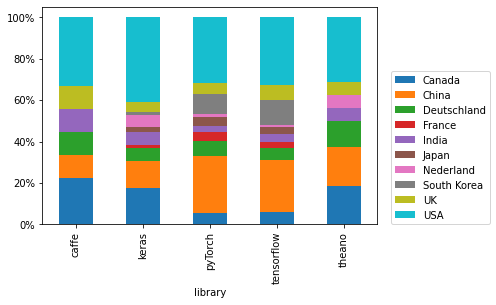

In [85]:
X_2.groupby(['library','country']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc=(1.04,0))
plt.show()

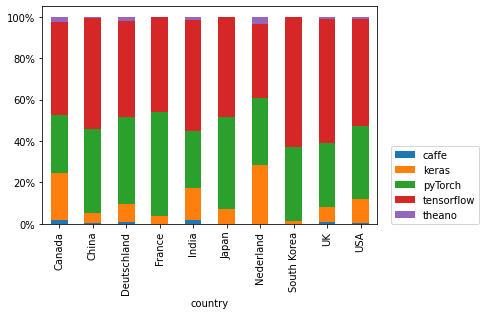

In [239]:
X_2.groupby(['country', 'library']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(loc=(1.04,0))
plt.show()

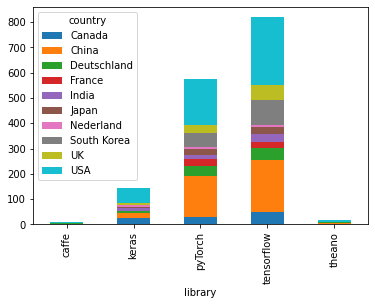

In [169]:
X_2.groupby(['library','country']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

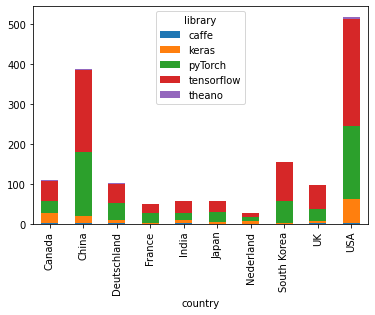

In [172]:
X_2.groupby(['country','library']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

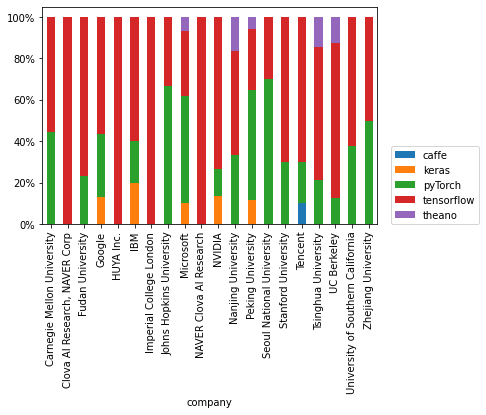

In [245]:
X_2.groupby(['company','library']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True, legend=True)

plt.legend(loc=(1.04,0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

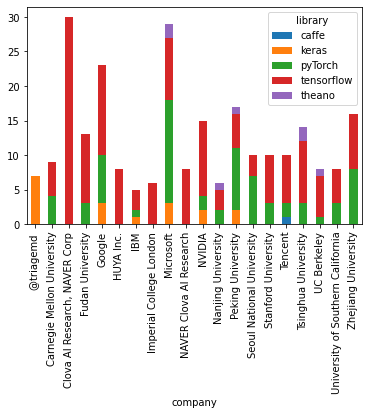

In [39]:
X_2.groupby(['company','library']).size().unstack().plot(kind='bar',stacked=True)
plt.show()

Commit data (time-series)

In [34]:
#number of forks
#number of commits
#number of events
#number of contributers 
#library distribution 



visualization from pandas
https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot

- Getting commit information 
- All contributors of the repo (event-data)
- types of events on repos 
- Reading papers 

generate commands to get history of commits

In [16]:
repo_path=glob.glob('repos/*/')
f=open ('commit_info.bash', 'w')
for path in tqdm(repo_path):
    
    #filename='../commit_info/'+path.split('/')[1]+'.txt'
    filename='../commit_info/'+path.split('/')[1].split('-')[-1]+'.txt'
    
    cmd= 'cd '+ path + '; git log --pretty=format:"%h - %an, %ad, %cn, %cd : %s" >'+ filename +'; cd ..; cd ..'
    f.write(cmd)
    f.write('\n')
f.close()


100%|██████████| 5335/5335 [00:00<00:00, 224221.29it/s]


In [10]:
repo_path[0]

'/lfs1/GitHubAPI/repos/10369479-98569908/'

In [13]:
repo_path[0].split('/')[4].split('-')[-1]

'98569908'

./commit_info.bash

command to get history of commits

git log --pretty=format:"%h - %an, %ad, %cn, %cd : %s" >> ../1.txt

command to get number of commits

git rev-list --all --count

#### events and contributors of repos

In [189]:
event_pd=pd.read_pickle('event_pandas.pickle')

In [190]:
len(event_pd)

4316204

In [191]:
event_pd.head(5)

event_id    repo_id                                repo_name  event_type  \
0  6598544756  103096245                      grahamplace/spotify   PushEvent   
1  6598545320  103712131               mengyx-work/word2dev_model   PushEvent   
2  6598545718   98965177               vahidk/EffectiveTensorflow  WatchEvent   
3  6598545731  102704384  KariMagdy/Implementing-a-neural-network   PushEvent   
4  6598546724  103622291                taki0112/SENet-Tensorflow  WatchEvent   

   actor_id                                 actor_url  
0  19509185  https://api.github.com/users/grahamplace  
1   6476198  https://api.github.com/users/mengyx-work  
2  21276421       https://api.github.com/users/fsiamp  
3   6607209    https://api.github.com/users/KariMagdy  
4  18051187  https://api.github.com/users/loveJasmine

In [15]:
repo_all=pd.read_pickle('repo_pandas.pickle')

In [16]:
len(repo_all)

238544

In [192]:
repo_pd=pd.read_pickle('repo_owner_url.pickle')

In [193]:
len(repo_pd['repo_id'].value_counts()), len(repo_pd)

(4274, 5486)

In [194]:
repo_pd.head(5)

repo_id  actor_id                                       download_url  \
0  103733627  15214696       https://github.com/desire2020/SRU-tensorflow   
1  110479921  23225001                  https://github.com/ShaynAli/Aipen   
2  176350689  43828431                   https://github.com/skyn3t13/pong   
3  177148468  22427196        https://github.com/fjchange/pytorch_ano_pre   
4  163966510  14870263  https://github.com/kcelia/adversarial_reprogra...   

   num_events          location                           company country  \
0        66.0    Shanghai, SJTU                          APEX Lab   China   
1       435.0   London, Ontario                              None  Canada   
2       289.0        London, UK                       Deloitte UK      UK   
3       124.0  Guangzhou, China  iSEE lab, Sun Yat-Sen University   China   
4        66.0             Paris               Sorbonne University  France   

      library  
0  tensorflow  
1        None  
2        None  
3  tensorflow  
4     pyTorch

In [195]:
user_pd=pd.read_pickle('user_pandas.pickle')

In [196]:
len(user_pd)

199769

In [197]:
len(user_pd[user_pd.company.notnull()]), len(user_pd[user_pd.location.notnull()])

(43188, 72156)

In [198]:
user_pd.columns

Index(['user_id', 'actor_url', 'actor_id', 'location', 'company'], dtype='object')

In [199]:
user_pd.head(5)

user_id                                     actor_url  actor_id  \
0  18051187.0      https://api.github.com/users/loveJasmine  18051187   
1   4847774.0        https://api.github.com/users/EthanYGao   4847774   
2  23393881.0  https://api.github.com/users/ZiliangWang0505  23393881   
3  17986868.0     https://api.github.com/users/zhizhongchai  17986868   
4  15107522.0     https://api.github.com/users/DuJiajun1994  15107522   

   location                        company  
0      None                           None  
1      None                           None  
2      None                           None  
3      None                           None  
4  Shanghai  Shanghai Jiao Tong University

In [200]:
users=user_pd[['actor_id', 'location', 'company']]

In [201]:
events=event_pd[event_pd['repo_id'].isin(set(repo_pd['repo_id']))][['event_id','repo_id', 'actor_id', 'event_type', 'repo_name', 'actor_url']]

In [202]:
events.head(5)

event_id    repo_id  actor_id  event_type  \
4   6598546724  103622291  18051187  WatchEvent   
6   6598549294   94113890   4847774   ForkEvent   
14  6598554770  103261054  23393881   PushEvent   
16  6598556101   79427137  17986868   ForkEvent   
18  6598556588  103261054  23393881   PushEvent   

                                            repo_name  \
4                           taki0112/SENet-Tensorflow   
6                         tostq/Caffe-Python-Tutorial   
14  ZiliangWang0505/AI-Challenger-Caption-Competition   
16                       kentsommer/keras-inceptionV4   
18  ZiliangWang0505/AI-Challenger-Caption-Competition   

                                       actor_url  
4       https://api.github.com/users/loveJasmine  
6         https://api.github.com/users/EthanYGao  
14  https://api.github.com/users/ZiliangWang0505  
16     https://api.github.com/users/zhizhongchai  
18  https://api.github.com/users/ZiliangWang0505

In [203]:
len(events)

967916

In [52]:
#join users and events on actor_id

In [205]:
repo_user_event=events.merge(users, left_on='actor_id', right_on='actor_id', how='left')

In [206]:
repo_user_event.head(5)

event_id    repo_id  actor_id  event_type  \
0  6598546724  103622291  18051187  WatchEvent   
1  6598549294   94113890   4847774   ForkEvent   
2  6598554770  103261054  23393881   PushEvent   
3  6598556101   79427137  17986868   ForkEvent   
4  6598556588  103261054  23393881   PushEvent   

                                           repo_name  \
0                          taki0112/SENet-Tensorflow   
1                        tostq/Caffe-Python-Tutorial   
2  ZiliangWang0505/AI-Challenger-Caption-Competition   
3                       kentsommer/keras-inceptionV4   
4  ZiliangWang0505/AI-Challenger-Caption-Competition   

                                      actor_url location company  
0      https://api.github.com/users/loveJasmine     None    None  
1        https://api.github.com/users/EthanYGao     None    None  
2  https://api.github.com/users/ZiliangWang0505     None    None  
3     https://api.github.com/users/zhizhongchai     None    None  
4  https://api.github.com/users/ZiliangWang0505     None    None

In [207]:
len(repo_user_event)

999376

In [208]:
user_w_loc=repo_user_event[repo_user_event['location'].notnull()][['actor_id', 'location']].drop_duplicates()

In [209]:
len(user_w_loc)

71539

In [210]:
user_w_loc.head()

actor_id                location
7   15107522                Shanghai
12   9300575                      CA
15  15214696          Shanghai, SJTU
17   2770389  Ookayama, Tokyo, Japan
22  26713992             South Korea

In [211]:
len(repo_user_event[repo_user_event.company.notnull()])# for 1/3 of the events, the company of the actor is known 

316488

In [ ]:
# convert location to country

### in script (user_loc_extraction.py)

In [212]:
!ls *.pickle

event_pandas.pickle    repo_pandas.pickle  user_w_loc.pickle
repo_owner_url.pickle  user_pandas.pickle


In [213]:
user_w_loc=pd.read_pickle('user_w_loc.pickle')

In [214]:
len(user_w_loc)

71539

In [215]:
user_w_loc.head(5)

actor_id                location      country
7   15107522                Shanghai        China
12   9300575                      CA       Canada
15  15214696          Shanghai, SJTU        China
17   2770389  Ookayama, Tokyo, Japan        Japan
22  26713992             South Korea  South Korea

In [216]:
len(user_w_loc[user_w_loc.country.notnull()])

65616

In [217]:
#join repo_user_event and user_w_loc on actor_id (correct)
repo_user_event=repo_user_event.merge(user_w_loc, left_on='actor_id', right_on='actor_id', how='left')

In [218]:
repo_user_event.head(5)

event_id    repo_id  actor_id  event_type  \
0  6598546724  103622291  18051187  WatchEvent   
1  6598549294   94113890   4847774   ForkEvent   
2  6598554770  103261054  23393881   PushEvent   
3  6598556101   79427137  17986868   ForkEvent   
4  6598556588  103261054  23393881   PushEvent   

                                           repo_name  \
0                          taki0112/SENet-Tensorflow   
1                        tostq/Caffe-Python-Tutorial   
2  ZiliangWang0505/AI-Challenger-Caption-Competition   
3                       kentsommer/keras-inceptionV4   
4  ZiliangWang0505/AI-Challenger-Caption-Competition   

                                      actor_url location_x company location_y  \
0      https://api.github.com/users/loveJasmine       None    None        NaN   
1        https://api.github.com/users/EthanYGao       None    None        NaN   
2  https://api.github.com/users/ZiliangWang0505       None    None        NaN   
3     https://api.github.com/users/zhizhongchai       None    None        NaN   
4  https://api.github.com/users/ZiliangWang0505       None    None        NaN   

  country  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [221]:
len(repo_user_event[repo_user_event.country.notnull()][['actor_id']].drop_duplicates())

65616

In [223]:
len(repo_user_event)

999376

In [222]:
#for 42% of the events, the country of the actor is known
len(repo_user_event), len(repo_user_event[repo_user_event.country.notnull()]), len(repo_user_event[repo_user_event.country.notnull()])/ len(repo_user_event)

(999376, 426842, 0.4271085157138054)

In [224]:
#frequent repos
frequent_repo=repo_user_event['repo_id'].value_counts().head(20).to_dict()

In [225]:
frequent_repo

{138331573: 18120,
 148221325: 12961,
 157198623: 11286,
 127846381: 11173,
 96913967: 9927,
 144782044: 8448,
 159249114: 8129,
 79841608: 7746,
 130474497: 7382,
 89384186: 7111,
 81460066: 6966,
 198919091: 6084,
 86167728: 5888,
 108619300: 5692,
 109252675: 5182,
 182210458: 5041,
 114906452: 4899,
 101303567: 4868,
 116650018: 4793,
 189350661: 4635}

### frequent repos

In [288]:
#name of frequent repos
repo_user_event[repo_user_event.repo_id.isin(frequent_repo)][['repo_id', 'repo_name', 'company', 'country', 'event_type']].drop_duplicates()

repo_id                                          repo_name  \
80      189350661                     lukemelas/EfficientNet-PyTorch   
81      189350661                     lukemelas/EfficientNet-PyTorch   
82      189350661                     lukemelas/EfficientNet-PyTorch   
84      130474497                        eriklindernoren/PyTorch-GAN   
85      189350661                     lukemelas/EfficientNet-PyTorch   
86      148221325                                tensorflow/datasets   
100     189350661                     lukemelas/EfficientNet-PyTorch   
104     189350661                     lukemelas/EfficientNet-PyTorch   
107     189350661                     lukemelas/EfficientNet-PyTorch   
120      86167728                          CharlesShang/FastMaskRCNN   
121     138331573                        sebastianruder/NLP-progress   
143     157198623                            hanxiao/bert-as-service   
155     144782044                                     NVIDIA/vid2vid   
160     101303567  hwalsuklee/tensorflow-generative-model-collect...   
162     127846381                                qqwweee/keras-yolo3   
170     138331573                        sebastianruder/NLP-progress   
179      89384186                                   eth-cscs/reframe   
186     144782044                                     NVIDIA/vid2vid   
190      89384186                                   eth-cscs/reframe   
197      96913967                          eriklindernoren/Keras-GAN   
207     148221325                                tensorflow/datasets   
210     148221325                                tensorflow/datasets   
213     148221325                                tensorflow/datasets   
227     127846381                                qqwweee/keras-yolo3   
229     148221325                                tensorflow/datasets   
248     157198623                            hanxiao/bert-as-service   
254     148221325                                tensorflow/datasets   
265      96913967                          eriklindernoren/Keras-GAN   
270     127846381                                qqwweee/keras-yolo3   
293     159249114                                  tensorflow/addons   
...           ...                                                ...   
998284   79841608                         endernewton/tf-faster-rcnn   
998318  198919091                                    taki0112/UGATIT   
998337  198919091                                    taki0112/UGATIT   
998356  101303567  hwalsuklee/tensorflow-generative-model-collect...   
998367  198919091                                    taki0112/UGATIT   
998398   79841608                         endernewton/tf-faster-rcnn   
998453  108619300                      naturomics/CapsNet-Tensorflow   
998464   81460066                       oarriaga/face_classification   
998465   81460066                       oarriaga/face_classification   
998540   79841608                         endernewton/tf-faster-rcnn   
998562  138331573                        sebastianruder/NLP-progress   
998591  148221325                                tensorflow/datasets   
998598  198919091                                    taki0112/UGATIT   
998614  198919091                                    taki0112/UGATIT   
998683  101303567  hwalsuklee/tensorflow-generative-model-collect...   
998702  108619300                      naturomics/CapsNet-Tensorflow   
998778   96913967                          eriklindernoren/Keras-GAN   
998783  130474497                        eriklindernoren/PyTorch-GAN   
998808  159249114                                  tensorflow/addons   
999031   79841608                         endernewton/tf-faster-rcnn   
999064   86167728                          CharlesShang/FastMaskRCNN   
999102   96913967                          eriklindernoren/Keras-GAN   
999112   79841608                         endernewton/tf-faster-rcnn   
999209  127846381                                q

In [227]:
X=repo_user_event[repo_user_event.repo_id.isin(frequent_repo)][['event_id','repo_id', 'event_type']]

In [229]:

pal = sns.color_palette("Set1")
colors = plt.cm.GnBu(np.linspace(0, 1, 10))

/usr/lib64/python3.6/site-packages/pandas/plotting/_core.py:186: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


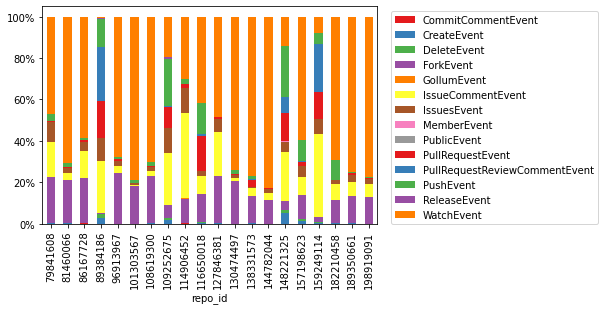

In [230]:
X.groupby(['repo_id','event_type']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True, legend=True, colors=pal)

plt.legend(loc=(1.04,0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

In [ ]:
#distribution of actors, company, actor, country w.r.t repo

In [250]:
repo_user_event[['event_id','repo_id', 'actor_id', 'event_type', 'repo_name', 'company', 'country']].head(100)

event_id    repo_id  actor_id                     event_type  \
0   6598546724  103622291  18051187                     WatchEvent   
1   6598549294   94113890   4847774                      ForkEvent   
2   6598554770  103261054  23393881                      PushEvent   
3   6598556101   79427137  17986868                      ForkEvent   
4   6598556588  103261054  23393881                      PushEvent   
5   6598557014  103261054  23393881                      PushEvent   
6   6598559048  103261054  23393881                      PushEvent   
7   6598559066   97081528  15107522                      PushEvent   
8   6598559430  103261054  23393881                      PushEvent   
9   6598560727  103261054  23393881                      PushEvent   
10  6598561358  103261054  23393881                      PushEvent   
11  6598561893  103261054  23393881                      PushEvent   
12  6598564449  102693613   9300575  PullRequestReviewCommentEvent   
13  6598564534  103261054  23393881                      PushEvent   
14  6598565136  103261054  23393881                      PushEvent   
15  6598565575  103733627  15214696                    CreateEvent   
16  6598565593  103733627  15214696                    CreateEvent   
17  6598568177  102929195   2770389                      PushEvent   
18  6598568506  103261054  23393881                      PushEvent   
19  6598569335   78311973   8555503                     WatchEvent   
20  6598569393  103261054  23393881                      PushEvent   
21  6598570565  102929195   2770389                      PushEvent   
22  6598573562   99529800  26713992                    IssuesEvent   
23  6598573856  101144707  26713992                    IssuesEvent   
24  6598574570  103663161  18491038                      PushEvent   
25  6598586498  103622291   8606090                     WatchEvent   
26  6598589389   83292099  12879006              IssueCommentEvent   
27  6598598098  103261054  23393881                      PushEvent   
28  6497765182   96477988   7189570                      PushEvent   
29  6497781217   86957671    946691                      PushEvent   
..         ...        ...       ...                            ...   
70  9743218295  183542608   7867464                      ForkEvent   
71  9743218296  183542608   7867464                     WatchEvent   
72  9743219054  176631897   5716282                     WatchEvent   
73  9743223404   88717189  50762677              IssueCommentEvent   
74  9743228205  186831056  10558268                     WatchEvent   
75  9743230722  171564291  12686966                      PushEvent   
76  9743233157  167355603  13728074                      PushEvent   
77  9743240517  147709096  23006154                     WatchEvent   
78  9743240517  147709096  23006154                     WatchEvent   
79  9743240517  147709096  23006154                     WatchEvent   
80  9743241401  189350661  39424079                     WatchEvent   
81  9743243404  189350661  11736435                     WatchEvent   
82  9743246212  189350661  11736435                      ForkEvent   
83  9743246585   99527575     30267                     WatchEvent   
84  9743248512  130474497  33280399                     WatchEvent   
85  9743262183  189350661   4252555                     WatchEvent   
86  9743263862  148221325    659115              IssueCommentEvent   
87  9743267759  120985410  11778086                     WatchEvent   
88  9743268943  113568532  30360846                     WatchEvent   
89  9743274076  184939842  13312796                      PushEvent   
90  9743275563  163207514  11940961                     WatchEvent   
91  9743275905  184939842  13312796                      PushEvent   
92  9743279888  120985410  46991314                     WatchEvent   
93  9743281961  183542608  21155371                     WatchEvent   
94  9743282265  171563572   7343585                     WatchEvent   
95  9743283912  

In [258]:
repo_user_event.groupby('repo_id')['event_type'].apply(list)
repo_user_event.groupby('repo_id')['actor_id'].apply(list)
repo_user_event.groupby('repo_id')['country'].apply(list)
repo_user_event.groupby('repo_id')['company'].apply(list)

repo_id
77792421     [None, Curtin University, Curtin University, N...
77793871     [@DrilebaCapital , @DrilebaCapital , None, Non...
77815047     [Private, None, None, None, None, Stillwater S...
77815274     [None, None, None, None, None, @Boom-Admin, No...
77834728     [None, None, alibaba, Huawei Technologies Co.,...
77904282     [None, None, None, nan, Veoneer, None, None, N...
77956059     [None, None, None, None, None, None, None, Non...
77967691     [None, nan, None, None, None, None, None, None...
78011482     [None, @snapappointments , Fudan University Sh...
78020799     [None, None, University of Michigan, None, NAV...
78033182     [DalianUniversityOfTechnolegy, Busymachines, N...
78072474     [None, None, None, None, None, None, None, Non...
78133112     [None, None, None, None, None, None, None, Non...
78142104     [Broad Institute of MIT and Harvard, Broad Ins...
78182627     [None, None, None, None, None, None, None, Non...
78213403     [None, None, Rutgers, @epfml , nan

In [285]:
#history of commits 
commit_history=glob.glob("repos/commit_info/*.txt")
len(commit_history)
commit_history_dict=defaultdict(list)
for f in tqdm(commit_history):
    repo_id=f.split('/')[-1][:-4]
    with open (f) as f:
        for line in f:
            line=line.strip().split(',')
        
            commit_history_dict[repo_id].append(line[1])
            #commit_history_dict[repo_id]['comment'].append(line[-1])
            
    

In [284]:
commit_history_dict

defaultdict(list,
            {'49490185-180821801': [' Thu Oct 17 22:48:25 2019 +0200',
              ' Mon Jun 24 13:46:27 2019 +0200',
              ' Mon Jun 24 12:00:32 2019 +0200',
              ' Mon Jun 24 11:52:33 2019 +0200',
              ' Mon May 13 15:57:37 2019 +0200',
              ' Mon May 13 15:03:55 2019 +0200',
              ' Mon May 13 14:29:36 2019 +0200',
              ' Mon May 13 14:29:05 2019 +0200',
              ' Mon May 13 14:28:22 2019 +0200',
              ' Mon May 13 14:20:46 2019 +0200',
              ' Mon May 13 14:14:43 2019 +0200',
              ' Mon May 13 14:02:24 2019 +0200',
              ' Mon May 13 13:59:40 2019 +0200',
              ' Mon May 13 13:55:38 2019 +0200',
              ' Mon May 13 12:32:18 2019 +0200',
              ' Mon May 13 11:33:09 2019 +0200',
              ' Mon May 13 11:00:36 2019 +0200',
              ' Mon May 13 11:00:12 2019 +0200',
              ' Mon May 13 10:43:07 2019 +0200',
              ' Mon May 13 10


 80%|███████▉  | 3422/4286 [00:22<00:00, 922.89it/s]

### Case Study

In [25]:
path='/lfs1/GitHubAPI/case_study_repos/'

In [26]:
repo_case_study_profiles=glob.glob(path+"*.api")

In [5]:
def repo_case_study(f):
    output=[]

    with open (f) as json_file:
        repo_info=json.load(json_file)
        output.append(repo_info['id'])
        
    return output

In [6]:
files=repo_case_study_profiles
process=repo_case_study

In [7]:
pbar = tqdm(total=len([1 for _ in files]))
def update(*a): pbar.update()
with Pool(processes=multiprocessing.cpu_count()) as p:
    data_ = []

    for f in files:
        data_.append(p.apply_async(process, [f], callback=update))


    p.close()
    p.join() # Wait for all child processes 
    data = [r.get() for r in data_]


  2%|▏         | 1/45 [00:00<00:22,  1.96it/s]

In [12]:
repo_case_study_id=[]
for item in data:
    repo_case_study_id.append(item[0])

In [13]:
with open('case_study_repo_ids.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(repo_case_study_id, filehandle)
filehandle.close()

In [14]:
with open('case_study_repo_ids.data', 'rb') as filehandle:
    repo_ids=pickle.load(filehandle)



In [15]:
len(repo_ids)

45

In [16]:
events_case_study=pd.read_pickle('events_case_study.pickle')#Extract events associated with these repos from script (evenets_extraction.py)

In [79]:
events_case_study.repo_name.value_counts().size

66

In [89]:
f.split('/')[-1][:-4]

'ObjectDetection-OneStageDet'

#### Case_study_Repos

In [90]:
ct, repos=0, []
for f in tqdm(repo_case_study_profiles):
    with open (f) as json_file:
        repo_info = json.load(json_file)
            
        repos.append([repo_info['id'], repo_info['name'],repo_info['full_name'], repo_info['owner']['id'], 
                     repo_info['owner']['login'], repo_info['owner']['url'], repo_info['owner']['type'],
                      repo_info['language'], repo_info['created_at'], repo_info['stargazers_count'], repo_info['watchers_count'],
                     repo_info['forks_count'], repo_info['open_issues_count'], f.split('/')[-1][:-4]])

            
good_columns=['repo_id', 'repo_name', 'repo_full_name', 'owner_id', 'owner_login', 'owner_url', 'owner_type', 
             'language', 'created_at', 'star_count', 'watchers_count', 'forks_count', 'open_issues_count', 'REPO_name']

repo_case_study=pd.DataFrame(repos, columns=good_columns)


100%|██████████| 45/45 [00:00<00:00, 4135.13it/s]


In [91]:
repo_case_study.to_pickle('repo_case_study.pickle')

In [95]:
repo_name_to_id=pd.Series(repo_case_study.repo_id.values,index=repo_case_study.REPO_name).to_dict()

### Commit History Case Study 

In [97]:
#commit time and comment
#history of commits 
commit_history=glob.glob("case_study_repos/*.txt")
print (len(commit_history))

#take first zero to initiate dataframe
repo_name=commit_history[0].split('/')[-1][:-4]
repo_id=repo_name_to_id[repo_name]
data = pd.read_csv(commit_history[0], names=['comment'])
repo_id=len(data)*[repo_id]
data.insert(0, "repo_id", repo_id, True) 

#add repos to initiall data frame
for file in tqdm(commit_history[1:]):
    repo_name=file.split('/')[-1][:-4]
    repo_id=repo_name_to_id[repo_name]
    data_ = pd.read_csv(file, names=['comment'])
    repo_id=len(data_)*[repo_id]
    data_.insert(0, "repo_id", repo_id, True)
    frames=[data, data_]
    data=pd.concat(frames)
    



 41%|████      | 18/44 [00:00<00:00, 169.55it/s]

45



100%|██████████| 44/44 [00:00<00:00, 161.26it/s]


In [98]:
data.to_pickle('commit_history_case_study.pickle')

In [100]:
data

repo_id                                            comment
0    139385822                                         fix README
1    139385822                                      add en readme
2    139385822                                          fix vocab
3    139385822                                      update README
4    139385822                                      update README
..         ...                                                ...
187   62231847   Adds the remove_entity primitive to the grid ...
188   62231847        renaming md files to have the .md extension
189   62231847           Map direction names to direction vectors
190   62231847                 Support for dynamic event handlers
191   62231847                                     Initial commit

[21834 rows x 2 columns]